In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
sys.path.append("..")
from dataloader import create_dataloader
from metric import Metric
import backbone
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
torch.cuda.empty_cache()


# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 21
thresholds = [0.5] * num_labels
in_channels = 3
num_classes = 21
data_dir = '../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/train.csv
384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [4]:
# # Create model and move to device
# model = backbone.backbone['densenet201'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# Create model and move to device
model = backbone.backbone['resnet152v2'](num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [6]:
# # Create model and move to device
# model = backbone.backbone['efficientnetv2_extralarge'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a=0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad(): metric.update(outputs, labels)
            
    scheduler.step()
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)  
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
        
    # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/rn152d-rfmid.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh) 
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 

Epoch 1/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [1/200], Loss: 0.2110, ML mAP: 0.0759, ML F1: 0.9124, ML AUC: 0.5365, ML Score: 0.3062, Bin AUC: 0.0000, Model Score: 0.1531, Bin F1: 1.0000
[0.54 0.56 0.57 0.53 0.5  0.56 0.5  0.55 0.48 0.52 0.54 0.44 0.56 0.54
 0.54 0.52 0.53 0.51 0.55 0.53 0.55]
Accuracy list: [0.8695238095238095, 0.9552380952380952, 0.9238095238095239, 0.9004761904761904, 0.919047619047619, 0.8814285714285715, 0.9271428571428572, 0.9361904761904762, 0.9047619047619048, 0.9347619047619048, 0.9380952380952381, 0.8361904761904762, 0.9380952380952381, 0.9538095238095238, 0.9457142857142857, 0.9538095238095238, 0.9342857142857143, 0.94, 0.950952380952381, 0.930952380952381, 0.9447619047619048]
Specificity list: [0.9994526546250684, 0.9995017438963627, 0.9984559958826557, 0.9994714587737844, 0.9984480082772892, 0.9994600431965442, 0.9979497693490518, 0.9989837398373984, 0.9569620253164557, 0.9994908350305499, 0.9994926433282597, 0.8883792048929664, 0.9989858012170385, 0.9985044865403788, 0.9989939637826962, 0.99850

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [1/200], Loss: 20.3345, ML mAP: 0.1387, ML F1: 0.8445, ML AUC: 0.6783, ML Score: 0.4085, Bin AUC: 0.2500, Model Score: 0.3292, Bin F1: 0.0000
[0.15 0.07 0.19 0.15 0.22 0.3  0.2  0.17 0.19 0.17 0.23 0.29 0.22 0.19
 0.17 0.2  0.22 0.27 0.19 0.11 0.19]
Accuracy list: [0.734375, 0.6741071428571429, 0.9419642857142857, 0.8504464285714286, 0.9486607142857143, 0.9241071428571429, 0.9419642857142857, 0.9508928571428571, 0.9553571428571429, 0.9821428571428571, 0.9709821428571429, 0.9799107142857143, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9821428571428571, 0.9776785714285714, 0.9821428571428571, 0.9888392857142857, 0.8325892857142857, 0.9754464285714286]
Specificity list: [0.8179271708683473, 0.7988980716253443, 0.9976359338061466, 0.908641975308642, 0.9976525821596244, 0.9975903614457832, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.9977

100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Test - Epoch [1/200], Loss: 20.2842, ML mAP: 0.1329, ML F1: 0.5498, ML AUC: 0.6672, ML Score: 0.4001, Bin AUC: 0.2500, Model Score: 0.3250, Bin F1: 0.0000

[0.15 0.07 0.19 0.15 0.22 0.3  0.2  0.17 0.19 0.17 0.23 0.29 0.22 0.19
 0.17 0.2  0.22 0.27 0.19 0.11 0.19]
Accuracy list: [0.7387387387387387, 0.6981981981981982, 0.9346846846846847, 0.8490990990990991, 0.9436936936936937, 0.9166666666666666, 0.9504504504504504, 0.9504504504504504, 0.963963963963964, 0.9707207207207207, 0.9752252252252253, 0.9774774774774775, 0.9662162162162162, 0.9752252252252253, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.8333333333333334, 0.9527027027027027]
Specificity list: [0.8455056179775281, 0.8278688524590164, 0.9975903614457832, 0.9296482412060302, 1.0, 0.9975490196078431, 0.9976359338061466, 0.9976359338061466, 0.9976689976689976, 0.9976851851851852, 0.9976958525345622, 0.9977011494252873, 0.9953596287703016, 1.0, 0.997716894977169, 1.0, 0.997722

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [2/200], Loss: 0.2429, ML mAP: 0.2647, ML F1: 0.6554, ML AUC: 0.7670, ML Score: 0.5159, Bin AUC: 0.7500, Model Score: 0.6329, Bin F1: 0.0000
[0.16 0.21 0.3  0.17 0.34 0.51 0.17 0.12 0.1  0.19 0.12 0.13 0.14 0.13
 0.18 0.13 0.11 0.45 0.16 0.1  0.17]
Accuracy list: [0.7938095238095239, 0.9461904761904761, 0.9161904761904762, 0.8609523809523809, 0.9104761904761904, 0.8919047619047619, 0.9304761904761905, 0.9276190476190476, 0.8757142857142857, 0.9371428571428572, 0.9252380952380952, 0.9119047619047619, 0.9533333333333334, 0.9566666666666667, 0.9395238095238095, 0.9257142857142857, 0.8761904761904762, 0.9447619047619048, 0.949047619047619, 0.8552380952380952, 0.9866666666666667]
Specificity list: [0.8577586206896551, 0.9994969818913481, 0.9994805194805195, 0.8956476140534871, 0.9994772608468374, 0.9994663820704376, 0.9994884910485934, 0.9695894576786619, 0.9280245022970903, 0.9994921279837481, 0.9667170953101362, 0.9271151885830785, 0.9995007488766849, 0.9944972486243121, 0.999493414

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [2/200], Loss: 20.1611, ML mAP: 0.2956, ML F1: 0.7815, ML AUC: 0.8302, ML Score: 0.5629, Bin AUC: 1.0000, Model Score: 0.7815, Bin F1: 0.0000
[0.12 0.25 0.25 0.24 0.33 0.14 0.19 0.17 0.17 0.2  0.23 0.19 0.17 0.35
 0.2  0.22 0.25 0.44 0.17 0.13 0.3 ]
Accuracy list: [0.7165178571428571, 0.8035714285714286, 0.9419642857142857, 0.8973214285714286, 0.9486607142857143, 0.8727678571428571, 0.9419642857142857, 0.9665178571428571, 0.9553571428571429, 0.9799107142857143, 0.9754464285714286, 0.9799107142857143, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9821428571428571, 0.9754464285714286, 0.984375, 0.9888392857142857, 0.8660714285714286, 0.9977678571428571]
Specificity list: [0.7142857142857143, 0.9917355371900827, 0.9976359338061466, 0.9432098765432099, 0.9976525821596244, 0.9228915662650602, 0.9976359338061466, 0.990632318501171, 0.9976689976689976, 0.9954648526077098, 0.9931192660550459, 0.9818181818181818, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.9977

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [2/200], Loss: 20.0908, ML mAP: 0.2931, ML F1: 0.3789, ML AUC: 0.8275, ML Score: 0.5603, Bin AUC: 0.9500, Model Score: 0.7551, Bin F1: 0.0000

[0.12 0.25 0.25 0.24 0.33 0.14 0.19 0.17 0.17 0.2  0.23 0.19 0.17 0.35
 0.2  0.22 0.25 0.44 0.17 0.13 0.3 ]
Accuracy list: [0.7027027027027027, 0.8220720720720721, 0.9346846846846847, 0.8536036036036037, 0.9414414414414415, 0.8761261261261262, 0.9527027027027027, 0.9662162162162162, 0.963963963963964, 0.9684684684684685, 0.9707207207207207, 0.9684684684684685, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.8648648648648649, 1.0]
Specificity list: [0.7191011235955056, 0.9972677595628415, 0.9927710843373494, 0.9271356783919598, 0.9952267303102625, 0.9387254901960784, 1.0, 0.9905437352245863, 0.9976689976689976, 0.9953703703703703, 0.988479262672811, 0.9816091954022989, 1.0, 0.9930715935334873, 1.0, 1.0, 0.9886104783599089, 0.9977272727272727,

100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [3/200], Loss: 0.1660, ML mAP: 0.4368, ML F1: 0.6171, ML AUC: 0.8688, ML Score: 0.6528, Bin AUC: 0.6500, Model Score: 0.6514, Bin F1: 0.0000
[0.24 0.45 0.38 0.2  0.23 0.3  0.2  0.18 0.16 0.15 0.16 0.25 0.12 0.22
 0.14 0.11 0.56 0.14 0.14 0.13 0.37]
Accuracy list: [0.8776190476190476, 0.9438095238095238, 0.9223809523809524, 0.8804761904761905, 0.9085714285714286, 0.9133333333333333, 0.9419047619047619, 0.9566666666666667, 0.9414285714285714, 0.9123809523809524, 0.9276190476190476, 0.9557142857142857, 0.9480952380952381, 0.9704761904761905, 0.9471428571428572, 0.8952380952380953, 0.9276190476190476, 0.8971428571428571, 0.9371428571428572, 0.9033333333333333, 0.9976190476190476]
Specificity list: [0.9516567083107007, 0.9994957135653051, 0.999484004127967, 0.9093277748827514, 0.9514713474445018, 0.9652963160704752, 0.9994946942900454, 0.981237322515213, 0.998989388580091, 0.9437974683544303, 0.9526235354049923, 0.9689725330620549, 0.9764174611138986, 0.9848714069591528, 0.98090452261

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [3/200], Loss: 19.9443, ML mAP: 0.4128, ML F1: 0.7886, ML AUC: 0.8853, ML Score: 0.6491, Bin AUC: 1.0000, Model Score: 0.8245, Bin F1: 1.0000
[0.22 0.14 0.35 0.25 0.23 0.17 0.2  0.42 0.17 0.36 0.39 0.18 0.25 0.18
 0.32 0.32 0.41 0.37 0.38 0.1  0.39]
Accuracy list: [0.8683035714285714, 0.828125, 0.9419642857142857, 0.8973214285714286, 0.9285714285714286, 0.9263392857142857, 0.9419642857142857, 0.9799107142857143, 0.9553571428571429, 0.9821428571428571, 0.9866071428571429, 0.9888392857142857, 0.9799107142857143, 0.9821428571428571, 0.96875, 0.9821428571428571, 0.9821428571428571, 0.9821428571428571, 0.9888392857142857, 0.8861607142857143, 1.0]
Specificity list: [0.927170868347339, 0.8429752066115702, 0.9976359338061466, 0.9308641975308642, 0.9530516431924883, 0.9590361445783132, 0.9976359338061466, 0.990632318501171, 0.9976689976689976, 0.9977324263038548, 0.9954128440366973, 0.9886363636363636, 0.9954337899543378, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [3/200], Loss: 19.8995, ML mAP: 0.4273, ML F1: 0.5511, ML AUC: 0.8769, ML Score: 0.6521, Bin AUC: 1.0000, Model Score: 0.8260, Bin F1: 1.0000

[0.22 0.14 0.35 0.25 0.23 0.17 0.2  0.42 0.17 0.36 0.39 0.18 0.25 0.18
 0.32 0.32 0.41 0.37 0.38 0.1  0.39]
Accuracy list: [0.8716216216216216, 0.8355855855855856, 0.9369369369369369, 0.8513513513513513, 0.9301801801801802, 0.9256756756756757, 0.9527027027027027, 0.9662162162162162, 0.963963963963964, 0.9707207207207207, 0.9887387387387387, 0.9707207207207207, 0.9752252252252253, 0.990990990990991, 0.9774774774774775, 0.9774774774774775, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.8918918918918919, 1.0]
Specificity list: [0.9269662921348315, 0.8524590163934426, 0.9975903614457832, 0.8994974874371859, 0.9594272076372315, 0.9656862745098039, 1.0, 0.9787234042553191, 0.9976689976689976, 0.9976851851851852, 0.9907834101382489, 0.9793103448275862, 1.0, 0.9953810623556582, 0.9908675799086758, 0.9931192660550459, 0.995444

100%|██████████| 132/132 [00:39<00:00,  3.31it/s]


Epoch [4/200], Loss: 0.1773, ML mAP: 0.5632, ML F1: 0.6733, ML AUC: 0.9127, ML Score: 0.7379, Bin AUC: 1.0000, Model Score: 0.8690, Bin F1: 0.6667
[0.31 0.27 0.43 0.77 0.24 0.23 0.34 0.22 0.11 0.41 0.24 0.36 0.25 0.24
 0.2  0.19 0.29 0.29 0.18 0.13 0.17]
Accuracy list: [0.9066666666666666, 0.9476190476190476, 0.9261904761904762, 0.9019047619047619, 0.8947619047619048, 0.9114285714285715, 0.9304761904761905, 0.9585714285714285, 0.8885714285714286, 0.9385714285714286, 0.9723809523809523, 0.9704761904761905, 0.9571428571428572, 0.9847619047619047, 0.9471428571428572, 0.9471428571428572, 0.9504761904761905, 0.9514285714285714, 0.9423809523809524, 0.8819047619047619, 0.9976190476190476]
Specificity list: [0.96126568466994, 0.976, 0.9994861253854059, 0.9994722955145119, 0.9285336156696665, 0.9363091997822537, 0.9994884910485934, 0.9748110831234257, 0.9089984748347738, 0.9994929006085193, 0.9850968703427719, 0.9805924412665986, 0.9864389753892516, 0.9909683893627697, 0.9708886618998979, 0.967

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [4/200], Loss: 19.8675, ML mAP: 0.4889, ML F1: 0.7778, ML AUC: 0.9134, ML Score: 0.7012, Bin AUC: 1.0000, Model Score: 0.8506, Bin F1: 1.0000
[0.33 0.21 0.18 0.3  0.21 0.13 0.26 0.25 0.17 0.36 0.41 0.24 0.32 0.3
 0.91 0.68 0.5  0.72 0.41 0.14 0.22]
Accuracy list: [0.8950892857142857, 0.8526785714285714, 0.9129464285714286, 0.921875, 0.9151785714285714, 0.9419642857142857, 0.9419642857142857, 0.9866071428571429, 0.9754464285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.96875, 0.9821428571428571, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.90625, 1.0]
Specificity list: [0.9495798319327731, 0.8732782369146006, 0.933806146572104, 0.9654320987654321, 0.9295774647887324, 0.9614457831325302, 0.9976359338061466, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9862385321100917, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.99774774

100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Test - Epoch [4/200], Loss: 19.8189, ML mAP: 0.5096, ML F1: 0.5437, ML AUC: 0.9055, ML Score: 0.7075, Bin AUC: 1.0000, Model Score: 0.8538, Bin F1: 1.0000

[0.33 0.21 0.18 0.3  0.21 0.13 0.26 0.25 0.17 0.36 0.41 0.24 0.32 0.3
 0.91 0.68 0.5  0.72 0.41 0.14 0.22]
Accuracy list: [0.8986486486486487, 0.8603603603603603, 0.9009009009009009, 0.9054054054054054, 0.9414414414414415, 0.9527027027027027, 0.9527027027027027, 0.9797297297297297, 0.9752252252252253, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9774774774774775, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9550561797752809, 0.8715846994535519, 0.9349397590361446, 0.964824120603015, 0.9594272076372315, 0.9803921568627451, 0.9976359338061466, 0.9881796690307328, 0.9883449883449883, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.997716894977169, 0.9977064220183486, 0.99772209

100%|██████████| 132/132 [00:34<00:00,  3.81it/s]


Epoch [5/200], Loss: 0.1595, ML mAP: 0.6670, ML F1: 0.6814, ML AUC: 0.9374, ML Score: 0.8022, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.6667
[0.33 0.18 0.22 0.34 0.27 0.42 0.33 0.24 0.16 0.16 0.38 0.47 0.23 0.23
 0.23 0.72 0.33 0.23 0.25 0.14 0.36]
Accuracy list: [0.9176190476190477, 0.9252380952380952, 0.9085714285714286, 0.9242857142857143, 0.9238095238095239, 0.95, 0.929047619047619, 0.9676190476190476, 0.9423809523809524, 0.8914285714285715, 0.98, 0.981904761904762, 0.959047619047619, 0.9876190476190476, 0.949047619047619, 0.9471428571428572, 0.9628571428571429, 0.9557142857142857, 0.9685714285714285, 0.9214285714285714, 0.9976190476190476]
Specificity list: [0.9608056614044638, 0.9444722361180591, 0.9364341085271318, 0.9610458911419424, 0.9489690721649484, 0.9817400644468314, 0.9994877049180327, 0.9802130898021308, 0.9619675456389453, 0.9170460293373799, 0.9944360141628731, 0.9918575063613232, 0.9843434343434343, 0.991546494281452, 0.9647239263803681, 0.9994974874371859, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [5/200], Loss: 19.7370, ML mAP: 0.5409, ML F1: 0.7538, ML AUC: 0.9274, ML Score: 0.7341, Bin AUC: 1.0000, Model Score: 0.8671, Bin F1: 1.0000
[0.46 0.08 0.48 0.48 0.13 0.29 0.31 0.21 0.16 0.38 0.52 0.28 0.49 0.14
 0.55 0.53 0.33 0.69 0.7  0.13 0.5 ]
Accuracy list: [0.9107142857142857, 0.8459821428571429, 0.9419642857142857, 0.9330357142857143, 0.8973214285714286, 0.9553571428571429, 0.9419642857142857, 0.9888392857142857, 0.9799107142857143, 0.9821428571428571, 0.9910714285714286, 0.9888392857142857, 0.984375, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.984375, 0.984375, 0.9888392857142857, 0.9084821428571429, 1.0]
Specificity list: [0.9831932773109243, 0.8319559228650137, 0.9976359338061466, 0.9580246913580247, 0.9014084507042254, 0.983132530120482, 0.9976359338061466, 0.9953161592505855, 0.9836829836829837, 0.9977324263038548, 1.0, 0.9931818181818182, 1.0, 0.9862385321100917, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.997747747

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [5/200], Loss: 19.6964, ML mAP: 0.5645, ML F1: 0.5264, ML AUC: 0.9193, ML Score: 0.7419, Bin AUC: 1.0000, Model Score: 0.8709, Bin F1: 1.0000

[0.46 0.08 0.48 0.48 0.13 0.29 0.31 0.21 0.16 0.38 0.52 0.28 0.49 0.14
 0.55 0.53 0.33 0.69 0.7  0.13 0.5 ]
Accuracy list: [0.9099099099099099, 0.8423423423423423, 0.9391891891891891, 0.9076576576576577, 0.9076576576576577, 0.9414414414414415, 0.9527027027027027, 0.9774774774774775, 0.9774774774774775, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9752252252252253, 0.9842342342342343, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9719101123595506, 0.8333333333333334, 0.9927710843373494, 0.9447236180904522, 0.9260143198090692, 0.9852941176470589, 0.9976359338061466, 0.9787234042553191, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9884526558891455, 0.9863013698630136, 0.9977064220183486, 0.995444

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [6/200], Loss: 0.1875, ML mAP: 0.7176, ML F1: 0.6963, ML AUC: 0.9497, ML Score: 0.8336, Bin AUC: 0.6500, Model Score: 0.7418, Bin F1: 1.0000
[0.35 0.66 0.27 0.32 0.22 0.26 0.16 0.29 0.31 0.19 0.37 0.25 0.31 0.3
 0.37 0.29 0.3  0.36 0.22 0.15 0.17]
Accuracy list: [0.9228571428571428, 0.9514285714285714, 0.9466666666666667, 0.9171428571428571, 0.9247619047619048, 0.9366666666666666, 0.919047619047619, 0.9761904761904762, 0.9657142857142857, 0.8938095238095238, 0.9780952380952381, 0.9728571428571429, 0.9728571428571429, 0.9914285714285714, 0.9695238095238096, 0.9757142857142858, 0.9695238095238096, 0.9647619047619047, 0.9714285714285714, 0.9242857142857143, 0.9980952380952381]
Specificity list: [0.962534435261708, 0.9994997498749375, 0.9751269035532995, 0.9508196721311475, 0.9458204334365325, 0.952329360780065, 0.953760162601626, 0.9882473173224323, 0.9924242424242424, 0.9211873080859775, 0.9943963321446765, 0.9781615033011681, 0.9930313588850174, 0.9965069860279441, 0.9869083585095

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [6/200], Loss: 19.6905, ML mAP: 0.5765, ML F1: 0.7729, ML AUC: 0.9344, ML Score: 0.7555, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 1.0000
[0.41 0.16 0.24 0.39 0.83 0.95 0.39 0.48 0.18 0.37 0.57 0.51 0.59 0.15
 0.7  0.48 0.25 0.64 0.59 0.13 0.24]
Accuracy list: [0.9107142857142857, 0.8683035714285714, 0.9441964285714286, 0.9375, 0.9486607142857143, 0.9241071428571429, 0.9419642857142857, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9799107142857143, 0.9776785714285714, 0.9955357142857143, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.90625, 1.0]
Specificity list: [0.9803921568627451, 0.8842975206611571, 0.9716312056737588, 0.9580246913580247, 0.9976525821596244, 0.9975903614457832, 0.9976359338061466, 1.0, 0.986013986013986, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9839449541284404, 0.9977011494252873, 0.9954648526077098, 0.9795918367346939, 0.997737556561086, 0.9977477477477478, 0.9621212121212122, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [6/200], Loss: 19.6547, ML mAP: 0.6023, ML F1: 0.5087, ML AUC: 0.9228, ML Score: 0.7626, Bin AUC: 1.0000, Model Score: 0.8813, Bin F1: 1.0000

[0.41 0.16 0.24 0.39 0.83 0.95 0.39 0.48 0.18 0.37 0.57 0.51 0.59 0.15
 0.7  0.48 0.25 0.64 0.59 0.13 0.24]
Accuracy list: [0.9054054054054054, 0.8873873873873874, 0.9234234234234234, 0.9166666666666666, 0.9459459459459459, 0.918918918918919, 0.9527027027027027, 0.9752252252252253, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9752252252252253, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9662921348314607, 0.8934426229508197, 0.9590361445783132, 0.9522613065326633, 1.0, 1.0, 1.0, 0.9881796690307328, 0.9906759906759907, 1.0, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9861431870669746, 0.997716894977169, 0.9954128440366973, 0.9886104783599089, 0.9886363636363636, 1.0, 0.963917525

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [7/200], Loss: 0.1996, ML mAP: 0.7520, ML F1: 0.7023, ML AUC: 0.9568, ML Score: 0.8544, Bin AUC: 0.9211, Model Score: 0.8877, Bin F1: 1.0000
[0.26 0.31 0.31 0.31 0.32 0.37 0.16 0.31 0.29 0.22 0.38 0.4  0.21 0.45
 0.33 0.22 0.28 0.28 0.34 0.2  0.15]
Accuracy list: [0.9271428571428572, 0.9580952380952381, 0.9319047619047619, 0.9285714285714286, 0.9328571428571428, 0.9538095238095238, 0.9119047619047619, 0.9714285714285714, 0.9661904761904762, 0.9304761904761905, 0.9771428571428571, 0.9852380952380952, 0.9714285714285714, 0.9923809523809524, 0.9747619047619047, 0.9780952380952381, 0.97, 0.9652380952380952, 0.9838095238095238, 0.9423809523809524, 0.9985714285714286]
Specificity list: [0.9530567685589519, 0.986404833836858, 0.9699170124481328, 0.9582893347412883, 0.9632314862765406, 0.97733405288721, 0.9303991811668373, 0.9849018621036739, 0.9903894790085989, 0.9635258358662614, 0.9888551165146909, 0.9913573970513472, 0.9871287128712871, 0.9975012493753124, 0.9883955600403632, 0.9815,

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [7/200], Loss: 19.6689, ML mAP: 0.6083, ML F1: 0.7591, ML AUC: 0.9408, ML Score: 0.7745, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000
[0.17 0.19 0.35 0.35 0.86 0.95 0.5  0.2  0.21 0.42 0.53 0.35 0.19 0.09
 0.8  0.59 0.4  0.69 0.75 0.2  0.14]
Accuracy list: [0.8995535714285714, 0.8794642857142857, 0.9508928571428571, 0.9397321428571429, 0.9486607142857143, 0.9241071428571429, 0.9419642857142857, 0.9888392857142857, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9665178571428571, 0.984375, 0.9776785714285714, 0.9933035714285714, 0.9821428571428571, 0.984375, 0.9933035714285714, 0.9151785714285714, 1.0]
Specificity list: [0.9355742296918768, 0.9008264462809917, 0.9763593380614657, 0.9580246913580247, 0.9976525821596244, 0.9975903614457832, 0.9976359338061466, 0.9953161592505855, 0.9883449883449883, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.9726027397260274, 0.9885321100917431, 0.9977011494252873, 0.9954648526077098, 0.993197

100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [7/200], Loss: 19.6220, ML mAP: 0.6170, ML F1: 0.5879, ML AUC: 0.9289, ML Score: 0.7729, Bin AUC: 1.0000, Model Score: 0.8865, Bin F1: 1.0000

[0.17 0.19 0.35 0.35 0.86 0.95 0.5  0.2  0.21 0.42 0.53 0.35 0.19 0.09
 0.8  0.59 0.4  0.69 0.75 0.2  0.14]
Accuracy list: [0.9054054054054054, 0.8896396396396397, 0.9369369369369369, 0.9279279279279279, 0.9436936936936937, 0.9166666666666666, 0.9527027027027027, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.972972972972973, 0.9707207207207207, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9076576576576577, 1.0]
Specificity list: [0.9410112359550562, 0.8989071038251366, 0.9759036144578314, 0.9522613065326633, 1.0, 0.9975490196078431, 1.0, 0.9881796690307328, 0.9906759906759907, 1.0, 0.988479262672811, 0.9839080459770115, 0.9860788863109049, 0.9838337182448037, 0.997716894977169, 0.9977064220183486, 0.9954441913439636, 0.9931

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [8/200], Loss: 0.1222, ML mAP: 0.7601, ML F1: 0.7357, ML AUC: 0.9580, ML Score: 0.8590, Bin AUC: 1.0000, Model Score: 0.9295, Bin F1: 1.0000
[0.33 0.29 0.29 0.3  0.27 0.3  0.17 0.29 0.34 0.51 0.26 0.28 0.24 0.3
 0.26 0.34 0.32 0.42 0.33 0.17 0.17]
Accuracy list: [0.9361904761904762, 0.96, 0.9271428571428572, 0.9352380952380952, 0.9133333333333333, 0.9495238095238095, 0.91, 0.9671428571428572, 0.9723809523809523, 0.9385714285714286, 0.9814285714285714, 0.98, 0.969047619047619, 0.9938095238095238, 0.9695238095238096, 0.9866666666666667, 0.9738095238095238, 0.969047619047619, 0.9804761904761905, 0.9166666666666666, 1.0]
Specificity list: [0.9669197396963124, 0.9771144278606965, 0.9608559498956158, 0.9555555555555556, 0.9416403785488959, 0.9708108108108108, 0.9337782340862423, 0.9861039629439012, 0.9974747474747475, 0.9994929006085193, 0.988905698436712, 0.9846938775510204, 0.987058237929318, 0.9974886991461577, 0.9778002018163471, 0.9940209267563528, 0.9867617107942973, 0.9867482161

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [8/200], Loss: 19.6229, ML mAP: 0.6099, ML F1: 0.7436, ML AUC: 0.9385, ML Score: 0.7742, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000
[0.23 0.15 0.35 0.29 0.79 0.93 0.16 0.34 0.26 0.41 0.89 0.28 0.13 0.27
 0.77 0.65 0.66 0.75 0.58 0.12 0.44]
Accuracy list: [0.9107142857142857, 0.8883928571428571, 0.9575892857142857, 0.9441964285714286, 0.9486607142857143, 0.9241071428571429, 0.890625, 0.9888392857142857, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9665178571428571, 0.984375, 0.9776785714285714, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.8950892857142857, 1.0]
Specificity list: [0.9551820728291317, 0.9256198347107438, 0.983451536643026, 0.9629629629629629, 0.9976525821596244, 0.9975903614457832, 0.8959810874704491, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 1.0, 0.9954545454545455, 0.9703196347031964, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 1.0, 0.997737556561086, 0

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Test - Epoch [8/200], Loss: 19.5804, ML mAP: 0.6280, ML F1: 0.5936, ML AUC: 0.9276, ML Score: 0.7778, Bin AUC: 1.0000, Model Score: 0.8889, Bin F1: 1.0000

[0.23 0.15 0.35 0.29 0.79 0.93 0.16 0.34 0.26 0.41 0.89 0.28 0.13 0.27
 0.77 0.65 0.66 0.75 0.58 0.12 0.44]
Accuracy list: [0.9076576576576577, 0.9009009009009009, 0.9279279279279279, 0.9301801801801802, 0.9436936936936937, 0.918918918918919, 0.8828828828828829, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.990990990990991, 0.9932432432432432, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9054054054054054, 1.0]
Specificity list: [0.9466292134831461, 0.9153005464480874, 0.9662650602409638, 0.9522613065326633, 0.9976133651551312, 1.0, 0.900709219858156, 0.9881796690307328, 0.9976689976689976, 1.0, 0.9953917050691244, 0.993103448275862, 0.9837587006960556, 0.9907621247113164, 0.997716894977169, 0.9977064220183486, 1.0, 0.99318

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [9/200], Loss: 0.1023, ML mAP: 0.7952, ML F1: 0.7341, ML AUC: 0.9641, ML Score: 0.8797, Bin AUC: 1.0000, Model Score: 0.9398, Bin F1: 1.0000
[0.46 0.34 0.3  0.35 0.29 0.37 0.21 0.38 0.26 0.2  0.34 0.55 0.21 0.23
 0.27 0.24 0.34 0.35 0.26 0.21 0.34]
Accuracy list: [0.9395238095238095, 0.9580952380952381, 0.9295238095238095, 0.9423809523809524, 0.9352380952380952, 0.9638095238095238, 0.9328571428571428, 0.9757142857142858, 0.9714285714285714, 0.9133333333333333, 0.9857142857142858, 0.979047619047619, 0.9747619047619047, 0.991904761904762, 0.9766666666666667, 0.9776190476190476, 0.9809523809523809, 0.9738095238095238, 0.981904761904762, 0.9295238095238095, 1.0]
Specificity list: [0.9817889662560257, 0.9883897021706209, 0.9549456240290005, 0.9675013319126265, 0.9530271398747391, 0.9785292538915727, 0.9621483375959079, 0.9894046417759839, 0.9904330312185297, 0.9380440348182284, 0.9944077275038129, 0.9938587512794268, 0.9865269461077845, 0.9960079840319361, 0.9843828715365239, 0.985397

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [9/200], Loss: 19.6587, ML mAP: 0.6100, ML F1: 0.8206, ML AUC: 0.9420, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.4  0.2  0.61 0.43 0.88 0.96 0.59 0.25 0.21 0.46 0.44 0.3  0.17 0.09
 0.87 0.63 0.68 0.61 0.74 0.15 0.31]
Accuracy list: [0.9129464285714286, 0.8883928571428571, 0.9419642857142857, 0.9464285714285714, 0.9486607142857143, 0.9241071428571429, 0.9419642857142857, 0.9888392857142857, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9709821428571429, 0.984375, 0.9776785714285714, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9888392857142857, 0.9151785714285714, 1.0]
Specificity list: [0.9747899159663865, 0.9366391184573003, 0.9976359338061466, 0.9728395061728395, 0.9976525821596244, 0.9975903614457832, 0.9976359338061466, 0.9953161592505855, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 0.9931818181818182, 0.9748858447488584, 0.9885321100917431, 0.9977011494252873, 1.0, 1.0, 0.997737

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Test - Epoch [9/200], Loss: 19.6135, ML mAP: 0.6369, ML F1: 0.5520, ML AUC: 0.9302, ML Score: 0.7835, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

[0.4  0.2  0.61 0.43 0.88 0.96 0.59 0.25 0.21 0.46 0.44 0.3  0.17 0.09
 0.87 0.63 0.68 0.61 0.74 0.15 0.31]
Accuracy list: [0.9301801801801802, 0.8941441441441441, 0.9436936936936937, 0.9436936936936937, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9774774774774775, 0.9752252252252253, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9954954954954955, 0.9819819819819819, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9831460674157303, 0.9262295081967213, 0.9927710843373494, 0.9798994974874372, 1.0, 1.0, 1.0, 0.9858156028368794, 0.9976689976689976, 1.0, 0.9907834101382489, 0.9862068965517241, 0.9907192575406032, 0.9884526558891455, 0.997716894977169, 0.9977064220183486, 1.0, 0.990909090909091, 1.0, 0.9742268041

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [10/200], Loss: 0.0843, ML mAP: 0.8008, ML F1: 0.7368, ML AUC: 0.9650, ML Score: 0.8829, Bin AUC: 1.0000, Model Score: 0.9414, Bin F1: 0.6667
[0.37 0.32 0.3  0.37 0.33 0.34 0.18 0.38 0.29 0.19 0.31 0.33 0.23 0.38
 0.4  0.32 0.37 0.33 0.26 0.15 0.13]
Accuracy list: [0.9476190476190476, 0.9580952380952381, 0.9342857142857143, 0.9433333333333334, 0.9433333333333334, 0.9557142857142857, 0.9223809523809524, 0.979047619047619, 0.9733333333333334, 0.9123809523809524, 0.9838095238095238, 0.9833333333333333, 0.9676190476190476, 0.9947619047619047, 0.9838095238095238, 0.9838095238095238, 0.9809523809523809, 0.9761904761904762, 0.979047619047619, 0.9095238095238095, 0.9995238095238095]
Specificity list: [0.9795148247978437, 0.9850299401197605, 0.9654994850669413, 0.967979002624672, 0.9713392391870767, 0.9720730397422127, 0.944954128440367, 0.9944162436548223, 0.9924242424242424, 0.9361593462717058, 0.9914314516129032, 0.9877613462519123, 0.9883248730964467, 0.9975124378109452, 0.99291497975

100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [10/200], Loss: 19.6553, ML mAP: 0.6220, ML F1: 0.7684, ML AUC: 0.9420, ML Score: 0.7820, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000
[0.33 0.27 0.37 0.36 0.86 0.35 0.6  0.45 0.23 0.44 0.64 0.29 0.18 0.13
 0.88 0.7  0.69 0.71 0.59 0.18 0.11]
Accuracy list: [0.90625, 0.890625, 0.9598214285714286, 0.9464285714285714, 0.9486607142857143, 0.96875, 0.9419642857142857, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9933035714285714, 0.9709821428571429, 0.984375, 0.9776785714285714, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.9196428571428571, 1.0]
Specificity list: [0.9551820728291317, 0.9393939393939394, 0.9881796690307328, 0.9728395061728395, 0.9976525821596244, 0.9927710843373494, 0.9976359338061466, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 0.9954545454545455, 0.9748858447488584, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477477477478, 0

100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Test - Epoch [10/200], Loss: 19.6152, ML mAP: 0.6323, ML F1: 0.6073, ML AUC: 0.9291, ML Score: 0.7807, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000

[0.33 0.27 0.37 0.36 0.86 0.35 0.6  0.45 0.23 0.44 0.64 0.29 0.18 0.13
 0.88 0.7  0.69 0.71 0.59 0.18 0.11]
Accuracy list: [0.918918918918919, 0.9099099099099099, 0.9279279279279279, 0.9459459459459459, 0.9436936936936937, 0.9617117117117117, 0.9527027027027027, 0.9797297297297297, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9797297297297297, 0.972972972972973, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9211711711711712, 1.0]
Specificity list: [0.9606741573033708, 0.9316939890710383, 0.9686746987951808, 0.9773869346733668, 1.0, 0.9926470588235294, 1.0, 0.9905437352245863, 1.0, 1.0, 0.9930875576036866, 0.9885057471264368, 0.9860788863109049, 0.9884526558891455, 0.997716894977169, 0.9977064220183486, 1.0, 0.9954545454545455, 1.0, 0.981958762

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [11/200], Loss: 0.1815, ML mAP: 0.8033, ML F1: 0.7476, ML AUC: 0.9674, ML Score: 0.8853, Bin AUC: 1.0000, Model Score: 0.9427, Bin F1: 1.0000
[0.36 0.24 0.26 0.26 0.26 0.44 0.19 0.28 0.24 0.23 0.43 0.45 0.38 0.35
 0.28 0.36 0.35 0.31 0.41 0.22 0.24]
Accuracy list: [0.9314285714285714, 0.9619047619047619, 0.9419047619047619, 0.9414285714285714, 0.93, 0.9623809523809523, 0.9095238095238095, 0.9795238095238096, 0.9728571428571429, 0.9247619047619048, 0.991904761904762, 0.9871428571428571, 0.9752380952380952, 0.9928571428571429, 0.9757142857142858, 0.9809523809523809, 0.98, 0.9752380952380952, 0.9838095238095238, 0.9438095238095238, 0.9990476190476191]
Specificity list: [0.9732824427480916, 0.9795918367346939, 0.9617346938775511, 0.9564304461942257, 0.9472322814278323, 0.9847991313789359, 0.9315843621399177, 0.9898734177215189, 0.9878234398782344, 0.949438202247191, 0.998989388580091, 0.9948901379662749, 0.9959514170040485, 0.9979909593169262, 0.9842078451349975, 0.9924924924924925, 

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [11/200], Loss: 19.6047, ML mAP: 0.6237, ML F1: 0.7767, ML AUC: 0.9421, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000
[0.43 0.31 0.15 0.22 0.85 0.98 0.81 0.28 0.33 0.46 0.73 0.5  0.44 0.1
 0.87 0.52 0.88 0.7  0.75 0.15 0.32]
Accuracy list: [0.9107142857142857, 0.9017857142857143, 0.9352678571428571, 0.9441964285714286, 0.9486607142857143, 0.9241071428571429, 0.9419642857142857, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.984375, 0.9776785714285714, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.8995535714285714, 1.0]
Specificity list: [0.9747899159663865, 0.9559228650137741, 0.9456264775413712, 0.9654320987654321, 0.9976525821596244, 0.9975903614457832, 0.9976359338061466, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9931506849315068, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.967

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Test - Epoch [11/200], Loss: 19.5696, ML mAP: 0.6225, ML F1: 0.6113, ML AUC: 0.9361, ML Score: 0.7793, Bin AUC: 0.9500, Model Score: 0.8647, Bin F1: 0.0000

[0.43 0.31 0.15 0.22 0.85 0.98 0.81 0.28 0.33 0.46 0.73 0.5  0.44 0.1
 0.87 0.52 0.88 0.7  0.75 0.15 0.32]
Accuracy list: [0.918918918918919, 0.9076576576576577, 0.9301801801801802, 0.9414414414414415, 0.9414414414414415, 0.918918918918919, 0.9527027027027027, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9954954954954955, 0.9797297297297297, 0.9887387387387387, 0.8963963963963963, 1.0]
Specificity list: [0.9634831460674157, 0.953551912568306, 0.9542168674698795, 0.964824120603015, 0.9976133651551312, 1.0, 1.0, 0.9905437352245863, 1.0, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9930715935334873, 0.9954337899543378, 0.9954128440366973, 1.0, 0.9886363636363636, 1.0, 0.9561855670103093, 1.0]
Epoc

100%|██████████| 132/132 [00:34<00:00,  3.81it/s]


Epoch [12/200], Loss: 0.1563, ML mAP: 0.8313, ML F1: 0.7731, ML AUC: 0.9707, ML Score: 0.9010, Bin AUC: 1.0000, Model Score: 0.9505, Bin F1: 1.0000
[0.35 0.2  0.3  0.34 0.27 0.47 0.24 0.26 0.29 0.27 0.25 0.41 0.32 0.2
 0.3  0.42 0.37 0.4  0.28 0.2  0.22]
Accuracy list: [0.949047619047619, 0.9519047619047619, 0.9428571428571428, 0.9433333333333334, 0.9328571428571428, 0.9542857142857143, 0.9380952380952381, 0.9680952380952381, 0.9738095238095238, 0.9542857142857143, 0.9866666666666667, 0.9809523809523809, 0.9890476190476191, 0.9961904761904762, 0.9771428571428571, 0.9880952380952381, 0.9838095238095238, 0.98, 0.9880952380952381, 0.9419047619047619, 0.9995238095238095]
Specificity list: [0.9779924852388621, 0.9664328657314629, 0.9664082687338501, 0.96411355115158, 0.9532467532467532, 0.979978354978355, 0.9683350357507661, 0.9788768675940237, 0.9914011127971675, 0.9795501022494888, 0.9913486005089058, 0.9907786885245902, 0.9975161450571287, 0.9965069860279441, 0.9857940131912735, 0.9965, 

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [12/200], Loss: 19.5459, ML mAP: 0.6635, ML F1: 0.7248, ML AUC: 0.9493, ML Score: 0.8064, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000
[0.43 0.38 0.23 0.29 0.89 0.34 0.46 0.54 0.49 0.45 0.29 0.58 0.63 0.09
 0.51 0.4  0.48 0.63 0.5  0.11 0.36]
Accuracy list: [0.9129464285714286, 0.8973214285714286, 0.9575892857142857, 0.9508928571428571, 0.9486607142857143, 0.9754464285714286, 0.9352678571428571, 0.9866071428571429, 0.9888392857142857, 0.9799107142857143, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9732142857142857, 1.0, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.90625, 1.0]
Specificity list: [0.9803921568627451, 0.9173553719008265, 0.9739952718676123, 0.9703703703703703, 0.9976525821596244, 0.9903614457831326, 0.966903073286052, 0.9929742388758782, 0.9953379953379954, 0.9909297052154195, 1.0, 1.0, 0.9931506849315068, 0.9908256880733946, 0.9839080459770115, 1.0, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Test - Epoch [12/200], Loss: 19.5215, ML mAP: 0.6571, ML F1: 0.6244, ML AUC: 0.9355, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

[0.43 0.38 0.23 0.29 0.89 0.34 0.46 0.54 0.49 0.45 0.29 0.58 0.63 0.09
 0.51 0.4  0.48 0.63 0.5  0.11 0.36]
Accuracy list: [0.9211711711711712, 0.9054054054054054, 0.9369369369369369, 0.9436936936936937, 0.9481981981981982, 0.9572072072072072, 0.9369369369369369, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.990990990990991, 0.9662162162162162, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.8941441441441441, 1.0]
Specificity list: [0.9747191011235955, 0.9207650273224044, 0.963855421686747, 0.9698492462311558, 0.9976133651551312, 0.9730392156862745, 0.966903073286052, 0.9881796690307328, 0.9976689976689976, 0.9930555555555556, 0.9861751152073732, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9726027397260274, 0.99541284403669

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [13/200], Loss: 0.0718, ML mAP: 0.8422, ML F1: 0.7811, ML AUC: 0.9738, ML Score: 0.9080, Bin AUC: 0.8500, Model Score: 0.8790, Bin F1: 0.5000
[0.35 0.23 0.33 0.33 0.27 0.37 0.21 0.42 0.35 0.24 0.36 0.46 0.3  0.43
 0.34 0.4  0.28 0.24 0.35 0.17 0.11]
Accuracy list: [0.9457142857142857, 0.9571428571428572, 0.9466666666666667, 0.9447619047619048, 0.9452380952380952, 0.9585714285714285, 0.9395238095238095, 0.9823809523809524, 0.9738095238095238, 0.9457142857142857, 0.9871428571428571, 0.9914285714285714, 0.9761904761904762, 0.9933333333333333, 0.9761904761904762, 0.99, 0.9838095238095238, 0.9795238095238096, 0.9928571428571429, 0.9147619047619048, 0.9990476190476191]
Specificity list: [0.9736697750959956, 0.9720558882235529, 0.9740932642487047, 0.9645314981471678, 0.9625974025974026, 0.9753879079721777, 0.9568089430894309, 0.9929078014184397, 0.9943963321446765, 0.964867617107943, 0.9939516129032258, 0.9964340295466123, 0.9899648770697441, 0.9975062344139651, 0.9862104187946884, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [13/200], Loss: 19.5265, ML mAP: 0.6841, ML F1: 0.7311, ML AUC: 0.9567, ML Score: 0.8204, Bin AUC: 1.0000, Model Score: 0.9102, Bin F1: 1.0000
[0.17 0.26 0.28 0.51 0.42 0.36 0.18 0.26 0.42 0.22 0.46 0.22 0.34 0.5
 0.35 0.96 0.42 0.73 0.75 0.15 0.1 ]
Accuracy list: [0.9129464285714286, 0.8839285714285714, 0.9642857142857143, 0.9464285714285714, 0.953125, 0.9732142857142857, 0.8950892857142857, 0.9888392857142857, 0.984375, 0.9754464285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9754464285714286, 0.9977678571428571, 0.9799107142857143, 0.984375, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9635854341736695, 0.9256198347107438, 0.9763593380614657, 0.9703703703703703, 0.9671361502347418, 0.9927710843373494, 0.900709219858156, 0.9953161592505855, 0.9883449883449883, 0.981859410430839, 0.9977064220183486, 0.9977272727272727, 0.9908675799086758, 0.9908256880733946, 0.9862068965517241, 1.0, 0.9863945578231292, 0.9977375565610

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [13/200], Loss: 19.4961, ML mAP: 0.6479, ML F1: 0.6441, ML AUC: 0.9388, ML Score: 0.7933, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 1.0000

[0.17 0.26 0.28 0.51 0.42 0.36 0.18 0.26 0.42 0.22 0.46 0.22 0.34 0.5
 0.35 0.96 0.42 0.73 0.75 0.15 0.1 ]
Accuracy list: [0.918918918918919, 0.9009009009009009, 0.9391891891891891, 0.9459459459459459, 0.9481981981981982, 0.9594594594594594, 0.8783783783783784, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9842342342342343, 0.9774774774774775, 0.9774774774774775, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.8963963963963963, 1.0]
Specificity list: [0.9691011235955056, 0.9344262295081968, 0.9590361445783132, 0.9748743718592965, 0.9665871121718377, 0.9901960784313726, 0.8936170212765957, 0.9952718676122931, 0.9906759906759907, 0.9907407407407407, 0.9838709677419355, 0.9885057471264368, 0.988399071925754, 0.9953810623556582, 0.9908675799086758

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [14/200], Loss: 0.0899, ML mAP: 0.8783, ML F1: 0.8219, ML AUC: 0.9813, ML Score: 0.9298, Bin AUC: 1.0000, Model Score: 0.9649, Bin F1: 1.0000
[0.27 0.22 0.36 0.35 0.3  0.49 0.31 0.25 0.2  0.24 0.36 0.38 0.31 0.37
 0.35 0.27 0.23 0.34 0.37 0.2  0.27]
Accuracy list: [0.9571428571428572, 0.9557142857142857, 0.9633333333333334, 0.9485714285714286, 0.9604761904761905, 0.9652380952380952, 0.959047619047619, 0.9857142857142858, 0.9771428571428571, 0.960952380952381, 0.9847619047619047, 0.9876190476190476, 0.9909523809523809, 0.9942857142857143, 0.981904761904762, 0.9904761904761905, 0.9923809523809524, 0.9909523809523809, 0.9938095238095238, 0.9395238095238095, 0.9995238095238095]
Specificity list: [0.9777777777777777, 0.9678876066231812, 0.9841269841269841, 0.9735868991019546, 0.9725246241575947, 0.987012987012987, 0.9827235772357723, 0.9888324873096447, 0.9867819013726487, 0.9798081776880363, 0.9954453441295547, 0.9923391215526047, 0.9969589457678661, 0.9970014992503748, 0.98936708860

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [14/200], Loss: 19.4551, ML mAP: 0.6791, ML F1: 0.7621, ML AUC: 0.9550, ML Score: 0.8170, Bin AUC: 1.0000, Model Score: 0.9085, Bin F1: 1.0000
[0.3  0.17 0.26 0.3  0.99 0.33 0.22 0.24 0.29 0.69 0.23 0.48 0.92 0.15
 0.41 0.88 0.79 0.66 0.89 0.2  0.08]
Accuracy list: [0.9174107142857143, 0.8883928571428571, 0.96875, 0.9419642857142857, 0.9486607142857143, 0.9799107142857143, 0.9151785714285714, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9955357142857143, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9776785714285714, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.921875, 1.0]
Specificity list: [0.9775910364145658, 0.8925619834710744, 0.983451536643026, 0.9604938271604938, 0.9976525821596244, 0.9903614457831326, 0.9219858156028369, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.9885057471264368, 1.0, 0.9977324263038548, 1.0, 0.9977477477477478, 0.97727272

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [14/200], Loss: 19.4257, ML mAP: 0.6778, ML F1: 0.6253, ML AUC: 0.9442, ML Score: 0.8110, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 1.0000

[0.3  0.17 0.26 0.3  0.99 0.33 0.22 0.24 0.29 0.69 0.23 0.48 0.92 0.15
 0.41 0.88 0.79 0.66 0.89 0.2  0.08]
Accuracy list: [0.9234234234234234, 0.8716216216216216, 0.9459459459459459, 0.9414414414414415, 0.9414414414414415, 0.9527027027027027, 0.9144144144144144, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9774774774774775, 0.990990990990991, 0.9752252252252253, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.9864864864864865, 0.9099099099099099, 1.0]
Specificity list: [0.9775280898876404, 0.8770491803278688, 0.9686746987951808, 0.9547738693467337, 0.9976133651551312, 0.9779411764705882, 0.9243498817966903, 0.9905437352245863, 0.9976689976689976, 1.0, 0.9861751152073732, 0.9885057471264368, 1.0, 0.9930715935334873, 0.9817351598173516, 0.9977064220183486, 0.997722

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [15/200], Loss: 0.0962, ML mAP: 0.9047, ML F1: 0.8511, ML AUC: 0.9836, ML Score: 0.9442, Bin AUC: 1.0000, Model Score: 0.9721, Bin F1: 1.0000
[0.4  0.31 0.23 0.41 0.34 0.38 0.23 0.38 0.48 0.22 0.38 0.57 0.28 0.35
 0.32 0.4  0.44 0.38 0.29 0.21 0.33]
Accuracy list: [0.9595238095238096, 0.9752380952380952, 0.959047619047619, 0.96, 0.9595238095238096, 0.9685714285714285, 0.950952380952381, 0.9857142857142858, 0.981904761904762, 0.9633333333333334, 0.9928571428571429, 0.9904761904761905, 0.9914285714285714, 0.9966666666666667, 0.9866666666666667, 0.9923809523809524, 0.9904761904761905, 0.99, 0.9985714285714286, 0.9442857142857143, 0.9990476190476191]
Specificity list: [0.98505072076882, 0.9879396984924623, 0.9675257731958763, 0.9809624537281861, 0.9785900783289817, 0.9806138933764136, 0.9686213991769548, 0.9938837920489296, 0.9989811512990321, 0.9780163599182005, 0.9974709155285787, 0.9979633401221996, 0.994982438534872, 0.9969954932398598, 0.9919597989949749, 0.9984947315604616, 0.9

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [15/200], Loss: 19.4546, ML mAP: 0.6850, ML F1: 0.8039, ML AUC: 0.9554, ML Score: 0.8202, Bin AUC: 1.0000, Model Score: 0.9101, Bin F1: 1.0000
[0.24 0.06 0.22 0.46 0.98 0.18 0.25 0.12 0.51 0.96 0.32 0.12 0.66 0.25
 0.35 0.9  0.69 0.89 0.93 0.24 0.04]
Accuracy list: [0.9129464285714286, 0.890625, 0.9598214285714286, 0.9397321428571429, 0.9486607142857143, 0.9776785714285714, 0.9330357142857143, 0.9910714285714286, 0.9888392857142857, 0.9799107142857143, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9776785714285714, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9888392857142857, 0.9174107142857143, 1.0]
Specificity list: [0.9635854341736695, 0.8870523415977961, 0.966903073286052, 0.9580246913580247, 0.9976525821596244, 0.9879518072289156, 0.9408983451536643, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 0.9954545454545455, 1.0, 0.9931192660550459, 0.9908045977011494, 1.0, 1.0, 0.997737556561086, 0.9977477477477478,

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [15/200], Loss: 19.4342, ML mAP: 0.6776, ML F1: 0.6084, ML AUC: 0.9425, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 1.0000

[0.24 0.06 0.22 0.46 0.98 0.18 0.25 0.12 0.51 0.96 0.32 0.12 0.66 0.25
 0.35 0.9  0.69 0.89 0.93 0.24 0.04]
Accuracy list: [0.9121621621621622, 0.8828828828828829, 0.9436936936936937, 0.9346846846846847, 0.9414414414414415, 0.954954954954955, 0.9144144144144144, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9842342342342343, 0.9774774774774775, 0.9819819819819819, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 1.0]
Specificity list: [0.9550561797752809, 0.8852459016393442, 0.9566265060240964, 0.9597989949748744, 0.9976133651551312, 0.9754901960784313, 0.933806146572104, 0.9929078014184397, 0.9953379953379954, 1.0, 0.9838709677419355, 0.9862068965517241, 1.0, 0.9930715935334873, 0.9908675799086758, 0.9977064220183486, 0.995444191

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [16/200], Loss: 0.0941, ML mAP: 0.9134, ML F1: 0.8552, ML AUC: 0.9872, ML Score: 0.9503, Bin AUC: 1.0000, Model Score: 0.9751, Bin F1: 1.0000
[0.41 0.32 0.34 0.37 0.31 0.4  0.24 0.18 0.27 0.32 0.53 0.32 0.28 0.4
 0.32 0.37 0.36 0.49 0.26 0.23 0.06]
Accuracy list: [0.9680952380952381, 0.9723809523809523, 0.9695238095238096, 0.9666666666666667, 0.960952380952381, 0.9733333333333334, 0.9542857142857143, 0.9847619047619047, 0.9785714285714285, 0.9719047619047619, 0.991904761904762, 0.9909523809523809, 0.9923809523809524, 0.9971428571428571, 0.9833333333333333, 0.9923809523809524, 0.9895238095238095, 0.9928571428571429, 0.9933333333333333, 0.9561904761904761, 0.9995238095238095]
Specificity list: [0.990815775256618, 0.986, 0.9846390168970814, 0.9840848806366048, 0.9734236581552892, 0.987601078167116, 0.969959266802444, 0.9883130081300813, 0.9908022483392949, 0.9883070665988816, 0.9979726305119108, 0.9939086294416244, 0.995973829894313, 0.9984909456740443, 0.9919314170448815, 0.9944779

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [16/200], Loss: 19.4177, ML mAP: 0.7049, ML F1: 0.7779, ML AUC: 0.9540, ML Score: 0.8295, Bin AUC: 1.0000, Model Score: 0.9147, Bin F1: 1.0000
[0.16 0.14 0.32 0.48 0.99 0.76 0.38 0.62 0.24 0.82 0.57 0.52 0.65 0.9
 0.79 0.25 0.15 0.74 0.65 0.16 0.07]
Accuracy list: [0.9241071428571429, 0.8928571428571429, 0.96875, 0.953125, 0.9486607142857143, 0.9799107142857143, 0.9330357142857143, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9799107142857143, 0.9888392857142857, 0.9888392857142857, 0.90625, 1.0]
Specificity list: [0.957983193277311, 0.8953168044077136, 0.9810874704491725, 0.9679012345679012, 0.9976525821596244, 0.9975903614457832, 0.950354609929078, 1.0, 0.993006993006993, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9977011494252873, 1.0, 0.9863945578231292, 1.0, 0.9977477477477478, 0.946969696969697, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [16/200], Loss: 19.4032, ML mAP: 0.6915, ML F1: 0.6698, ML AUC: 0.9438, ML Score: 0.8177, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 1.0000

[0.16 0.14 0.32 0.48 0.99 0.76 0.38 0.62 0.24 0.82 0.57 0.52 0.65 0.9
 0.79 0.25 0.15 0.74 0.65 0.16 0.07]
Accuracy list: [0.9099099099099099, 0.8873873873873874, 0.9436936936936937, 0.9391891891891891, 0.9414414414414415, 0.9594594594594594, 0.9279279279279279, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9797297297297297, 0.9864864864864865, 0.9031531531531531, 0.9932432432432432]
Specificity list: [0.949438202247191, 0.8934426229508197, 0.9662650602409638, 0.9673366834170855, 0.9976133651551312, 0.9877450980392157, 0.9456264775413712, 0.9976359338061466, 0.9953379953379954, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9931506849315068, 0.99770642201

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [17/200], Loss: 0.0783, ML mAP: 0.9250, ML F1: 0.8692, ML AUC: 0.9873, ML Score: 0.9562, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.35 0.28 0.31 0.24 0.34 0.3  0.34 0.43 0.22 0.32 0.43 0.5  0.31 0.56
 0.36 0.25 0.26 0.44 0.25 0.22 0.09]
Accuracy list: [0.9528571428571428, 0.9685714285714285, 0.9685714285714285, 0.96, 0.9657142857142857, 0.9704761904761905, 0.9685714285714285, 0.9904761904761905, 0.9852380952380952, 0.98, 0.991904761904762, 0.9942857142857143, 0.9966666666666667, 0.9961904761904762, 0.9861904761904762, 0.9933333333333333, 0.9933333333333333, 0.9938095238095238, 0.9961904761904762, 0.9461904761904761, 0.9995238095238095]
Specificity list: [0.9807162534435262, 0.9810756972111554, 0.9805028219599795, 0.9715189873417721, 0.9801047120418848, 0.9774193548387097, 0.9872579001019368, 0.9974502804691484, 0.9909319899244332, 0.9912954429083461, 0.9964574898785425, 0.9994926433282597, 0.9979969954932398, 0.9984939759036144, 0.9918946301925026, 0.9949849548645938

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [17/200], Loss: 19.3976, ML mAP: 0.7154, ML F1: 0.7728, ML AUC: 0.9593, ML Score: 0.8373, Bin AUC: 1.0000, Model Score: 0.9187, Bin F1: 1.0000
[0.28 0.16 0.25 0.66 0.44 0.13 0.31 0.23 0.27 0.79 0.12 0.36 0.73 0.16
 0.17 0.13 0.12 0.81 0.93 0.14 0.08]
Accuracy list: [0.921875, 0.8995535714285714, 0.9776785714285714, 0.9486607142857143, 0.9620535714285714, 0.9776785714285714, 0.9352678571428571, 0.9888392857142857, 0.9933035714285714, 0.9799107142857143, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.96875, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9888392857142857, 0.9151785714285714, 1.0]
Specificity list: [0.9551820728291317, 0.8980716253443526, 0.9905437352245863, 0.9679012345679012, 0.9812206572769953, 0.9879518072289156, 0.9550827423167849, 0.9953161592505855, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9701149425287356, 0.9954648526077098, 0.9909297052154195, 1.0, 0.9977477477477478, 0.9570707070707071

100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Test - Epoch [17/200], Loss: 19.3803, ML mAP: 0.6920, ML F1: 0.6628, ML AUC: 0.9468, ML Score: 0.8194, Bin AUC: 1.0000, Model Score: 0.9097, Bin F1: 0.6667

[0.28 0.16 0.25 0.66 0.44 0.13 0.31 0.23 0.27 0.79 0.12 0.36 0.73 0.16
 0.17 0.13 0.12 0.81 0.93 0.14 0.08]
Accuracy list: [0.9076576576576577, 0.8941441441441441, 0.9459459459459459, 0.9346846846846847, 0.954954954954955, 0.9617117117117117, 0.9504504504504504, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9774774774774775, 0.9932432432432432, 0.9887387387387387, 0.9932432432432432, 0.9684684684684685, 0.9887387387387387, 0.9774774774774775, 0.9797297297297297, 0.9864864864864865, 0.9076576576576577, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9016393442622951, 0.963855421686747, 0.957286432160804, 0.9809069212410502, 0.9779411764705882, 0.9739952718676123, 0.9929078014184397, 0.9976689976689976, 1.0, 0.9769585253456221, 1.0, 1.0, 0.9953810623556582, 0.9748858447488584, 0.9885321100917431, 0.9817767

100%|██████████| 132/132 [00:33<00:00,  3.90it/s]


Epoch [18/200], Loss: 0.0769, ML mAP: 0.9313, ML F1: 0.8740, ML AUC: 0.9897, ML Score: 0.9605, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000
[0.42 0.23 0.36 0.29 0.36 0.39 0.31 0.46 0.39 0.32 0.45 0.43 0.27 0.18
 0.3  0.36 0.37 0.4  0.33 0.26 0.09]
Accuracy list: [0.9619047619047619, 0.9619047619047619, 0.969047619047619, 0.959047619047619, 0.9619047619047619, 0.9766666666666667, 0.9614285714285714, 0.9833333333333333, 0.9866666666666667, 0.9833333333333333, 0.9933333333333333, 0.9928571428571429, 0.9966666666666667, 0.9980952380952381, 0.99, 0.9952380952380953, 0.9947619047619047, 0.9938095238095238, 0.9976190476190476, 0.9585714285714285, 0.9995238095238095]
Specificity list: [0.9864425162689805, 0.9745, 0.9854242581988547, 0.9713831478537361, 0.9821334734629532, 0.9865446716899893, 0.9775280898876404, 0.9938900203665988, 0.9969496695475343, 0.9928607853136155, 0.9969712266532055, 0.9964556962025316, 0.998003992015968, 0.9980168567178979, 0.9912998976458547, 0.9975012493753124

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [18/200], Loss: 19.3796, ML mAP: 0.7266, ML F1: 0.7494, ML AUC: 0.9558, ML Score: 0.8412, Bin AUC: 1.0000, Model Score: 0.9206, Bin F1: 1.0000
[0.36 0.13 0.4  0.31 0.49 0.28 0.25 0.43 0.15 0.8  0.69 0.3  0.26 0.23
 0.65 0.3  0.93 0.58 0.97 0.39 0.13]
Accuracy list: [0.9241071428571429, 0.8973214285714286, 0.9732142857142857, 0.9553571428571429, 0.9575892857142857, 0.9799107142857143, 0.9397321428571429, 0.9888392857142857, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.969187675070028, 0.8953168044077136, 0.9881796690307328, 0.9654320987654321, 0.9741784037558685, 0.9903614457831326, 0.9527186761229315, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.9954337899543378, 0.9908256880733946, 0.9977011494252873, 1.0, 1.0, 1.0, 0.9977477477477478, 0.9772727272727273

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [18/200], Loss: 19.3759, ML mAP: 0.6895, ML F1: 0.6768, ML AUC: 0.9415, ML Score: 0.8155, Bin AUC: 1.0000, Model Score: 0.9078, Bin F1: 1.0000

[0.36 0.13 0.4  0.31 0.49 0.28 0.25 0.43 0.15 0.8  0.69 0.3  0.26 0.23
 0.65 0.3  0.93 0.58 0.97 0.39 0.13]
Accuracy list: [0.9099099099099099, 0.8941441441441441, 0.9527027027027027, 0.9301801801801802, 0.9504504504504504, 0.9504504504504504, 0.9459459459459459, 0.9864864864864865, 0.9932432432432432, 0.9752252252252253, 0.990990990990991, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9144144144144144, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9098360655737705, 0.9759036144578314, 0.9472361809045227, 0.9713603818615751, 0.9681372549019608, 0.9621749408983451, 0.9952718676122931, 0.9976689976689976, 1.0, 0.9907834101382489, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9908675799086758, 0.98623853211

100%|██████████| 132/132 [00:34<00:00,  3.82it/s]


Epoch [19/200], Loss: 0.0320, ML mAP: 0.9406, ML F1: 0.8879, ML AUC: 0.9910, ML Score: 0.9658, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000
[0.45 0.37 0.4  0.39 0.42 0.52 0.27 0.28 0.27 0.24 0.19 0.38 0.21 0.12
 0.41 0.35 0.36 0.43 0.39 0.31 0.09]
Accuracy list: [0.9647619047619047, 0.9752380952380952, 0.969047619047619, 0.9695238095238096, 0.9657142857142857, 0.981904761904762, 0.9661904761904762, 0.9904761904761905, 0.9871428571428571, 0.9785714285714285, 0.9947619047619047, 0.9933333333333333, 0.9938095238095238, 0.9961904761904762, 0.99, 0.9957142857142857, 0.9980952380952381, 0.9947619047619047, 0.9990476190476191, 0.9623809523809523, 0.9995238095238095]
Specificity list: [0.9912232583653319, 0.9884653961885657, 0.9831288343558282, 0.9830687830687831, 0.9858564693556836, 0.9940087145969498, 0.977366255144033, 0.991869918699187, 0.99444724886421, 0.9842559674961909, 0.9955, 0.9969340827797649, 0.996, 0.9969894631209232, 0.9934738955823293, 0.9985037406483791, 0.998993457473

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [19/200], Loss: 19.3788, ML mAP: 0.7250, ML F1: 0.7681, ML AUC: 0.9560, ML Score: 0.8405, Bin AUC: 1.0000, Model Score: 0.9203, Bin F1: 1.0000
[0.52 0.11 0.29 0.31 0.63 0.53 0.53 0.51 0.34 0.14 0.62 0.57 0.67 0.55
 0.54 0.42 0.65 0.54 0.55 0.38 0.1 ]
Accuracy list: [0.9285714285714286, 0.9017857142857143, 0.9776785714285714, 0.9553571428571429, 0.9665178571428571, 0.9776785714285714, 0.9263392857142857, 0.9888392857142857, 0.9910714285714286, 0.9665178571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 1.0, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.9196428571428571, 1.0]
Specificity list: [0.9719887955182073, 0.9146005509641874, 0.9905437352245863, 0.9728395061728395, 0.9812206572769953, 0.9951807228915662, 0.9385342789598109, 0.9976580796252927, 0.9953379953379954, 0.9727891156462585, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 1.0, 1.0, 0.997737556561086, 0.9954954954954955, 0.979797979797

100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [19/200], Loss: 19.3773, ML mAP: 0.6995, ML F1: 0.6951, ML AUC: 0.9503, ML Score: 0.8249, Bin AUC: 1.0000, Model Score: 0.9125, Bin F1: 1.0000

[0.52 0.11 0.29 0.31 0.63 0.53 0.53 0.51 0.34 0.14 0.62 0.57 0.67 0.55
 0.54 0.42 0.65 0.54 0.55 0.38 0.1 ]
Accuracy list: [0.9279279279279279, 0.8963963963963963, 0.9481981981981982, 0.9414414414414415, 0.9504504504504504, 0.9594594594594594, 0.918918918918919, 0.9864864864864865, 0.9887387387387387, 0.963963963963964, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9932432432432432, 0.9887387387387387, 0.9842342342342343, 0.9954954954954955, 0.9842342342342343, 0.9797297297297297, 0.9301801801801802, 1.0]
Specificity list: [0.9662921348314607, 0.912568306010929, 0.9734939759036144, 0.9673366834170855, 0.9713603818615751, 0.9828431372549019, 0.9361702127659575, 0.9976359338061466, 0.9953379953379954, 0.9791666666666666, 0.9930875576036866, 1.0, 0.9976798143851509, 0.9976905311778291, 0.9954337899543378, 0.986238532110

100%|██████████| 132/132 [00:33<00:00,  3.95it/s]


Epoch [20/200], Loss: 0.0487, ML mAP: 0.9482, ML F1: 0.9004, ML AUC: 0.9926, ML Score: 0.9704, Bin AUC: 1.0000, Model Score: 0.9852, Bin F1: 1.0000
[0.36 0.26 0.37 0.31 0.38 0.32 0.28 0.34 0.26 0.3  0.37 0.28 0.26 0.19
 0.31 0.32 0.22 0.38 0.41 0.25 0.3 ]
Accuracy list: [0.97, 0.9709523809523809, 0.9776190476190476, 0.9714285714285714, 0.9752380952380952, 0.98, 0.9676190476190476, 0.9933333333333333, 0.9895238095238095, 0.9742857142857143, 0.9985714285714286, 0.9947619047619047, 0.9971428571428571, 0.9976190476190476, 0.9895238095238095, 0.9976190476190476, 0.9942857142857143, 0.9976190476190476, 0.9980952380952381, 0.9666666666666667, 1.0]
Specificity list: [0.9838100377765785, 0.981, 0.9882051282051282, 0.9822824387701928, 0.9881259679917398, 0.9859002169197397, 0.9784615384615385, 0.9964503042596349, 0.9949212798374809, 0.9856704196519959, 1.0, 0.9943589743589744, 0.9980059820538385, 0.9974962443665498, 0.9938869077941925, 0.9984863773965691, 0.9963786859803414, 0.9989842559674962, 

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [20/200], Loss: 19.3648, ML mAP: 0.7174, ML F1: 0.7662, ML AUC: 0.9612, ML Score: 0.8393, Bin AUC: 1.0000, Model Score: 0.9196, Bin F1: 1.0000
[0.26 0.32 0.21 0.29 0.44 0.38 0.35 0.75 0.15 0.86 0.83 0.5  0.42 0.74
 0.78 0.09 0.18 0.43 0.98 0.41 0.29]
Accuracy list: [0.9241071428571429, 0.9017857142857143, 0.9709821428571429, 0.9553571428571429, 0.9620535714285714, 0.9799107142857143, 0.9464285714285714, 0.9888392857142857, 0.9821428571428571, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.9888392857142857, 0.9821428571428571, 0.9955357142857143, 0.9799107142857143, 0.9888392857142857, 0.9888392857142857, 0.9107142857142857, 1.0]
Specificity list: [0.969187675070028, 0.9201101928374655, 0.983451536643026, 0.9654320987654321, 0.9788732394366197, 0.9951807228915662, 0.9716312056737588, 0.9976580796252927, 0.9836829836829837, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9954648526077098, 0.9863945578231292, 1.0,

100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Test - Epoch [20/200], Loss: 19.3564, ML mAP: 0.6947, ML F1: 0.7312, ML AUC: 0.9498, ML Score: 0.8222, Bin AUC: 1.0000, Model Score: 0.9111, Bin F1: 1.0000

[0.26 0.32 0.21 0.29 0.44 0.38 0.35 0.75 0.15 0.86 0.83 0.5  0.42 0.74
 0.78 0.09 0.18 0.43 0.98 0.41 0.29]
Accuracy list: [0.918918918918919, 0.8963963963963963, 0.9481981981981982, 0.9391891891891891, 0.9459459459459459, 0.9684684684684685, 0.9572072072072072, 0.9864864864864865, 0.9819819819819819, 0.9684684684684685, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9819819819819819, 0.9774774774774775, 0.9752252252252253, 0.9842342342342343, 0.9256756756756757, 1.0]
Specificity list: [0.9691011235955056, 0.9234972677595629, 0.9686746987951808, 0.9673366834170855, 0.9689737470167065, 0.9901960784313726, 0.9810874704491725, 0.9976359338061466, 0.986013986013986, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9953810623556582, 0.9885844748858448

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [21/200], Loss: 0.0229, ML mAP: 0.9535, ML F1: 0.9064, ML AUC: 0.9933, ML Score: 0.9734, Bin AUC: 1.0000, Model Score: 0.9867, Bin F1: 1.0000
[0.42 0.46 0.34 0.31 0.38 0.39 0.43 0.24 0.28 0.31 0.24 0.48 0.32 0.34
 0.46 0.31 0.32 0.43 0.16 0.34 0.15]
Accuracy list: [0.9676190476190476, 0.9742857142857143, 0.9747619047619047, 0.9723809523809523, 0.9747619047619047, 0.9842857142857143, 0.9761904761904762, 0.991904761904762, 0.9876190476190476, 0.9871428571428571, 0.9971428571428571, 0.9947619047619047, 0.9966666666666667, 0.9971428571428571, 0.9904761904761905, 0.9947619047619047, 0.9961904761904762, 0.9957142857142857, 0.9985714285714286, 0.9676190476190476, 1.0]
Specificity list: [0.9896963123644251, 0.9904474610356964, 0.9876352395672334, 0.9818084537185661, 0.9865075246497146, 0.9888, 0.9912998976458547, 0.9943705220061413, 0.9954337899543378, 0.9918616480162767, 0.9974657881398885, 0.9969527679024885, 0.9984984984984985, 0.9984992496248124, 0.9954337899543378, 0.997479838709677

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [21/200], Loss: 19.3498, ML mAP: 0.7334, ML F1: 0.7577, ML AUC: 0.9629, ML Score: 0.8481, Bin AUC: 1.0000, Model Score: 0.9241, Bin F1: 1.0000
[0.25 0.42 0.21 0.24 0.28 0.48 0.22 0.91 0.53 0.49 0.71 0.35 0.53 0.18
 0.54 0.65 0.73 0.53 0.93 0.46 0.08]
Accuracy list: [0.921875, 0.9084821428571429, 0.9709821428571429, 0.9575892857142857, 0.9553571428571429, 0.9821428571428571, 0.9241071428571429, 0.9888392857142857, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.9810874704491725, 0.9629629629629629, 0.9741784037558685, 0.9951807228915662, 0.9290780141843972, 1.0, 0.9976689976689976, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.9797979797979798, 1.

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [21/200], Loss: 19.3503, ML mAP: 0.6918, ML F1: 0.7182, ML AUC: 0.9495, ML Score: 0.8206, Bin AUC: 1.0000, Model Score: 0.9103, Bin F1: 1.0000

[0.25 0.42 0.21 0.24 0.28 0.48 0.22 0.91 0.53 0.49 0.71 0.35 0.53 0.18
 0.54 0.65 0.73 0.53 0.93 0.46 0.08]
Accuracy list: [0.918918918918919, 0.9166666666666666, 0.9459459459459459, 0.9369369369369369, 0.9459459459459459, 0.963963963963964, 0.9009009009009009, 0.9864864864864865, 0.9954954954954955, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9256756756756757, 1.0]
Specificity list: [0.9719101123595506, 0.9562841530054644, 0.963855421686747, 0.9522613065326633, 0.9618138424821002, 0.9877450980392157, 0.9125295508274232, 0.9976359338061466, 1.0, 0.9884259259259259, 0.9907834101382489, 0.9954022988505747, 0.9976798143851509, 0.9930715935334873, 0.9931506849315068, 0.993119266055045

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [22/200], Loss: 0.1152, ML mAP: 0.9622, ML F1: 0.9166, ML AUC: 0.9946, ML Score: 0.9784, Bin AUC: 1.0000, Model Score: 0.9892, Bin F1: 1.0000
[0.41 0.25 0.3  0.36 0.35 0.42 0.29 0.3  0.41 0.35 0.27 0.33 0.22 0.12
 0.48 0.33 0.28 0.4  0.13 0.25 0.09]
Accuracy list: [0.9657142857142857, 0.9728571428571429, 0.981904761904762, 0.979047619047619, 0.9795238095238096, 0.9880952380952381, 0.9723809523809523, 0.9923809523809524, 0.9880952380952381, 0.9876190476190476, 0.9966666666666667, 0.9957142857142857, 0.9966666666666667, 0.9980952380952381, 0.9928571428571429, 0.9966666666666667, 0.9985714285714286, 0.9976190476190476, 0.9971428571428571, 0.9714285714285714, 1.0]
Specificity list: [0.9868852459016394, 0.9803229061553986, 0.9865702479338843, 0.9894902785076195, 0.9850515463917526, 0.994066882416397, 0.9836734693877551, 0.9959575543203638, 0.9969434538970963, 0.993920972644377, 0.9984817813765182, 0.9964485032978183, 0.9974974974974975, 0.998496993987976, 0.9984863773965691, 0.9974899

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [22/200], Loss: 19.3217, ML mAP: 0.7541, ML F1: 0.7729, ML AUC: 0.9609, ML Score: 0.8575, Bin AUC: 1.0000, Model Score: 0.9287, Bin F1: 1.0000
[0.24 0.38 0.16 0.33 0.48 0.64 0.28 0.18 0.36 0.68 0.85 0.53 0.5  0.58
 0.26 0.3  0.17 0.56 0.93 0.26 0.13]
Accuracy list: [0.9263392857142857, 0.9107142857142857, 0.96875, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.9352678571428571, 0.984375, 0.9888392857142857, 0.9888392857142857, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.9174107142857143, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9787234042553191, 0.9703703703703703, 0.9835680751173709, 0.9927710843373494, 0.9456264775413712, 0.9859484777517564, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478,

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Test - Epoch [22/200], Loss: 19.3238, ML mAP: 0.7033, ML F1: 0.6762, ML AUC: 0.9445, ML Score: 0.8239, Bin AUC: 1.0000, Model Score: 0.9120, Bin F1: 0.0000

[0.24 0.38 0.16 0.33 0.48 0.64 0.28 0.18 0.36 0.68 0.85 0.53 0.5  0.58
 0.26 0.3  0.17 0.56 0.93 0.26 0.13]
Accuracy list: [0.9234234234234234, 0.9099099099099099, 0.9436936936936937, 0.9414414414414415, 0.9436936936936937, 0.9617117117117117, 0.9211711711711712, 0.9842342342342343, 0.9864864864864865, 0.9752252252252253, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9508196721311475, 0.9590361445783132, 0.9597989949748744, 0.9689737470167065, 0.9852941176470589, 0.9361702127659575, 0.9858156028368794, 0.9906759906759907, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9953810623556582, 0.

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [23/200], Loss: 0.0821, ML mAP: 0.9655, ML F1: 0.9179, ML AUC: 0.9953, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000
[0.28 0.28 0.3  0.39 0.34 0.42 0.34 0.42 0.2  0.37 0.22 0.48 0.37 0.23
 0.5  0.57 0.34 0.26 0.18 0.27 0.07]
Accuracy list: [0.9742857142857143, 0.9766666666666667, 0.9823809523809524, 0.9747619047619047, 0.9771428571428571, 0.9861904761904762, 0.9733333333333334, 0.9923809523809524, 0.9852380952380952, 0.9928571428571429, 0.9971428571428571, 0.9961904761904762, 0.9971428571428571, 0.9990476190476191, 0.9938095238095238, 0.9985714285714286, 0.9966666666666667, 0.9966666666666667, 0.9990476190476191, 0.9666666666666667, 0.9995238095238095]
Specificity list: [0.981651376146789, 0.9835082458770614, 0.9887063655030801, 0.9874147876245412, 0.9865771812080537, 0.9935965848452508, 0.9852791878172589, 0.9969465648854962, 0.9902663934426229, 0.9969496695475343, 0.9979808177688037, 0.9984763839512443, 0.9984886649874055, 0.998995983935743, 0.997982854

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [23/200], Loss: 19.3235, ML mAP: 0.7380, ML F1: 0.7631, ML AUC: 0.9615, ML Score: 0.8498, Bin AUC: 1.0000, Model Score: 0.9249, Bin F1: 1.0000
[0.28 0.37 0.27 0.34 0.31 0.8  0.42 0.73 0.38 0.33 0.9  0.44 0.57 0.32
 0.21 0.34 0.24 0.48 0.8  0.31 0.09]
Accuracy list: [0.921875, 0.9151785714285714, 0.9709821428571429, 0.9575892857142857, 0.9598214285714286, 0.984375, 0.9464285714285714, 0.9888392857142857, 0.9888392857142857, 0.9776785714285714, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9888392857142857, 0.9174107142857143, 1.0]
Specificity list: [0.9663865546218487, 0.9338842975206612, 0.9858156028368794, 0.9679012345679012, 0.9741784037558685, 1.0, 0.966903073286052, 1.0, 0.9953379953379954, 0.981859410430839, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.997737556561086, 0.9977477477477478, 0.96212121212121

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [23/200], Loss: 19.3296, ML mAP: 0.7079, ML F1: 0.6982, ML AUC: 0.9485, ML Score: 0.8282, Bin AUC: 1.0000, Model Score: 0.9141, Bin F1: 1.0000

[0.28 0.37 0.27 0.34 0.31 0.8  0.42 0.73 0.38 0.33 0.9  0.44 0.57 0.32
 0.21 0.34 0.24 0.48 0.8  0.31 0.09]
Accuracy list: [0.9234234234234234, 0.9121621621621622, 0.954954954954955, 0.9414414414414415, 0.9459459459459459, 0.9684684684684685, 0.9594594594594594, 0.9842342342342343, 0.9819819819819819, 0.9617117117117117, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9932432432432432, 0.972972972972973, 0.9864864864864865, 0.9774774774774775, 0.972972972972973, 0.9842342342342343, 0.9346846846846847, 1.0]
Specificity list: [0.9691011235955056, 0.9508196721311475, 0.9734939759036144, 0.964824120603015, 0.964200477326969, 0.9926470588235294, 0.9787234042553191, 0.9952718676122931, 0.9883449883449883, 0.9791666666666666, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9953810623556582, 0.9794520547945206, 0.99082568807339

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [24/200], Loss: 0.1256, ML mAP: 0.9634, ML F1: 0.9203, ML AUC: 0.9945, ML Score: 0.9789, Bin AUC: 1.0000, Model Score: 0.9895, Bin F1: 0.6667
[0.32 0.39 0.27 0.29 0.31 0.38 0.28 0.22 0.38 0.33 0.48 0.46 0.41 0.21
 0.43 0.37 0.27 0.37 0.31 0.32 0.06]
Accuracy list: [0.969047619047619, 0.9747619047619047, 0.979047619047619, 0.9733333333333334, 0.9842857142857143, 0.9776190476190476, 0.9719047619047619, 0.9938095238095238, 0.991904761904762, 0.9914285714285714, 0.9971428571428571, 0.9942857142857143, 0.9971428571428571, 0.9980952380952381, 0.9957142857142857, 0.9966666666666667, 0.9976190476190476, 0.9985714285714286, 0.9995238095238095, 0.9719047619047619, 1.0]
Specificity list: [0.9835526315789473, 0.9899497487437185, 0.9854696419304618, 0.9834754797441365, 0.9881075491209927, 0.9897408207343412, 0.9825997952917093, 0.9959575543203638, 0.9964503042596349, 0.9964448958862366, 0.9994934143870314, 0.9979716024340771, 0.9984947315604616, 0.997979797979798, 0.9969450101832994, 0.998505

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [24/200], Loss: 19.3199, ML mAP: 0.7268, ML F1: 0.7762, ML AUC: 0.9588, ML Score: 0.8428, Bin AUC: 1.0000, Model Score: 0.9214, Bin F1: 1.0000
[0.25 0.22 0.11 0.41 0.25 0.33 0.46 0.47 0.17 0.93 0.27 0.47 0.49 0.24
 0.55 0.1  0.35 0.28 0.84 0.38 0.09]
Accuracy list: [0.9174107142857143, 0.9017857142857143, 0.9665178571428571, 0.9575892857142857, 0.9598214285714286, 0.9776785714285714, 0.9397321428571429, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9888392857142857, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.9035812672176309, 0.9763593380614657, 0.9679012345679012, 0.9765258215962441, 0.9879518072289156, 0.9598108747044918, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9954648526077098, 0.990929705215419

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [24/200], Loss: 19.3196, ML mAP: 0.7038, ML F1: 0.6914, ML AUC: 0.9485, ML Score: 0.8262, Bin AUC: 1.0000, Model Score: 0.9131, Bin F1: 1.0000

[0.25 0.22 0.11 0.41 0.25 0.33 0.46 0.47 0.17 0.93 0.27 0.47 0.49 0.24
 0.55 0.1  0.35 0.28 0.84 0.38 0.09]
Accuracy list: [0.9256756756756757, 0.8918918918918919, 0.9414414414414415, 0.9301801801801802, 0.9414414414414415, 0.954954954954955, 0.954954954954955, 0.9842342342342343, 0.9819819819819819, 0.9752252252252253, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9797297297297297, 0.9707207207207207, 0.9842342342342343, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9043715846994536, 0.9590361445783132, 0.949748743718593, 0.9618138424821002, 0.9754901960784313, 0.9787234042553191, 0.9952718676122931, 0.986013986013986, 1.0, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9931506849315068, 0.9816513761467

100%|██████████| 132/132 [00:34<00:00,  3.88it/s]


Epoch [25/200], Loss: 0.0645, ML mAP: 0.9675, ML F1: 0.9303, ML AUC: 0.9952, ML Score: 0.9814, Bin AUC: 0.9211, Model Score: 0.9512, Bin F1: 0.6667
[0.35 0.35 0.36 0.4  0.33 0.32 0.39 0.51 0.39 0.35 0.27 0.4  0.19 0.41
 0.42 0.3  0.35 0.46 0.34 0.35 0.14]
Accuracy list: [0.9766666666666667, 0.9757142857142858, 0.9861904761904762, 0.9766666666666667, 0.981904761904762, 0.9861904761904762, 0.9795238095238096, 0.9947619047619047, 0.9938095238095238, 0.9914285714285714, 0.9980952380952381, 0.9942857142857143, 0.9985714285714286, 0.9985714285714286, 0.9966666666666667, 0.9976190476190476, 0.9966666666666667, 0.9980952380952381, 0.9995238095238095, 0.9628571428571429, 1.0]
Specificity list: [0.9891304347826086, 0.9864729458917836, 0.9901605385810461, 0.9878947368421053, 0.9895941727367326, 0.990343347639485, 0.991335372069317, 0.9984856133266027, 0.9984763839512443, 0.9954268292682927, 0.9989878542510121, 0.9959308240081384, 0.9994979919678715, 0.998995983935743, 0.9979899497487437, 0.998, 0

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [25/200], Loss: 19.3212, ML mAP: 0.7327, ML F1: 0.7967, ML AUC: 0.9591, ML Score: 0.8459, Bin AUC: 1.0000, Model Score: 0.9230, Bin F1: 1.0000
[0.37 0.28 0.11 0.22 0.61 0.79 0.16 0.22 0.44 0.61 0.57 0.38 0.76 0.55
 0.21 0.1  0.32 0.69 0.85 0.29 0.06]
Accuracy list: [0.9196428571428571, 0.90625, 0.9709821428571429, 0.9575892857142857, 0.9665178571428571, 0.9866071428571429, 0.921875, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.984375, 0.984375, 0.9888392857142857, 0.9174107142857143, 1.0]
Specificity list: [0.957983193277311, 0.9173553719008265, 0.9763593380614657, 0.9654320987654321, 0.9835680751173709, 1.0, 0.9243498817966903, 0.9953161592505855, 0.9976689976689976, 0.9886621315192744, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9908045977011494, 0.9954648526077098, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [25/200], Loss: 19.3161, ML mAP: 0.7089, ML F1: 0.7038, ML AUC: 0.9468, ML Score: 0.8278, Bin AUC: 1.0000, Model Score: 0.9139, Bin F1: 1.0000

[0.37 0.28 0.11 0.22 0.61 0.79 0.16 0.22 0.44 0.61 0.57 0.38 0.76 0.55
 0.21 0.1  0.32 0.69 0.85 0.29 0.06]
Accuracy list: [0.9279279279279279, 0.9054054054054054, 0.9346846846846847, 0.9414414414414415, 0.9391891891891891, 0.9662162162162162, 0.918918918918919, 0.9842342342342343, 0.9864864864864865, 0.9752252252252253, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9211711711711712, 1.0]
Specificity list: [0.9691011235955056, 0.9262295081967213, 0.9518072289156626, 0.9547738693467337, 0.9618138424821002, 0.9926470588235294, 0.9314420803782506, 0.9929078014184397, 0.9906759906759907, 0.9953703703703703, 0.9907834101382489, 1.0, 1.0, 0.9953810623556582, 0.9885844748858448, 0.9862385321100917, 0.986332

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [26/200], Loss: 0.0419, ML mAP: 0.9703, ML F1: 0.9294, ML AUC: 0.9959, ML Score: 0.9831, Bin AUC: 1.0000, Model Score: 0.9916, Bin F1: 1.0000
[0.41 0.26 0.35 0.5  0.38 0.45 0.28 0.33 0.55 0.27 0.42 0.45 0.23 0.3
 0.43 0.32 0.27 0.42 0.11 0.3  0.16]
Accuracy list: [0.9771428571428571, 0.9685714285714285, 0.9785714285714285, 0.9795238095238096, 0.981904761904762, 0.9890476190476191, 0.9747619047619047, 0.9942857142857143, 0.9914285714285714, 0.9928571428571429, 0.9966666666666667, 0.9976190476190476, 0.9985714285714286, 0.9990476190476191, 0.9971428571428571, 0.9990476190476191, 0.9971428571428571, 0.9980952380952381, 1.0, 0.9714285714285714, 0.9995238095238095]
Specificity list: [0.9923954372623575, 0.9788199697428139, 0.9879958246346555, 0.9926238145416227, 0.9890510948905109, 0.994649545211343, 0.9836149513568868, 0.9979716024340771, 0.9984863773965691, 0.9949135300101729, 0.9984856133266027, 0.9994946942900454, 0.9989994997498749, 0.9989994997498749, 0.9994954591321897, 0.99950

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [26/200], Loss: 19.3333, ML mAP: 0.7338, ML F1: 0.7941, ML AUC: 0.9604, ML Score: 0.8471, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 1.0000
[0.24 0.26 0.09 0.24 0.45 0.4  0.55 0.71 0.32 0.28 0.69 0.43 0.71 0.67
 0.3  0.15 0.15 0.57 0.9  0.47 0.06]
Accuracy list: [0.921875, 0.9017857142857143, 0.9709821428571429, 0.9575892857142857, 0.9620535714285714, 0.9821428571428571, 0.9508928571428571, 0.9888392857142857, 0.9910714285714286, 0.9776785714285714, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.9263392857142857, 1.0]
Specificity list: [0.9523809523809523, 0.9090909090909091, 0.9763593380614657, 0.9654320987654321, 0.9765258215962441, 0.9927710843373494, 0.9692671394799054, 1.0, 0.9953379953379954, 0.981859410430839, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.9886621315192744, 0.997737556561086, 0.9977477477477478,

100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Test - Epoch [26/200], Loss: 19.3289, ML mAP: 0.7090, ML F1: 0.7115, ML AUC: 0.9449, ML Score: 0.8269, Bin AUC: 1.0000, Model Score: 0.9135, Bin F1: 0.6667

[0.24 0.26 0.09 0.24 0.45 0.4  0.55 0.71 0.32 0.28 0.69 0.43 0.71 0.67
 0.3  0.15 0.15 0.57 0.9  0.47 0.06]
Accuracy list: [0.9256756756756757, 0.9031531531531531, 0.9369369369369369, 0.9481981981981982, 0.9414414414414415, 0.963963963963964, 0.9504504504504504, 0.9864864864864865, 0.9887387387387387, 0.963963963963964, 0.990990990990991, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9797297297297297, 0.972972972972973, 0.9842342342342343, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9180327868852459, 0.9542168674698795, 0.964824120603015, 0.9618138424821002, 0.9828431372549019, 0.9692671394799054, 0.9976359338061466, 0.993006993006993, 0.9837962962962963, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9908675799086758, 0

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [27/200], Loss: 0.1047, ML mAP: 0.9763, ML F1: 0.9373, ML AUC: 0.9968, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000
[0.36 0.29 0.3  0.23 0.35 0.56 0.29 0.26 0.32 0.3  0.36 0.5  0.39 0.21
 0.27 0.2  0.31 0.34 0.28 0.27 0.17]
Accuracy list: [0.9795238095238096, 0.979047619047619, 0.9814285714285714, 0.9776190476190476, 0.9828571428571429, 0.9890476190476191, 0.9757142857142858, 0.9961904761904762, 0.9942857142857143, 0.9952380952380953, 0.9976190476190476, 0.9961904761904762, 1.0, 0.9990476190476191, 0.9942857142857143, 0.9980952380952381, 0.9971428571428571, 0.9966666666666667, 0.9995238095238095, 0.9704761904761905, 1.0]
Specificity list: [0.9902014153511159, 0.9855361596009975, 0.9875195007800313, 0.983615221987315, 0.9890396659707724, 0.9973262032085561, 0.9835560123329907, 0.9974293059125964, 0.9979716024340771, 0.996937212863706, 0.9994954591321897, 0.9984763839512443, 1.0, 0.999002493765586, 0.9959839357429718, 0.9984962406015038, 0.9989795918367347

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [27/200], Loss: 19.3178, ML mAP: 0.7389, ML F1: 0.7937, ML AUC: 0.9616, ML Score: 0.8502, Bin AUC: 1.0000, Model Score: 0.9251, Bin F1: 1.0000
[0.21 0.22 0.1  0.34 0.34 0.73 0.29 0.41 0.17 0.18 0.69 0.3  0.85 0.2
 0.39 0.53 0.25 0.6  0.88 0.45 0.09]
Accuracy list: [0.9151785714285714, 0.9017857142857143, 0.96875, 0.9553571428571429, 0.9598214285714286, 0.9821428571428571, 0.9375, 0.9888392857142857, 0.9866071428571429, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.984375, 0.984375, 0.9888392857142857, 0.9263392857142857, 1.0]
Specificity list: [0.9495798319327731, 0.90633608815427, 0.9716312056737588, 0.9629629629629629, 0.9741784037558685, 0.9975903614457832, 0.9432624113475178, 0.9976580796252927, 0.9883449883449883, 0.9841269841269841, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.97

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Test - Epoch [27/200], Loss: 19.3115, ML mAP: 0.6999, ML F1: 0.7097, ML AUC: 0.9438, ML Score: 0.8219, Bin AUC: 1.0000, Model Score: 0.9109, Bin F1: 0.6667

[0.21 0.22 0.1  0.34 0.34 0.73 0.29 0.41 0.17 0.18 0.69 0.3  0.85 0.2
 0.39 0.53 0.25 0.6  0.88 0.45 0.09]
Accuracy list: [0.9211711711711712, 0.9031531531531531, 0.9346846846846847, 0.9436936936936937, 0.9414414414414415, 0.963963963963964, 0.9301801801801802, 0.9864864864864865, 0.9797297297297297, 0.9662162162162162, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9774774774774775, 0.9842342342342343, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9180327868852459, 0.9518072289156626, 0.9623115577889447, 0.9594272076372315, 0.9901960784313726, 0.9456264775413712, 0.9952718676122931, 0.9836829836829837, 0.9837962962962963, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.99

100%|██████████| 132/132 [00:33<00:00,  3.94it/s]


Epoch [28/200], Loss: 0.0437, ML mAP: 0.9740, ML F1: 0.9352, ML AUC: 0.9964, ML Score: 0.9852, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000
[0.31 0.34 0.36 0.43 0.33 0.52 0.35 0.35 0.29 0.38 0.42 0.43 0.41 0.24
 0.42 0.37 0.32 0.28 0.29 0.25 0.13]
Accuracy list: [0.9747619047619047, 0.9809523809523809, 0.9809523809523809, 0.98, 0.9885714285714285, 0.9876190476190476, 0.9757142857142858, 0.9952380952380953, 0.9942857142857143, 0.9928571428571429, 0.9966666666666667, 0.9957142857142857, 0.9980952380952381, 0.9990476190476191, 0.9966666666666667, 0.9985714285714286, 0.9985714285714286, 0.9976190476190476, 0.9995238095238095, 0.9676190476190476, 1.0]
Specificity list: [0.9873417721518988, 0.9875621890547264, 0.9932221063607924, 0.9889647924330005, 0.9897013388259527, 0.9961915125136017, 0.9881565396498455, 0.9979705733130391, 0.9954796584630838, 0.996439471007121, 0.99899849774662, 0.9979317476732161, 0.9994969818913481, 0.999002493765586, 0.9989847715736041, 0.9994972347913524, 1.

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [28/200], Loss: 19.3148, ML mAP: 0.7348, ML F1: 0.7936, ML AUC: 0.9609, ML Score: 0.8479, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.31 0.2  0.14 0.23 0.32 0.84 0.45 0.27 0.33 0.4  0.85 0.55 0.44 0.14
 0.4  0.16 0.17 0.72 0.76 0.35 0.1 ]
Accuracy list: [0.9174107142857143, 0.9040178571428571, 0.9732142857142857, 0.953125, 0.9598214285714286, 0.9821428571428571, 0.9464285714285714, 0.9888392857142857, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.984375, 0.984375, 0.9888392857142857, 0.9241071428571429, 1.0]
Specificity list: [0.9635854341736695, 0.9090909090909091, 0.9787234042553191, 0.9604938271604938, 0.9741784037558685, 0.9975903614457832, 0.9645390070921985, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9954648526077098, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [28/200], Loss: 19.3114, ML mAP: 0.7059, ML F1: 0.7319, ML AUC: 0.9465, ML Score: 0.8262, Bin AUC: 1.0000, Model Score: 0.9131, Bin F1: 1.0000

[0.31 0.2  0.14 0.23 0.32 0.84 0.45 0.27 0.33 0.4  0.85 0.55 0.44 0.14
 0.4  0.16 0.17 0.72 0.76 0.35 0.1 ]
Accuracy list: [0.9346846846846847, 0.9031531531531531, 0.9391891891891891, 0.9346846846846847, 0.9436936936936937, 0.9662162162162162, 0.954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.990990990990991, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9774774774774775, 0.9842342342342343, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9775280898876404, 0.9153005464480874, 0.9542168674698795, 0.9472361809045227, 0.9618138424821002, 0.9901960784313726, 0.9716312056737588, 0.9952718676122931, 0.993006993006993, 0.9976851851851852, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9907621247113164, 0.9931506849315068

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [29/200], Loss: 0.0742, ML mAP: 0.9773, ML F1: 0.9398, ML AUC: 0.9971, ML Score: 0.9872, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000
[0.36 0.28 0.4  0.33 0.29 0.5  0.33 0.34 0.24 0.18 0.33 0.33 0.19 0.21
 0.45 0.25 0.4  0.45 0.34 0.34 0.1 ]
Accuracy list: [0.9771428571428571, 0.9804761904761905, 0.9842857142857143, 0.9780952380952381, 0.9804761904761905, 0.9890476190476191, 0.9785714285714285, 0.9961904761904762, 0.9928571428571429, 0.9914285714285714, 0.9985714285714286, 0.9971428571428571, 0.9971428571428571, 0.9995238095238095, 0.9938095238095238, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9757142857142858, 1.0]
Specificity list: [0.989088925259138, 0.9854636591478697, 0.9912280701754386, 0.9836670179135932, 0.9895561357702349, 0.9946438136047134, 0.9851129363449692, 0.9964376590330789, 0.9989847715736041, 0.9923076923076923, 0.9994941831057157, 0.9974515800203874, 0.9994984954864594, 0.9995017438963627, 0.9974632166412988, 1.0, 0.9989842559674

100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [29/200], Loss: 19.3153, ML mAP: 0.7349, ML F1: 0.7959, ML AUC: 0.9602, ML Score: 0.8476, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.34 0.2  0.12 0.22 0.49 0.77 0.38 0.46 0.28 0.22 0.7  0.4  0.57 0.7
 0.39 0.2  0.19 0.41 0.92 0.37 0.09]
Accuracy list: [0.9174107142857143, 0.8995535714285714, 0.9709821428571429, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9419642857142857, 0.9910714285714286, 0.9910714285714286, 0.9776785714285714, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.984375, 0.984375, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.9663865546218487, 0.90633608815427, 0.9763593380614657, 0.9629629629629629, 0.9788732394366197, 0.9975903614457832, 0.9550827423167849, 1.0, 0.9953379953379954, 0.981859410430839, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9954648526077098, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [29/200], Loss: 19.3049, ML mAP: 0.7055, ML F1: 0.7238, ML AUC: 0.9440, ML Score: 0.8248, Bin AUC: 1.0000, Model Score: 0.9124, Bin F1: 1.0000

[0.34 0.2  0.12 0.22 0.49 0.77 0.38 0.46 0.28 0.22 0.7  0.4  0.57 0.7
 0.39 0.2  0.19 0.41 0.92 0.37 0.09]
Accuracy list: [0.9279279279279279, 0.9009009009009009, 0.9346846846846847, 0.9369369369369369, 0.9414414414414415, 0.9662162162162162, 0.9481981981981982, 0.9887387387387387, 0.9864864864864865, 0.963963963963964, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9819819819819819, 0.9774774774774775, 0.9842342342342343, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9153005464480874, 0.9493975903614458, 0.957286432160804, 0.9618138424821002, 0.9901960784313726, 0.9645390070921985, 0.9976359338061466, 0.9906759906759907, 0.9814814814814815, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9953810623556582, 0.9931506849315068, 0

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [30/200], Loss: 0.0513, ML mAP: 0.9763, ML F1: 0.9408, ML AUC: 0.9968, ML Score: 0.9866, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000
[0.33 0.21 0.34 0.29 0.31 0.29 0.38 0.44 0.42 0.38 0.3  0.56 0.34 0.28
 0.42 0.31 0.4  0.36 0.14 0.41 0.08]
Accuracy list: [0.9733333333333334, 0.9757142857142858, 0.9871428571428571, 0.9814285714285714, 0.9852380952380952, 0.9828571428571429, 0.9838095238095238, 0.9971428571428571, 0.9947619047619047, 0.9961904761904762, 0.9990476190476191, 0.9976190476190476, 0.9985714285714286, 0.9990476190476191, 0.9966666666666667, 0.9966666666666667, 0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 0.979047619047619, 1.0]
Specificity list: [0.9896795219989136, 0.9829059829059829, 0.9922600619195047, 0.9867303609341825, 0.9901452282157677, 0.9876741693461951, 0.9933367503844183, 1.0, 0.9979746835443037, 0.9984863773965691, 0.9994897959183674, 0.9989775051124744, 0.9995024875621891, 0.998992950654582, 0.9989909182643795, 0.9965052421367948, 0

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [30/200], Loss: 19.3239, ML mAP: 0.7334, ML F1: 0.7906, ML AUC: 0.9624, ML Score: 0.8479, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.16 0.23 0.1  0.26 0.74 0.77 0.48 0.56 0.36 0.18 0.66 0.51 0.8  0.12
 0.25 0.16 0.15 0.6  0.78 0.31 0.07]
Accuracy list: [0.9107142857142857, 0.9017857142857143, 0.96875, 0.9553571428571429, 0.96875, 0.9821428571428571, 0.9464285714285714, 0.9910714285714286, 0.9888392857142857, 0.9732142857142857, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.984375, 0.984375, 0.9888392857142857, 0.9174107142857143, 1.0]
Specificity list: [0.9467787114845938, 0.90633608815427, 0.9716312056737588, 0.9629629629629629, 0.9929577464788732, 0.9975903614457832, 0.9645390070921985, 1.0, 0.993006993006993, 0.9773242630385488, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9954648526077098, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9570707070707071, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [30/200], Loss: 19.3131, ML mAP: 0.7094, ML F1: 0.7209, ML AUC: 0.9460, ML Score: 0.8277, Bin AUC: 1.0000, Model Score: 0.9139, Bin F1: 0.6667

[0.16 0.23 0.1  0.26 0.74 0.77 0.48 0.56 0.36 0.18 0.66 0.51 0.8  0.12
 0.25 0.16 0.15 0.6  0.78 0.31 0.07]
Accuracy list: [0.9279279279279279, 0.9009009009009009, 0.9369369369369369, 0.9414414414414415, 0.963963963963964, 0.963963963963964, 0.9527027027027027, 0.9864864864864865, 0.9864864864864865, 0.9594594594594594, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9774774774774775, 0.9797297297297297, 0.9842342342342343, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9153005464480874, 0.9493975903614458, 0.9597989949748744, 0.9904534606205251, 0.9901960784313726, 0.9692671394799054, 0.9976359338061466, 0.9906759906759907, 0.9768518518518519, 0.9907834101382489, 1.0, 1.0, 0.9907621247113164, 0.9908675799086758, 0.9839449541284

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [31/200], Loss: 0.1222, ML mAP: 0.9648, ML F1: 0.9206, ML AUC: 0.9953, ML Score: 0.9801, Bin AUC: 1.0000, Model Score: 0.9900, Bin F1: 1.0000
[0.4  0.26 0.31 0.37 0.34 0.58 0.49 0.27 0.22 0.32 0.4  0.35 0.24 0.23
 0.5  0.37 0.45 0.34 0.15 0.29 0.17]
Accuracy list: [0.9733333333333334, 0.9757142857142858, 0.9780952380952381, 0.9714285714285714, 0.9776190476190476, 0.9861904761904762, 0.9766666666666667, 0.9942857142857143, 0.9923809523809524, 0.9876190476190476, 0.9976190476190476, 0.9966666666666667, 0.9971428571428571, 0.9985714285714286, 0.9923809523809524, 0.9980952380952381, 0.9985714285714286, 0.9938095238095238, 0.9971428571428571, 0.9733333333333334, 1.0]
Specificity list: [0.9885869565217391, 0.9834254143646409, 0.9866323907455012, 0.9837099316868103, 0.9875389408099688, 0.9967409016838674, 0.9923155737704918, 0.9964267483409903, 0.993933265925177, 0.9928571428571429, 0.998989388580091, 0.9974424552429667, 0.9974886991461577, 0.9985059760956175, 0.9964521033958439, 0.9990

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [31/200], Loss: 19.3204, ML mAP: 0.7342, ML F1: 0.7964, ML AUC: 0.9598, ML Score: 0.8470, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 1.0000
[0.28 0.8  0.26 0.21 0.38 0.21 0.37 0.44 0.16 0.58 0.87 0.27 0.85 0.11
 0.71 0.11 0.5  0.98 0.96 0.45 0.04]
Accuracy list: [0.921875, 0.9151785714285714, 0.9709821428571429, 0.9486607142857143, 0.9732142857142857, 0.9799107142857143, 0.9375, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.984375, 0.9888392857142857, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.9559228650137741, 0.983451536643026, 0.9827160493827161, 0.9882629107981221, 0.9903614457831326, 0.9550827423167849, 1.0, 0.9953379953379954, 0.9886621315192744, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9954648526077098, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9823232323232324, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [31/200], Loss: 19.3225, ML mAP: 0.7147, ML F1: 0.6581, ML AUC: 0.9405, ML Score: 0.8276, Bin AUC: 1.0000, Model Score: 0.9138, Bin F1: 1.0000

[0.28 0.8  0.26 0.21 0.38 0.21 0.37 0.44 0.16 0.58 0.87 0.27 0.85 0.11
 0.71 0.11 0.5  0.98 0.96 0.45 0.04]
Accuracy list: [0.9234234234234234, 0.9054054054054054, 0.9527027027027027, 0.9481981981981982, 0.9572072072072072, 0.9662162162162162, 0.9504504504504504, 0.9842342342342343, 0.9864864864864865, 0.9774774774774775, 0.9932432432432432, 0.990990990990991, 0.9842342342342343, 0.9954954954954955, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.918918918918919, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9508196721311475, 0.9662650602409638, 0.9773869346733668, 0.9761336515513126, 0.9852941176470589, 0.966903073286052, 0.9976359338061466, 0.9906759906759907, 0.9953703703703703, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9976905311778291, 0.9954337899543378, 

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [32/200], Loss: 0.1121, ML mAP: 0.9618, ML F1: 0.9142, ML AUC: 0.9946, ML Score: 0.9782, Bin AUC: 1.0000, Model Score: 0.9891, Bin F1: 1.0000
[0.43 0.4  0.4  0.37 0.38 0.57 0.29 0.46 0.2  0.36 0.3  0.45 0.31 0.29
 0.44 0.47 0.48 0.47 0.17 0.33 0.1 ]
Accuracy list: [0.9747619047619047, 0.9747619047619047, 0.9766666666666667, 0.9719047619047619, 0.9828571428571429, 0.9861904761904762, 0.9680952380952381, 0.9923809523809524, 0.9909523809523809, 0.9828571428571429, 0.9971428571428571, 0.9947619047619047, 0.9976190476190476, 0.9990476190476191, 0.9938095238095238, 0.9957142857142857, 0.9957142857142857, 0.9966666666666667, 0.9985714285714286, 0.9714285714285714, 1.0]
Specificity list: [0.9934462042599672, 0.9879939969984992, 0.9887352790578597, 0.9819819819819819, 0.9900210084033614, 0.9972870320130223, 0.9798553719008265, 0.9979685119349924, 0.9939546599496222, 0.9918242207460398, 0.9984748347737672, 0.9969465648854962, 0.9994994994994995, 1.0, 0.9974437627811861, 0.9979909593169262,

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [32/200], Loss: 19.3366, ML mAP: 0.7388, ML F1: 0.7401, ML AUC: 0.9662, ML Score: 0.8525, Bin AUC: 1.0000, Model Score: 0.9262, Bin F1: 1.0000
[0.39 0.22 0.09 0.91 0.61 0.42 0.13 0.35 0.47 0.32 0.41 0.36 0.22 0.81
 0.7  0.12 0.24 0.79 0.95 0.25 0.25]
Accuracy list: [0.9330357142857143, 0.9040178571428571, 0.9642857142857143, 0.9620535714285714, 0.9575892857142857, 0.9821428571428571, 0.9330357142857143, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9799107142857143, 0.9866071428571429, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9663865546218487, 0.9146005509641874, 0.9716312056737588, 0.9777777777777777, 0.971830985915493, 0.9951807228915662, 0.950354609929078, 1.0, 1.0, 0.9909297052154195, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9954128440366973, 1.0, 1.0, 0.9863945578231292, 0.995475113122172, 1

100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Test - Epoch [32/200], Loss: 19.3285, ML mAP: 0.7095, ML F1: 0.6757, ML AUC: 0.9463, ML Score: 0.8279, Bin AUC: 1.0000, Model Score: 0.9139, Bin F1: 1.0000

[0.39 0.22 0.09 0.91 0.61 0.42 0.13 0.35 0.47 0.32 0.41 0.36 0.22 0.81
 0.7  0.12 0.24 0.79 0.95 0.25 0.25]
Accuracy list: [0.9346846846846847, 0.9099099099099099, 0.9391891891891891, 0.9481981981981982, 0.9527027027027027, 0.9662162162162162, 0.9279279279279279, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9747191011235955, 0.9316939890710383, 0.9542168674698795, 0.9698492462311558, 0.9689737470167065, 0.9828431372549019, 0.9456264775413712, 0.9976359338061466, 0.9953379953379954, 0.9884259259259259, 0.9746543778801844, 1.0, 0.9953596287703016, 0.9953810623556582, 0.9954337899543378, 0.99311926

100%|██████████| 132/132 [00:34<00:00,  3.83it/s]


Epoch [33/200], Loss: 0.0317, ML mAP: 0.9643, ML F1: 0.9153, ML AUC: 0.9954, ML Score: 0.9798, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000
[0.41 0.29 0.35 0.32 0.38 0.29 0.22 0.36 0.59 0.35 0.27 0.39 0.29 0.55
 0.38 0.16 0.5  0.46 0.27 0.22 0.27]
Accuracy list: [0.9752380952380952, 0.9695238095238096, 0.9842857142857143, 0.9719047619047619, 0.9842857142857143, 0.9809523809523809, 0.9695238095238096, 0.9952380952380953, 0.9938095238095238, 0.99, 0.9976190476190476, 0.9961904761904762, 0.9985714285714286, 0.9990476190476191, 0.9938095238095238, 0.9957142857142857, 0.9961904761904762, 0.9942857142857143, 0.9985714285714286, 0.9580952380952381, 1.0]
Specificity list: [0.9868131868131869, 0.9806066633515664, 0.9933808553971487, 0.9804543053354464, 0.9891752577319588, 0.9877005347593583, 0.9774936061381074, 0.9969742813918305, 0.9994959677419355, 0.9949005609382968, 0.9974709155285787, 0.9984833164812943, 0.9989939637826962, 0.999496475327291, 0.9959432048681541, 0.9959919839679359,

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [33/200], Loss: 19.3419, ML mAP: 0.7549, ML F1: 0.7677, ML AUC: 0.9627, ML Score: 0.8588, Bin AUC: 1.0000, Model Score: 0.9294, Bin F1: 1.0000
[0.46 0.37 0.09 0.75 0.41 0.72 0.34 0.08 0.13 0.99 0.65 0.5  0.27 0.22
 0.94 0.29 0.28 0.91 0.24 0.51 0.1 ]
Accuracy list: [0.9263392857142857, 0.9308035714285714, 0.96875, 0.9575892857142857, 0.96875, 0.9821428571428571, 0.9330357142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9586776859504132, 0.983451536643026, 0.9876543209876543, 0.9882629107981221, 0.9951807228915662, 0.9456264775413712, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.9954337899543378, 0.9954128440366973, 1.0, 0.9977324263038548, 0.9909297052154195, 1.0, 0.9977477477477478, 0.9696969696969

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [33/200], Loss: 19.3372, ML mAP: 0.7039, ML F1: 0.6779, ML AUC: 0.9486, ML Score: 0.8262, Bin AUC: 1.0000, Model Score: 0.9131, Bin F1: 1.0000

[0.46 0.37 0.09 0.75 0.41 0.72 0.34 0.08 0.13 0.99 0.65 0.5  0.27 0.22
 0.94 0.29 0.28 0.91 0.24 0.51 0.1 ]
Accuracy list: [0.9414414414414415, 0.9054054054054054, 0.9504504504504504, 0.9527027027027027, 0.9527027027027027, 0.9617117117117117, 0.9211711711711712, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9932432432432432, 0.990990990990991, 0.9887387387387387, 0.9954954954954955, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.9819819819819819, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.9775280898876404, 0.9371584699453552, 0.9662650602409638, 0.9899497487437185, 0.9737470167064439, 0.9901960784313726, 0.933806146572104, 0.9905437352245863, 0.9883449883449883, 1.0, 0.9930875576036866, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.997716894977169, 

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [34/200], Loss: 0.0266, ML mAP: 0.9750, ML F1: 0.9325, ML AUC: 0.9969, ML Score: 0.9860, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000
[0.52 0.36 0.48 0.33 0.41 0.43 0.33 0.24 0.38 0.22 0.33 0.36 0.24 0.12
 0.3  0.2  0.41 0.29 0.4  0.39 0.07]
Accuracy list: [0.9723809523809523, 0.9766666666666667, 0.9814285714285714, 0.9795238095238096, 0.9828571428571429, 0.9895238095238095, 0.9752380952380952, 0.9980952380952381, 0.9957142857142857, 0.991904761904762, 0.9980952380952381, 0.9976190476190476, 0.9976190476190476, 0.9990476190476191, 0.9942857142857143, 0.9976190476190476, 0.9957142857142857, 0.9952380952380953, 0.9976190476190476, 0.9728571428571429, 1.0]
Specificity list: [0.9934533551554828, 0.9889724310776943, 0.9937823834196892, 0.9856991525423728, 0.9896049896049897, 0.9962264150943396, 0.9860824742268042, 0.9984732824427481, 0.998989898989899, 0.9923312883435583, 0.9989868287740629, 0.9979581419091373, 0.9985014985014985, 0.9995034756703078, 0.9949367088607595, 0.9979

100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Val - Epoch [34/200], Loss: 19.3215, ML mAP: 0.7156, ML F1: 0.8023, ML AUC: 0.9598, ML Score: 0.8377, Bin AUC: 0.9500, Model Score: 0.8938, Bin F1: 0.6667
[0.39 0.27 0.13 0.41 0.82 0.65 0.18 0.26 0.09 0.94 0.75 0.77 0.03 0.72
 0.27 0.55 0.59 0.6  0.96 0.21 0.31]
Accuracy list: [0.9174107142857143, 0.9196428571428571, 0.9665178571428571, 0.9620535714285714, 0.9642857142857143, 0.9754464285714286, 0.9174107142857143, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9888392857142857, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9888392857142857, 0.9084821428571429, 1.0]
Specificity list: [0.957983193277311, 0.931129476584022, 0.9810874704491725, 0.9777777777777777, 0.9929577464788732, 0.9879518072289156, 0.9314420803782506, 0.9929742388758782, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 0.9908675799086758, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [34/200], Loss: 19.3068, ML mAP: 0.6976, ML F1: 0.6400, ML AUC: 0.9504, ML Score: 0.8240, Bin AUC: 0.9500, Model Score: 0.8870, Bin F1: 0.6667

[0.39 0.27 0.13 0.41 0.82 0.65 0.18 0.26 0.09 0.94 0.75 0.77 0.03 0.72
 0.27 0.55 0.59 0.6  0.96 0.21 0.31]
Accuracy list: [0.9234234234234234, 0.8963963963963963, 0.9414414414414415, 0.9504504504504504, 0.954954954954955, 0.9662162162162162, 0.9234234234234234, 0.9864864864864865, 0.9752252252252253, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.9466292134831461, 0.9153005464480874, 0.9662650602409638, 0.9773869346733668, 0.9856801909307876, 0.9926470588235294, 0.9385342789598109, 0.9905437352245863, 0.9790209790209791, 1.0, 0.9953917050691244, 1.0, 0.9907192575406032, 0.9930715935334873, 0.9863013698630136, 0.9954128440366973, 0.99316

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [35/200], Loss: 0.0762, ML mAP: 0.9712, ML F1: 0.9320, ML AUC: 0.9966, ML Score: 0.9839, Bin AUC: 1.0000, Model Score: 0.9919, Bin F1: 1.0000
[0.43 0.29 0.26 0.44 0.25 0.41 0.32 0.5  0.22 0.27 0.28 0.33 0.34 0.47
 0.43 0.28 0.45 0.37 0.22 0.48 0.08]
Accuracy list: [0.9823809523809524, 0.9742857142857143, 0.98, 0.9704761904761905, 0.981904761904762, 0.9880952380952381, 0.9780952380952381, 0.9947619047619047, 0.9942857142857143, 0.9871428571428571, 0.9980952380952381, 0.9966666666666667, 0.9990476190476191, 0.9985714285714286, 0.9947619047619047, 1.0, 0.9980952380952381, 0.9961904761904762, 0.9990476190476191, 0.9776190476190476, 1.0]
Specificity list: [0.9950630828304992, 0.9809045226130654, 0.9839378238341969, 0.9862433862433863, 0.986060918946825, 0.9934782608695653, 0.9887352790578597, 0.9979581419091373, 0.9959595959595959, 0.9907359752959342, 0.9989706639217705, 0.9974345818368394, 0.9995024875621891, 0.9995004995004995, 0.9974541751527495, 1.0, 0.9994957135653051, 0.99746321

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [35/200], Loss: 19.3126, ML mAP: 0.7411, ML F1: 0.7891, ML AUC: 0.9614, ML Score: 0.8513, Bin AUC: 1.0000, Model Score: 0.9256, Bin F1: 0.6667
[0.19 0.31 0.11 0.22 0.7  0.64 0.78 0.36 0.22 0.97 0.63 0.56 0.09 0.63
 0.32 0.97 0.06 0.94 0.19 0.16 0.03]
Accuracy list: [0.921875, 0.9263392857142857, 0.9709821428571429, 0.9508928571428571, 0.9665178571428571, 0.9821428571428571, 0.9553571428571429, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9151785714285714, 1.0]
Specificity list: [0.9411764705882353, 0.9559228650137741, 0.9763593380614657, 0.9580246913580247, 0.9859154929577465, 0.9927710843373494, 0.9881796690307328, 1.0, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 1.0, 0.9954648526077098

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Test - Epoch [35/200], Loss: 19.3184, ML mAP: 0.7071, ML F1: 0.6554, ML AUC: 0.9512, ML Score: 0.8292, Bin AUC: 0.9500, Model Score: 0.8896, Bin F1: 0.6667

[0.19 0.31 0.11 0.22 0.7  0.64 0.78 0.36 0.22 0.97 0.63 0.56 0.09 0.63
 0.32 0.97 0.06 0.94 0.19 0.16 0.03]
Accuracy list: [0.9211711711711712, 0.9031531531531531, 0.9459459459459459, 0.9346846846846847, 0.9572072072072072, 0.963963963963964, 0.963963963963964, 0.9887387387387387, 0.9774774774774775, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9774774774774775, 0.9774774774774775, 0.9279279279279279, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9480874316939891, 0.9614457831325302, 0.9522613065326633, 0.9761336515513126, 0.9852941176470589, 0.9929078014184397, 0.9929078014184397, 0.9813519813519813, 1.0, 0.988479262672811, 1.0, 0.9930394431554525, 0.9953810623556582, 0.9885844748858448, 1.0, 0.988610478

100%|██████████| 132/132 [00:34<00:00,  3.83it/s]


Epoch [36/200], Loss: 0.0515, ML mAP: 0.9771, ML F1: 0.9326, ML AUC: 0.9966, ML Score: 0.9868, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 1.0000
[0.33 0.32 0.5  0.29 0.52 0.49 0.39 0.3  0.31 0.38 0.43 0.47 0.28 0.21
 0.42 0.5  0.32 0.36 0.34 0.38 0.23]
Accuracy list: [0.9780952380952381, 0.9733333333333334, 0.9823809523809524, 0.9757142857142858, 0.9814285714285714, 0.9866666666666667, 0.9809523809523809, 0.9947619047619047, 0.9947619047619047, 0.9914285714285714, 0.9966666666666667, 0.9961904761904762, 0.9966666666666667, 0.9985714285714286, 0.9957142857142857, 0.9980952380952381, 0.9952380952380953, 0.9966666666666667, 0.9995238095238095, 0.9776190476190476, 1.0]
Specificity list: [0.988036976617727, 0.9854417670682731, 0.993717277486911, 0.9829151094500801, 0.9926931106471816, 0.9946438136047134, 0.9912280701754386, 0.9964806435394671, 0.9959616355376073, 0.9964285714285714, 0.9994944388270981, 0.9979705733130391, 0.9979919678714859, 0.999003984063745, 0.9984794728839331, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [36/200], Loss: 19.3093, ML mAP: 0.7060, ML F1: 0.8418, ML AUC: 0.9572, ML Score: 0.8316, Bin AUC: 1.0000, Model Score: 0.9158, Bin F1: 0.6667
[0.19 0.33 0.26 0.48 0.76 0.65 0.37 0.19 0.8  0.49 0.58 0.52 0.15 0.98
 0.25 0.56 0.98 0.61 0.98 0.37 0.03]
Accuracy list: [0.9129464285714286, 0.9196428571428571, 0.9709821428571429, 0.9620535714285714, 0.9665178571428571, 0.984375, 0.9308035714285714, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.9327731092436975, 0.9559228650137741, 0.9810874704491725, 0.9777777777777777, 0.9882629107981221, 0.9975903614457832, 0.9385342789598109, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 

100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Test - Epoch [36/200], Loss: 19.3203, ML mAP: 0.6805, ML F1: 0.6419, ML AUC: 0.9425, ML Score: 0.8115, Bin AUC: 1.0000, Model Score: 0.9057, Bin F1: 0.6667

[0.19 0.33 0.26 0.48 0.76 0.65 0.37 0.19 0.8  0.49 0.58 0.52 0.15 0.98
 0.25 0.56 0.98 0.61 0.98 0.37 0.03]
Accuracy list: [0.9121621621621622, 0.9144144144144144, 0.954954954954955, 0.9504504504504504, 0.9617117117117117, 0.963963963963964, 0.9076576576576577, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9842342342342343, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9297752808988764, 0.9453551912568307, 0.9759036144578314, 0.9798994974874372, 0.9880668257756563, 0.9877450980392157, 0.9196217494089834, 0.9952718676122931, 0.9953379953379954, 0.9953703703703703, 0.9838709677419355, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9748858447488584

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [37/200], Loss: 0.1063, ML mAP: 0.9824, ML F1: 0.9464, ML AUC: 0.9978, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000
[0.29 0.33 0.57 0.4  0.43 0.35 0.34 0.35 0.4  0.29 0.28 0.51 0.47 0.27
 0.54 0.22 0.38 0.29 0.32 0.36 0.1 ]
Accuracy list: [0.9761904761904762, 0.98, 0.9852380952380952, 0.9828571428571429, 0.9880952380952381, 0.9923809523809524, 0.9809523809523809, 0.9961904761904762, 0.9961904761904762, 0.9928571428571429, 0.9985714285714286, 0.9990476190476191, 0.9980952380952381, 0.9980952380952381, 0.9938095238095238, 0.9976190476190476, 0.9971428571428571, 0.9985714285714286, 0.9980952380952381, 0.9823809523809524, 1.0]
Specificity list: [0.9845047039291643, 0.9879939969984992, 0.9963711767755313, 0.9920550847457628, 0.993225638353309, 0.9957356076759062, 0.9881808838643371, 0.9989878542510121, 0.9984825493171472, 0.9959204487506375, 0.9989863152559554, 0.999493670886076, 0.9994987468671679, 0.9990049751243781, 0.9969512195121951, 0.9980009995002499, 

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [37/200], Loss: 19.2981, ML mAP: 0.7403, ML F1: 0.8092, ML AUC: 0.9638, ML Score: 0.8521, Bin AUC: 1.0000, Model Score: 0.9260, Bin F1: 0.6667
[0.26 0.67 0.2  0.24 0.51 0.75 0.4  0.42 0.74 0.7  0.35 0.24 0.5  0.51
 0.09 0.19 0.71 0.77 0.94 0.3  0.03]
Accuracy list: [0.9196428571428571, 0.9263392857142857, 0.9665178571428571, 0.953125, 0.9553571428571429, 0.984375, 0.9375, 0.9910714285714286, 0.9933035714285714, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9888392857142857, 0.9285714285714286, 1.0]
Specificity list: [0.9327731092436975, 0.953168044077135, 0.9739952718676123, 0.9703703703703703, 0.971830985915493, 0.9951807228915662, 0.9550827423167849, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477477477478, 0.9722222222222222, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Test - Epoch [37/200], Loss: 19.3140, ML mAP: 0.6876, ML F1: 0.6684, ML AUC: 0.9356, ML Score: 0.8116, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 0.6667

[0.26 0.67 0.2  0.24 0.51 0.75 0.4  0.42 0.74 0.7  0.35 0.24 0.5  0.51
 0.09 0.19 0.71 0.77 0.94 0.3  0.03]
Accuracy list: [0.9211711711711712, 0.9031531531531531, 0.9527027027027027, 0.9459459459459459, 0.954954954954955, 0.963963963963964, 0.9414414414414415, 0.9864864864864865, 0.9864864864864865, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9752252252252253, 0.990990990990991, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9382022471910112, 0.9371584699453552, 0.9710843373493976, 0.9723618090452262, 0.9713603818615751, 0.9852941176470589, 0.9574468085106383, 0.9929078014184397, 0.9976689976689976, 0.9976851851851852, 0.988479262672811, 1.0, 1.0, 0.9930715935334873, 0.9817351598173516, 0.9931192660550459, 0.9954441913

100%|██████████| 132/132 [00:33<00:00,  3.96it/s]


Epoch [38/200], Loss: 0.0126, ML mAP: 0.9797, ML F1: 0.9493, ML AUC: 0.9976, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000
[0.56 0.26 0.46 0.34 0.34 0.59 0.31 0.18 0.25 0.52 0.58 0.38 0.2  0.42
 0.5  0.12 0.26 0.53 0.21 0.22 0.39]
Accuracy list: [0.9857142857142858, 0.9852380952380952, 0.9866666666666667, 0.9785714285714285, 0.9861904761904762, 0.9904761904761905, 0.98, 0.9976190476190476, 0.9942857142857143, 0.9947619047619047, 0.9961904761904762, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9961904761904762, 0.9971428571428571, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9766666666666667, 1.0]
Specificity list: [0.9972958355868037, 0.9900049975012494, 0.9937856033143448, 0.985239852398524, 0.9916710046850599, 0.9967811158798283, 0.9861396303901437, 0.9979757085020243, 0.9969558599695586, 0.9989790709545686, 0.9989954796584631, 0.9994892747701737, 0.9995007488766849, 0.999000499750125, 0.9984748347737672, 0.9969924812030075, 

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [38/200], Loss: 19.2769, ML mAP: 0.7305, ML F1: 0.7669, ML AUC: 0.9638, ML Score: 0.8472, Bin AUC: 1.0000, Model Score: 0.9236, Bin F1: 0.6667
[0.55 0.51 0.15 0.54 0.8  0.69 0.66 0.62 0.08 0.28 0.5  0.57 0.14 0.19
 0.11 0.34 0.23 0.47 0.09 0.14 0.01]
Accuracy list: [0.921875, 0.9196428571428571, 0.9709821428571429, 0.9553571428571429, 0.9642857142857143, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9910714285714286, 0.9732142857142857, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.984375, 0.9933035714285714, 0.9107142857142857, 1.0]
Specificity list: [0.969187675070028, 0.9366391184573003, 0.9763593380614657, 0.9703703703703703, 0.9906103286384976, 0.9951807228915662, 0.9905437352245863, 1.0, 0.993006993006993, 0.9795918367346939, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 1.0, 0.9931972789115646, 0.997737556561086, 0.9954954954

100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [38/200], Loss: 19.2756, ML mAP: 0.6915, ML F1: 0.6774, ML AUC: 0.9417, ML Score: 0.8166, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 1.0000

[0.55 0.51 0.15 0.54 0.8  0.69 0.66 0.62 0.08 0.28 0.5  0.57 0.14 0.19
 0.11 0.34 0.23 0.47 0.09 0.14 0.01]
Accuracy list: [0.9369369369369369, 0.9144144144144144, 0.9481981981981982, 0.9504504504504504, 0.9617117117117117, 0.963963963963964, 0.9684684684684685, 0.9887387387387387, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9774774774774775, 0.9887387387387387, 0.9819819819819819, 0.9797297297297297, 0.9774774774774775, 0.9099099099099099, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.9398907103825137, 0.963855421686747, 0.9773869346733668, 0.9880668257756563, 0.9852941176470589, 0.9905437352245863, 0.9952718676122931, 0.9883449883449883, 0.9907407407407407, 0.988479262672811, 0.9977011494252873, 0.9930394431554525, 0.9953810623556582, 0.9

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [39/200], Loss: 0.1195, ML mAP: 0.9860, ML F1: 0.9594, ML AUC: 0.9984, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
[0.62 0.46 0.42 0.32 0.38 0.52 0.39 0.49 0.24 0.49 0.39 0.39 0.33 0.48
 0.46 0.14 0.37 0.35 0.23 0.33 0.08]
Accuracy list: [0.9828571428571429, 0.9866666666666667, 0.9914285714285714, 0.9852380952380952, 0.9914285714285714, 0.9928571428571429, 0.9876190476190476, 0.9980952380952381, 0.9971428571428571, 0.9952380952380953, 0.9990476190476191, 0.9971428571428571, 0.9980952380952381, 1.0, 0.9961904761904762, 0.9990476190476191, 0.9976190476190476, 0.9990476190476191, 0.9995238095238095, 0.9814285714285714, 1.0]
Specificity list: [0.9978471474703983, 0.9940119760479041, 0.9968944099378882, 0.9894011658717541, 0.9926778242677824, 0.997836668469443, 0.9938618925831202, 1.0, 0.997979797979798, 0.9984756097560976, 1.0, 0.9974619289340102, 0.9989949748743718, 1.0, 0.9984947315604616, 0.99899849774662, 0.9984794728839331, 0.998992950654582, 1.0, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [39/200], Loss: 19.3105, ML mAP: 0.7340, ML F1: 0.7737, ML AUC: 0.9645, ML Score: 0.8492, Bin AUC: 1.0000, Model Score: 0.9246, Bin F1: 0.6667
[0.14 0.14 0.25 0.6  0.45 0.55 0.59 0.19 0.82 0.95 0.37 0.51 0.3  0.3
 0.31 0.22 0.04 0.4  0.1  0.56 0.03]
Accuracy list: [0.9263392857142857, 0.9151785714285714, 0.9754464285714286, 0.9575892857142857, 0.9575892857142857, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 1.0]
Specificity list: [0.9355742296918768, 0.9201101928374655, 0.9858156028368794, 0.9728395061728395, 0.971830985915493, 0.9879518072289156, 0.9692671394799054, 1.0, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9954022988505747, 1.0, 0.9886621315192744, 0.995

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [39/200], Loss: 19.3206, ML mAP: 0.6897, ML F1: 0.6593, ML AUC: 0.9401, ML Score: 0.8149, Bin AUC: 0.9500, Model Score: 0.8825, Bin F1: 0.6667

[0.14 0.14 0.25 0.6  0.45 0.55 0.59 0.19 0.82 0.95 0.37 0.51 0.3  0.3
 0.31 0.22 0.04 0.4  0.1  0.56 0.03]
Accuracy list: [0.9166666666666666, 0.9076576576576577, 0.954954954954955, 0.9459459459459459, 0.9481981981981982, 0.963963963963964, 0.9504504504504504, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9819819819819819, 0.9842342342342343, 0.9797297297297297, 0.9752252252252253, 0.9144144144144144, 0.9977477477477478]
Specificity list: [0.9325842696629213, 0.9207650273224044, 0.9783132530120482, 0.9773869346733668, 0.9618138424821002, 0.9803921568627451, 0.966903073286052, 0.9952718676122931, 0.9976689976689976, 1.0, 0.9815668202764977, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9885844748858448, 0.98623853211009

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [40/200], Loss: 0.0663, ML mAP: 0.9850, ML F1: 0.9550, ML AUC: 0.9980, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000
[0.48 0.31 0.33 0.27 0.57 0.31 0.59 0.37 0.3  0.31 0.27 0.31 0.45 0.29
 0.51 0.13 0.52 0.47 0.42 0.29 0.14]
Accuracy list: [0.9833333333333333, 0.98, 0.991904761904762, 0.9833333333333333, 0.9909523809523809, 0.991904761904762, 0.9871428571428571, 0.9976190476190476, 0.9942857142857143, 0.9961904761904762, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 0.9985714285714286, 0.9957142857142857, 0.9985714285714286, 0.9971428571428571, 0.9976190476190476, 1.0, 0.9809523809523809, 1.0]
Specificity list: [0.9967177242888403, 0.9869608826479438, 0.9932920536635707, 0.9848088004190676, 0.9963768115942029, 0.9945622620989668, 0.9964028776978417, 0.9984662576687117, 0.9959411466260781, 0.9979838709677419, 0.9994941831057157, 0.9984646878198568, 0.999498997995992, 0.9990054699154649, 0.9974645030425964, 0.9985074626865672, 0.99948744233726

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [40/200], Loss: 19.2841, ML mAP: 0.7443, ML F1: 0.7491, ML AUC: 0.9651, ML Score: 0.8547, Bin AUC: 0.9500, Model Score: 0.9024, Bin F1: 0.6667
[0.21 0.26 0.47 0.42 0.46 0.88 0.3  0.29 0.11 0.6  0.45 0.66 0.08 0.82
 0.08 0.35 0.32 0.85 0.1  0.2  0.04]
Accuracy list: [0.9151785714285714, 0.9084821428571429, 0.9754464285714286, 0.953125, 0.9598214285714286, 0.9776785714285714, 0.9553571428571429, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9910714285714286, 0.9084821428571429, 1.0]
Specificity list: [0.9439775910364145, 0.9173553719008265, 0.9905437352245863, 0.9753086419753086, 0.9741784037558685, 0.9879518072289156, 0.9810874704491725, 1.0, 0.9883449883449883, 0.9977324263038548, 1.0, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 0.9885057471264368, 0.9977324263038548, 0.9954648526077098

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [40/200], Loss: 19.2773, ML mAP: 0.6990, ML F1: 0.6672, ML AUC: 0.9459, ML Score: 0.8225, Bin AUC: 1.0000, Model Score: 0.9112, Bin F1: 0.6667

[0.21 0.26 0.47 0.42 0.46 0.88 0.3  0.29 0.11 0.6  0.45 0.66 0.08 0.82
 0.08 0.35 0.32 0.85 0.1  0.2  0.04]
Accuracy list: [0.9211711711711712, 0.8986486486486487, 0.9594594594594594, 0.9459459459459459, 0.9504504504504504, 0.972972972972973, 0.954954954954955, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9752252252252253, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9207650273224044, 0.9879518072289156, 0.9748743718592965, 0.9665871121718377, 0.9901960784313726, 0.9739952718676123, 0.9952718676122931, 0.986013986013986, 1.0, 0.988479262672811, 0.9954022988505747, 0.9953596287703016, 0.9930715935334873, 0.9794520547945206, 0

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [41/200], Loss: 0.0206, ML mAP: 0.9851, ML F1: 0.9512, ML AUC: 0.9981, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000
[0.36 0.48 0.48 0.58 0.43 0.63 0.25 0.22 0.38 0.33 0.56 0.62 0.37 0.34
 0.26 0.32 0.33 0.36 0.28 0.42 0.13]
Accuracy list: [0.9838095238095238, 0.9833333333333333, 0.9909523809523809, 0.9847619047619047, 0.9909523809523809, 0.9885714285714285, 0.9842857142857143, 0.9957142857142857, 0.9966666666666667, 0.9957142857142857, 0.9971428571428571, 0.9966666666666667, 0.9985714285714286, 0.9990476190476191, 0.9952380952380953, 0.9995238095238095, 0.9985714285714286, 0.9966666666666667, 0.9971428571428571, 0.9809523809523809, 1.0]
Specificity list: [0.991332611050921, 0.993529118964659, 0.9953584321815369, 0.9936875328774329, 0.9968602825745683, 0.9978130125751777, 0.9892418032786885, 0.9974632166412988, 0.9989909182643795, 0.9974437627811861, 0.9989868287740629, 0.998968540484786, 0.9994954591321897, 0.9995009980039921, 0.9964303926568078, 0.99950

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [41/200], Loss: 19.2659, ML mAP: 0.7397, ML F1: 0.7454, ML AUC: 0.9644, ML Score: 0.8521, Bin AUC: 1.0000, Model Score: 0.9260, Bin F1: 0.0000
[0.33 0.47 0.19 0.22 0.42 0.43 0.35 0.25 0.87 0.3  0.07 0.46 0.14 0.03
 0.09 0.13 0.24 0.49 0.31 0.59 0.03]
Accuracy list: [0.9151785714285714, 0.9129464285714286, 0.9732142857142857, 0.9508928571428571, 0.9575892857142857, 0.9799107142857143, 0.9352678571428571, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9495798319327731, 0.9393939393939394, 0.983451536643026, 0.9679012345679012, 0.9694835680751174, 0.9903614457831326, 0.9527186761229315, 1.0, 1.0, 0.9954648526077098, 1.0, 0.9977272727272727, 0.9954337899543378, 0.9862385321100917, 0.9908045977011494, 0.9977324263038548, 0.9886621315192744, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [41/200], Loss: 19.2611, ML mAP: 0.7051, ML F1: 0.6728, ML AUC: 0.9464, ML Score: 0.8258, Bin AUC: 1.0000, Model Score: 0.9129, Bin F1: 0.6667

[0.33 0.47 0.19 0.22 0.42 0.43 0.35 0.25 0.87 0.3  0.07 0.46 0.14 0.03
 0.09 0.13 0.24 0.49 0.31 0.59 0.03]
Accuracy list: [0.9301801801801802, 0.9166666666666666, 0.9481981981981982, 0.9436936936936937, 0.9459459459459459, 0.9617117117117117, 0.9346846846846847, 0.9842342342342343, 0.9887387387387387, 0.9797297297297297, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9752252252252253, 0.9797297297297297, 0.9842342342342343, 0.9752252252252253, 0.9842342342342343, 0.9346846846846847, 1.0]
Specificity list: [0.9606741573033708, 0.9426229508196722, 0.9710843373493976, 0.9623115577889447, 0.9618138424821002, 0.9852941176470589, 0.9456264775413712, 0.9929078014184397, 0.9976689976689976, 1.0, 0.9838709677419355, 0.9977011494252873, 0.9930394431554525, 0.9884526558891455, 0.9817351598173516, 0.98394495

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [42/200], Loss: 0.0110, ML mAP: 0.9863, ML F1: 0.9538, ML AUC: 0.9986, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
[0.38 0.48 0.38 0.44 0.33 0.36 0.41 0.31 0.4  0.37 0.37 0.49 0.21 0.31
 0.19 0.57 0.38 0.49 0.27 0.61 0.07]
Accuracy list: [0.9833333333333333, 0.9804761904761905, 0.9904761904761905, 0.9823809523809524, 0.9904761904761905, 0.99, 0.9847619047619047, 0.9971428571428571, 0.9971428571428571, 0.9971428571428571, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 0.9947619047619047, 0.9980952380952381, 0.9976190476190476, 0.9985714285714286, 0.9995238095238095, 0.9847619047619047, 1.0]
Specificity list: [0.9928688974218322, 0.9914658634538153, 0.9948849104859335, 0.989451476793249, 0.9942648592283628, 0.99511665762344, 0.9933401639344263, 0.998467824310521, 0.9979685119349924, 0.9989775051124744, 1.0, 0.9989801121876594, 0.9995032290114257, 0.9995029821073559, 0.9959493670886076, 1.0, 0.99846547314578, 0.999492643328

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [42/200], Loss: 19.2695, ML mAP: 0.7254, ML F1: 0.7636, ML AUC: 0.9586, ML Score: 0.8420, Bin AUC: 1.0000, Model Score: 0.9210, Bin F1: 0.6667
[0.54 0.5  0.11 0.78 0.56 0.23 0.28 0.1  0.18 0.65 0.93 0.1  0.26 0.23
 0.45 0.05 0.95 0.26 0.98 0.74 0.03]
Accuracy list: [0.921875, 0.9151785714285714, 0.9732142857142857, 0.9620535714285714, 0.9709821428571429, 0.9799107142857143, 0.9441964285714286, 0.9910714285714286, 0.9977678571428571, 0.9754464285714286, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9866071428571429, 0.9888392857142857, 0.9285714285714286, 1.0]
Specificity list: [0.957983193277311, 0.9421487603305785, 0.9810874704491725, 0.9901234567901235, 0.9859154929577465, 0.9927710843373494, 0.9692671394799054, 0.9976580796252927, 1.0, 0.981859410430839, 1.0, 0.9954545454545455, 0.997716894977169, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 1.0, 0.995475113122172, 0.9977

100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [42/200], Loss: 19.2707, ML mAP: 0.6913, ML F1: 0.6863, ML AUC: 0.9409, ML Score: 0.8161, Bin AUC: 0.9500, Model Score: 0.8830, Bin F1: 0.6667

[0.54 0.5  0.11 0.78 0.56 0.23 0.28 0.1  0.18 0.65 0.93 0.1  0.26 0.23
 0.45 0.05 0.95 0.26 0.98 0.74 0.03]
Accuracy list: [0.9234234234234234, 0.9144144144144144, 0.9527027027027027, 0.9481981981981982, 0.9594594594594594, 0.9594594594594594, 0.9504504504504504, 0.9887387387387387, 0.9887387387387387, 0.9684684684684685, 0.9932432432432432, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9797297297297297, 0.9932432432432432, 0.9752252252252253, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9578651685393258, 0.9426229508196722, 0.9662650602409638, 0.9849246231155779, 0.9713603818615751, 0.9803921568627451, 0.9692671394799054, 0.9976359338061466, 0.9953379953379954, 0.9884259259259259, 0.9930875576036866, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.981735159817351

100%|██████████| 132/132 [00:34<00:00,  3.81it/s]


Epoch [43/200], Loss: 0.0483, ML mAP: 0.9902, ML F1: 0.9646, ML AUC: 0.9988, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
[0.34 0.32 0.34 0.26 0.28 0.41 0.4  0.28 0.29 0.45 0.34 0.59 0.18 0.41
 0.48 0.62 0.21 0.28 0.38 0.27 0.04]
Accuracy list: [0.9847619047619047, 0.9847619047619047, 0.9952380952380953, 0.9866666666666667, 0.9914285714285714, 0.9914285714285714, 0.9880952380952381, 0.9980952380952381, 0.9961904761904762, 0.9971428571428571, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9976190476190476, 0.9980952380952381, 1.0, 0.9861904761904762, 1.0]
Specificity list: [0.9912376779846659, 0.9900596421471173, 0.9979550102249489, 0.9889182058047493, 0.9932432432432432, 0.9951351351351352, 0.9938303341902314, 0.9984756097560976, 0.9974874371859297, 0.9994972347913524, 1.0, 0.9989837398373984, 1.0, 0.999498997995992, 1.0, 1.0, 0.9979360165118679, 0.9994934143870314, 1.0, 0.9918408975012749, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [43/200], Loss: 19.2846, ML mAP: 0.7237, ML F1: 0.7600, ML AUC: 0.9584, ML Score: 0.8411, Bin AUC: 1.0000, Model Score: 0.9205, Bin F1: 0.6667
[0.46 0.17 0.36 0.57 0.62 0.32 0.45 0.12 0.12 0.59 0.82 0.22 0.1  0.22
 0.32 0.1  0.58 0.6  0.95 0.74 0.09]
Accuracy list: [0.9174107142857143, 0.921875, 0.9732142857142857, 0.9441964285714286, 0.96875, 0.9776785714285714, 0.9464285714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9955357142857143, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.9308035714285714, 1.0]
Specificity list: [0.9467787114845938, 0.931129476584022, 0.983451536643026, 0.9555555555555556, 0.9859154929577465, 0.9951807228915662, 0.9739952718676123, 1.0, 0.9953379953379954, 0.9909297052154195, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.979797979

100%|██████████| 28/28 [00:07<00:00,  3.91it/s]


Test - Epoch [43/200], Loss: 19.2779, ML mAP: 0.7050, ML F1: 0.7304, ML AUC: 0.9381, ML Score: 0.8216, Bin AUC: 0.9500, Model Score: 0.8858, Bin F1: 0.6667

[0.46 0.17 0.36 0.57 0.62 0.32 0.45 0.12 0.12 0.59 0.82 0.22 0.1  0.22
 0.32 0.1  0.58 0.6  0.95 0.74 0.09]
Accuracy list: [0.9256756756756757, 0.9099099099099099, 0.954954954954955, 0.9481981981981982, 0.9572072072072072, 0.9594594594594594, 0.9504504504504504, 0.9887387387387387, 0.9842342342342343, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.9774774774774775, 0.9932432432432432, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9301801801801802, 1.0]
Specificity list: [0.9662921348314607, 0.9344262295081968, 0.9759036144578314, 0.9673366834170855, 0.9785202863961814, 0.9828431372549019, 0.9692671394799054, 0.9929078014184397, 0.9953379953379954, 0.9861111111111112, 0.988479262672811, 0.9977011494252873, 0.9907192575406032, 0.9930715935334873, 0.9817351598173516

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [44/200], Loss: 0.0649, ML mAP: 0.9894, ML F1: 0.9614, ML AUC: 0.9986, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
[0.34 0.35 0.54 0.41 0.39 0.69 0.46 0.31 0.28 0.2  0.2  0.63 0.44 0.39
 0.27 0.29 0.34 0.38 0.15 0.52 0.37]
Accuracy list: [0.9809523809523809, 0.9857142857142858, 0.9914285714285714, 0.9890476190476191, 0.9923809523809524, 0.9971428571428571, 0.9823809523809524, 0.9985714285714286, 0.9971428571428571, 0.9947619047619047, 0.9985714285714286, 0.9976190476190476, 0.9971428571428571, 1.0, 0.9971428571428571, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9861904761904762, 1.0]
Specificity list: [0.9906284454244763, 0.991008991008991, 0.9968847352024922, 0.9921011058451816, 0.9968652037617555, 1.0, 0.9907786885245902, 0.999492385786802, 0.9984833164812943, 0.9969356486210419, 0.9984732824427481, 1.0, 0.999, 1.0, 0.9974358974358974, 0.9989944695827049, 0.9989727786337956, 0.9994916115912558, 1.0, 0.99644128113879, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [44/200], Loss: 19.2661, ML mAP: 0.7327, ML F1: 0.7539, ML AUC: 0.9561, ML Score: 0.8444, Bin AUC: 1.0000, Model Score: 0.9222, Bin F1: 0.6667
[0.42 0.56 0.12 0.93 0.62 0.51 0.44 0.08 0.32 0.84 0.34 0.81 0.16 0.19
 0.23 0.04 0.06 0.39 0.2  0.36 0.04]
Accuracy list: [0.9174107142857143, 0.9308035714285714, 0.9776785714285714, 0.9598214285714286, 0.953125, 0.9776785714285714, 0.953125, 0.9888392857142857, 0.9955357142857143, 0.984375, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9799107142857143, 0.9910714285714286, 0.9933035714285714, 0.9308035714285714, 1.0]
Specificity list: [0.938375350140056, 0.9641873278236914, 0.9881796690307328, 0.9901234567901235, 0.9694835680751174, 0.9951807228915662, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9931972789115646, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9908045977011494, 0.9954648526077098, 0.9863945578231292, 1.0, 0.9954954954954955, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Test - Epoch [44/200], Loss: 19.2647, ML mAP: 0.6991, ML F1: 0.6853, ML AUC: 0.9348, ML Score: 0.8170, Bin AUC: 0.9500, Model Score: 0.8835, Bin F1: 0.6667

[0.42 0.56 0.12 0.93 0.62 0.51 0.44 0.08 0.32 0.84 0.34 0.81 0.16 0.19
 0.23 0.04 0.06 0.39 0.2  0.36 0.04]
Accuracy list: [0.918918918918919, 0.9099099099099099, 0.9572072072072072, 0.9459459459459459, 0.9481981981981982, 0.963963963963964, 0.972972972972973, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9797297297297297, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.9644808743169399, 0.9759036144578314, 0.9798994974874372, 0.9618138424821002, 0.9828431372549019, 0.9952718676122931, 0.9905437352245863, 0.9953379953379954, 0.9953703703703703, 0.9861751152073732, 1.0, 1.0, 0.9930715935334873, 0.9794520547945206, 0.9839449541284404

100%|██████████| 132/132 [00:34<00:00,  3.86it/s]


Epoch [45/200], Loss: 0.2953, ML mAP: 0.9908, ML F1: 0.9645, ML AUC: 0.9987, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
[0.45 0.39 0.53 0.4  0.58 0.47 0.54 0.33 0.26 0.3  0.32 0.6  0.52 0.21
 0.43 0.16 0.24 0.29 0.55 0.33 0.04]
Accuracy list: [0.9828571428571429, 0.9876190476190476, 0.9942857142857143, 0.9857142857142858, 0.9928571428571429, 0.9938095238095238, 0.9890476190476191, 0.9980952380952381, 0.9990476190476191, 0.9961904761904762, 0.9971428571428571, 0.9957142857142857, 0.9995238095238095, 0.9985714285714286, 0.9961904761904762, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 0.9904761904761905, 1.0]
Specificity list: [0.9945265462506842, 0.9935419771485345, 0.9974306269270298, 0.9914438502673797, 0.9979101358411703, 0.9978483055406132, 0.9979570990806946, 1.0, 0.998991935483871, 0.9969650986342944, 0.9984771573604061, 0.9979623025980642, 1.0, 0.9985067197610752, 0.9979497693490518, 0.9989909182643795, 0.9994905756495

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [45/200], Loss: 19.2607, ML mAP: 0.7306, ML F1: 0.7372, ML AUC: 0.9554, ML Score: 0.8430, Bin AUC: 1.0000, Model Score: 0.9215, Bin F1: 1.0000
[0.63 0.48 0.62 0.34 0.4  0.32 0.43 0.35 0.64 0.21 0.09 0.39 0.07 0.31
 0.07 0.17 0.32 0.42 0.27 0.59 0.02]
Accuracy list: [0.9196428571428571, 0.9174107142857143, 0.9754464285714286, 0.953125, 0.96875, 0.9754464285714286, 0.9308035714285714, 0.9933035714285714, 0.9955357142857143, 0.9776785714285714, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9607843137254902, 0.9421487603305785, 0.9952718676122931, 0.9679012345679012, 0.9882629107981221, 0.9855421686746988, 0.9456264775413712, 1.0, 1.0, 0.9863945578231292, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9977064220183486, 0.9885057471264368, 0.9977324263038548, 0.9886621315192744, 0.9977375

100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Test - Epoch [45/200], Loss: 19.2487, ML mAP: 0.6977, ML F1: 0.6753, ML AUC: 0.9353, ML Score: 0.8165, Bin AUC: 0.9500, Model Score: 0.8832, Bin F1: 0.6667

[0.63 0.48 0.62 0.34 0.4  0.32 0.43 0.35 0.64 0.21 0.09 0.39 0.07 0.31
 0.07 0.17 0.32 0.42 0.27 0.59 0.02]
Accuracy list: [0.9279279279279279, 0.9121621621621622, 0.954954954954955, 0.9481981981981982, 0.9572072072072072, 0.9594594594594594, 0.9369369369369369, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9684684684684685, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9842342342342343, 0.9481981981981982, 0.9977477477477478]
Specificity list: [0.9747191011235955, 0.9426229508196722, 0.983132530120482, 0.9698492462311558, 0.9785202863961814, 0.9803921568627451, 0.950354609929078, 0.9952718676122931, 0.9976689976689976, 0.9953703703703703, 0.9861751152073732, 0.9977011494252873, 0.9907192575406032, 0.9930715935334873, 0.97488

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [46/200], Loss: 0.0662, ML mAP: 0.9910, ML F1: 0.9685, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.42 0.58 0.32 0.32 0.28 0.5  0.33 0.51 0.24 0.27 0.4  0.39 0.27 0.28
 0.42 0.41 0.39 0.14 0.58 0.4  0.14]
Accuracy list: [0.9838095238095238, 0.9847619047619047, 0.9938095238095238, 0.9890476190476191, 0.9961904761904762, 0.9971428571428571, 0.991904761904762, 0.9990476190476191, 0.9976190476190476, 0.9942857142857143, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 0.9971428571428571, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9876190476190476, 1.0]
Specificity list: [0.9961706783369803, 0.9949520444220091, 0.9969262295081968, 0.9920466595970308, 0.997941327843541, 0.9994643813604713, 0.9944388270980788, 0.9994921279837481, 0.9979777553083923, 0.9969151670951156, 1.0, 1.0, 0.999496475327291, 0.9994994994994995, 0.9974606399187405, 1.0, 1.0, 0.9989954796584631, 1.0, 0.994399185336048

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [46/200], Loss: 19.2707, ML mAP: 0.7397, ML F1: 0.7763, ML AUC: 0.9566, ML Score: 0.8482, Bin AUC: 0.9500, Model Score: 0.8991, Bin F1: 1.0000
[0.62 0.6  0.04 0.6  0.38 0.77 0.61 0.19 0.15 0.9  0.47 0.54 0.03 0.74
 0.23 0.07 0.12 0.6  0.59 0.22 0.02]
Accuracy list: [0.9084821428571429, 0.9151785714285714, 0.9642857142857143, 0.9553571428571429, 0.953125, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9129464285714286, 1.0]
Specificity list: [0.9355742296918768, 0.9449035812672176, 0.966903073286052, 0.9753086419753086, 0.9671361502347418, 0.9927710843373494, 0.9929078014184397, 1.0, 1.0, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.9909297052154195, 1.0, 0.9977477477477478, 0.93

100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [46/200], Loss: 19.2640, ML mAP: 0.6872, ML F1: 0.6665, ML AUC: 0.9430, ML Score: 0.8151, Bin AUC: 0.9500, Model Score: 0.8825, Bin F1: 1.0000

[0.62 0.6  0.04 0.6  0.38 0.77 0.61 0.19 0.15 0.9  0.47 0.54 0.03 0.74
 0.23 0.07 0.12 0.6  0.59 0.22 0.02]
Accuracy list: [0.9211711711711712, 0.9234234234234234, 0.9414414414414415, 0.9504504504504504, 0.9414414414414415, 0.9617117117117117, 0.9752252252252253, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9752252252252253, 0.9774774774774775, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9166666666666666, 0.9932432432432432]
Specificity list: [0.9438202247191011, 0.9480874316939891, 0.9542168674698795, 0.9698492462311558, 0.9570405727923628, 0.9803921568627451, 1.0, 0.9929078014184397, 0.9953379953379954, 1.0, 0.9861751152073732, 0.9977011494252873, 0.988399071925754, 0.9930715935334873, 0.9794520547945206, 0.97935779816

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [47/200], Loss: 0.1112, ML mAP: 0.9925, ML F1: 0.9675, ML AUC: 0.9991, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.34 0.53 0.38 0.36 0.4  0.57 0.24 0.82 0.57 0.32 0.42 0.44 0.28 0.51
 0.59 0.2  0.61 0.35 0.66 0.58 0.05]
Accuracy list: [0.981904761904762, 0.9876190476190476, 0.9928571428571429, 0.9904761904761905, 0.9933333333333333, 0.991904761904762, 0.9895238095238095, 0.9971428571428571, 0.9976190476190476, 0.9976190476190476, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9966666666666667, 1.0, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 0.9880952380952381, 1.0]
Specificity list: [0.9877641824249166, 0.995, 0.994824016563147, 0.9914938862307283, 0.9968635650810246, 0.9983810037776578, 0.9927946474523932, 1.0, 1.0, 0.9989743589743589, 0.9989847715736041, 0.9989769820971867, 1.0, 1.0, 0.999490575649516, 1.0, 1.0, 0.9989806320081549, 1.0, 0.998468606431853, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [47/200], Loss: 19.2434, ML mAP: 0.7375, ML F1: 0.7697, ML AUC: 0.9584, ML Score: 0.8480, Bin AUC: 0.9500, Model Score: 0.8990, Bin F1: 1.0000
[0.68 0.54 0.13 0.6  0.66 0.71 0.32 0.25 0.16 0.5  0.27 0.33 0.08 0.41
 0.07 0.07 0.75 0.67 0.96 0.17 0.08]
Accuracy list: [0.9263392857142857, 0.9151785714285714, 0.9732142857142857, 0.9620535714285714, 0.96875, 0.9821428571428571, 0.9397321428571429, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9263392857142857, 1.0]
Specificity list: [0.9719887955182073, 0.9338842975206612, 0.9810874704491725, 0.9777777777777777, 0.9859154929577465, 0.9927710843373494, 0.966903073286052, 1.0, 1.0, 0.9909297052154195, 1.0, 0.9954545454545455, 1.0, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.9570707070707071, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Test - Epoch [47/200], Loss: 19.2454, ML mAP: 0.6940, ML F1: 0.6641, ML AUC: 0.9475, ML Score: 0.8207, Bin AUC: 0.9500, Model Score: 0.8854, Bin F1: 0.6667

[0.68 0.54 0.13 0.6  0.66 0.71 0.32 0.25 0.16 0.5  0.27 0.33 0.08 0.41
 0.07 0.07 0.75 0.67 0.96 0.17 0.08]
Accuracy list: [0.9256756756756757, 0.918918918918919, 0.9527027027027027, 0.9459459459459459, 0.9504504504504504, 0.9684684684684685, 0.9572072072072072, 0.9842342342342343, 0.9887387387387387, 0.9617117117117117, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9662162162162162, 0.9774774774774775, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9426229508196722, 0.9662650602409638, 0.964824120603015, 0.9737470167064439, 0.9877450980392157, 0.9763593380614657, 0.9929078014184397, 0.9953379953379954, 0.9861111111111112, 0.9861751152073732, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9726027397260274, 

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [48/200], Loss: 0.0467, ML mAP: 0.9925, ML F1: 0.9691, ML AUC: 0.9990, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.38 0.25 0.44 0.47 0.49 0.45 0.43 0.42 0.34 0.45 0.59 0.34 0.31 0.06
 0.39 0.13 0.26 0.56 0.3  0.33 0.02]
Accuracy list: [0.9814285714285714, 0.9871428571428571, 0.9942857142857143, 0.991904761904762, 0.9914285714285714, 0.991904761904762, 0.9909523809523809, 0.9971428571428571, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9852380952380952, 1.0]
Specificity list: [0.9923455440131219, 0.9904904904904905, 0.9963579604578564, 0.9946949602122016, 0.9963522668056279, 0.9967195188627666, 0.9954268292682927, 0.9989795918367347, 0.9989883662114315, 0.9994900560938297, 1.0, 0.9989780275932549, 0.9994972347913524, 0.9980049875311721, 0.999492385786802, 1.0, 0.9994967287367891, 0.999496475327291, 1.0, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [48/200], Loss: 19.2491, ML mAP: 0.7221, ML F1: 0.7550, ML AUC: 0.9608, ML Score: 0.8414, Bin AUC: 1.0000, Model Score: 0.9207, Bin F1: 0.6667
[0.31 0.55 0.16 0.45 0.25 0.73 0.27 0.65 0.39 0.09 0.59 0.61 0.04 0.64
 0.04 0.07 0.84 0.66 0.98 0.41 0.02]
Accuracy list: [0.9196428571428571, 0.9174107142857143, 0.9732142857142857, 0.953125, 0.9642857142857143, 0.9754464285714286, 0.9375, 0.9933035714285714, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.921875, 1.0]
Specificity list: [0.9467787114845938, 0.9201101928374655, 0.9858156028368794, 0.9728395061728395, 0.9788732394366197, 0.9903614457831326, 0.966903073286052, 1.0, 1.0, 0.9931972789115646, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477477477478, 0.9696969696

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [48/200], Loss: 19.2427, ML mAP: 0.6871, ML F1: 0.6574, ML AUC: 0.9476, ML Score: 0.8174, Bin AUC: 0.9500, Model Score: 0.8837, Bin F1: 0.6667

[0.31 0.55 0.16 0.45 0.25 0.73 0.27 0.65 0.39 0.09 0.59 0.61 0.04 0.64
 0.04 0.07 0.84 0.66 0.98 0.41 0.02]
Accuracy list: [0.9211711711711712, 0.918918918918919, 0.9527027027027027, 0.9414414414414415, 0.9414414414414415, 0.963963963963964, 0.9684684684684685, 0.9864864864864865, 0.9932432432432432, 0.9662162162162162, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9662162162162162, 0.9774774774774775, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9256756756756757, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9316939890710383, 0.9710843373493976, 0.9597989949748744, 0.9570405727923628, 0.9877450980392157, 0.9858156028368794, 0.9952718676122931, 0.9976689976689976, 0.9907407407407407, 0.9907834101382489, 1.0, 0.9837587006960556, 0.9930715935334873, 0.9726027397260274, 0.

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [49/200], Loss: 0.1624, ML mAP: 0.9935, ML F1: 0.9713, ML AUC: 0.9989, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.26 0.48 0.27 0.34 0.59 0.63 0.39 0.33 0.41 0.23 0.33 0.45 0.15 0.27
 0.19 0.48 0.26 0.41 0.35 0.4  0.03]
Accuracy list: [0.9885714285714285, 0.9876190476190476, 0.991904761904762, 0.9909523809523809, 0.9933333333333333, 0.9942857142857143, 0.9938095238095238, 0.9976190476190476, 0.9966666666666667, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9971428571428571, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9909523809523809, 1.0]
Specificity list: [0.9912854030501089, 0.9944640161046804, 0.9943181818181818, 0.9942558746736292, 0.9984480082772892, 0.9994620763851533, 0.9969151670951156, 0.9979518689196109, 0.9989873417721519, 0.9984607491021037, 0.998991935483871, 1.0, 1.0, 0.9980099502487563, 0.9974760222110045, 0.99900149775337, 0.998989898989899, 0.9989816700610998, 1.0, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [49/200], Loss: 19.2412, ML mAP: 0.7295, ML F1: 0.7991, ML AUC: 0.9630, ML Score: 0.8462, Bin AUC: 1.0000, Model Score: 0.9231, Bin F1: 0.6667
[0.24 0.41 0.18 0.77 0.3  0.11 0.62 0.06 0.16 0.77 0.74 0.29 0.12 0.13
 0.07 0.07 0.16 0.54 0.33 0.16 0.39]
Accuracy list: [0.9196428571428571, 0.9129464285714286, 0.9709821428571429, 0.9486607142857143, 0.9575892857142857, 0.9754464285714286, 0.9486607142857143, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.9174107142857143, 1.0]
Specificity list: [0.9411764705882353, 0.928374655647383, 0.9810874704491725, 0.9777777777777777, 0.9741784037558685, 0.980722891566265, 0.983451536643026, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.99773

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [49/200], Loss: 19.2265, ML mAP: 0.7013, ML F1: 0.6744, ML AUC: 0.9503, ML Score: 0.8258, Bin AUC: 1.0000, Model Score: 0.9129, Bin F1: 0.6667

[0.24 0.41 0.18 0.77 0.3  0.11 0.62 0.06 0.16 0.77 0.74 0.29 0.12 0.13
 0.07 0.07 0.16 0.54 0.33 0.16 0.39]
Accuracy list: [0.9099099099099099, 0.918918918918919, 0.9527027027027027, 0.9617117117117117, 0.9459459459459459, 0.963963963963964, 0.9752252252252253, 0.9819819819819819, 0.9864864864864865, 0.9752252252252253, 0.990990990990991, 0.9932432432432432, 0.9887387387387387, 0.990990990990991, 0.9707207207207207, 0.9774774774774775, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.9480874316939891, 0.9686746987951808, 0.9849246231155779, 0.964200477326969, 0.9779411764705882, 1.0, 0.9810874704491725, 0.9883449883449883, 1.0, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9771689497716894, 0.981651376146789, 0.988610478

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [50/200], Loss: 0.1090, ML mAP: 0.9948, ML F1: 0.9742, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.42 0.54 0.35 0.39 0.49 0.42 0.29 0.62 0.31 0.17 0.22 0.22 0.09 0.37
 0.31 0.4  0.3  0.22 0.15 0.44 0.08]
Accuracy list: [0.9895238095238095, 0.9885714285714285, 0.991904761904762, 0.991904761904762, 0.991904761904762, 0.9971428571428571, 0.9914285714285714, 0.9990476190476191, 0.9990476190476191, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9914285714285714, 1.0]
Specificity list: [0.9962526766595289, 0.9955334987593052, 0.994332818134982, 0.9952355743779777, 0.9968536969061353, 0.9989206691851052, 0.9943848902501277, 1.0, 1.0, 0.9989832231825114, 1.0, 0.9989754098360656, 0.999496475327291, 0.9995012468827931, 0.9989878542510121, 1.0, 0.999484004127967, 0.998467824310521, 1.0, 0.9974240082431737, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [50/200], Loss: 19.2478, ML mAP: 0.7377, ML F1: 0.7969, ML AUC: 0.9627, ML Score: 0.8502, Bin AUC: 0.9500, Model Score: 0.9001, Bin F1: 0.6667
[0.35 0.49 0.07 0.42 0.2  0.48 0.82 0.11 0.07 0.27 0.47 0.74 0.48 0.16
 0.07 0.03 0.07 0.53 0.99 0.87 0.15]
Accuracy list: [0.9196428571428571, 0.9330357142857143, 0.9732142857142857, 0.9486607142857143, 0.9665178571428571, 0.9732142857142857, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9799107142857143, 0.984375, 0.9888392857142857, 0.9263392857142857, 1.0]
Specificity list: [0.9495798319327731, 0.953168044077135, 0.9810874704491725, 0.9728395061728395, 0.9788732394366197, 0.980722891566265, 0.9881796690307328, 0.9953161592505855, 0.993006993006993, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9863945578231292, 0.997737556561086, 0.99774

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Test - Epoch [50/200], Loss: 19.2306, ML mAP: 0.7018, ML F1: 0.6604, ML AUC: 0.9466, ML Score: 0.8242, Bin AUC: 0.9500, Model Score: 0.8871, Bin F1: 0.6667

[0.35 0.49 0.07 0.42 0.2  0.48 0.82 0.11 0.07 0.27 0.47 0.74 0.48 0.16
 0.07 0.03 0.07 0.53 0.99 0.87 0.15]
Accuracy list: [0.9166666666666666, 0.9256756756756757, 0.9481981981981982, 0.9481981981981982, 0.9481981981981982, 0.963963963963964, 0.9752252252252253, 0.9842342342342343, 0.9864864864864865, 0.9752252252252253, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9684684684684685, 0.9774774774774775, 0.9797297297297297, 0.9797297297297297, 0.9864864864864865, 0.9234234234234234, 0.9954954954954955]
Specificity list: [0.9438202247191011, 0.9508196721311475, 0.9614457831325302, 0.9698492462311558, 0.9665871121718377, 0.9852941176470589, 0.9976359338061466, 0.9929078014184397, 0.9906759906759907, 0.9976851851851852, 0.9907834101382489, 1.0, 1.0, 0.9930715935334873, 0.9748858447488584, 0.97935779816

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [51/200], Loss: 0.0104, ML mAP: 0.9962, ML F1: 0.9790, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.29 0.58 0.36 0.38 0.25 0.32 0.49 0.14 0.31 0.46 0.51 0.68 0.05 0.16
 0.48 0.08 0.3  0.62 0.29 0.39 0.04]
Accuracy list: [0.9876190476190476, 0.9904761904761905, 0.9971428571428571, 0.9957142857142857, 0.9933333333333333, 0.9957142857142857, 0.9961904761904762, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9980952380952381, 0.9985714285714286, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9914285714285714, 1.0]
Specificity list: [0.993481803367735, 0.9985052316890882, 0.9974385245901639, 0.9979068550497122, 0.9953271028037384, 0.9967497291440953, 0.9984717269485481, 0.9994874423372629, 1.0, 0.9994884910485934, 0.9994939271255061, 1.0, 0.9989949748743718, 1.0, 0.9989863152559554, 0.9994959677419355, 1.0, 1.0, 1.0, 0.996937212863706, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [51/200], Loss: 19.2574, ML mAP: 0.7398, ML F1: 0.7698, ML AUC: 0.9614, ML Score: 0.8506, Bin AUC: 0.9500, Model Score: 0.9003, Bin F1: 0.6667
[0.84 0.35 0.1  0.35 0.29 0.48 0.68 0.76 0.22 0.3  0.54 0.24 0.01 0.1
 0.07 0.05 0.82 0.6  0.94 0.6  0.13]
Accuracy list: [0.921875, 0.9263392857142857, 0.9709821428571429, 0.9441964285714286, 0.9620535714285714, 0.9754464285714286, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9449035812672176, 0.9787234042553191, 0.9604938271604938, 0.9741784037558685, 0.9927710843373494, 0.9881796690307328, 1.0, 1.0, 0.9977324263038548, 1.0, 0.9931818181818182, 0.9954337899543378, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Test - Epoch [51/200], Loss: 19.2271, ML mAP: 0.7138, ML F1: 0.6776, ML AUC: 0.9479, ML Score: 0.8308, Bin AUC: 0.9500, Model Score: 0.8904, Bin F1: 1.0000

[0.84 0.35 0.1  0.35 0.29 0.48 0.68 0.76 0.22 0.3  0.54 0.24 0.01 0.1
 0.07 0.05 0.82 0.6  0.94 0.6  0.13]
Accuracy list: [0.9234234234234234, 0.9099099099099099, 0.954954954954955, 0.9436936936936937, 0.9414414414414415, 0.9662162162162162, 0.972972972972973, 0.9842342342342343, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.990990990990991, 0.9684684684684685, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9634831460674157, 0.9453551912568307, 0.9710843373493976, 0.957286432160804, 0.9594272076372315, 0.9901960784313726, 0.9952718676122931, 0.9929078014184397, 0.9976689976689976, 0.9953703703703703, 0.988479262672811, 1.0, 0.9767981438515081, 0.9930715935334873, 0.9748858447488584, 0.9908256880733946

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [52/200], Loss: 0.0262, ML mAP: 0.9949, ML F1: 0.9775, ML AUC: 0.9993, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.63 0.36 0.35 0.46 0.39 0.55 0.26 0.21 0.45 0.4  0.55 0.45 0.14 0.11
 0.47 0.52 0.24 0.39 0.61 0.52 0.3 ]
Accuracy list: [0.9838095238095238, 0.9909523809523809, 0.9976190476190476, 0.9909523809523809, 0.9947619047619047, 0.9952380952380953, 0.9923809523809524, 0.9980952380952381, 0.9985714285714286, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9971428571428571, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9904761904761905, 1.0]
Specificity list: [0.9961852861035423, 0.993963782696177, 0.9984520123839009, 0.9947229551451188, 0.9984342379958246, 0.9989200863930886, 0.9943705220061413, 0.9979529170931423, 0.999493670886076, 0.99846547314578, 1.0, 0.9994916115912558, 1.0, 0.9994982438534872, 0.9989821882951654, 1.0, 1.0, 1.0, 1.0, 0.9979274611398964, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [52/200], Loss: 19.2249, ML mAP: 0.7509, ML F1: 0.7671, ML AUC: 0.9613, ML Score: 0.8561, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 1.0000
[0.76 0.67 0.32 0.08 0.22 0.73 0.74 0.54 0.21 0.13 0.63 0.45 0.07 0.24
 0.03 0.04 0.69 0.46 0.94 0.22 0.08]
Accuracy list: [0.9308035714285714, 0.9040178571428571, 0.9754464285714286, 0.9419642857142857, 0.96875, 0.9799107142857143, 0.9575892857142857, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9129464285714286, 1.0]
Specificity list: [0.9803921568627451, 0.9118457300275482, 0.9929078014184397, 0.9555555555555556, 0.9882629107981221, 0.9951807228915662, 0.9952718676122931, 1.0, 0.9976689976689976, 0.9886621315192744, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9885057471264368, 0.9954648526077098, 1.0, 1.0, 0.9977477477477478, 0.9520202

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [52/200], Loss: 19.2020, ML mAP: 0.6951, ML F1: 0.6805, ML AUC: 0.9440, ML Score: 0.8196, Bin AUC: 1.0000, Model Score: 0.9098, Bin F1: 0.6667

[0.76 0.67 0.32 0.08 0.22 0.73 0.74 0.54 0.21 0.13 0.63 0.45 0.07 0.24
 0.03 0.04 0.69 0.46 0.94 0.22 0.08]
Accuracy list: [0.9279279279279279, 0.9234234234234234, 0.954954954954955, 0.9346846846846847, 0.954954954954955, 0.9662162162162162, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.9752252252252253, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.9371584699453552, 0.983132530120482, 0.9422110552763819, 0.9737470167064439, 0.9901960784313726, 0.9976359338061466, 0.9952718676122931, 0.9953379953379954, 0.9930555555555556, 0.9953917050691244, 0.9977011494252873, 0.9953596287703016, 0.9930715935334873, 0.972

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [53/200], Loss: 0.0068, ML mAP: 0.9941, ML F1: 0.9731, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.42 0.56 0.42 0.3  0.37 0.3  0.38 0.17 0.52 0.44 0.09 0.57 0.14 0.11
 0.31 0.74 0.41 0.55 0.29 0.34 0.04]
Accuracy list: [0.9876190476190476, 0.9876190476190476, 0.991904761904762, 0.99, 0.9952380952380953, 0.9966666666666667, 0.9928571428571429, 0.9990476190476191, 0.9976190476190476, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9861904761904762, 0.9995238095238095]
Specificity list: [0.9967231021299836, 0.9944917376064096, 0.9953512396694215, 0.9910807974816369, 0.9974411463664279, 0.9973711882229233, 0.9943647540983607, 0.9989816700610998, 0.9989832231825114, 1.0, 1.0, 0.999498997995992, 0.9994954591321897, 0.9994967287367891, 0.9984794728839331, 0.999496475327291, 1.0, 0.9994929006085193, 1.0, 0.99378238341968

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [53/200], Loss: 19.2568, ML mAP: 0.7488, ML F1: 0.7788, ML AUC: 0.9655, ML Score: 0.8572, Bin AUC: 0.9500, Model Score: 0.9036, Bin F1: 1.0000
[0.37 0.41 0.21 0.33 0.73 0.44 0.31 0.28 0.02 0.32 0.64 0.37 0.04 0.35
 0.17 0.02 0.88 0.54 0.93 0.53 0.26]
Accuracy list: [0.9196428571428571, 0.9263392857142857, 0.9776785714285714, 0.9553571428571429, 0.9598214285714286, 0.9776785714285714, 0.9352678571428571, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9196428571428571, 1.0]
Specificity list: [0.9411764705882353, 0.953168044077135, 0.9858156028368794, 0.9728395061728395, 0.9765258215962441, 0.9879518072289156, 0.9550827423167849, 1.0, 0.9953379953379954, 0.9909297052154195, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 1.0, 1.0, 0.99774774

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Test - Epoch [53/200], Loss: 19.2338, ML mAP: 0.7096, ML F1: 0.6814, ML AUC: 0.9496, ML Score: 0.8296, Bin AUC: 0.9500, Model Score: 0.8898, Bin F1: 1.0000

[0.37 0.41 0.21 0.33 0.73 0.44 0.31 0.28 0.02 0.32 0.64 0.37 0.04 0.35
 0.17 0.02 0.88 0.54 0.93 0.53 0.26]
Accuracy list: [0.9279279279279279, 0.9211711711711712, 0.9594594594594594, 0.9414414414414415, 0.9459459459459459, 0.963963963963964, 0.9459459459459459, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9752252252252253, 0.9842342342342343, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9562841530054644, 0.9759036144578314, 0.9623115577889447, 0.964200477326969, 0.9877450980392157, 0.9621749408983451, 0.9929078014184397, 0.9883449883449883, 0.9953703703703703, 0.988479262672811, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9817351598173516, 0

100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [54/200], Loss: 0.0396, ML mAP: 0.9971, ML F1: 0.9827, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.25 0.62 0.34 0.3  0.41 0.21 0.28 0.44 0.24 0.52 0.44 0.6  0.28 0.34
 0.19 0.12 0.19 0.4  0.15 0.48 0.11]
Accuracy list: [0.9904761904761905, 0.9928571428571429, 0.9976190476190476, 0.9914285714285714, 0.9966666666666667, 0.9980952380952381, 0.9961904761904762, 0.9990476190476191, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9923809523809524, 1.0]
Specificity list: [0.9929462832338578, 0.998992443324937, 0.998972250770812, 0.9936742224565103, 0.9974173553719008, 0.9978390059427337, 0.9969309462915601, 1.0, 0.9984894259818731, 0.9994910941475827, 1.0, 0.9989795918367347, 1.0, 0.9994967287367891, 0.9979808177688037, 1.0, 0.9989827060020345, 1.0, 1.0, 0.9974226804123711, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [54/200], Loss: 19.2239, ML mAP: 0.7385, ML F1: 0.7523, ML AUC: 0.9606, ML Score: 0.8496, Bin AUC: 0.9500, Model Score: 0.8998, Bin F1: 1.0000
[0.73 0.77 0.22 0.4  0.24 0.31 0.61 0.69 0.05 0.07 0.38 0.24 0.04 0.14
 0.07 0.03 0.28 0.49 0.63 0.18 0.04]
Accuracy list: [0.9285714285714286, 0.9263392857142857, 0.9754464285714286, 0.9598214285714286, 0.9620535714285714, 0.9776785714285714, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9709821428571429, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.921875, 1.0]
Specificity list: [0.9663865546218487, 0.953168044077135, 0.9858156028368794, 0.9753086419753086, 0.9741784037558685, 0.9879518072289156, 0.9881796690307328, 1.0, 0.9953379953379954, 0.9750566893424036, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9954954

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [54/200], Loss: 19.2137, ML mAP: 0.6985, ML F1: 0.6779, ML AUC: 0.9369, ML Score: 0.8177, Bin AUC: 0.9500, Model Score: 0.8839, Bin F1: 1.0000

[0.73 0.77 0.22 0.4  0.24 0.31 0.61 0.69 0.05 0.07 0.38 0.24 0.04 0.14
 0.07 0.03 0.28 0.49 0.63 0.18 0.04]
Accuracy list: [0.9346846846846847, 0.918918918918919, 0.9594594594594594, 0.9481981981981982, 0.9504504504504504, 0.9572072072072072, 0.9774774774774775, 0.9842342342342343, 0.9819819819819819, 0.9572072072072072, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.9797297297297297, 0.9842342342342343, 0.9819819819819819, 0.9842342342342343, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9747191011235955, 0.9562841530054644, 0.9759036144578314, 0.9698492462311558, 0.9665871121718377, 0.9803921568627451, 0.9952718676122931, 0.9952718676122931, 0.986013986013986, 0.9791666666666666, 0.9861751152073732, 1.0, 0.9907192575406032, 0.9930715935334873, 0.9794520547945206,

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [55/200], Loss: 0.0700, ML mAP: 0.9968, ML F1: 0.9785, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.63 0.43 0.49 0.5  0.22 0.53 0.27 0.4  0.19 0.33 0.34 0.16 0.61 0.18
 0.53 0.1  0.44 0.38 0.27 0.4  0.08]
Accuracy list: [0.9852380952380952, 0.9909523809523809, 0.9942857142857143, 0.9952380952380953, 0.9961904761904762, 0.9942857142857143, 0.991904761904762, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9983879634605051, 0.9969909729187563, 0.9979349509550852, 0.9984235417761429, 0.9963805584281282, 0.997827267789245, 0.9938587512794268, 0.9994931576279777, 0.9989769820971867, 0.9989764585465711, 0.9994921279837481, 0.9994871794871795, 0.9995007488766849, 1.0, 1.0, 0.9989949748743718, 1.0, 1.0, 1.0, 0.99846547314578, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [55/200], Loss: 19.2238, ML mAP: 0.7473, ML F1: 0.7793, ML AUC: 0.9632, ML Score: 0.8553, Bin AUC: 1.0000, Model Score: 0.9276, Bin F1: 0.6667
[0.28 0.79 0.22 0.2  0.55 0.3  0.09 0.65 0.23 0.3  0.34 0.55 0.6  0.14
 0.06 0.63 0.91 0.22 0.97 0.17 0.03]
Accuracy list: [0.921875, 0.9308035714285714, 0.9754464285714286, 0.9464285714285714, 0.96875, 0.9754464285714286, 0.9241071428571429, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9888392857142857, 0.921875, 1.0]
Specificity list: [0.9523809523809523, 0.9559228650137741, 0.9858156028368794, 0.9580246913580247, 0.9788732394366197, 0.9855421686746988, 0.9456264775413712, 1.0, 0.9976689976689976, 0.9886621315192744, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9908045977011494, 1.0, 1.0, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [55/200], Loss: 19.2136, ML mAP: 0.7145, ML F1: 0.6820, ML AUC: 0.9464, ML Score: 0.8305, Bin AUC: 1.0000, Model Score: 0.9152, Bin F1: 0.6667

[0.28 0.79 0.22 0.2  0.55 0.3  0.09 0.65 0.23 0.3  0.34 0.55 0.6  0.14
 0.06 0.63 0.91 0.22 0.97 0.17 0.03]
Accuracy list: [0.9301801801801802, 0.9099099099099099, 0.9504504504504504, 0.9391891891891891, 0.954954954954955, 0.9617117117117117, 0.9391891891891891, 0.9842342342342343, 0.9887387387387387, 0.963963963963964, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9644808743169399, 0.9686746987951808, 0.9522613065326633, 0.9713603818615751, 0.9803921568627451, 0.9550827423167849, 0.9952718676122931, 0.993006993006993, 0.9837962962962963, 0.9861751152073732, 1.0, 1.0, 0.9930715935334873, 0.9794520547945206, 0.9977064220183486

100%|██████████| 132/132 [00:33<00:00,  3.89it/s]


Epoch [56/200], Loss: 0.0351, ML mAP: 0.9963, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.59 0.46 0.32 0.34 0.57 0.52 0.44 0.39 0.24 0.31 0.57 0.44 0.18 0.26
 0.44 0.13 0.19 0.44 0.33 0.51 0.02]
Accuracy list: [0.9904761904761905, 0.991904761904762, 0.9947619047619047, 0.9923809523809524, 0.9966666666666667, 0.9952380952380953, 0.9942857142857143, 0.9995238095238095, 0.9980952380952381, 0.9980952380952381, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9942857142857143, 1.0]
Specificity list: [0.9989130434782608, 0.9955067398901648, 0.9958784131890778, 0.9937369519832986, 0.9989572471324296, 0.9983579638752053, 0.9969403365629781, 1.0, 0.9984840828701365, 0.9989821882951654, 1.0, 1.0, 1.0, 0.9995032290114257, 0.9994959677419355, 0.9994962216624685, 1.0, 0.9994892747701737, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [56/200], Loss: 19.2261, ML mAP: 0.7329, ML F1: 0.8051, ML AUC: 0.9594, ML Score: 0.8461, Bin AUC: 1.0000, Model Score: 0.9231, Bin F1: 0.6667
[0.45 0.27 0.32 0.26 0.75 0.41 0.1  0.17 0.08 0.53 0.54 0.4  0.03 0.14
 0.18 0.04 0.91 0.63 0.98 0.57 0.03]
Accuracy list: [0.9285714285714286, 0.9084821428571429, 0.9799107142857143, 0.9508928571428571, 0.9709821428571429, 0.9754464285714286, 0.9397321428571429, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9888392857142857, 0.9241071428571429, 1.0]
Specificity list: [0.9607843137254902, 0.9035812672176309, 0.9905437352245863, 0.9703703703703703, 0.9906103286384976, 0.9855421686746988, 0.9692671394799054, 1.0, 0.9976689976689976, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477477477478, 0.96

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Test - Epoch [56/200], Loss: 19.2160, ML mAP: 0.7133, ML F1: 0.6827, ML AUC: 0.9435, ML Score: 0.8284, Bin AUC: 1.0000, Model Score: 0.9142, Bin F1: 0.6667

[0.45 0.27 0.32 0.26 0.75 0.41 0.1  0.17 0.08 0.53 0.54 0.4  0.03 0.14
 0.18 0.04 0.91 0.63 0.98 0.57 0.03]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.9527027027027027, 0.9459459459459459, 0.9662162162162162, 0.9617117117117117, 0.9436936936936937, 0.9819819819819819, 0.9887387387387387, 0.9684684684684685, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9842342342342343, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9316939890710383, 0.9783132530120482, 0.9597989949748744, 0.9832935560859188, 0.9803921568627451, 0.9598108747044918, 0.9929078014184397, 0.993006993006993, 0.9884259259259259, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9771689497716894

100%|██████████| 132/132 [00:32<00:00,  4.05it/s]


Epoch [57/200], Loss: 0.0586, ML mAP: 0.9982, ML F1: 0.9875, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.27 0.46 0.37 0.51 0.44 0.62 0.51 0.17 0.44 0.65 0.31 0.19 0.24 0.22
 0.54 0.18 0.21 0.21 0.18 0.26 0.1 ]
Accuracy list: [0.991904761904762, 0.991904761904762, 0.9966666666666667, 0.9966666666666667, 0.9980952380952381, 0.9980952380952381, 0.9976190476190476, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9946409431939979, 0.9974709155285787, 0.9979508196721312, 0.9984143763213531, 0.9989561586638831, 1.0, 0.9989780275932549, 0.9994941831057157, 1.0, 1.0, 1.0, 0.9994874423372629, 1.0, 0.9994984954864594, 1.0, 1.0, 0.9994869163673679, 0.9994941831057157, 1.0, 0.9959079283887468, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [57/200], Loss: 19.2314, ML mAP: 0.7342, ML F1: 0.8202, ML AUC: 0.9587, ML Score: 0.8465, Bin AUC: 1.0000, Model Score: 0.9232, Bin F1: 1.0000
[0.75 0.62 0.3  0.09 0.13 0.78 0.48 0.7  0.06 0.99 0.63 0.36 0.06 0.01
 0.24 0.04 0.26 0.71 0.96 0.56 0.03]
Accuracy list: [0.9241071428571429, 0.9241071428571429, 0.9776785714285714, 0.9486607142857143, 0.9575892857142857, 0.9776785714285714, 0.9441964285714286, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9888392857142857, 0.9241071428571429, 1.0]
Specificity list: [0.957983193277311, 0.9449035812672176, 0.9905437352245863, 0.9679012345679012, 0.9671361502347418, 0.9927710843373494, 0.9739952718676123, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [57/200], Loss: 19.2192, ML mAP: 0.7056, ML F1: 0.6568, ML AUC: 0.9392, ML Score: 0.8224, Bin AUC: 0.9500, Model Score: 0.8862, Bin F1: 0.6667

[0.75 0.62 0.3  0.09 0.13 0.78 0.48 0.7  0.06 0.99 0.63 0.36 0.06 0.01
 0.24 0.04 0.26 0.71 0.96 0.56 0.03]
Accuracy list: [0.9369369369369369, 0.9234234234234234, 0.9594594594594594, 0.9436936936936937, 0.9459459459459459, 0.963963963963964, 0.954954954954955, 0.9819819819819819, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9459459459459459, 0.9977477477477478]
Specificity list: [0.9747191011235955, 0.9480874316939891, 0.983132530120482, 0.9623115577889447, 0.9570405727923628, 0.9877450980392157, 0.9763593380614657, 0.9952718676122931, 0.993006993006993, 1.0, 0.988479262672811, 1.0, 0.9953596287703016, 0.9884526558891455, 0.9817351598173516, 0.988532110091743

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [58/200], Loss: 0.0162, ML mAP: 0.9981, ML F1: 0.9842, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.34 0.44 0.37 0.39 0.23 0.34 0.26 0.43 0.18 0.45 0.13 0.16 0.43 0.27
 0.28 0.17 0.11 0.15 0.16 0.44 0.05]
Accuracy list: [0.9914285714285714, 0.9890476190476191, 0.9971428571428571, 0.9947619047619047, 0.9990476190476191, 0.9971428571428571, 0.9966666666666667, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9956427015250545, 0.9935194416749751, 0.9974066390041494, 0.9957805907172996, 0.9989621172807472, 0.9978459881529348, 0.9974632166412988, 0.9989868287740629, 0.9994916115912558, 1.0, 0.9994949494949495, 0.9994890137966275, 1.0, 1.0, 0.9984856133266027, 1.0, 1.0, 0.9994908350305499, 1.0, 0.9984599589322382, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [58/200], Loss: 19.2287, ML mAP: 0.7484, ML F1: 0.7659, ML AUC: 0.9608, ML Score: 0.8546, Bin AUC: 0.9500, Model Score: 0.9023, Bin F1: 0.6667
[0.17 0.34 0.04 0.42 0.5  0.43 0.82 0.84 0.27 0.2  0.81 0.46 0.04 0.07
 0.09 0.13 0.02 0.37 0.32 0.45 0.02]
Accuracy list: [0.9107142857142857, 0.921875, 0.9709821428571429, 0.9553571428571429, 0.9642857142857143, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9754464285714286, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9215686274509803, 0.9338842975206612, 0.9739952718676123, 0.9753086419753086, 0.9859154929577465, 0.9879518072289156, 0.983451536643026, 1.0, 0.9976689976689976, 0.9909297052154195, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.981859410430839, 1.0, 0.9977477477477478, 0.9722

100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [58/200], Loss: 19.2273, ML mAP: 0.7021, ML F1: 0.6752, ML AUC: 0.9420, ML Score: 0.8221, Bin AUC: 0.9500, Model Score: 0.8860, Bin F1: 0.6667

[0.17 0.34 0.04 0.42 0.5  0.43 0.82 0.84 0.27 0.2  0.81 0.46 0.04 0.07
 0.09 0.13 0.02 0.37 0.32 0.45 0.02]
Accuracy list: [0.9121621621621622, 0.9166666666666666, 0.9324324324324325, 0.9572072072072072, 0.9617117117117117, 0.9594594594594594, 0.972972972972973, 0.9842342342342343, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9819819819819819, 0.9752252252252253, 0.9842342342342343, 0.9819819819819819, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9213483146067416, 0.9453551912568307, 0.944578313253012, 0.9748743718592965, 0.9809069212410502, 0.9803921568627451, 0.9952718676122931, 0.9976359338061466, 0.9906759906759907, 0.9907407407407407, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9771689497716894,

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [59/200], Loss: 0.0553, ML mAP: 0.9979, ML F1: 0.9863, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.29 0.33 0.63 0.27 0.39 0.24 0.45 0.5  0.49 0.44 0.3  0.25 0.19 0.82
 0.33 0.09 0.21 0.34 0.31 0.59 0.05]
Accuracy list: [0.9928571428571429, 0.9952380952380953, 0.9976190476190476, 0.9971428571428571, 0.9971428571428571, 0.9976190476190476, 0.9961904761904762, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9938095238095238, 1.0]
Specificity list: [0.9962182603997839, 0.9959798994974874, 0.9989816700610998, 0.9984177215189873, 0.9979166666666667, 0.9978331527627302, 0.9994877049180327, 0.9989837398373984, 1.0, 0.9994974874371859, 0.9994908350305499, 0.9994890137966275, 1.0, 1.0, 0.9989934574735783, 1.0, 0.9994895354772844, 1.0, 1.0, 0.9994900560938297, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [59/200], Loss: 19.2250, ML mAP: 0.7452, ML F1: 0.8047, ML AUC: 0.9618, ML Score: 0.8535, Bin AUC: 0.9500, Model Score: 0.9017, Bin F1: 0.0000
[0.9  0.75 0.23 0.34 0.26 0.23 0.47 0.05 0.11 0.22 0.41 0.47 0.04 0.08
 0.21 0.02 0.93 0.3  0.99 0.16 0.15]
Accuracy list: [0.921875, 0.9285714285714286, 0.9776785714285714, 0.9575892857142857, 0.9598214285714286, 0.9754464285714286, 0.9397321428571429, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9888392857142857, 0.9129464285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9696969696969697, 0.9858156028368794, 0.980246913580247, 0.971830985915493, 0.9855421686746988, 0.966903073286052, 0.9976580796252927, 0.9976689976689976, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.997737556561086

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [59/200], Loss: 19.2205, ML mAP: 0.7051, ML F1: 0.6767, ML AUC: 0.9431, ML Score: 0.8241, Bin AUC: 0.9500, Model Score: 0.8871, Bin F1: 1.0000

[0.9  0.75 0.23 0.34 0.26 0.23 0.47 0.05 0.11 0.22 0.41 0.47 0.04 0.08
 0.21 0.02 0.93 0.3  0.99 0.16 0.15]
Accuracy list: [0.9234234234234234, 0.9234234234234234, 0.9572072072072072, 0.9572072072072072, 0.9459459459459459, 0.963963963963964, 0.9594594594594594, 0.9887387387387387, 0.9864864864864865, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9797297297297297, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9699453551912568, 0.9734939759036144, 0.9773869346733668, 0.9594272076372315, 0.9828431372549019, 0.9787234042553191, 0.9929078014184397, 0.9906759906759907, 0.9884259259259259, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9771689497716894,

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [60/200], Loss: 0.1161, ML mAP: 0.9978, ML F1: 0.9857, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.28 0.6  0.26 0.36 0.55 0.7  0.48 0.15 0.28 0.66 0.23 0.41 0.2  0.08
 0.54 0.26 0.2  0.3  0.33 0.43 0.06]
Accuracy list: [0.9909523809523809, 0.9952380952380953, 0.9971428571428571, 0.9938095238095238, 0.9985714285714286, 0.9980952380952381, 0.9938095238095238, 0.9990476190476191, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9942857142857143, 1.0]
Specificity list: [0.9934569247546347, 0.9990089197224975, 0.997946611909651, 0.9968437664387164, 0.999482936918304, 1.0, 0.9974528782475802, 0.9989847715736041, 0.9984810126582279, 0.9994921279837481, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 0.999493670886076, 1.0, 0.99795605518651, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [60/200], Loss: 19.2334, ML mAP: 0.7365, ML F1: 0.7899, ML AUC: 0.9615, ML Score: 0.8490, Bin AUC: 0.9500, Model Score: 0.8995, Bin F1: 0.6667
[0.68 0.4  0.28 0.68 0.55 0.2  0.28 0.39 0.51 0.14 0.27 0.38 0.08 0.08
 0.09 0.03 0.42 0.37 0.28 0.38 0.08]
Accuracy list: [0.9196428571428571, 0.9174107142857143, 0.9776785714285714, 0.9508928571428571, 0.96875, 0.9776785714285714, 0.9330357142857143, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.957983193277311, 0.931129476584022, 0.9905437352245863, 0.9777777777777777, 0.9859154929577465, 0.9879518072289156, 0.9574468085106383, 1.0, 1.0, 0.9886621315192744, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.9621212121212122, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Test - Epoch [60/200], Loss: 19.2187, ML mAP: 0.7031, ML F1: 0.6805, ML AUC: 0.9423, ML Score: 0.8227, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 0.6667

[0.68 0.4  0.28 0.68 0.55 0.2  0.28 0.39 0.51 0.14 0.27 0.38 0.08 0.08
 0.09 0.03 0.42 0.37 0.28 0.38 0.08]
Accuracy list: [0.9324324324324325, 0.918918918918919, 0.9572072072072072, 0.9504504504504504, 0.963963963963964, 0.9617117117117117, 0.9391891891891891, 0.9864864864864865, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9797297297297297, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.9508196721311475, 0.980722891566265, 0.964824120603015, 0.9809069212410502, 0.9828431372549019, 0.9550827423167849, 0.9952718676122931, 0.9976689976689976, 0.9861111111111112, 0.9861751152073732, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9771689497716894, 0.

100%|██████████| 132/132 [00:34<00:00,  3.88it/s]


Epoch [61/200], Loss: 0.0865, ML mAP: 0.9976, ML F1: 0.9838, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.42 0.32 0.59 0.6  0.32 0.4  0.46 0.38 0.21 0.32 0.23 0.13 0.43 0.72
 0.31 0.11 0.34 0.57 0.32 0.55 0.03]
Accuracy list: [0.9914285714285714, 0.9938095238095238, 0.9971428571428571, 0.9904761904761905, 0.9976190476190476, 0.9942857142857143, 0.9966666666666667, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9923809523809524, 1.0]
Specificity list: [0.9962526766595289, 0.995995995995996, 0.9994821336095288, 0.9973711882229233, 0.9979338842975206, 0.9983677910772579, 0.9984732824427481, 1.0, 0.9994926433282597, 1.0, 1.0, 0.9994890137966275, 1.0, 1.0, 0.9994972347913524, 1.0, 0.999483204134367, 1.0, 1.0, 0.9979757085020243, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [61/200], Loss: 19.2169, ML mAP: 0.7383, ML F1: 0.7523, ML AUC: 0.9611, ML Score: 0.8497, Bin AUC: 1.0000, Model Score: 0.9249, Bin F1: 0.6667
[0.53 0.68 0.18 0.35 0.64 0.27 0.67 0.12 0.16 0.36 0.52 0.55 0.06 0.12
 0.1  0.03 0.36 0.1  0.14 0.15 0.08]
Accuracy list: [0.9196428571428571, 0.921875, 0.9754464285714286, 0.9553571428571429, 0.9709821428571429, 0.9776785714285714, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9151785714285714, 1.0]
Specificity list: [0.9495798319327731, 0.9393939393939394, 0.983451536643026, 0.9827160493827161, 0.9929577464788732, 0.9879518072289156, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.9932126696832579, 0.9977477477477

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [61/200], Loss: 19.1970, ML mAP: 0.6979, ML F1: 0.6898, ML AUC: 0.9422, ML Score: 0.8201, Bin AUC: 0.9500, Model Score: 0.8850, Bin F1: 1.0000

[0.53 0.68 0.18 0.35 0.64 0.27 0.67 0.12 0.16 0.36 0.52 0.55 0.06 0.12
 0.1  0.03 0.36 0.1  0.14 0.15 0.08]
Accuracy list: [0.9301801801801802, 0.9234234234234234, 0.9527027027027027, 0.9594594594594594, 0.9662162162162162, 0.9662162162162162, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9864864864864865, 0.9707207207207207, 0.9842342342342343, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9508196721311475, 0.9686746987951808, 0.9798994974874372, 0.9880668257756563, 0.9877450980392157, 0.9952718676122931, 0.9929078014184397, 0.9883449883449883, 0.9953703703703703, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9748858447488584

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [62/200], Loss: 0.0052, ML mAP: 0.9981, ML F1: 0.9848, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.33 0.41 0.38 0.28 0.42 0.21 0.61 0.14 0.23 0.12 0.38 0.26 0.15 0.33
 0.38 0.36 0.29 0.56 0.28 0.45 0.03]
Accuracy list: [0.9947619047619047, 0.9942857142857143, 0.9961904761904762, 0.9923809523809524, 0.9957142857142857, 0.9976190476190476, 0.9938095238095238, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9952380952380953, 1.0]
Specificity list: [0.9978118161925602, 0.996039603960396, 0.9984520123839009, 0.994198312236287, 0.9984342379958246, 0.9983818770226537, 0.9989696032972695, 0.9984646878198568, 0.9994944388270981, 0.9984725050916496, 0.9994929006085193, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994929006085193, 0.9995002498750625, 0.9979570990806946, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [62/200], Loss: 19.2205, ML mAP: 0.7527, ML F1: 0.7646, ML AUC: 0.9626, ML Score: 0.8576, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 0.6667
[0.3  0.49 0.09 0.58 0.2  0.3  0.27 0.14 0.15 0.15 0.42 0.25 0.06 0.09
 0.07 0.03 0.22 0.19 0.38 0.32 0.04]
Accuracy list: [0.9174107142857143, 0.9263392857142857, 0.9709821428571429, 0.9419642857142857, 0.9553571428571429, 0.9776785714285714, 0.9441964285714286, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9411764705882353, 0.9476584022038568, 0.9787234042553191, 0.9580246913580247, 0.9671361502347418, 0.9879518072289156, 0.9645390070921985, 0.9976580796252927, 0.9953379953379954, 0.9909297052154195, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.99773242630

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [62/200], Loss: 19.2140, ML mAP: 0.7062, ML F1: 0.6772, ML AUC: 0.9406, ML Score: 0.8234, Bin AUC: 0.9500, Model Score: 0.8867, Bin F1: 0.6667

[0.3  0.49 0.09 0.58 0.2  0.3  0.27 0.14 0.15 0.15 0.42 0.25 0.06 0.09
 0.07 0.03 0.22 0.19 0.38 0.32 0.04]
Accuracy list: [0.9256756756756757, 0.9144144144144144, 0.9436936936936937, 0.9414414414414415, 0.9436936936936937, 0.963963963963964, 0.9414414414414415, 0.9932432432432432, 0.9887387387387387, 0.9617117117117117, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9508196721311475, 0.9590361445783132, 0.9547738693467337, 0.9594272076372315, 0.9852941176470589, 0.9574468085106383, 0.9952718676122931, 0.993006993006993, 0.9837962962962963, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9726027397260274,

100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [63/200], Loss: 0.0255, ML mAP: 0.9981, ML F1: 0.9866, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.28 0.19 0.23 0.26 0.77 0.26 0.35 0.62 0.2  0.62 0.15 0.26 0.19 0.38
 0.71 0.17 0.37 0.36 0.12 0.45 0.04]
Accuracy list: [0.9923809523809524, 0.9914285714285714, 0.9980952380952381, 0.9957142857142857, 0.9971428571428571, 0.9971428571428571, 0.9952380952380953, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9950738916256158, 0.9934869739478958, 0.9984350547730829, 0.9952731092436975, 0.999475890985325, 0.9978354978354979, 0.996937212863706, 1.0, 0.9994926433282597, 0.9994866529774127, 1.0, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 0.9989873417721519, 0.9994939271255061, 1.0, 0.9974279835390947, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [63/200], Loss: 19.2138, ML mAP: 0.7519, ML F1: 0.7671, ML AUC: 0.9629, ML Score: 0.8574, Bin AUC: 0.9500, Model Score: 0.9037, Bin F1: 0.6667
[0.59 0.65 0.11 0.41 0.26 0.39 0.13 0.95 0.24 0.33 0.51 0.55 0.11 0.19
 0.06 0.07 0.61 0.13 0.59 0.35 0.04]
Accuracy list: [0.9241071428571429, 0.9196428571428571, 0.9776785714285714, 0.953125, 0.9665178571428571, 0.9776785714285714, 0.9263392857142857, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.9393939393939394, 0.9881796690307328, 0.980246913580247, 0.9859154929577465, 0.9879518072289156, 0.9456264775413712, 1.0, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.974

100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Test - Epoch [63/200], Loss: 19.2003, ML mAP: 0.7059, ML F1: 0.6770, ML AUC: 0.9432, ML Score: 0.8246, Bin AUC: 0.9500, Model Score: 0.8873, Bin F1: 1.0000

[0.59 0.65 0.11 0.41 0.26 0.39 0.13 0.95 0.24 0.33 0.51 0.55 0.11 0.19
 0.06 0.07 0.61 0.13 0.59 0.35 0.04]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.9481981981981982, 0.954954954954955, 0.9572072072072072, 0.963963963963964, 0.9391891891891891, 0.9864864864864865, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.9864864864864865, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.953551912568306, 0.963855421686747, 0.9723618090452262, 0.9761336515513126, 0.9828431372549019, 0.9550827423167849, 0.9976359338061466, 0.9953379953379954, 0.9907407407407407, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9771689497716894, 0

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [64/200], Loss: 0.0953, ML mAP: 0.9974, ML F1: 0.9838, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.29 0.48 0.43 0.52 0.36 0.52 0.35 0.49 0.14 0.17 0.46 0.46 0.15 0.51
 0.34 0.39 0.22 0.2  0.04 0.34 0.08]
Accuracy list: [0.9909523809523809, 0.991904761904762, 0.9976190476190476, 0.9942857142857143, 0.9947619047619047, 0.9966666666666667, 0.9952380952380953, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9947619047619047, 1.0]
Specificity list: [0.9945533769063181, 0.9949773982923155, 1.0, 0.9973670352817272, 0.9958071278825996, 0.9989299090422686, 0.9974358974358974, 0.9994918699186992, 0.9989858012170385, 0.9994934143870314, 1.0, 0.9994944388270981, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 0.9994929006085193, 1.0, 0.9974293059125964, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [64/200], Loss: 19.2206, ML mAP: 0.7400, ML F1: 0.7980, ML AUC: 0.9621, ML Score: 0.8511, Bin AUC: 0.9500, Model Score: 0.9005, Bin F1: 0.6667
[0.39 0.25 0.06 0.42 0.11 0.51 0.53 0.9  0.18 0.13 0.56 0.67 0.04 0.08
 0.09 0.04 0.56 0.59 0.99 0.76 0.1 ]
Accuracy list: [0.9174107142857143, 0.9129464285714286, 0.9709821428571429, 0.9553571428571429, 0.9575892857142857, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9888392857142857, 0.9308035714285714, 1.0]
Specificity list: [0.9411764705882353, 0.9173553719008265, 0.9787234042553191, 0.980246913580247, 0.9694835680751174, 0.9903614457831326, 0.983451536643026, 1.0, 0.9976689976689976, 0.9931972789115646, 0.9977064220183486, 1.0, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.99774

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [64/200], Loss: 19.1950, ML mAP: 0.7150, ML F1: 0.6661, ML AUC: 0.9453, ML Score: 0.8302, Bin AUC: 0.9500, Model Score: 0.8901, Bin F1: 1.0000

[0.39 0.25 0.06 0.42 0.11 0.51 0.53 0.9  0.18 0.13 0.56 0.67 0.04 0.08
 0.09 0.04 0.56 0.59 0.99 0.76 0.1 ]
Accuracy list: [0.9234234234234234, 0.9211711711711712, 0.9481981981981982, 0.9527027027027027, 0.9459459459459459, 0.9684684684684685, 0.9662162162162162, 0.9842342342342343, 0.9842342342342343, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9752252252252253, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9398907103825137, 0.963855421686747, 0.9698492462311558, 0.9594272076372315, 0.9901960784313726, 0.9881796690307328, 1.0, 0.9906759906759907, 0.9884259259259259, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9817351598173516, 0.983944954128

100%|██████████| 132/132 [00:40<00:00,  3.28it/s]


Epoch [65/200], Loss: 0.0865, ML mAP: 0.9984, ML F1: 0.9864, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.38 0.57 0.29 0.25 0.38 0.61 0.55 0.29 0.65 0.26 0.07 0.33 0.16 0.04
 0.36 0.14 0.21 0.55 0.27 0.43 0.08]
Accuracy list: [0.991904761904762, 0.9942857142857143, 0.9976190476190476, 0.9947619047619047, 0.9971428571428571, 0.9980952380952381, 0.9961904761904762, 1.0, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9942857142857143, 1.0]
Specificity list: [0.9962546816479401, 0.9984992496248124, 0.9979434447300771, 0.9957761351636748, 0.9984520123839009, 1.0, 0.9984693877551021, 1.0, 0.9994977398292315, 0.998467824310521, 0.9994949494949495, 1.0, 1.0, 1.0, 1.0, 0.9989868287740629, 1.0, 1.0, 1.0, 0.998972250770812, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [65/200], Loss: 19.2189, ML mAP: 0.7494, ML F1: 0.7654, ML AUC: 0.9605, ML Score: 0.8550, Bin AUC: 0.9500, Model Score: 0.9025, Bin F1: 1.0000
[0.52 0.81 0.15 0.45 0.65 0.6  0.48 0.83 0.31 0.09 0.43 0.38 0.06 0.14
 0.23 0.03 0.36 0.37 0.43 0.22 0.13]
Accuracy list: [0.9174107142857143, 0.9174107142857143, 0.9776785714285714, 0.9508928571428571, 0.96875, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9467787114845938, 0.9614325068870524, 0.983451536643026, 0.9777777777777777, 0.9906103286384976, 0.9903614457831326, 0.983451536643026, 1.0, 0.9953379953379954, 0.9909297052154195, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 1.0, 0.997747747

100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Test - Epoch [65/200], Loss: 19.2006, ML mAP: 0.7034, ML F1: 0.6950, ML AUC: 0.9415, ML Score: 0.8225, Bin AUC: 0.9500, Model Score: 0.8862, Bin F1: 1.0000

[0.52 0.81 0.15 0.45 0.65 0.6  0.48 0.83 0.31 0.09 0.43 0.38 0.06 0.14
 0.23 0.03 0.36 0.37 0.43 0.22 0.13]
Accuracy list: [0.918918918918919, 0.918918918918919, 0.9481981981981982, 0.9594594594594594, 0.963963963963964, 0.9684684684684685, 0.9684684684684685, 0.9864864864864865, 0.9864864864864865, 0.9617117117117117, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9699453551912568, 0.963855421686747, 0.9773869346733668, 0.9832935560859188, 0.9926470588235294, 0.9905437352245863, 0.9952718676122931, 0.993006993006993, 0.9837962962962963, 0.9861751152073732, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9908675799086758, 0.

100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


Epoch [66/200], Loss: 0.0297, ML mAP: 0.9984, ML F1: 0.9875, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.45 0.35 0.41 0.27 0.36 0.27 0.29 0.17 0.56 0.56 0.5  0.63 0.1  0.7
 0.28 0.06 0.24 0.44 0.38 0.23 0.04]
Accuracy list: [0.9923809523809524, 0.9938095238095238, 0.9966666666666667, 0.9923809523809524, 0.9966666666666667, 0.9976190476190476, 0.9966666666666667, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.997805814591333, 0.9960059910134798, 0.9984512132163139, 0.9947257383966245, 0.9974133471288154, 0.9983853606027987, 0.9979166666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974619289340102, 0.9994954591321897, 1.0, 0.9994967287367891, 1.0, 0.9989748846745259, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [66/200], Loss: 19.2260, ML mAP: 0.7446, ML F1: 0.7616, ML AUC: 0.9609, ML Score: 0.8528, Bin AUC: 0.9500, Model Score: 0.9014, Bin F1: 0.6667
[0.16 0.13 0.18 0.44 0.68 0.67 0.51 0.81 0.03 0.09 0.63 0.43 0.12 0.12
 0.13 0.03 0.41 0.29 0.22 0.72 0.07]
Accuracy list: [0.9151785714285714, 0.90625, 0.9754464285714286, 0.9486607142857143, 0.96875, 0.9776785714285714, 0.9508928571428571, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9243697478991597, 0.9008264462809917, 0.983451536643026, 0.9679012345679012, 0.9906103286384976, 0.9903614457831326, 0.9810874704491725, 1.0, 0.9906759906759907, 0.9863945578231292, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.9797979797979798, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [66/200], Loss: 19.1994, ML mAP: 0.7048, ML F1: 0.6812, ML AUC: 0.9423, ML Score: 0.8236, Bin AUC: 0.9500, Model Score: 0.8868, Bin F1: 0.6667

[0.16 0.13 0.18 0.44 0.68 0.67 0.51 0.81 0.03 0.09 0.63 0.43 0.12 0.12
 0.13 0.03 0.41 0.29 0.22 0.72 0.07]
Accuracy list: [0.9166666666666666, 0.9166666666666666, 0.9527027027027027, 0.954954954954955, 0.9662162162162162, 0.9617117117117117, 0.9662162162162162, 0.9819819819819819, 0.9797297297297297, 0.963963963963964, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9241573033707865, 0.9234972677595629, 0.9686746987951808, 0.9723618090452262, 0.9904534606205251, 0.9852941176470589, 0.9881796690307328, 0.9952718676122931, 0.9836829836829837, 0.9861111111111112, 0.9861751152073732, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9863013698630136,

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [67/200], Loss: 0.1255, ML mAP: 0.9988, ML F1: 0.9889, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.34 0.38 0.46 0.59 0.46 0.25 0.46 0.31 0.09 0.35 0.09 0.49 0.12 0.11
 0.38 0.13 0.33 0.25 0.24 0.37 0.02]
Accuracy list: [0.9923809523809524, 0.9923809523809524, 0.9995238095238095, 0.9976190476190476, 0.9952380952380953, 0.9990476190476191, 0.9971428571428571, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9950873362445415, 0.9954728370221329, 0.999482936918304, 0.9989468141126909, 0.9974345818368394, 0.9994683678894205, 0.9979476654694716, 1.0, 1.0, 0.9994884910485934, 0.9994957135653051, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 0.9994890137966275, 1.0, 0.9969356486210419, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [67/200], Loss: 19.2153, ML mAP: 0.7517, ML F1: 0.7834, ML AUC: 0.9629, ML Score: 0.8573, Bin AUC: 0.9500, Model Score: 0.9036, Bin F1: 0.6667
[0.25 0.44 0.3  0.23 0.16 0.61 0.27 0.43 0.51 0.16 0.57 0.53 0.06 0.12
 0.11 0.05 0.04 0.31 0.99 0.4  0.04]
Accuracy list: [0.9151785714285714, 0.9107142857142857, 0.9799107142857143, 0.9464285714285714, 0.9665178571428571, 0.9776785714285714, 0.9508928571428571, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9754464285714286, 0.9888392857142857, 0.9888392857142857, 0.9241071428571429, 1.0]
Specificity list: [0.9187675070028011, 0.9118457300275482, 0.9952718676122931, 0.9654320987654321, 0.9812206572769953, 0.9903614457831326, 0.983451536643026, 0.9976580796252927, 1.0, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.981859410430839, 0.997737556561086, 0

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [67/200], Loss: 19.2017, ML mAP: 0.7004, ML F1: 0.6738, ML AUC: 0.9434, ML Score: 0.8219, Bin AUC: 0.9500, Model Score: 0.8860, Bin F1: 1.0000

[0.25 0.44 0.3  0.23 0.16 0.61 0.27 0.43 0.51 0.16 0.57 0.53 0.06 0.12
 0.11 0.05 0.04 0.31 0.99 0.4  0.04]
Accuracy list: [0.9166666666666666, 0.9144144144144144, 0.9572072072072072, 0.9527027027027027, 0.9527027027027027, 0.9684684684684685, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9752252252252253, 0.9797297297297297, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9185393258426966, 0.9344262295081968, 0.980722891566265, 0.9698492462311558, 0.9689737470167065, 0.9901960784313726, 0.9905437352245863, 0.9952718676122931, 0.9976689976689976, 0.9884259259259259, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9885844748858448

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [68/200], Loss: 0.0271, ML mAP: 0.9988, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.56 0.49 0.31 0.43 0.51 0.48 0.26 0.65 0.23 0.26 0.11 0.3  0.1  0.18
 0.71 0.31 0.2  0.51 0.13 0.3  0.04]
Accuracy list: [0.991904761904762, 0.9947619047619047, 0.9995238095238095, 0.9961904761904762, 0.9976190476190476, 0.9980952380952381, 0.9961904761904762, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9978483055406132, 0.998003992015968, 0.999482936918304, 0.9978958442924777, 1.0, 0.999465811965812, 0.9968701095461658, 1.0, 0.9994916115912558, 0.9994903160040775, 1.0, 1.0, 1.0, 0.99949924887331, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979370809695719, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [68/200], Loss: 19.2216, ML mAP: 0.7483, ML F1: 0.7691, ML AUC: 0.9611, ML Score: 0.8547, Bin AUC: 0.9500, Model Score: 0.9024, Bin F1: 0.6667
[0.56 0.38 0.06 0.51 0.16 0.17 0.41 0.84 0.65 0.16 0.51 0.44 0.05 0.07
 0.21 0.04 0.25 0.24 0.47 0.25 0.04]
Accuracy list: [0.9174107142857143, 0.9107142857142857, 0.9709821428571429, 0.953125, 0.9642857142857143, 0.9776785714285714, 0.9441964285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9411764705882353, 0.9118457300275482, 0.9763593380614657, 0.980246913580247, 0.9788732394366197, 0.9879518072289156, 0.9763593380614657, 1.0, 1.0, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.962

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [68/200], Loss: 19.2044, ML mAP: 0.7076, ML F1: 0.6823, ML AUC: 0.9430, ML Score: 0.8253, Bin AUC: 0.9500, Model Score: 0.8876, Bin F1: 1.0000

[0.56 0.38 0.06 0.51 0.16 0.17 0.41 0.84 0.65 0.16 0.51 0.44 0.05 0.07
 0.21 0.04 0.25 0.24 0.47 0.25 0.04]
Accuracy list: [0.9256756756756757, 0.918918918918919, 0.9436936936936937, 0.9594594594594594, 0.9459459459459459, 0.9684684684684685, 0.9572072072072072, 0.9864864864864865, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9819819819819819, 0.9842342342342343, 0.9797297297297297, 0.9887387387387387, 0.9481981981981982, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9371584699453552, 0.9590361445783132, 0.9773869346733668, 0.9618138424821002, 0.9852941176470589, 0.9787234042553191, 0.9976359338061466, 0.9976689976689976, 0.9884259259259259, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9840182648401826,

100%|██████████| 132/132 [00:36<00:00,  3.57it/s]


Epoch [69/200], Loss: 0.0437, ML mAP: 0.9978, ML F1: 0.9880, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.43 0.55 0.48 0.32 0.21 0.39 0.53 0.29 0.52 0.53 0.13 0.46 0.14 0.05
 0.37 0.06 0.23 0.48 0.23 0.58 0.03]
Accuracy list: [0.9914285714285714, 0.9923809523809524, 0.9980952380952381, 0.9933333333333333, 0.9980952380952381, 0.9985714285714286, 0.9938095238095238, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9967051070840197, 0.9974823766364552, 0.9984415584415585, 0.9941644562334218, 0.9979231568016614, 0.9994574064026045, 0.9959162838182747, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 0.9994884910485934, 1.0, 1.0, 0.9994910941475827, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [69/200], Loss: 19.2311, ML mAP: 0.7439, ML F1: 0.7787, ML AUC: 0.9612, ML Score: 0.8526, Bin AUC: 0.9500, Model Score: 0.9013, Bin F1: 0.6667
[0.2  0.16 0.12 0.35 0.26 0.58 0.83 0.66 0.21 0.22 0.45 0.47 0.07 0.14
 0.14 0.02 0.42 0.31 0.98 0.87 0.07]
Accuracy list: [0.9129464285714286, 0.9107142857142857, 0.9754464285714286, 0.9508928571428571, 0.9642857142857143, 0.9776785714285714, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.9285714285714286, 1.0]
Specificity list: [0.9215686274509803, 0.90633608815427, 0.983451536643026, 0.9777777777777777, 0.9741784037558685, 0.9903614457831326, 0.9881796690307328, 1.0, 1.0, 0.9909297052154195, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.997747747747747

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [69/200], Loss: 19.2109, ML mAP: 0.7026, ML F1: 0.6689, ML AUC: 0.9408, ML Score: 0.8217, Bin AUC: 0.9500, Model Score: 0.8859, Bin F1: 0.6667

[0.2  0.16 0.12 0.35 0.26 0.58 0.83 0.66 0.21 0.22 0.45 0.47 0.07 0.14
 0.14 0.02 0.42 0.31 0.98 0.87 0.07]
Accuracy list: [0.9211711711711712, 0.9099099099099099, 0.9527027027027027, 0.9572072072072072, 0.9436936936936937, 0.9662162162162162, 0.9707207207207207, 0.9842342342342343, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9819819819819819, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9269662921348315, 0.9180327868852459, 0.9686746987951808, 0.9748743718592965, 0.9594272076372315, 0.9901960784313726, 0.9929078014184397, 0.9952718676122931, 0.9953379953379954, 0.9884259259259259, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9794520547945206

100%|██████████| 132/132 [00:34<00:00,  3.87it/s]


Epoch [70/200], Loss: 0.0612, ML mAP: 0.9990, ML F1: 0.9890, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.48 0.22 0.33 0.46 0.19 0.31 0.46 0.21 0.28 0.3  0.34 0.62 0.21 0.49
 0.24 0.21 0.6  0.2  0.1  0.55 0.03]
Accuracy list: [0.9966666666666667, 0.9923809523809524, 0.9980952380952381, 0.9966666666666667, 0.9971428571428571, 0.9971428571428571, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 0.9990476190476191]
Specificity list: [0.9983561643835617, 0.9934902353530295, 0.99795605518651, 0.9984177215189873, 0.9974025974025974, 0.9972497249724972, 0.9994903160040775, 0.9984717269485481, 0.9989847715736041, 1.0, 0.9989949748743718, 1.0, 1.0, 0.9995009980039921, 0.9994908350305499, 1.0, 1.0, 1.0, 1.0, 0.9994874423372629, 0.9995032290114257]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [70/200], Loss: 19.2191, ML mAP: 0.7467, ML F1: 0.7648, ML AUC: 0.9623, ML Score: 0.8545, Bin AUC: 0.9500, Model Score: 0.9022, Bin F1: 0.6667
[0.56 0.32 0.04 0.5  0.32 0.33 0.3  0.63 0.51 0.09 0.67 0.32 0.03 0.15
 0.11 0.03 0.33 0.28 0.49 0.14 0.05]
Accuracy list: [0.9196428571428571, 0.9129464285714286, 0.96875, 0.9508928571428571, 0.96875, 0.9776785714285714, 0.9375, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9495798319327731, 0.9118457300275482, 0.9739952718676123, 0.9728395061728395, 0.9835680751173709, 0.9879518072289156, 0.9621749408983451, 1.0, 1.0, 0.9909297052154195, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [70/200], Loss: 19.2082, ML mAP: 0.6969, ML F1: 0.6798, ML AUC: 0.9411, ML Score: 0.8190, Bin AUC: 0.9500, Model Score: 0.8845, Bin F1: 0.6667

[0.56 0.32 0.04 0.5  0.32 0.33 0.3  0.63 0.51 0.09 0.67 0.32 0.03 0.15
 0.11 0.03 0.33 0.28 0.49 0.14 0.05]
Accuracy list: [0.9279279279279279, 0.9144144144144144, 0.9346846846846847, 0.9594594594594594, 0.954954954954955, 0.9684684684684685, 0.9481981981981982, 0.9864864864864865, 0.990990990990991, 0.9617117117117117, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9797297297297297, 0.9797297297297297, 0.9842342342342343, 0.9797297297297297, 0.9887387387387387, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9316939890710383, 0.9493975903614458, 0.9773869346733668, 0.9713603818615751, 0.9852941176470589, 0.966903073286052, 0.9952718676122931, 0.9976689976689976, 0.9837962962962963, 0.9861751152073732, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9863013698630136, 

100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [71/200], Loss: 0.0174, ML mAP: 0.9951, ML F1: 0.9766, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.41 0.34 0.2  0.41 0.55 0.31 0.49 0.34 0.37 0.36 0.24 0.41 0.62 0.29
 0.4  0.11 0.31 0.46 0.18 0.39 0.17]
Accuracy list: [0.9909523809523809, 0.9890476190476191, 0.9904761904761905, 0.9933333333333333, 0.9942857142857143, 0.9966666666666667, 0.9942857142857143, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9971428571428571, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 0.991904761904762, 1.0]
Specificity list: [0.995092693565976, 0.9930139720558883, 0.9922520661157025, 0.9947229551451188, 0.9974146845915202, 0.9984101748807631, 0.9969403365629781, 1.0, 1.0, 1.0, 0.9989944695827049, 0.9994900560938297, 1.0, 1.0, 0.9979767324228629, 0.9985089463220675, 0.9994900560938297, 0.9994931576279777, 1.0, 0.9974385245901639, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [71/200], Loss: 19.2578, ML mAP: 0.7175, ML F1: 0.7578, ML AUC: 0.9578, ML Score: 0.8377, Bin AUC: 1.0000, Model Score: 0.9188, Bin F1: 1.0000
[0.4  0.44 0.17 0.91 0.09 0.61 0.12 0.79 0.15 0.99 0.16 0.68 0.41 0.03
 0.16 0.58 0.1  0.11 0.13 0.65 0.03]
Accuracy list: [0.9241071428571429, 0.9241071428571429, 0.96875, 0.9464285714285714, 0.9553571428571429, 0.9799107142857143, 0.9375, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9799107142857143, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9866071428571429, 0.9933035714285714, 0.9196428571428571, 1.0]
Specificity list: [0.9523809523809523, 0.953168044077135, 0.9929078014184397, 0.9728395061728395, 0.971830985915493, 0.9927710843373494, 0.9598108747044918, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9839449541284404, 0.9954022988505747, 1.0, 1.0, 0.9932126696832579, 0.9954954954954955, 0.9621212121212122, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [71/200], Loss: 19.2453, ML mAP: 0.7137, ML F1: 0.6652, ML AUC: 0.9419, ML Score: 0.8278, Bin AUC: 1.0000, Model Score: 0.9139, Bin F1: 1.0000

[0.4  0.44 0.17 0.91 0.09 0.61 0.12 0.79 0.15 0.99 0.16 0.68 0.41 0.03
 0.16 0.58 0.1  0.11 0.13 0.65 0.03]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.954954954954955, 0.9391891891891891, 0.9436936936936937, 0.963963963963964, 0.9346846846846847, 0.9864864864864865, 0.9819819819819819, 0.9752252252252253, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.963963963963964, 0.9842342342342343, 0.9256756756756757, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.953551912568306, 0.983132530120482, 0.9773869346733668, 0.9570405727923628, 0.9877450980392157, 0.9479905437352246, 0.9952718676122931, 0.986013986013986, 1.0, 0.988479262672811, 1.0, 1.0, 0.9861431870669746, 0.9771689497716894, 0.9977064220183486, 0.9886104783599

100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [72/200], Loss: 0.0073, ML mAP: 0.9933, ML F1: 0.9697, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.49 0.41 0.38 0.48 0.41 0.27 0.3  0.42 0.22 0.28 0.15 0.48 0.1  0.15
 0.53 0.13 0.27 0.5  0.2  0.52 0.03]
Accuracy list: [0.9847619047619047, 0.9885714285714285, 0.9928571428571429, 0.99, 0.9933333333333333, 0.9923809523809524, 0.9923809523809524, 0.9961904761904762, 0.9980952380952381, 0.9957142857142857, 0.9995238095238095, 1.0, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 0.9985714285714286, 0.9857142857142858, 1.0]
Specificity list: [0.9950900163666121, 0.9924736578023081, 0.9963954685890835, 0.9957828149710068, 0.9973614775725593, 0.9918962722852512, 0.9953893442622951, 0.9974593495934959, 0.9984810126582279, 0.9974411463664279, 0.999496475327291, 1.0, 0.9980059820538385, 1.0, 0.999490575649516, 0.99899849774662, 1.0, 1.0, 0.999002493765586, 0.9938587512794268, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [72/200], Loss: 19.2345, ML mAP: 0.7307, ML F1: 0.8002, ML AUC: 0.9632, ML Score: 0.8469, Bin AUC: 0.9500, Model Score: 0.8985, Bin F1: 1.0000
[0.57 0.75 0.07 0.57 0.05 0.18 0.69 0.42 0.11 0.96 0.89 0.58 0.38 0.07
 0.07 0.08 0.1  0.78 0.12 0.32 0.08]
Accuracy list: [0.921875, 0.9196428571428571, 0.9754464285714286, 0.9575892857142857, 0.9553571428571429, 0.9754464285714286, 0.9598214285714286, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9241071428571429, 1.0]
Specificity list: [0.9467787114845938, 0.953168044077135, 0.9858156028368794, 0.9851851851851852, 0.9624413145539906, 0.9879518072289156, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [72/200], Loss: 19.2367, ML mAP: 0.6946, ML F1: 0.6719, ML AUC: 0.9437, ML Score: 0.8191, Bin AUC: 0.9500, Model Score: 0.8846, Bin F1: 1.0000

[0.57 0.75 0.07 0.57 0.05 0.18 0.69 0.42 0.11 0.96 0.89 0.58 0.38 0.07
 0.07 0.08 0.1  0.78 0.12 0.32 0.08]
Accuracy list: [0.9391891891891891, 0.9144144144144144, 0.9504504504504504, 0.9481981981981982, 0.9256756756756757, 0.9662162162162162, 0.9662162162162162, 0.9842342342342343, 0.9819819819819819, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9634831460674157, 0.9453551912568307, 0.9662650602409638, 0.9773869346733668, 0.9403341288782816, 0.9877450980392157, 0.9929078014184397, 0.9929078014184397, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9748858447488584, 0.98394495412

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [73/200], Loss: 0.0197, ML mAP: 0.9924, ML F1: 0.9702, ML AUC: 0.9992, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 0.6667
[0.38 0.43 0.27 0.52 0.37 0.37 0.31 0.39 0.34 0.36 0.32 0.33 0.6  0.17
 0.22 0.54 0.26 0.53 0.11 0.53 0.35]
Accuracy list: [0.9861904761904762, 0.9871428571428571, 0.9928571428571429, 0.99, 0.9928571428571429, 0.9952380952380953, 0.9909523809523809, 0.9990476190476191, 0.9966666666666667, 0.9971428571428571, 0.9995238095238095, 0.9980952380952381, 0.9985714285714286, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 0.9890476190476191, 1.0]
Specificity list: [0.9934246575342466, 0.9934869739478958, 0.9927685950413223, 0.9947312961011591, 0.9952879581151832, 0.9973132724341752, 0.99435318275154, 0.9994910941475827, 0.9979746835443037, 0.9989775051124744, 0.9994944388270981, 0.9984693877551021, 1.0, 1.0, 0.997979797979798, 1.0, 0.9989827060020345, 0.9989842559674962, 0.999, 0.996393611540

100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [73/200], Loss: 19.3085, ML mAP: 0.7238, ML F1: 0.7495, ML AUC: 0.9615, ML Score: 0.8427, Bin AUC: 0.9500, Model Score: 0.8963, Bin F1: 0.6667
[0.55 0.23 0.04 0.28 0.25 0.33 0.13 0.07 0.33 0.85 0.5  0.68 0.62 0.02
 0.08 0.21 0.26 0.15 0.82 0.12 0.04]
Accuracy list: [0.921875, 0.9107142857142857, 0.9732142857142857, 0.9508928571428571, 0.9598214285714286, 0.9776785714285714, 0.9285714285714286, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9776785714285714, 0.9888392857142857, 0.9308035714285714, 1.0]
Specificity list: [0.9523809523809523, 0.9421487603305785, 0.9787234042553191, 0.9876543209876543, 0.9741784037558685, 0.9879518072289156, 0.9385342789598109, 0.9953161592505855, 1.0, 0.9319727891156463, 1.0, 0.9977272727272727, 1.0, 0.9839449541284404, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.98416289592

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Test - Epoch [73/200], Loss: 19.2754, ML mAP: 0.6957, ML F1: 0.6802, ML AUC: 0.9439, ML Score: 0.8198, Bin AUC: 0.9500, Model Score: 0.8849, Bin F1: 0.6667

[0.55 0.23 0.04 0.28 0.25 0.33 0.13 0.07 0.33 0.85 0.5  0.68 0.62 0.02
 0.08 0.21 0.26 0.15 0.82 0.12 0.04]
Accuracy list: [0.9279279279279279, 0.8963963963963963, 0.9481981981981982, 0.9391891891891891, 0.954954954954955, 0.963963963963964, 0.9301801801801802, 0.9887387387387387, 0.9842342342342343, 0.9481981981981982, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9684684684684685, 0.9887387387387387, 0.9481981981981982, 1.0]
Specificity list: [0.9578651685393258, 0.9480874316939891, 0.9590361445783132, 0.9723618090452262, 0.9689737470167065, 0.9852941176470589, 0.9456264775413712, 0.9929078014184397, 0.993006993006993, 0.9606481481481481, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9907621247113164, 0.9817351598173516, 0.98623853211009

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [74/200], Loss: 0.0049, ML mAP: 0.9947, ML F1: 0.9724, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.59 0.33 0.34 0.38 0.43 0.32 0.24 0.72 0.36 0.4  0.18 0.51 0.13 0.54
 0.52 0.74 0.21 0.43 0.18 0.35 0.44]
Accuracy list: [0.9909523809523809, 0.9895238095238095, 0.9947619047619047, 0.991904761904762, 0.9895238095238095, 0.9938095238095238, 0.9952380952380953, 0.9952380952380953, 0.9980952380952381, 0.9961904761904762, 1.0, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 1.0, 0.9904761904761905, 0.9995238095238095]
Specificity list: [0.9978483055406132, 0.993503248375812, 0.9958890030832477, 0.9952581664910432, 0.9953464322647363, 0.9967793880837359, 0.9969543147208122, 0.9989711934156379, 0.9989827060020345, 0.9969293756397134, 1.0, 0.9989827060020345, 0.9984992496248124, 0.9995007488766849, 0.9994946942900454, 1.0, 0.9994926433282597, 0.999493414

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [74/200], Loss: 19.2542, ML mAP: 0.7183, ML F1: 0.7443, ML AUC: 0.9618, ML Score: 0.8401, Bin AUC: 1.0000, Model Score: 0.9200, Bin F1: 1.0000
[0.27 0.74 0.23 0.28 0.5  0.74 0.9  0.09 0.14 0.45 0.87 0.48 0.04 0.01
 0.28 0.01 0.18 0.51 0.98 0.57 0.06]
Accuracy list: [0.9241071428571429, 0.9084821428571429, 0.9732142857142857, 0.9486607142857143, 0.9598214285714286, 0.9799107142857143, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.9799107142857143, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9888392857142857, 0.9330357142857143, 1.0]
Specificity list: [0.9439775910364145, 0.9201101928374655, 0.9881796690307328, 0.9777777777777777, 0.9694835680751174, 0.9903614457831326, 0.9881796690307328, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 0.9954545454545455, 0.997716894977169, 0.9862385321100917, 0.9954022988505747, 0.9977324263038548, 0.99546485260

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [74/200], Loss: 19.2339, ML mAP: 0.6884, ML F1: 0.6791, ML AUC: 0.9383, ML Score: 0.8133, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 1.0000

[0.27 0.74 0.23 0.28 0.5  0.74 0.9  0.09 0.14 0.45 0.87 0.48 0.04 0.01
 0.28 0.01 0.18 0.51 0.98 0.57 0.06]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.954954954954955, 0.9527027027027027, 0.9301801801801802, 0.9707207207207207, 0.9684684684684685, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.949438202247191, 0.9398907103825137, 0.9734939759036144, 0.9773869346733668, 0.9451073985680191, 0.9926470588235294, 0.9905437352245863, 0.9976359338061466, 0.9906759906759907, 0.9930555555555556, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9840182648401826, 0.99311926605

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [75/200], Loss: 0.0318, ML mAP: 0.9925, ML F1: 0.9693, ML AUC: 0.9990, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.31 0.24 0.39 0.43 0.44 0.3  0.36 0.43 0.43 0.38 0.22 0.48 0.37 0.07
 0.42 0.33 0.2  0.44 0.29 0.47 0.03]
Accuracy list: [0.9880952380952381, 0.9866666666666667, 0.9933333333333333, 0.9914285714285714, 0.9947619047619047, 0.9957142857142857, 0.9904761904761905, 0.9980952380952381, 0.9942857142857143, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9976190476190476, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 1.0, 1.0, 0.9985714285714286, 0.9885714285714285, 1.0]
Specificity list: [0.9911651021535064, 0.9890164752870694, 0.9958762886597938, 0.9953100573215217, 0.9979134063641106, 0.9962141698215251, 0.9943848902501277, 0.9994877049180327, 0.997467071935157, 0.9989811512990321, 0.9989816700610998, 1.0, 0.998496993987976, 0.9980139026812314, 0.9984670413898825, 0.999, 1.0, 1.0, 0.9995007488766849, 0.997424008243

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [75/200], Loss: 19.2351, ML mAP: 0.7157, ML F1: 0.7251, ML AUC: 0.9573, ML Score: 0.8365, Bin AUC: 1.0000, Model Score: 0.9182, Bin F1: 0.6667
[0.15 0.57 0.17 0.06 0.56 0.56 0.22 0.02 0.24 0.58 0.23 0.52 0.13 0.18
 0.3  0.5  0.27 0.93 0.14 0.26 0.03]
Accuracy list: [0.9241071428571429, 0.9241071428571429, 0.9709821428571429, 0.9441964285714286, 0.9642857142857143, 0.984375, 0.9352678571428571, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9821428571428571, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9355742296918768, 0.9421487603305785, 0.983451536643026, 0.9555555555555556, 0.9788732394366197, 0.9951807228915662, 0.9598108747044918, 0.9953161592505855, 0.9953379953379954, 0.9931972789115646, 0.9954128440366973, 1.0, 0.997716894977169, 0.9954128440366973, 0.9862068965517241, 0.9977324263038548, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Test - Epoch [75/200], Loss: 19.2400, ML mAP: 0.7005, ML F1: 0.6704, ML AUC: 0.9443, ML Score: 0.8224, Bin AUC: 1.0000, Model Score: 0.9112, Bin F1: 0.6667

[0.15 0.57 0.17 0.06 0.56 0.56 0.22 0.02 0.24 0.58 0.23 0.52 0.13 0.18
 0.3  0.5  0.27 0.93 0.14 0.26 0.03]
Accuracy list: [0.918918918918919, 0.9234234234234234, 0.9617117117117117, 0.9436936936936937, 0.9436936936936937, 0.9662162162162162, 0.9594594594594594, 0.9819819819819819, 0.9842342342342343, 0.9684684684684685, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9256756756756757, 1.0]
Specificity list: [0.9382022471910112, 0.9426229508196722, 0.9734939759036144, 0.957286432160804, 0.9594272076372315, 0.9901960784313726, 0.9763593380614657, 0.9881796690307328, 0.9906759906759907, 0.9930555555555556, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9726027397260274, 0.99541284403

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [76/200], Loss: 0.0212, ML mAP: 0.9924, ML F1: 0.9686, ML AUC: 0.9990, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.34 0.56 0.39 0.29 0.38 0.48 0.4  0.38 0.19 0.26 0.26 0.49 0.15 0.32
 0.26 0.45 0.62 0.49 0.22 0.46 0.07]
Accuracy list: [0.9880952380952381, 0.9880952380952381, 0.9933333333333333, 0.9876190476190476, 0.9942857142857143, 0.9928571428571429, 0.9904761904761905, 0.9985714285714286, 1.0, 0.9957142857142857, 0.9966666666666667, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9957142857142857, 0.9995238095238095, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9895238095238095, 1.0]
Specificity list: [0.9929729729729729, 0.9964982491245623, 0.9963991769547325, 0.9910761154855643, 0.9968960165545784, 0.9972692517749864, 0.9953798767967146, 0.9994931576279777, 1.0, 0.9964358452138493, 0.9969230769230769, 0.9994879672299027, 1.0, 1.0, 0.9964735516372796, 1.0, 0.9994887525562373, 0.9989904088844018, 1.0, 0.997425334706

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [76/200], Loss: 19.2610, ML mAP: 0.7376, ML F1: 0.7555, ML AUC: 0.9612, ML Score: 0.8494, Bin AUC: 1.0000, Model Score: 0.9247, Bin F1: 1.0000
[0.31 0.46 0.13 0.36 0.4  0.22 0.89 0.06 0.29 0.25 0.88 0.36 0.04 0.2
 0.21 0.04 0.17 0.31 0.99 0.58 0.17]
Accuracy list: [0.9263392857142857, 0.9129464285714286, 0.9776785714285714, 0.9486607142857143, 0.9665178571428571, 0.9732142857142857, 0.9486607142857143, 0.9888392857142857, 0.9933035714285714, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.984375, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9888392857142857, 0.9263392857142857, 1.0]
Specificity list: [0.9635854341736695, 0.9449035812672176, 0.983451536643026, 0.9728395061728395, 0.9788732394366197, 0.983132530120482, 0.9810874704491725, 0.9976580796252927, 0.9976689976689976, 0.9886621315192744, 1.0, 0.9954545454545455, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 0.9954648526077098, 0.9931972789115646, 0.99547

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [76/200], Loss: 19.2664, ML mAP: 0.6846, ML F1: 0.6609, ML AUC: 0.9407, ML Score: 0.8126, Bin AUC: 1.0000, Model Score: 0.9063, Bin F1: 1.0000

[0.31 0.46 0.13 0.36 0.4  0.22 0.89 0.06 0.29 0.25 0.88 0.36 0.04 0.2
 0.21 0.04 0.17 0.31 0.99 0.58 0.17]
Accuracy list: [0.9301801801801802, 0.9031531531531531, 0.9481981981981982, 0.9414414414414415, 0.9391891891891891, 0.9662162162162162, 0.9617117117117117, 0.9887387387387387, 0.9842342342342343, 0.9617117117117117, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9797297297297297, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9234234234234234, 1.0]
Specificity list: [0.9719101123595506, 0.9426229508196722, 0.963855421686747, 0.964824120603015, 0.9570405727923628, 0.9852941176470589, 0.9858156028368794, 0.9929078014184397, 0.993006993006993, 0.9861111111111112, 0.9930875576036866, 0.9977011494252873, 0.9930394431554525, 0.9930715935334873, 0.9794520547945206, 0

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [77/200], Loss: 0.0614, ML mAP: 0.9957, ML F1: 0.9781, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.43 0.35 0.46 0.53 0.73 0.6  0.28 0.16 0.14 0.22 0.22 0.45 0.11 0.45
 0.39 0.56 0.36 0.19 0.11 0.29 0.06]
Accuracy list: [0.9890476190476191, 0.9885714285714285, 0.9942857142857143, 0.9933333333333333, 0.9938095238095238, 0.9952380952380953, 0.9957142857142857, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0, 0.9928571428571429, 1.0]
Specificity list: [0.9961935834692768, 0.9935515873015873, 0.9979285344381149, 0.9973375931842385, 0.9994780793319415, 0.9994547437295529, 0.9963917525773196, 0.999, 0.9994890137966275, 0.9989821882951654, 0.998989898989899, 1.0, 0.9995009980039921, 0.9994994994994995, 0.9994929006085193, 0.9994952044422009, 1.0, 0.9974528782475802, 1.0, 0.99486125385

100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [77/200], Loss: 19.2694, ML mAP: 0.7501, ML F1: 0.7689, ML AUC: 0.9665, ML Score: 0.8583, Bin AUC: 0.9500, Model Score: 0.9041, Bin F1: 0.6667
[0.54 0.42 0.36 0.31 0.53 0.54 0.86 0.08 0.54 0.69 0.98 0.5  0.58 0.13
 0.48 0.06 0.7  0.1  0.31 0.41 0.05]
Accuracy list: [0.921875, 0.9151785714285714, 0.9732142857142857, 0.9375, 0.9620535714285714, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.984375, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9467787114845938, 0.9421487603305785, 0.983451536643026, 0.9481481481481482, 0.9788732394366197, 0.9927710843373494, 0.9905437352245863, 0.9953161592505855, 1.0, 0.9886621315192744, 1.0, 0.9954545454545455, 1.0, 0.9931192660550459, 0.993103448275862, 1.0, 1.0, 0.997737556561086, 0.9977477477477478, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [77/200], Loss: 19.2590, ML mAP: 0.7079, ML F1: 0.6988, ML AUC: 0.9519, ML Score: 0.8299, Bin AUC: 0.9500, Model Score: 0.8899, Bin F1: 1.0000

[0.54 0.42 0.36 0.31 0.53 0.54 0.86 0.08 0.54 0.69 0.98 0.5  0.58 0.13
 0.48 0.06 0.7  0.1  0.31 0.41 0.05]
Accuracy list: [0.9279279279279279, 0.9144144144144144, 0.963963963963964, 0.9527027027027027, 0.9481981981981982, 0.963963963963964, 0.972972972972973, 0.9842342342342343, 0.9864864864864865, 0.9662162162162162, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9707207207207207, 0.9954954954954955, 0.9932432432432432, 0.972972972972973, 0.9842342342342343, 0.9324324324324325, 1.0]
Specificity list: [0.9550561797752809, 0.9480874316939891, 0.983132530120482, 0.964824120603015, 0.9665871121718377, 0.9901960784313726, 0.9929078014184397, 0.9858156028368794, 0.9953379953379954, 0.9907407407407407, 0.9907834101382489, 1.0, 1.0, 0.9930715935334873, 0.9748858447488584, 0.9977064220183486, 0.99772209567

100%|██████████| 132/132 [00:36<00:00,  3.67it/s]


Epoch [78/200], Loss: 0.0081, ML mAP: 0.9963, ML F1: 0.9797, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.47 0.46 0.45 0.42 0.39 0.68 0.5  0.27 0.33 0.36 0.61 0.49 0.23 0.06
 0.46 0.08 0.53 0.4  0.67 0.44 0.04]
Accuracy list: [0.9904761904761905, 0.9876190476190476, 0.9952380952380953, 0.9961904761904762, 0.9966666666666667, 0.9966666666666667, 0.9942857142857143, 0.9985714285714286, 0.9985714285714286, 0.9976190476190476, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9904761904761905, 1.0]
Specificity list: [0.9967462039045553, 0.9919879819729595, 0.9974398361495136, 0.9973863042341872, 0.9984447900466563, 0.9989165763813651, 0.9984488107549121, 0.9989914271306102, 0.9984810126582279, 0.9979777553083923, 1.0, 1.0, 0.9995012468827931, 0.99899849774662, 0.9984840828701365, 1.0, 1.0, 0.9994934143870314, 1.0, 0.9963842975206612, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [78/200], Loss: 19.2193, ML mAP: 0.7358, ML F1: 0.7358, ML AUC: 0.9555, ML Score: 0.8457, Bin AUC: 0.9500, Model Score: 0.8978, Bin F1: 1.0000
[0.86 0.48 0.09 0.17 0.05 0.01 0.75 0.4  0.1  0.33 0.74 0.56 0.08 0.11
 0.02 0.03 0.02 0.08 0.32 0.59 0.52]
Accuracy list: [0.9330357142857143, 0.9241071428571429, 0.9732142857142857, 0.9508928571428571, 0.9598214285714286, 0.9732142857142857, 0.9508928571428571, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9665178571428571, 0.9799107142857143, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9663865546218487, 0.953168044077135, 0.983451536643026, 0.9753086419753086, 0.971830985915493, 0.9783132530120482, 0.9810874704491725, 0.9953161592505855, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 0.9954337899543378, 0.9885321100917431, 0.9885057471264368, 0.9954648526077098, 0.9727891156462585, 

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [78/200], Loss: 19.2290, ML mAP: 0.7049, ML F1: 0.7129, ML AUC: 0.9430, ML Score: 0.8240, Bin AUC: 0.9500, Model Score: 0.8870, Bin F1: 1.0000

[0.86 0.48 0.09 0.17 0.05 0.01 0.75 0.4  0.1  0.33 0.74 0.56 0.08 0.11
 0.02 0.03 0.02 0.08 0.32 0.59 0.52]
Accuracy list: [0.9256756756756757, 0.9099099099099099, 0.9594594594594594, 0.9504504504504504, 0.9391891891891891, 0.9527027027027027, 0.9662162162162162, 0.9842342342342343, 0.9864864864864865, 0.963963963963964, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9707207207207207, 0.9819819819819819, 0.9752252252252253, 0.9707207207207207, 0.9819819819819819, 0.9369369369369369, 1.0]
Specificity list: [0.9691011235955056, 0.9398907103825137, 0.9734939759036144, 0.9723618090452262, 0.9498806682577565, 0.9632352941176471, 0.9881796690307328, 0.9929078014184397, 0.9906759906759907, 0.9907407407407407, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9703196347031964, 0.98394495412

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [79/200], Loss: 0.0329, ML mAP: 0.9928, ML F1: 0.9729, ML AUC: 0.9991, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
[0.44 0.31 0.43 0.34 0.44 0.24 0.35 0.53 0.51 0.46 0.22 0.43 0.14 0.2
 0.3  0.15 0.32 0.2  0.22 0.52 0.09]
Accuracy list: [0.9857142857142858, 0.99, 0.9942857142857143, 0.9928571428571429, 0.9957142857142857, 0.9952380952380953, 0.9904761904761905, 0.9995238095238095, 0.9976190476190476, 0.9976190476190476, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9966666666666667, 0.9990476190476191, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 0.9914285714285714, 1.0]
Specificity list: [0.9939460649422125, 0.9931000492853622, 0.9969056214543579, 0.9951612903225806, 0.9979002624671915, 0.9956427015250545, 0.9948691636736788, 1.0, 0.9994910941475827, 0.9994918699186992, 0.998989898989899, 1.0, 0.9995012468827931, 0.9995019920318725, 0.9974683544303797, 0.998989898989899, 0.9994959677419355, 0.997981836

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [79/200], Loss: 19.2400, ML mAP: 0.7374, ML F1: 0.7824, ML AUC: 0.9629, ML Score: 0.8501, Bin AUC: 0.9500, Model Score: 0.9001, Bin F1: 1.0000
[0.88 0.61 0.33 0.44 0.04 0.02 0.77 0.24 0.13 0.29 0.86 0.28 0.46 0.01
 0.4  0.11 0.85 0.87 0.23 0.7  0.53]
Accuracy list: [0.9285714285714286, 0.9129464285714286, 0.9732142857142857, 0.9642857142857143, 0.9642857142857143, 0.9732142857142857, 0.953125, 0.9910714285714286, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9635854341736695, 0.928374655647383, 0.9905437352245863, 0.9876543209876543, 0.9765258215962441, 0.9855421686746988, 0.9881796690307328, 1.0, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478,

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [79/200], Loss: 19.2444, ML mAP: 0.6894, ML F1: 0.6798, ML AUC: 0.9487, ML Score: 0.8190, Bin AUC: 0.9500, Model Score: 0.8845, Bin F1: 0.6667

[0.88 0.61 0.33 0.44 0.04 0.02 0.77 0.24 0.13 0.29 0.86 0.28 0.46 0.01
 0.4  0.11 0.85 0.87 0.23 0.7  0.53]
Accuracy list: [0.9324324324324325, 0.9166666666666666, 0.954954954954955, 0.9504504504504504, 0.9481981981981982, 0.9662162162162162, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9617117117117117, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9752252252252253, 0.9774774774774775, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9436936936936937, 1.0]
Specificity list: [0.9691011235955056, 0.9453551912568307, 0.980722891566265, 0.9824120603015075, 0.9570405727923628, 0.9803921568627451, 0.9976359338061466, 0.9952718676122931, 0.993006993006993, 0.9861111111111112, 0.9930875576036866, 1.0, 1.0, 0.9907621247113164, 0.9794520547945206, 0.9793577981651376, 0.995444191

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [80/200], Loss: 0.0304, ML mAP: 0.9957, ML F1: 0.9771, ML AUC: 0.9994, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.43 0.6  0.62 0.52 0.49 0.38 0.57 0.18 0.3  0.31 0.18 0.45 0.26 0.45
 0.42 0.25 0.46 0.36 0.31 0.28 0.09]
Accuracy list: [0.991904761904762, 0.9895238095238095, 0.9942857142857143, 0.9904761904761905, 0.9980952380952381, 0.9947619047619047, 0.9928571428571429, 0.9990476190476191, 0.9980952380952381, 0.9957142857142857, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9938095238095238, 1.0]
Specificity list: [0.9967195188627666, 0.9974861739567622, 0.9989664082687338, 0.9968404423380727, 0.9989615784008308, 0.9966887417218543, 0.9984536082474227, 0.9994931576279777, 0.9989827060020345, 0.9979674796747967, 1.0, 1.0, 0.9995014955134596, 1.0, 0.9979643765903308, 0.998995983935743, 0.9994931576279777, 0.9994931576279777, 1.0, 0

100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [80/200], Loss: 19.2750, ML mAP: 0.7330, ML F1: 0.7662, ML AUC: 0.9588, ML Score: 0.8459, Bin AUC: 0.9500, Model Score: 0.8980, Bin F1: 1.0000
[0.48 0.09 0.21 0.42 0.16 0.11 0.89 0.73 0.02 0.71 0.77 0.65 0.06 0.33
 0.09 0.09 0.86 0.9  0.66 0.55 0.26]
Accuracy list: [0.9241071428571429, 0.9151785714285714, 0.9709821428571429, 0.9486607142857143, 0.96875, 0.9709821428571429, 0.953125, 0.9888392857142857, 0.9821428571428571, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9977678571428571, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.921875, 1.0]
Specificity list: [0.9495798319327731, 0.9256198347107438, 0.9787234042553191, 0.9629629629629629, 0.9882629107981221, 0.9759036144578314, 0.9881796690307328, 0.9976580796252927, 0.9883449883449883, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9862068965517241, 0.9977324263038548, 1.0, 0.997737556561086, 0.9954954954954955, 0.967171717171

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [80/200], Loss: 19.2639, ML mAP: 0.6918, ML F1: 0.7145, ML AUC: 0.9482, ML Score: 0.8200, Bin AUC: 0.9500, Model Score: 0.8850, Bin F1: 1.0000

[0.48 0.09 0.21 0.42 0.16 0.11 0.89 0.73 0.02 0.71 0.77 0.65 0.06 0.33
 0.09 0.09 0.86 0.9  0.66 0.55 0.26]
Accuracy list: [0.9211711711711712, 0.9144144144144144, 0.9527027027027027, 0.9414414414414415, 0.954954954954955, 0.963963963963964, 0.9662162162162162, 0.9887387387387387, 0.9752252252252253, 0.954954954954955, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.963963963963964, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9316939890710383, 0.9686746987951808, 0.957286432160804, 0.9785202863961814, 0.9803921568627451, 0.9905437352245863, 0.9976359338061466, 0.9813519813519813, 0.9814814814814815, 0.9930875576036866, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9657534246575342, 0.9

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [81/200], Loss: 0.0146, ML mAP: 0.9951, ML F1: 0.9750, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.47 0.28 0.44 0.35 0.34 0.35 0.39 0.14 0.15 0.34 0.25 0.16 0.25 0.29
 0.55 0.26 0.21 0.37 0.13 0.63 0.03]
Accuracy list: [0.9885714285714285, 0.9890476190476191, 0.9966666666666667, 0.9947619047619047, 0.9966666666666667, 0.9942857142857143, 0.991904761904762, 0.9980952380952381, 0.9980952380952381, 0.9971428571428571, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9971428571428571, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 0.9885714285714285, 1.0]
Specificity list: [0.9946351931330472, 0.993503248375812, 0.9984567901234568, 0.9957492029755579, 0.9974279835390947, 0.9956427015250545, 0.9938869077941925, 0.9979726305119108, 0.998989388580091, 0.9974541751527495, 0.9994910941475827, 0.9989748846745259, 0.9994977398292315, 1.0, 0.9984863773965691, 0.9989949748743718, 1.0, 0.9994931576279777, 1.0, 0.998466257668711

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [81/200], Loss: 19.2704, ML mAP: 0.7373, ML F1: 0.7748, ML AUC: 0.9585, ML Score: 0.8479, Bin AUC: 0.9500, Model Score: 0.8989, Bin F1: 0.6667
[0.44 0.08 0.1  0.98 0.15 0.21 0.52 0.07 0.28 0.52 0.73 0.56 0.34 0.18
 0.03 0.19 0.41 0.59 0.32 0.87 0.05]
Accuracy list: [0.9308035714285714, 0.8928571428571429, 0.9709821428571429, 0.9598214285714286, 0.9665178571428571, 0.9754464285714286, 0.9441964285714286, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9467787114845938, 0.8870523415977961, 0.9763593380614657, 0.9901234567901235, 0.9859154929577465, 0.9879518072289156, 0.9787234042553191, 0.9882903981264637, 0.9976689976689976, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9977324263038548

100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [81/200], Loss: 19.2628, ML mAP: 0.6922, ML F1: 0.6655, ML AUC: 0.9481, ML Score: 0.8201, Bin AUC: 0.9500, Model Score: 0.8851, Bin F1: 0.6667

[0.44 0.08 0.1  0.98 0.15 0.21 0.52 0.07 0.28 0.52 0.73 0.56 0.34 0.18
 0.03 0.19 0.41 0.59 0.32 0.87 0.05]
Accuracy list: [0.9301801801801802, 0.9031531531531531, 0.9572072072072072, 0.9459459459459459, 0.9594594594594594, 0.954954954954955, 0.9617117117117117, 0.9707207207207207, 0.9864864864864865, 0.963963963963964, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.9797297297297297, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.907103825136612, 0.9686746987951808, 0.9849246231155779, 0.9856801909307876, 0.9730392156862745, 0.983451536643026, 0.9716312056737588, 0.9906759906759907, 0.9884259259259259, 0.988479262672811, 1.0, 1.0, 0.9930715935334873, 0.9771689497716894, 0.983944954128440

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [82/200], Loss: 0.0180, ML mAP: 0.9957, ML F1: 0.9783, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.26 0.25 0.25 0.51 0.39 0.32 0.44 0.43 0.19 0.66 0.09 0.59 0.4  0.03
 0.25 0.15 0.41 0.16 0.19 0.4  0.17]
Accuracy list: [0.9890476190476191, 0.9904761904761905, 0.9952380952380953, 0.991904761904762, 0.9961904761904762, 0.9961904761904762, 0.9966666666666667, 0.9990476190476191, 0.9985714285714286, 0.9966666666666667, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9904761904761905, 1.0]
Specificity list: [0.9929270946681176, 0.9924698795180723, 0.9954128440366973, 0.9957894736842106, 0.9974226804123711, 0.9967620075553157, 0.9989821882951654, 1.0, 0.9994974874371859, 0.9994944388270981, 0.9989934574735783, 1.0, 0.9994934143870314, 0.999002493765586, 0.998992443324937, 0.9995009980039921, 1.0, 1.0, 0.99899849774662, 0.9953727506426735,

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [82/200], Loss: 19.2393, ML mAP: 0.7284, ML F1: 0.7353, ML AUC: 0.9591, ML Score: 0.8437, Bin AUC: 1.0000, Model Score: 0.9219, Bin F1: 0.6667
[0.25 0.71 0.06 0.77 0.29 0.05 0.62 0.88 0.12 0.17 0.63 0.28 0.09 0.17
 0.19 0.01 0.23 0.05 0.09 0.15 0.41]
Accuracy list: [0.9241071428571429, 0.8995535714285714, 0.96875, 0.9575892857142857, 0.9642857142857143, 0.9754464285714286, 0.953125, 0.9933035714285714, 0.9888392857142857, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9411764705882353, 0.90633608815427, 0.9787234042553191, 0.9851851851851852, 0.9788732394366197, 0.9855421686746988, 0.9905437352245863, 1.0, 0.993006993006993, 0.9886621315192744, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.9932126696832579, 0.9977477477477478, 0.96464646464

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Test - Epoch [82/200], Loss: 19.2141, ML mAP: 0.7034, ML F1: 0.6374, ML AUC: 0.9455, ML Score: 0.8245, Bin AUC: 1.0000, Model Score: 0.9122, Bin F1: 0.6667

[0.25 0.71 0.06 0.77 0.29 0.05 0.62 0.88 0.12 0.17 0.63 0.28 0.09 0.17
 0.19 0.01 0.23 0.05 0.09 0.15 0.41]
Accuracy list: [0.9279279279279279, 0.918918918918919, 0.9572072072072072, 0.9572072072072072, 0.9436936936936937, 0.9594594594594594, 0.9684684684684685, 0.9932432432432432, 0.9864864864864865, 0.9662162162162162, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9752252252252253, 0.9864864864864865, 0.9459459459459459, 1.0]
Specificity list: [0.952247191011236, 0.9344262295081968, 0.9662650602409638, 0.9824120603015075, 0.964200477326969, 0.9779411764705882, 0.9905437352245863, 1.0, 0.9906759906759907, 0.9907407407407407, 0.9838709677419355, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9771689497716894, 0.9931192660550459, 0.99088838

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [83/200], Loss: 0.0412, ML mAP: 0.9967, ML F1: 0.9820, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.64 0.26 0.43 0.46 0.34 0.44 0.48 0.39 0.41 0.49 0.14 0.14 0.13 0.28
 0.77 0.31 0.56 0.21 0.33 0.31 0.76]
Accuracy list: [0.9938095238095238, 0.9933333333333333, 0.9957142857142857, 0.9942857142857143, 0.9957142857142857, 0.9933333333333333, 0.9947619047619047, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 1.0, 0.9985714285714286, 1.0, 0.9957142857142857, 1.0]
Specificity list: [0.9989100817438692, 0.9955067398901648, 0.9984366857738406, 0.9978936282253817, 0.9973711882229233, 0.9967567567567568, 0.9964503042596349, 0.9994861253854059, 0.9994969818913481, 0.9994908350305499, 0.999496475327291, 0.9989832231825114, 1.0, 0.99949924887331, 1.0, 0.9994969818913481, 1.0, 0.9984771573604061, 1.0, 0.9969309462915601, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [83/200], Loss: 19.2531, ML mAP: 0.7221, ML F1: 0.7412, ML AUC: 0.9560, ML Score: 0.8391, Bin AUC: 0.9500, Model Score: 0.8945, Bin F1: 1.0000
[0.6  0.62 0.23 0.18 0.45 0.5  0.75 0.16 0.89 0.13 0.41 0.61 0.07 0.45
 0.06 0.04 0.81 0.23 0.06 0.32 0.05]
Accuracy list: [0.9196428571428571, 0.8995535714285714, 0.96875, 0.953125, 0.9665178571428571, 0.9776785714285714, 0.9553571428571429, 0.9933035714285714, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9821428571428571, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.927170868347339, 0.931129476584022, 0.9787234042553191, 0.9728395061728395, 0.9812206572769953, 0.9927710843373494, 0.9929078014184397, 1.0, 1.0, 0.9909297052154195, 1.0, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9862068965517241, 0.9977324263038548, 0.9977324263038548, 0.9932126696832579, 0.9977477477477478, 0.9722

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [83/200], Loss: 19.2293, ML mAP: 0.6895, ML F1: 0.6939, ML AUC: 0.9428, ML Score: 0.8161, Bin AUC: 0.9500, Model Score: 0.8831, Bin F1: 1.0000

[0.6  0.62 0.23 0.18 0.45 0.5  0.75 0.16 0.89 0.13 0.41 0.61 0.07 0.45
 0.06 0.04 0.81 0.23 0.06 0.32 0.05]
Accuracy list: [0.9099099099099099, 0.9121621621621622, 0.954954954954955, 0.9527027027027027, 0.9617117117117117, 0.963963963963964, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9684684684684685, 0.9842342342342343, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9954954954954955, 0.9774774774774775, 0.9819819819819819, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9213483146067416, 0.9344262295081968, 0.9734939759036144, 0.9698492462311558, 0.9761336515513126, 0.9901960784313726, 0.9952718676122931, 0.9929078014184397, 0.9976689976689976, 0.9930555555555556, 0.9838709677419355, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9726027397260274, 

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [84/200], Loss: 0.0229, ML mAP: 0.9969, ML F1: 0.9828, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.43 0.42 0.49 0.49 0.6  0.45 0.5  0.17 0.35 0.22 0.28 0.41 0.18 0.09
 0.43 0.08 0.12 0.33 0.36 0.3  0.06]
Accuracy list: [0.991904761904762, 0.9942857142857143, 0.9980952380952381, 0.99, 0.9971428571428571, 0.9942857142857143, 0.9961904761904762, 0.9976190476190476, 0.9990476190476191, 0.9971428571428571, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9923809523809524, 1.0]
Specificity list: [0.9973204715969989, 0.9964806435394671, 1.0, 0.9952581664910432, 0.9989658738366081, 0.997289972899729, 0.9989759344598055, 0.9979570990806946, 0.9989816700610998, 0.9979695431472081, 1.0, 0.9994877049180327, 1.0, 1.0, 0.9994952044422009, 0.9984947315604616, 0.9994908350305499, 1.0, 0.999496475327291, 0.9969151670951156, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [84/200], Loss: 19.2550, ML mAP: 0.7403, ML F1: 0.7739, ML AUC: 0.9591, ML Score: 0.8497, Bin AUC: 0.9500, Model Score: 0.8999, Bin F1: 0.6667
[0.39 0.27 0.13 0.85 0.19 0.58 0.8  0.44 0.2  0.45 0.28 0.28 0.04 0.1
 0.45 0.08 0.01 0.84 0.9  0.57 0.23]
Accuracy list: [0.9196428571428571, 0.9017857142857143, 0.9709821428571429, 0.9508928571428571, 0.96875, 0.9799107142857143, 0.9575892857142857, 0.9888392857142857, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9799107142857143, 0.9977678571428571, 0.9508928571428571, 0.984375, 0.9977678571428571, 0.9241071428571429, 1.0]
Specificity list: [0.9355742296918768, 0.9338842975206612, 0.9810874704491725, 0.9851851851851852, 0.9812206572769953, 0.9951807228915662, 0.9929078014184397, 0.9976580796252927, 0.993006993006993, 0.9886621315192744, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 0.9862068965517241, 0.9977324263038548, 0.954648526

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [84/200], Loss: 19.2279, ML mAP: 0.7094, ML F1: 0.6761, ML AUC: 0.9530, ML Score: 0.8312, Bin AUC: 0.9500, Model Score: 0.8906, Bin F1: 1.0000

[0.39 0.27 0.13 0.85 0.19 0.58 0.8  0.44 0.2  0.45 0.28 0.28 0.04 0.1
 0.45 0.08 0.01 0.84 0.9  0.57 0.23]
Accuracy list: [0.9369369369369369, 0.9121621621621622, 0.9504504504504504, 0.954954954954955, 0.9594594594594594, 0.963963963963964, 0.9752252252252253, 0.9887387387387387, 0.9797297297297297, 0.963963963963964, 0.9842342342342343, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9594594594594594, 0.9842342342342343, 0.9887387387387387, 0.9414414414414415, 1.0]
Specificity list: [0.949438202247191, 0.9426229508196722, 0.9686746987951808, 0.9874371859296482, 0.9761336515513126, 0.9926470588235294, 1.0, 0.9929078014184397, 0.9836829836829837, 0.9884259259259259, 0.9838709677419355, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9771689497716894, 0.9885321100917431, 0.9612756264

100%|██████████| 132/132 [00:36<00:00,  3.57it/s]


Epoch [85/200], Loss: 0.0805, ML mAP: 0.9960, ML F1: 0.9845, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.65 0.27 0.27 0.37 0.53 0.26 0.56 0.37 0.45 0.44 0.14 0.29 0.36 0.22
 0.54 0.26 0.41 0.1  0.57 0.51 0.05]
Accuracy list: [0.991904761904762, 0.9961904761904762, 0.9961904761904762, 0.9933333333333333, 0.9947619047619047, 0.9985714285714286, 0.9942857142857143, 0.9995238095238095, 0.9990476190476191, 0.9976190476190476, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.991904761904762, 1.0]
Specificity list: [0.9983783783783784, 0.9969849246231156, 0.9969056214543579, 0.9963021658742737, 0.9994802494802495, 0.9983757444504602, 0.9979518689196109, 1.0, 0.9994944388270981, 0.9989811512990321, 0.998992950654582, 1.0, 0.9994949494949495, 0.9994959677419355, 0.9994957135653051, 1.0, 1.0, 0.9994949494949495, 1.0, 0.996365524402907

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [85/200], Loss: 19.2579, ML mAP: 0.7331, ML F1: 0.7766, ML AUC: 0.9634, ML Score: 0.8482, Bin AUC: 1.0000, Model Score: 0.9241, Bin F1: 0.6667
[0.57 0.26 0.04 0.85 0.56 0.9  0.84 0.71 0.07 0.24 0.67 0.91 0.33 0.27
 0.05 0.04 0.33 0.9  0.94 0.26 0.12]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9732142857142857, 0.9508928571428571, 0.96875, 0.9821428571428571, 0.9575892857142857, 0.9933035714285714, 0.9910714285714286, 0.984375, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9821428571428571, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9523809523809523, 0.9366391184573003, 0.9810874704491725, 0.9654320987654321, 0.9835680751173709, 0.9951807228915662, 0.9929078014184397, 0.9976580796252927, 0.993006993006993, 0.9931972789115646, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 1.0, 0.9671717171717171, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Test - Epoch [85/200], Loss: 19.2431, ML mAP: 0.7006, ML F1: 0.6805, ML AUC: 0.9542, ML Score: 0.8274, Bin AUC: 0.9500, Model Score: 0.8887, Bin F1: 0.6667

[0.57 0.26 0.04 0.85 0.56 0.9  0.84 0.71 0.07 0.24 0.67 0.91 0.33 0.27
 0.05 0.04 0.33 0.9  0.94 0.26 0.12]
Accuracy list: [0.9369369369369369, 0.918918918918919, 0.9436936936936937, 0.9436936936936937, 0.954954954954955, 0.9662162162162162, 0.9707207207207207, 0.990990990990991, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9426229508196722, 0.9590361445783132, 0.9623115577889447, 0.9785202863961814, 0.9926470588235294, 0.9929078014184397, 0.9976359338061466, 0.9743589743589743, 0.9953703703703703, 0.9861751152073732, 1.0, 1.0, 0.9930715935334873, 0.9794520547945206, 0.99082568807339

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [86/200], Loss: 0.0222, ML mAP: 0.9978, ML F1: 0.9827, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.43 0.49 0.16 0.45 0.4  0.33 0.39 0.41 0.17 0.5  0.39 0.51 0.13 0.4
 0.5  0.2  0.49 0.28 0.11 0.24 0.04]
Accuracy list: [0.9933333333333333, 0.9890476190476191, 0.9952380952380953, 0.9947619047619047, 0.9976190476190476, 0.9971428571428571, 0.9957142857142857, 0.9995238095238095, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9961904761904762, 1.0]
Specificity list: [0.9978632478632479, 0.9959697732997481, 0.9953584321815369, 0.9979002624671915, 0.9994786235662148, 0.9972870320130223, 0.997941327843541, 0.9994903160040775, 0.9969803724207348, 0.9994910941475827, 0.9994934143870314, 1.0, 1.0, 1.0, 0.9994946942900454, 0.999493670886076, 0.9989821882951654, 0.9994900560938297, 0.9994977398292315, 0.

100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [86/200], Loss: 19.2814, ML mAP: 0.7207, ML F1: 0.7537, ML AUC: 0.9609, ML Score: 0.8408, Bin AUC: 0.9500, Model Score: 0.8954, Bin F1: 1.0000
[0.84 0.23 0.21 0.19 0.45 0.38 0.81 0.06 0.04 0.23 0.2  0.75 0.03 0.56
 0.21 0.01 0.04 0.32 0.87 0.97 0.03]
Accuracy list: [0.9285714285714286, 0.9107142857142857, 0.96875, 0.9508928571428571, 0.9754464285714286, 0.9776785714285714, 0.9553571428571429, 0.9910714285714286, 0.9910714285714286, 0.9754464285714286, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.984375, 0.9933035714285714, 0.9799107142857143, 0.9821428571428571, 0.9933035714285714, 0.9285714285714286, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.9787234042553191, 0.9629629629629629, 0.9906103286384976, 0.9855421686746988, 0.9881796690307328, 0.9953161592505855, 0.9953379953379954, 0.9795918367346939, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.98866213

100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Test - Epoch [86/200], Loss: 19.2488, ML mAP: 0.6945, ML F1: 0.6785, ML AUC: 0.9487, ML Score: 0.8216, Bin AUC: 0.9500, Model Score: 0.8858, Bin F1: 1.0000

[0.84 0.23 0.21 0.19 0.45 0.38 0.81 0.06 0.04 0.23 0.2  0.75 0.03 0.56
 0.21 0.01 0.04 0.32 0.87 0.97 0.03]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.9481981981981982, 0.9436936936936937, 0.963963963963964, 0.963963963963964, 0.9752252252252253, 0.9797297297297297, 0.9819819819819819, 0.9617117117117117, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9819819819819819, 0.9842342342342343, 0.9774774774774775, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9508196721311475, 0.9710843373493976, 0.9597989949748744, 0.9832935560859188, 0.9803921568627451, 0.9976359338061466, 0.9858156028368794, 0.9883449883449883, 0.9837962962962963, 0.988479262672811, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9840182648401826,

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [87/200], Loss: 0.0086, ML mAP: 0.9974, ML F1: 0.9833, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.42 0.43 0.18 0.35 0.42 0.34 0.57 0.16 0.64 0.35 0.15 0.29 0.44 0.25
 0.4  0.05 0.29 0.61 0.48 0.17 0.02]
Accuracy list: [0.9876190476190476, 0.9947619047619047, 0.9985714285714286, 0.991904761904762, 0.9990476190476191, 0.9961904761904762, 0.9923809523809524, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9971428571428571, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9933333333333333, 1.0]
Specificity list: [0.9945265462506842, 0.9970134395221503, 0.9984607491021037, 0.9947061937533086, 0.9989583333333333, 0.9978319783197832, 0.9974306269270298, 1.0, 1.0, 1.0, 0.9994913530010173, 0.9989764585465711, 0.998998998998999, 1.0, 0.9974619289340102, 0.9994969818913481, 0.9994921279837481, 1.0, 1.0, 0.9938335046248715, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [87/200], Loss: 19.2416, ML mAP: 0.7249, ML F1: 0.7350, ML AUC: 0.9595, ML Score: 0.8422, Bin AUC: 0.9500, Model Score: 0.8961, Bin F1: 0.6667
[0.75 0.32 0.21 0.97 0.45 0.24 0.5  0.52 0.07 0.45 0.9  0.17 0.14 0.07
 0.21 0.02 0.91 0.13 0.92 0.8  0.34]
Accuracy list: [0.9375, 0.9151785714285714, 0.9732142857142857, 0.9553571428571429, 0.9754464285714286, 0.9821428571428571, 0.9553571428571429, 0.9933035714285714, 0.9910714285714286, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9821428571428571, 0.9776785714285714, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9933035714285714, 0.921875, 1.0]
Specificity list: [0.957983193277311, 0.9393939393939394, 0.983451536643026, 0.9876543209876543, 0.9929577464788732, 0.9903614457831326, 0.9905437352245863, 1.0, 0.9953379953379954, 0.9954648526077098, 1.0, 0.9954545454545455, 1.0, 0.9862385321100917, 0.9885057471264368, 0.9977324263038548, 0.9977324263038548, 0.995475113122172, 0.99774

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [87/200], Loss: 19.2254, ML mAP: 0.7060, ML F1: 0.6977, ML AUC: 0.9486, ML Score: 0.8273, Bin AUC: 0.9500, Model Score: 0.8886, Bin F1: 0.6667

[0.75 0.32 0.21 0.97 0.45 0.24 0.5  0.52 0.07 0.45 0.9  0.17 0.14 0.07
 0.21 0.02 0.91 0.13 0.92 0.8  0.34]
Accuracy list: [0.9256756756756757, 0.9166666666666666, 0.9617117117117117, 0.9527027027027027, 0.9594594594594594, 0.9684684684684685, 0.9662162162162162, 0.990990990990991, 0.9774774774774775, 0.9752252252252253, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9453551912568307, 0.9783132530120482, 0.9874371859296482, 0.9761336515513126, 0.9852941176470589, 0.9952718676122931, 1.0, 0.9836829836829837, 1.0, 0.9861751152073732, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9748858447488584, 0.9885321100917431, 1.0, 0.98

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [88/200], Loss: 0.0437, ML mAP: 0.9972, ML F1: 0.9853, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.26 0.56 0.48 0.19 0.31 0.3  0.38 0.68 0.14 0.61 0.1  0.13 0.12 0.12
 0.17 0.35 0.71 0.38 0.32 0.51 0.02]
Accuracy list: [0.9942857142857143, 0.9971428571428571, 0.9976190476190476, 0.9942857142857143, 0.9976190476190476, 0.9957142857142857, 0.9957142857142857, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 0.991904761904762, 1.0]
Specificity list: [0.9951638903815153, 0.9995019920318725, 0.998467824310521, 0.9947698744769874, 0.9979518689196109, 0.9967845659163987, 0.9984646878198568, 1.0, 0.998992443324937, 0.9994908350305499, 0.9989883662114315, 0.9994879672299027, 1.0, 1.0, 0.9979664463650229, 1.0, 1.0, 0.999496475327291, 1.0, 0.9969135802469136, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [88/200], Loss: 19.2590, ML mAP: 0.7285, ML F1: 0.7686, ML AUC: 0.9601, ML Score: 0.8443, Bin AUC: 0.9500, Model Score: 0.8971, Bin F1: 0.6667
[0.55 0.21 0.09 0.92 0.57 0.27 0.79 0.66 0.08 0.13 0.96 0.16 0.14 0.16
 0.67 0.03 0.04 0.94 0.91 0.66 0.02]
Accuracy list: [0.9308035714285714, 0.9107142857142857, 0.96875, 0.9598214285714286, 0.9620535714285714, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9439775910364145, 0.9393939393939394, 0.9810874704491725, 0.9851851851851852, 0.9788732394366197, 0.9879518072289156, 0.9952718676122931, 1.0, 0.9906759906759907, 0.9909297052154195, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9862385321100917, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 1.0, 0.972222222222

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [88/200], Loss: 19.2437, ML mAP: 0.6916, ML F1: 0.6852, ML AUC: 0.9518, ML Score: 0.8217, Bin AUC: 0.9500, Model Score: 0.8859, Bin F1: 1.0000

[0.55 0.21 0.09 0.92 0.57 0.27 0.79 0.66 0.08 0.13 0.96 0.16 0.14 0.16
 0.67 0.03 0.04 0.94 0.91 0.66 0.02]
Accuracy list: [0.918918918918919, 0.9256756756756757, 0.9527027027027027, 0.9527027027027027, 0.9527027027027027, 0.9707207207207207, 0.9707207207207207, 0.9887387387387387, 0.9774774774774775, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.9819819819819819, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.953551912568306, 0.9759036144578314, 0.9773869346733668, 0.9761336515513126, 0.9901960784313726, 0.9929078014184397, 0.9976359338061466, 0.9813519813519813, 0.9953703703703703, 0.988479262672811, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9885844748858448, 0

100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [89/200], Loss: 0.1039, ML mAP: 0.9972, ML F1: 0.9836, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.41 0.31 0.33 0.28 0.29 0.36 0.41 0.43 0.76 0.19 0.71 0.6  0.27 0.36
 0.24 0.19 0.31 0.23 0.27 0.27 0.04]
Accuracy list: [0.991904761904762, 0.9923809523809524, 0.9952380952380953, 0.991904761904762, 0.9961904761904762, 0.9990476190476191, 0.9947619047619047, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9952380952380953, 0.9995238095238095]
Specificity list: [0.9967355821545157, 0.9949799196787149, 0.9974106680476437, 0.9947396107311941, 0.9974093264248705, 0.9989339019189766, 0.9969183359013868, 1.0, 1.0, 0.999493670886076, 0.9994916115912558, 1.0, 1.0, 1.0, 0.9994967287367891, 0.9994979919678715, 0.9994908350305499, 0.9994939271255061, 0.9995004995004995, 0.997472194135490

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [89/200], Loss: 19.2369, ML mAP: 0.7280, ML F1: 0.7939, ML AUC: 0.9595, ML Score: 0.8437, Bin AUC: 0.9500, Model Score: 0.8969, Bin F1: 1.0000
[0.87 0.79 0.17 0.58 0.32 0.47 0.08 0.09 0.1  0.99 0.51 0.37 0.87 0.05
 0.09 0.28 0.02 0.97 0.32 0.38 0.08]
Accuracy list: [0.9285714285714286, 0.9084821428571429, 0.9754464285714286, 0.953125, 0.96875, 0.9799107142857143, 0.9330357142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 0.9933035714285714, 0.9174107142857143, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.9858156028368794, 0.9827160493827161, 0.9835680751173709, 0.9879518072289156, 0.9574468085106383, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9885321100917431, 0.993103448275862, 1.0, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [89/200], Loss: 19.2062, ML mAP: 0.6999, ML F1: 0.6698, ML AUC: 0.9497, ML Score: 0.8248, Bin AUC: 0.9500, Model Score: 0.8874, Bin F1: 1.0000

[0.87 0.79 0.17 0.58 0.32 0.47 0.08 0.09 0.1  0.99 0.51 0.37 0.87 0.05
 0.09 0.28 0.02 0.97 0.32 0.38 0.08]
Accuracy list: [0.9346846846846847, 0.918918918918919, 0.9527027027027027, 0.9481981981981982, 0.9572072072072072, 0.9684684684684685, 0.9414414414414415, 0.9819819819819819, 0.9864864864864865, 0.9752252252252253, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9562841530054644, 0.9734939759036144, 0.9849246231155779, 0.9737470167064439, 0.9926470588235294, 0.9574468085106383, 0.9881796690307328, 0.9953379953379954, 1.0, 0.9861751152073732, 1.0, 1.0, 0.9884526558891455, 0.9748858447488584, 0.9954128440366973, 0.9817

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [90/200], Loss: 0.0648, ML mAP: 0.9968, ML F1: 0.9862, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.47 0.73 0.62 0.28 0.21 0.44 0.24 0.44 0.16 0.41 0.49 0.35 0.21 0.64
 0.52 0.26 0.11 0.43 0.23 0.33 0.04]
Accuracy list: [0.9957142857142857, 0.9952380952380953, 0.9976190476190476, 0.9952380952380953, 0.9961904761904762, 0.9976190476190476, 0.9942857142857143, 0.9980952380952381, 0.9990476190476191, 0.9980952380952381, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9933333333333333, 0.9990476190476191]
Specificity list: [0.9983827493261456, 1.0, 0.9989748846745259, 0.9957242116515232, 0.9974079834110938, 0.9989130434782608, 0.995850622406639, 0.9989863152559554, 0.9989795918367347, 0.9989821882951654, 0.9994944388270981, 1.0, 1.0, 1.0, 0.9994982438534872, 0.9995, 1.0, 1.0, 1.0, 0.9954011241696474, 0.9995017438963627]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [90/200], Loss: 19.2277, ML mAP: 0.7325, ML F1: 0.7938, ML AUC: 0.9543, ML Score: 0.8434, Bin AUC: 0.9500, Model Score: 0.8967, Bin F1: 1.0000
[0.59 0.04 0.04 0.75 0.08 0.43 0.48 0.16 0.09 0.94 0.63 0.88 0.19 0.92
 0.03 0.13 0.02 0.98 0.97 0.43 0.2 ]
Accuracy list: [0.9241071428571429, 0.9174107142857143, 0.9665178571428571, 0.9553571428571429, 0.9620535714285714, 0.9799107142857143, 0.9419642857142857, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9776785714285714, 0.9977678571428571, 0.9799107142857143, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9411764705882353, 0.9228650137741047, 0.9716312056737588, 0.9827160493827161, 0.9741784037558685, 0.9927710843373494, 0.9621749408983451, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9839080459770115, 0.9977324263038548, 0.9886621315192744, 0.997737556561086, 1.0, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Test - Epoch [90/200], Loss: 19.2194, ML mAP: 0.6978, ML F1: 0.6747, ML AUC: 0.9474, ML Score: 0.8226, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 1.0000

[0.59 0.04 0.04 0.75 0.08 0.43 0.48 0.16 0.09 0.94 0.63 0.88 0.19 0.92
 0.03 0.13 0.02 0.98 0.97 0.43 0.2 ]
Accuracy list: [0.9234234234234234, 0.9076576576576577, 0.9391891891891891, 0.9481981981981982, 0.954954954954955, 0.9707207207207207, 0.9324324324324325, 0.9864864864864865, 0.9864864864864865, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9662162162162162, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9234972677595629, 0.946987951807229, 0.9874371859296482, 0.964200477326969, 0.9926470588235294, 0.950354609929078, 1.0, 0.993006993006993, 1.0, 0.988479262672811, 1.0, 0.9976798143851509, 0.9953810623556582, 0.9657534246575342, 0.9931192660550459, 0.9817767653

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [91/200], Loss: 0.0389, ML mAP: 0.9980, ML F1: 0.9860, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.39 0.19 0.48 0.57 0.25 0.33 0.37 0.34 0.58 0.3  0.66 0.5  0.32 0.13
 0.19 0.46 0.28 0.45 0.15 0.5  0.11]
Accuracy list: [0.9961904761904762, 0.9942857142857143, 0.9990476190476191, 0.9952380952380953, 0.9942857142857143, 0.9966666666666667, 0.9938095238095238, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9933333333333333, 1.0]
Specificity list: [0.9989247311827957, 0.9949874686716792, 0.9994863893168978, 0.9994720168954594, 0.9963465553235908, 0.9983801295896328, 0.996415770609319, 0.9994884910485934, 1.0, 0.9989883662114315, 1.0, 0.9994892747701737, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9994903160040775, 1.0, 0.9995022399203584, 0.9973958333333334, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [91/200], Loss: 19.2177, ML mAP: 0.7434, ML F1: 0.7436, ML AUC: 0.9606, ML Score: 0.8520, Bin AUC: 0.9500, Model Score: 0.9010, Bin F1: 0.6667
[0.45 0.16 0.13 0.21 0.03 0.34 0.63 0.4  0.06 0.82 0.4  0.77 0.11 0.05
 0.22 0.01 0.04 0.97 0.98 0.11 0.23]
Accuracy list: [0.9285714285714286, 0.9084821428571429, 0.9709821428571429, 0.9441964285714286, 0.9598214285714286, 0.984375, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9084821428571429, 1.0]
Specificity list: [0.9439775910364145, 0.90633608815427, 0.9810874704491725, 0.9580246913580247, 0.9694835680751174, 0.9927710843373494, 0.9929078014184397, 1.0, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9863945578231292, 1.0, 1.0, 0.9444444444444444, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Test - Epoch [91/200], Loss: 19.2066, ML mAP: 0.6959, ML F1: 0.6812, ML AUC: 0.9505, ML Score: 0.8232, Bin AUC: 0.9500, Model Score: 0.8866, Bin F1: 1.0000

[0.45 0.16 0.13 0.21 0.03 0.34 0.63 0.4  0.06 0.82 0.4  0.77 0.11 0.05
 0.22 0.01 0.04 0.97 0.98 0.11 0.23]
Accuracy list: [0.9301801801801802, 0.9031531531531531, 0.9504504504504504, 0.9414414414414415, 0.9346846846846847, 0.9662162162162162, 0.9662162162162162, 0.9887387387387387, 0.9842342342342343, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9153005464480874, 0.9662650602409638, 0.957286432160804, 0.9474940334128878, 0.9877450980392157, 0.9858156028368794, 1.0, 0.993006993006993, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9885844748858448, 0

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [92/200], Loss: 0.0010, ML mAP: 0.9983, ML F1: 0.9871, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.4  0.23 0.29 0.55 0.21 0.3  0.47 0.24 0.37 0.22 0.18 0.17 0.66 0.1
 0.55 0.07 0.47 0.36 0.08 0.39 0.03]
Accuracy list: [0.9942857142857143, 0.9947619047619047, 0.9985714285714286, 0.9980952380952381, 0.9947619047619047, 0.9980952380952381, 0.9957142857142857, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9957142857142857, 1.0]
Specificity list: [0.9978046103183315, 0.9955044955044955, 0.9989811512990321, 0.9989556135770234, 0.996401028277635, 0.9984017048481619, 0.9974306269270298, 0.9989888776541962, 1.0, 1.0, 0.9994908350305499, 0.9989852866565195, 1.0, 1.0, 0.9994952044422009, 0.99899849774662, 0.9994949494949495, 1.0, 0.9995002498750625, 0.9984567901234568, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [92/200], Loss: 19.2086, ML mAP: 0.7557, ML F1: 0.7651, ML AUC: 0.9616, ML Score: 0.8587, Bin AUC: 1.0000, Model Score: 0.9293, Bin F1: 0.6667
[0.83 0.42 0.09 0.28 0.19 0.02 0.58 0.16 0.82 0.68 0.29 0.29 0.04 0.02
 0.08 0.05 0.5  0.06 0.6  0.72 0.2 ]
Accuracy list: [0.9308035714285714, 0.921875, 0.96875, 0.9553571428571429, 0.9732142857142857, 0.9799107142857143, 0.9508928571428571, 0.9933035714285714, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.9635854341736695, 0.928374655647383, 0.9763593380614657, 0.9703703703703703, 0.9859154929577465, 0.9855421686746988, 0.983451536643026, 1.0, 1.0, 0.9954648526077098, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.9954648526077098, 0.9909502262443439, 0.9954954954954955, 0.98989898

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Test - Epoch [92/200], Loss: 19.2091, ML mAP: 0.7031, ML F1: 0.6757, ML AUC: 0.9527, ML Score: 0.8279, Bin AUC: 0.9500, Model Score: 0.8889, Bin F1: 0.6667

[0.83 0.42 0.09 0.28 0.19 0.02 0.58 0.16 0.82 0.68 0.29 0.29 0.04 0.02
 0.08 0.05 0.5  0.06 0.6  0.72 0.2 ]
Accuracy list: [0.9301801801801802, 0.918918918918919, 0.9324324324324325, 0.9481981981981982, 0.963963963963964, 0.9684684684684685, 0.9617117117117117, 0.9932432432432432, 0.9842342342342343, 0.9684684684684685, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9842342342342343, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9391891891891891, 1.0]
Specificity list: [0.9691011235955056, 0.9316939890710383, 0.944578313253012, 0.964824120603015, 0.9785202863961814, 0.9803921568627451, 0.983451536643026, 0.9976359338061466, 0.993006993006993, 0.9930555555555556, 0.988479262672811, 0.9977011494252873, 0.9976798143851509, 0.9884526558891455, 0.9703196347031964, 0.9

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [93/200], Loss: 0.0028, ML mAP: 0.9984, ML F1: 0.9875, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.63 0.5  0.3  0.28 0.59 0.35 0.32 0.45 0.1  0.12 0.09 0.37 0.08 0.06
 0.52 0.22 0.12 0.27 0.06 0.54 0.05]
Accuracy list: [0.9928571428571429, 0.9947619047619047, 0.9995238095238095, 0.9938095238095238, 0.9966666666666667, 0.9976190476190476, 0.9942857142857143, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9952380952380953, 1.0]
Specificity list: [0.9983388704318937, 0.997020854021847, 0.999482669425763, 0.9952203929899097, 0.9989545216936748, 0.9989423585404548, 0.9958826556870818, 1.0, 0.9994941831057157, 0.998467824310521, 1.0, 0.998992950654582, 0.9994967287367891, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995014955134596, 0.9989653388515262, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [93/200], Loss: 19.2314, ML mAP: 0.7372, ML F1: 0.7828, ML AUC: 0.9647, ML Score: 0.8509, Bin AUC: 0.9500, Model Score: 0.9005, Bin F1: 1.0000
[0.7  0.41 0.12 0.42 0.09 0.27 0.18 0.54 0.24 0.42 0.4  0.25 0.04 0.41
 0.24 0.02 0.04 0.89 0.08 0.87 0.1 ]
Accuracy list: [0.9151785714285714, 0.9084821428571429, 0.9732142857142857, 0.9553571428571429, 0.96875, 0.9821428571428571, 0.9419642857142857, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.984375, 0.9977678571428571, 0.9776785714285714, 0.984375, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9327731092436975, 0.928374655647383, 0.9810874704491725, 0.9876543209876543, 0.9788732394366197, 0.9927710843373494, 0.9574468085106383, 1.0, 0.9976689976689976, 0.9886621315192744, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9863945578231292, 0.997737556561086, 0.9954954954

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [93/200], Loss: 19.2080, ML mAP: 0.7010, ML F1: 0.6862, ML AUC: 0.9542, ML Score: 0.8276, Bin AUC: 0.9500, Model Score: 0.8888, Bin F1: 1.0000

[0.7  0.41 0.12 0.42 0.09 0.27 0.18 0.54 0.24 0.42 0.4  0.25 0.04 0.41
 0.24 0.02 0.04 0.89 0.08 0.87 0.1 ]
Accuracy list: [0.9279279279279279, 0.9301801801801802, 0.9594594594594594, 0.9459459459459459, 0.9279279279279279, 0.9684684684684685, 0.9481981981981982, 0.990990990990991, 0.9864864864864865, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9819819819819819, 0.9504504504504504, 1.0]
Specificity list: [0.9438202247191011, 0.953551912568306, 0.9783132530120482, 0.9849246231155779, 0.9379474940334129, 0.9852941176470589, 0.9621749408983451, 0.9976359338061466, 0.993006993006993, 0.9930555555555556, 0.988479262672811, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9840182648401826, 0.9862385321100

100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [94/200], Loss: 0.0116, ML mAP: 0.9981, ML F1: 0.9876, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.63 0.47 0.43 0.53 0.49 0.31 0.57 0.15 0.1  0.2  0.06 0.24 0.17 0.55
 0.34 0.27 0.92 0.43 0.07 0.48 0.03]
Accuracy list: [0.9952380952380953, 0.9947619047619047, 0.9971428571428571, 0.9952380952380953, 0.9961904761904762, 0.9980952380952381, 0.9961904761904762, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9989206691851052, 0.9969758064516129, 0.9984662576687117, 0.998421052631579, 0.9984284965950759, 0.9983783783783784, 0.9989775051124744, 0.9994900560938297, 0.9979777553083923, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 0.9994977398292315, 0.998997995991984, 1.0, 1.0, 1.0, 0.9994848016486347, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [94/200], Loss: 19.2222, ML mAP: 0.7322, ML F1: 0.7483, ML AUC: 0.9627, ML Score: 0.8475, Bin AUC: 1.0000, Model Score: 0.9237, Bin F1: 1.0000
[0.64 0.34 0.11 0.44 0.12 0.66 0.41 0.09 0.11 0.91 0.6  0.8  0.48 0.06
 0.14 0.1  0.05 0.97 0.04 0.79 0.2 ]
Accuracy list: [0.9375, 0.90625, 0.9754464285714286, 0.9508928571428571, 0.9642857142857143, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9933035714285714, 0.9263392857142857, 1.0]
Specificity list: [0.9663865546218487, 0.928374655647383, 0.983451536643026, 0.9753086419753086, 0.9765258215962441, 0.9951807228915662, 0.9858156028368794, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.9954954954954955, 0.9747474747474747, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [94/200], Loss: 19.2073, ML mAP: 0.7096, ML F1: 0.6875, ML AUC: 0.9563, ML Score: 0.8329, Bin AUC: 0.9500, Model Score: 0.8915, Bin F1: 0.6667

[0.64 0.34 0.11 0.44 0.12 0.66 0.41 0.09 0.11 0.91 0.6  0.8  0.48 0.06
 0.14 0.1  0.05 0.97 0.04 0.79 0.2 ]
Accuracy list: [0.9324324324324325, 0.9099099099099099, 0.9504504504504504, 0.9414414414414415, 0.9459459459459459, 0.963963963963964, 0.9684684684684685, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9504504504504504, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9426229508196722, 0.9662650602409638, 0.9698492462311558, 0.9594272076372315, 0.9852941176470589, 0.9858156028368794, 0.9905437352245863, 0.986013986013986, 0.9953703703703703, 0.9907834101382489, 1.0, 1.0, 0.9907621247113164, 0.9748858447488584, 0.99311926605504

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [95/200], Loss: 0.0433, ML mAP: 0.9980, ML F1: 0.9864, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.34 0.35 0.56 0.19 0.32 0.52 0.3  0.63 0.26 0.5  0.31 0.24 0.14 0.05
 0.59 0.16 0.13 0.58 0.28 0.23 0.05]
Accuracy list: [0.9947619047619047, 0.9933333333333333, 0.9971428571428571, 0.9971428571428571, 0.9976190476190476, 0.9971428571428571, 0.9947619047619047, 0.9976190476190476, 0.9980952380952381, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9972929074174337, 0.9945, 0.998968540484786, 0.9968536969061353, 0.9979242345614946, 0.9989218328840971, 0.996417604912999, 0.9994959677419355, 0.9989801121876594, 0.9994934143870314, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989858012170385, 1.0, 1.0, 0.9974012474012474, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [95/200], Loss: 19.2224, ML mAP: 0.7225, ML F1: 0.7933, ML AUC: 0.9544, ML Score: 0.8384, Bin AUC: 0.9500, Model Score: 0.8942, Bin F1: 0.6667
[0.6  0.38 0.45 0.94 0.28 0.23 0.21 0.6  0.17 0.93 0.42 0.6  0.07 0.05
 0.05 0.05 0.13 0.99 0.23 0.67 0.09]
Accuracy list: [0.9330357142857143, 0.9129464285714286, 0.9709821428571429, 0.9598214285714286, 0.9709821428571429, 0.9732142857142857, 0.953125, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9799107142857143, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9523809523809523, 0.9256198347107438, 0.9881796690307328, 0.9901234567901235, 0.9859154929577465, 0.980722891566265, 0.9763593380614657, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 0.9862068965517241, 0.9977324263038548, 0.9931972789115646, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [95/200], Loss: 19.2070, ML mAP: 0.6903, ML F1: 0.6625, ML AUC: 0.9505, ML Score: 0.8204, Bin AUC: 0.9500, Model Score: 0.8852, Bin F1: 0.6667

[0.6  0.38 0.45 0.94 0.28 0.23 0.21 0.6  0.17 0.93 0.42 0.6  0.07 0.05
 0.05 0.05 0.13 0.99 0.23 0.67 0.09]
Accuracy list: [0.9279279279279279, 0.9234234234234234, 0.9594594594594594, 0.9459459459459459, 0.9459459459459459, 0.963963963963964, 0.9459459459459459, 0.9864864864864865, 0.9819819819819819, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9662162162162162, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9481981981981982, 1.0]
Specificity list: [0.9550561797752809, 0.9426229508196722, 0.9903614457831326, 0.9899497487437185, 0.9665871121718377, 0.9803921568627451, 0.9621749408983451, 0.9929078014184397, 0.9906759906759907, 1.0, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9726027397260274, 0.9839449541284404, 0.9908883

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [96/200], Loss: 0.0172, ML mAP: 0.9979, ML F1: 0.9853, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.47 0.4  0.51 0.21 0.46 0.26 0.36 0.25 0.37 0.22 0.36 0.33 0.32 0.66
 0.27 0.09 0.31 0.47 0.14 0.54 0.03]
Accuracy list: [0.9933333333333333, 0.9952380952380953, 0.9971428571428571, 0.9947619047619047, 0.9957142857142857, 0.9966666666666667, 0.9961904761904762, 0.9995238095238095, 0.9971428571428571, 0.9971428571428571, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9933333333333333, 1.0]
Specificity list: [0.9967123287671232, 0.997491219267436, 0.9989690721649485, 0.9963235294117647, 0.9984317825405122, 0.9972987574284171, 0.9969119917653114, 0.9994931576279777, 0.9984771573604061, 0.9974645030425964, 1.0, 0.9994921279837481, 1.0, 1.0, 0.9989878542510121, 1.0, 1.0, 1.0, 1.0, 0.9974266598044261, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [96/200], Loss: 19.2204, ML mAP: 0.7560, ML F1: 0.7609, ML AUC: 0.9635, ML Score: 0.8598, Bin AUC: 0.9500, Model Score: 0.9049, Bin F1: 0.6667
[0.46 0.58 0.1  0.23 0.44 0.39 0.11 0.27 0.32 0.24 0.95 0.84 0.11 0.02
 0.04 0.01 0.04 0.62 0.29 0.29 0.41]
Accuracy list: [0.9241071428571429, 0.9196428571428571, 0.9665178571428571, 0.9419642857142857, 0.96875, 0.9776785714285714, 0.9508928571428571, 0.9888392857142857, 0.9888392857142857, 0.984375, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9776785714285714, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9467787114845938, 0.9476584022038568, 0.9739952718676123, 0.9432098765432099, 0.9859154929577465, 0.9855421686746988, 0.9763593380614657, 0.9953161592505855, 0.9953379953379954, 0.9909297052154195, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 0.9885057471264368, 0.9977324263038548, 0.9841269841269841, 1.0, 0.9977477477477478, 0.9671717

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [96/200], Loss: 19.2034, ML mAP: 0.6949, ML F1: 0.6930, ML AUC: 0.9524, ML Score: 0.8236, Bin AUC: 1.0000, Model Score: 0.9118, Bin F1: 0.6667

[0.46 0.58 0.1  0.23 0.44 0.39 0.11 0.27 0.32 0.24 0.95 0.84 0.11 0.02
 0.04 0.01 0.04 0.62 0.29 0.29 0.41]
Accuracy list: [0.9324324324324325, 0.9279279279279279, 0.9504504504504504, 0.9234234234234234, 0.9504504504504504, 0.9662162162162162, 0.9594594594594594, 0.9842342342342343, 0.9842342342342343, 0.9707207207207207, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9662162162162162, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9481981981981982, 1.0]
Specificity list: [0.9578651685393258, 0.9562841530054644, 0.963855421686747, 0.9321608040201005, 0.9713603818615751, 0.9828431372549019, 0.9763593380614657, 0.9929078014184397, 0.9906759906759907, 0.9930555555555556, 0.9953917050691244, 1.0, 1.0, 0.9884526558891455, 0.9680365296803652, 0.9885321100917431, 0.98861

100%|██████████| 132/132 [00:37<00:00,  3.48it/s]


Epoch [97/200], Loss: 0.0104, ML mAP: 0.9993, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.33 0.35 0.3  0.63 0.4  0.36 0.47 0.62 0.48 0.71 0.12 0.26 0.2  0.2
 0.52 0.19 0.1  0.58 0.07 0.35 0.04]
Accuracy list: [0.9947619047619047, 0.9971428571428571, 0.9995238095238095, 0.9966666666666667, 0.9990476190476191, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9967284623773174, 0.9979767324228629, 1.0, 0.9984160506863781, 0.9989588755856325, 0.9994617868675996, 0.9989785495403473, 1.0, 0.9994959677419355, 1.0, 0.9994929006085193, 1.0, 1.0, 0.9995002498750625, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989790709545686, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [97/200], Loss: 19.2139, ML mAP: 0.7458, ML F1: 0.7793, ML AUC: 0.9645, ML Score: 0.8551, Bin AUC: 0.9500, Model Score: 0.9026, Bin F1: 1.0000
[0.46 0.18 0.04 0.8  0.54 0.18 0.08 0.43 0.77 0.99 0.93 0.71 0.38 0.08
 0.04 0.05 0.27 0.47 0.47 0.53 0.41]
Accuracy list: [0.9241071428571429, 0.9084821428571429, 0.9709821428571429, 0.9575892857142857, 0.9754464285714286, 0.9732142857142857, 0.9508928571428571, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9439775910364145, 0.9201101928374655, 0.9763593380614657, 0.9851851851851852, 0.9929577464788732, 0.9783132530120482, 0.9787234042553191, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.9977477477477478, 0.962121212121

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [97/200], Loss: 19.2048, ML mAP: 0.6964, ML F1: 0.6760, ML AUC: 0.9574, ML Score: 0.8269, Bin AUC: 0.9500, Model Score: 0.8885, Bin F1: 1.0000

[0.46 0.18 0.04 0.8  0.54 0.18 0.08 0.43 0.77 0.99 0.93 0.71 0.38 0.08
 0.04 0.05 0.27 0.47 0.47 0.53 0.41]
Accuracy list: [0.9099099099099099, 0.9121621621621622, 0.9572072072072072, 0.9414414414414415, 0.9481981981981982, 0.9617117117117117, 0.9594594594594594, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.954954954954955, 0.9977477477477478]
Specificity list: [0.9241573033707865, 0.9316939890710383, 0.9710843373493976, 0.9824120603015075, 0.9713603818615751, 0.9803921568627451, 0.9787234042553191, 0.9976359338061466, 0.9953379953379954, 1.0, 0.9930875576036866, 1.0, 1.0, 0.9930715935334873, 0.9726027397260274, 0.9885321100917431, 0.9931662

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [98/200], Loss: 0.0033, ML mAP: 0.9984, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.34 0.61 0.43 0.3  0.4  0.33 0.41 0.12 0.55 0.34 0.27 0.46 0.62 0.75
 0.52 0.13 0.28 0.45 0.06 0.41 0.07]
Accuracy list: [0.9966666666666667, 0.9952380952380953, 0.9957142857142857, 0.9971428571428571, 0.9961904761904762, 0.9980952380952381, 0.9980952380952381, 0.9976190476190476, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9966666666666667, 1.0]
Specificity list: [0.9978401727861771, 0.9985007496251874, 0.9984464008285863, 0.9979101358411703, 0.9984309623430963, 0.9989287627209427, 0.9984662576687117, 0.9979518689196109, 1.0, 0.999484004127967, 1.0, 0.9994908350305499, 1.0, 0.9995027349577325, 1.0, 0.999492385786802, 1.0, 1.0, 1.0, 0.9989775051124744, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [98/200], Loss: 19.2114, ML mAP: 0.7526, ML F1: 0.7627, ML AUC: 0.9571, ML Score: 0.8549, Bin AUC: 0.9500, Model Score: 0.9024, Bin F1: 0.6667
[0.94 0.21 0.19 0.56 0.31 0.13 0.87 0.52 0.69 0.29 0.23 0.48 0.02 0.01
 0.21 0.11 0.88 0.97 0.48 0.35 0.11]
Accuracy list: [0.9330357142857143, 0.9084821428571429, 0.9776785714285714, 0.953125, 0.9709821428571429, 0.9776785714285714, 0.9553571428571429, 0.9933035714285714, 0.9910714285714286, 0.984375, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9775910364145658, 0.9118457300275482, 0.9905437352245863, 0.980246913580247, 0.9812206572769953, 0.9855421686746988, 0.9905437352245863, 1.0, 0.9976689976689976, 0.9909297052154195, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.9646464646464646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [98/200], Loss: 19.2203, ML mAP: 0.6936, ML F1: 0.6700, ML AUC: 0.9533, ML Score: 0.8234, Bin AUC: 1.0000, Model Score: 0.9117, Bin F1: 1.0000

[0.94 0.21 0.19 0.56 0.31 0.13 0.87 0.52 0.69 0.29 0.23 0.48 0.02 0.01
 0.21 0.11 0.88 0.97 0.48 0.35 0.11]
Accuracy list: [0.9301801801801802, 0.9099099099099099, 0.963963963963964, 0.9391891891891891, 0.9436936936936937, 0.972972972972973, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9707207207207207, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.9180327868852459, 0.9783132530120482, 0.9773869346733668, 0.9618138424821002, 0.9852941176470589, 0.9952718676122931, 0.9952718676122931, 0.993006993006993, 0.9930555555555556, 0.9861751152073732, 0.9977011494252873, 0.9953596287703016, 0.9907621247113164, 0.97

100%|██████████| 132/132 [00:34<00:00,  3.82it/s]


Epoch [99/200], Loss: 0.0875, ML mAP: 0.9987, ML F1: 0.9866, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.37 0.29 0.34 0.52 0.32 0.28 0.19 0.22 0.26 0.47 0.15 0.42 0.03 0.86
 0.39 0.7  0.12 0.26 0.69 0.31 0.05]
Accuracy list: [0.9947619047619047, 0.9909523809523809, 0.9957142857142857, 0.9947619047619047, 0.9966666666666667, 0.9980952380952381, 0.9966666666666667, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9971428571428571, 0.9995238095238095]
Specificity list: [0.9962203023758099, 0.9935258964143426, 0.9979144942648592, 0.9968203497615262, 0.9978847170809095, 0.9983642311886587, 0.9969418960244648, 0.9989754098360656, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 0.9989811512990321, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [99/200], Loss: 19.2302, ML mAP: 0.7394, ML F1: 0.7614, ML AUC: 0.9577, ML Score: 0.8486, Bin AUC: 0.9500, Model Score: 0.8993, Bin F1: 0.6667
[0.58 0.25 0.56 0.2  0.53 0.61 0.89 0.33 0.51 0.99 0.52 0.44 0.03 0.02
 0.06 0.07 0.84 0.54 0.66 0.57 0.01]
Accuracy list: [0.9263392857142857, 0.9107142857142857, 0.9754464285714286, 0.953125, 0.9709821428571429, 0.9776785714285714, 0.9553571428571429, 0.9933035714285714, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9411764705882353, 0.928374655647383, 0.9905437352245863, 0.9580246913580247, 0.9906103286384976, 0.9903614457831326, 0.9905437352245863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.9696969696969697, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [99/200], Loss: 19.2320, ML mAP: 0.7057, ML F1: 0.6687, ML AUC: 0.9551, ML Score: 0.8304, Bin AUC: 1.0000, Model Score: 0.9152, Bin F1: 1.0000

[0.58 0.25 0.56 0.2  0.53 0.61 0.89 0.33 0.51 0.99 0.52 0.44 0.03 0.02
 0.06 0.07 0.84 0.54 0.66 0.57 0.01]
Accuracy list: [0.9301801801801802, 0.9211711711711712, 0.963963963963964, 0.9301801801801802, 0.9594594594594594, 0.9594594594594594, 0.9707207207207207, 0.9864864864864865, 0.9864864864864865, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9954954954954955, 0.9662162162162162, 0.9752252252252253, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.953551912568306, 0.9879518072289156, 0.9472361809045227, 0.9785202863961814, 0.9852941176470589, 0.9952718676122931, 0.9952718676122931, 0.9976689976689976, 1.0, 0.988479262672811, 1.0, 1.0, 0.9976905311778291, 0.9680365296803652, 0.9770642201834863, 1.0, 0.99

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [100/200], Loss: 0.1353, ML mAP: 0.9991, ML F1: 0.9916, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.27 0.31 0.67 0.38 0.43 0.41 0.52 0.56 0.15 0.08 0.17 0.39 0.15 0.04
 0.2  0.5  0.75 0.26 0.09 0.21 0.16]
Accuracy list: [0.9952380952380953, 0.9961904761904762, 0.9985714285714286, 0.9971428571428571, 0.9971428571428571, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9967266775777414, 0.9974721941354904, 1.0, 0.9978991596638656, 0.9989610389610389, 0.9994597514856834, 1.0, 1.0, 1.0, 0.9984771573604061, 1.0, 1.0, 1.0, 0.99899849774662, 0.9989852866565195, 1.0, 1.0, 1.0, 1.0, 0.997941327843541, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [100/200], Loss: 19.2277, ML mAP: 0.7394, ML F1: 0.7487, ML AUC: 0.9564, ML Score: 0.8479, Bin AUC: 0.9500, Model Score: 0.8989, Bin F1: 0.6667
[0.35 0.28 0.3  0.5  0.21 0.7  0.03 0.27 0.43 0.38 0.98 0.15 0.02 0.06
 0.06 0.02 0.38 0.88 0.06 0.8  0.04]
Accuracy list: [0.9285714285714286, 0.8928571428571429, 0.9732142857142857, 0.9575892857142857, 0.9665178571428571, 0.9799107142857143, 0.9375, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9523809523809523, 0.9008264462809917, 0.9905437352245863, 0.9728395061728395, 0.9788732394366197, 0.9903614457831326, 0.9621749408983451, 0.9953161592505855, 1.0, 0.9954648526077098, 0.9954128440366973, 0.9954545454545455, 1.0, 0.9862385321100917, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548

100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Test - Epoch [100/200], Loss: 19.2144, ML mAP: 0.7049, ML F1: 0.6850, ML AUC: 0.9490, ML Score: 0.8270, Bin AUC: 0.9500, Model Score: 0.8885, Bin F1: 1.0000

[0.35 0.28 0.3  0.5  0.21 0.7  0.03 0.27 0.43 0.38 0.98 0.15 0.02 0.06
 0.06 0.02 0.38 0.88 0.06 0.8  0.04]
Accuracy list: [0.918918918918919, 0.9076576576576577, 0.9617117117117117, 0.9436936936936937, 0.9481981981981982, 0.963963963963964, 0.9324324324324325, 0.9842342342342343, 0.9864864864864865, 0.9662162162162162, 0.9887387387387387, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.9504504504504504, 0.9954954954954955]
Specificity list: [0.9438202247191011, 0.9234972677595629, 0.983132530120482, 0.9623115577889447, 0.9618138424821002, 0.9852941176470589, 0.9479905437352246, 0.9952718676122931, 0.9953379953379954, 0.9907407407407407, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.97

100%|██████████| 132/132 [00:36<00:00,  3.57it/s]


Epoch [101/200], Loss: 0.0056, ML mAP: 0.9980, ML F1: 0.9863, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.44 0.55 0.67 0.21 0.56 0.32 0.32 0.11 0.13 0.58 0.29 0.41 0.32 0.04
 0.3  0.08 0.09 0.41 0.03 0.38 0.08]
Accuracy list: [0.9952380952380953, 0.9938095238095238, 0.9952380952380953, 0.9938095238095238, 0.9971428571428571, 0.9976190476190476, 0.9971428571428571, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9972781709308656, 0.9965052421367948, 0.9969293756397134, 0.9941860465116279, 0.9984383133784487, 0.9989264626945786, 0.998972250770812, 1.0, 0.9994944388270981, 0.9989873417721519, 0.9994929006085193, 0.9994952044422009, 1.0, 0.998991935483871, 0.9994944388270981, 1.0, 0.999492385786802, 1.0, 1.0, 0.9979423868312757, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [101/200], Loss: 19.2207, ML mAP: 0.7368, ML F1: 0.7597, ML AUC: 0.9547, ML Score: 0.8458, Bin AUC: 0.9500, Model Score: 0.8979, Bin F1: 1.0000
[0.39 0.36 0.68 0.32 0.17 0.45 0.87 0.68 0.1  0.32 0.51 0.34 0.02 0.05
 0.02 0.01 0.11 0.91 0.08 0.44 0.07]
Accuracy list: [0.9151785714285714, 0.9107142857142857, 0.9754464285714286, 0.9553571428571429, 0.9709821428571429, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.9754464285714286, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9355742296918768, 0.9449035812672176, 0.9952718676122931, 0.9777777777777777, 0.9859154929577465, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 1.0, 0.981859410430839, 0.9977064220183486, 1.0, 1.0, 0.9862385321100917, 0.993103448275862, 0.9954648526077098, 0.9931972789115646, 0.997737556561086,

100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [101/200], Loss: 19.1888, ML mAP: 0.7068, ML F1: 0.6740, ML AUC: 0.9452, ML Score: 0.8260, Bin AUC: 0.9500, Model Score: 0.8880, Bin F1: 1.0000

[0.39 0.36 0.68 0.32 0.17 0.45 0.87 0.68 0.1  0.32 0.51 0.34 0.02 0.05
 0.02 0.01 0.11 0.91 0.08 0.44 0.07]
Accuracy list: [0.9211711711711712, 0.9211711711711712, 0.9617117117117117, 0.9527027027027027, 0.9594594594594594, 0.9617117117117117, 0.9662162162162162, 0.9842342342342343, 0.9842342342342343, 0.963963963963964, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9774774774774775, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9459459459459459, 0.9977477477477478]
Specificity list: [0.9325842696629213, 0.9617486338797814, 0.9903614457831326, 0.9723618090452262, 0.9737470167064439, 0.9852941176470589, 0.9952718676122931, 0.9952718676122931, 0.9953379953379954, 0.9884259259259259, 0.9907834101382489, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9794520547945206

100%|██████████| 132/132 [00:36<00:00,  3.57it/s]


Epoch [102/200], Loss: 0.0026, ML mAP: 0.9994, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.46 0.08 0.28 0.23 0.44 0.2  0.62 0.29 0.19 0.48 0.14 0.26 0.17 0.14
 0.27 0.29 0.67 0.34 0.04 0.23 0.17]
Accuracy list: [0.9942857142857143, 0.9952380952380953, 0.9990476190476191, 0.9980952380952381, 0.9980952380952381, 0.9971428571428571, 0.9961904761904762, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9977827050997783, 0.9955201592832255, 0.9989733059548255, 0.9984301412872841, 0.9989588755856325, 0.9973161567364466, 0.9989696032972695, 0.9994926433282597, 0.9989806320081549, 0.9994895354772844, 1.0, 1.0, 0.9994982438534872, 1.0, 0.9994957135653051, 1.0, 1.0, 0.9989827060020345, 1.0, 0.9969072164948454, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [102/200], Loss: 19.1980, ML mAP: 0.7422, ML F1: 0.7851, ML AUC: 0.9560, ML Score: 0.8491, Bin AUC: 1.0000, Model Score: 0.9245, Bin F1: 1.0000
[0.69 0.69 0.74 0.13 0.09 0.06 0.11 0.55 0.03 0.53 0.67 0.22 0.41 0.14
 0.09 0.06 0.96 0.26 0.14 0.21 0.03]
Accuracy list: [0.9375, 0.9151785714285714, 0.9732142857142857, 0.9575892857142857, 0.9754464285714286, 0.9754464285714286, 0.9441964285714286, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9663865546218487, 0.928374655647383, 0.9952718676122931, 0.9703703703703703, 0.9882629107981221, 0.9759036144578314, 0.9716312056737588, 1.0, 0.9953379953379954, 0.9931972789115646, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9862385321100917, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [102/200], Loss: 19.1874, ML mAP: 0.7055, ML F1: 0.6903, ML AUC: 0.9488, ML Score: 0.8271, Bin AUC: 0.9500, Model Score: 0.8886, Bin F1: 1.0000

[0.69 0.69 0.74 0.13 0.09 0.06 0.11 0.55 0.03 0.53 0.67 0.22 0.41 0.14
 0.09 0.06 0.96 0.26 0.14 0.21 0.03]
Accuracy list: [0.9256756756756757, 0.918918918918919, 0.9594594594594594, 0.9436936936936937, 0.9594594594594594, 0.9594594594594594, 0.9459459459459459, 0.9864864864864865, 0.9819819819819819, 0.9707207207207207, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9932432432432432, 0.9774774774774775, 0.9797297297297297, 0.9481981981981982, 0.9954954954954955]
Specificity list: [0.9634831460674157, 0.9426229508196722, 0.9927710843373494, 0.9597989949748744, 0.9689737470167065, 0.9681372549019608, 0.9598108747044918, 0.9976359338061466, 0.9883449883449883, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9863013698630136

100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [103/200], Loss: 0.0390, ML mAP: 0.9989, ML F1: 0.9922, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.73 0.37 0.46 0.42 0.43 0.41 0.3  0.12 0.25 0.7  0.1  0.18 0.48 0.05
 0.74 0.04 0.15 0.49 0.03 0.53 0.05]
Accuracy list: [0.9957142857142857, 0.9971428571428571, 0.9976190476190476, 0.9971428571428571, 0.9961904761904762, 0.9990476190476191, 0.9961904761904762, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9994562262098967, 0.9974899598393574, 0.9989637305699481, 0.9978390059427337, 0.9989445910290238, 1.0, 0.9979381443298969, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [103/200], Loss: 19.1986, ML mAP: 0.7483, ML F1: 0.7880, ML AUC: 0.9522, ML Score: 0.8503, Bin AUC: 1.0000, Model Score: 0.9251, Bin F1: 0.6667
[0.1  0.28 0.14 0.04 0.13 0.62 0.83 0.15 0.05 0.99 0.88 0.56 0.2  0.04
 0.07 0.05 0.13 0.96 0.95 0.1  0.04]
Accuracy list: [0.9196428571428571, 0.9017857142857143, 0.9665178571428571, 0.9464285714285714, 0.9754464285714286, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9215686274509803, 0.8898071625344353, 0.9810874704491725, 0.9555555555555556, 0.9906103286384976, 0.9903614457831326, 0.9952718676122931, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.99546485260770

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [103/200], Loss: 19.1889, ML mAP: 0.7002, ML F1: 0.6842, ML AUC: 0.9429, ML Score: 0.8216, Bin AUC: 0.9500, Model Score: 0.8858, Bin F1: 0.6667

[0.1  0.28 0.14 0.04 0.13 0.62 0.83 0.15 0.05 0.99 0.88 0.56 0.2  0.04
 0.07 0.05 0.13 0.96 0.95 0.1  0.04]
Accuracy list: [0.9256756756756757, 0.9099099099099099, 0.9594594594594594, 0.9324324324324325, 0.9481981981981982, 0.963963963963964, 0.9752252252252253, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.912568306010929, 0.9759036144578314, 0.9447236180904522, 0.964200477326969, 0.9852941176470589, 0.9952718676122931, 0.9952718676122931, 0.993006993006993, 1.0, 0.988479262672811, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9794520547945206, 0.9908256880733946

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [104/200], Loss: 0.0066, ML mAP: 0.9986, ML F1: 0.9915, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.43 0.49 0.38 0.54 0.34 0.64 0.23 0.21 0.19 0.22 0.42 0.35 0.07 0.29
 0.26 0.2  0.08 0.58 0.25 0.43 0.06]
Accuracy list: [0.9938095238095238, 0.9985714285714286, 0.9990476190476191, 0.9966666666666667, 1.0, 0.9990476190476191, 0.9976190476190476, 0.9990476190476191, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9973319103521878, 0.9995044598612488, 0.9989658738366081, 0.9984431759211209, 1.0, 1.0, 0.9979338842975206, 0.9989852866565195, 0.9984879032258065, 1.0, 1.0, 0.9994871794871795, 0.9994969818913481, 0.9994977398292315, 0.99899849774662, 1.0, 1.0, 0.9994877049180327, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [104/200], Loss: 19.2002, ML mAP: 0.7477, ML F1: 0.7647, ML AUC: 0.9589, ML Score: 0.8533, Bin AUC: 1.0000, Model Score: 0.9267, Bin F1: 0.6667
[0.46 0.08 0.25 0.56 0.53 0.54 0.55 0.65 0.08 0.23 0.97 0.06 0.05 0.05
 0.04 0.03 0.04 0.45 0.26 0.42 0.04]
Accuracy list: [0.9263392857142857, 0.90625, 0.9754464285714286, 0.9598214285714286, 0.9732142857142857, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9776785714285714, 0.9888392857142857, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9523809523809523, 0.9035812672176309, 0.9858156028368794, 0.980246913580247, 0.9859154929577465, 0.9903614457831326, 0.9881796690307328, 1.0, 0.9976689976689976, 0.9931972789115646, 1.0, 0.9954545454545455, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9841269841269841, 0.997737556561086, 0.997

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [104/200], Loss: 19.1912, ML mAP: 0.7193, ML F1: 0.7064, ML AUC: 0.9401, ML Score: 0.8297, Bin AUC: 0.9500, Model Score: 0.8899, Bin F1: 0.6667

[0.46 0.08 0.25 0.56 0.53 0.54 0.55 0.65 0.08 0.23 0.97 0.06 0.05 0.05
 0.04 0.03 0.04 0.45 0.26 0.42 0.04]
Accuracy list: [0.9256756756756757, 0.9301801801801802, 0.9617117117117117, 0.9572072072072072, 0.9481981981981982, 0.9684684684684685, 0.9662162162162162, 0.9864864864864865, 0.9864864864864865, 0.972972972972973, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9436936936936937, 0.9954954954954955]
Specificity list: [0.9550561797752809, 0.9371584699453552, 0.983132530120482, 0.9798994974874372, 0.9665871121718377, 0.9877450980392157, 0.983451536643026, 1.0, 0.9906759906759907, 0.9976851851851852, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9930715935334873, 0.9885844748858448, 0

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [105/200], Loss: 0.0043, ML mAP: 0.9984, ML F1: 0.9913, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.45 0.34 0.28 0.25 0.39 0.63 0.21 0.4  0.29 0.22 0.78 0.33 0.39 0.06
 0.21 0.1  0.14 0.13 0.16 0.53 0.05]
Accuracy list: [0.9971428571428571, 0.9966666666666667, 0.9957142857142857, 0.9957142857142857, 0.9990476190476191, 0.9980952380952381, 0.9976190476190476, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9983606557377049, 0.9979889391654098, 0.9968928016571724, 0.9962706446457112, 0.9994739610731194, 0.9994629430719656, 0.9979716024340771, 1.0, 1.0, 0.9989842559674962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9989821882951654, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [105/200], Loss: 19.2073, ML mAP: 0.7387, ML F1: 0.7759, ML AUC: 0.9551, ML Score: 0.8469, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 1.0000
[0.51 0.95 0.64 0.2  0.37 0.17 0.16 0.41 0.2  0.96 0.65 0.13 0.55 0.01
 0.03 0.01 0.38 0.98 0.98 0.82 0.16]
Accuracy list: [0.9330357142857143, 0.9196428571428571, 0.9709821428571429, 0.9553571428571429, 0.9732142857142857, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9933035714285714, 0.9776785714285714, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.9905437352245863, 0.9753086419753086, 0.9882629107981221, 0.9903614457831326, 0.9787234042553191, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 1.0, 0.981651376146789, 0.993103448275862, 0.9977324263038548, 0.995464

100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Test - Epoch [105/200], Loss: 19.1880, ML mAP: 0.7223, ML F1: 0.6863, ML AUC: 0.9495, ML Score: 0.8359, Bin AUC: 0.9500, Model Score: 0.8930, Bin F1: 1.0000

[0.51 0.95 0.64 0.2  0.37 0.17 0.16 0.41 0.2  0.96 0.65 0.13 0.55 0.01
 0.03 0.01 0.38 0.98 0.98 0.82 0.16]
Accuracy list: [0.9211711711711712, 0.918918918918919, 0.954954954954955, 0.9572072072072072, 0.9572072072072072, 0.9662162162162162, 0.9527027027027027, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9774774774774775, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9644808743169399, 0.9879518072289156, 0.9748743718592965, 0.9785202863961814, 0.9877450980392157, 0.966903073286052, 0.9976359338061466, 0.9906759906759907, 1.0, 0.988479262672811, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9794520547945206, 0.98394495412844

100%|██████████| 132/132 [00:37<00:00,  3.48it/s]


Epoch [106/200], Loss: 0.0077, ML mAP: 0.9997, ML F1: 0.9937, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.45 0.41 0.66 0.29 0.31 0.15 0.41 0.21 0.36 0.48 0.22 0.41 0.14 0.2
 0.44 0.05 0.26 0.22 0.11 0.27 0.13]
Accuracy list: [0.9971428571428571, 0.9961904761904762, 0.9985714285714286, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9983731019522777, 0.9980029955067399, 1.0, 0.9989327641408752, 0.9984423676012462, 0.9989124524197933, 0.9994874423372629, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9994929006085193, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 0.9994853319608852, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [106/200], Loss: 19.2074, ML mAP: 0.7391, ML F1: 0.7734, ML AUC: 0.9549, ML Score: 0.8470, Bin AUC: 0.9500, Model Score: 0.8985, Bin F1: 1.0000
[0.41 0.42 0.29 0.29 0.33 0.54 0.29 0.08 0.06 0.99 0.88 0.17 0.22 0.04
 0.03 0.02 0.06 0.47 0.99 0.9  0.02]
Accuracy list: [0.9285714285714286, 0.9151785714285714, 0.9709821428571429, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9439775910364145, 0.9338842975206612, 0.9858156028368794, 0.9728395061728395, 0.9882629107981221, 0.9951807228915662, 0.9881796690307328, 1.0, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9862385321100917, 0.993103448275862, 0.9977324263038548, 0.986394

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [106/200], Loss: 19.1826, ML mAP: 0.7251, ML F1: 0.6878, ML AUC: 0.9497, ML Score: 0.8374, Bin AUC: 0.9500, Model Score: 0.8937, Bin F1: 1.0000

[0.41 0.42 0.29 0.29 0.33 0.54 0.29 0.08 0.06 0.99 0.88 0.17 0.22 0.04
 0.03 0.02 0.06 0.47 0.99 0.9  0.02]
Accuracy list: [0.9279279279279279, 0.9144144144144144, 0.9594594594594594, 0.9504504504504504, 0.954954954954955, 0.963963963963964, 0.9617117117117117, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 0.9954954954954955]
Specificity list: [0.9466292134831461, 0.9480874316939891, 0.983132530120482, 0.9673366834170855, 0.9761336515513126, 0.9901960784313726, 0.9763593380614657, 0.9929078014184397, 0.9906759906759907, 1.0, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9771689497716894, 0.986238532110091

100%|██████████| 132/132 [00:33<00:00,  3.90it/s]


Epoch [107/200], Loss: 0.0482, ML mAP: 0.9988, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.53 0.32 0.31 0.3  0.54 0.15 0.56 0.2  0.27 0.47 0.2  0.29 0.21 0.73
 0.33 0.03 0.16 0.1  0.31 0.54 0.09]
Accuracy list: [0.9971428571428571, 0.9952380952380953, 0.9980952380952381, 0.9980952380952381, 0.9971428571428571, 0.9980952380952381, 0.9971428571428571, 1.0, 0.9995238095238095, 0.9976190476190476, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9994538503549972, 0.9965017491254373, 0.9984480082772892, 0.9989344698987747, 0.9989583333333333, 0.9983810037776578, 0.9989759344598055, 1.0, 0.9994939271255061, 0.9994884910485934, 1.0, 0.9989775051124744, 1.0, 1.0, 1.0, 0.9994957135653051, 0.9994934143870314, 0.9994929006085193, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [107/200], Loss: 19.2055, ML mAP: 0.7415, ML F1: 0.7778, ML AUC: 0.9555, ML Score: 0.8485, Bin AUC: 1.0000, Model Score: 0.9242, Bin F1: 1.0000
[0.74 0.27 0.29 0.3  0.26 0.43 0.13 0.92 0.06 0.99 0.65 0.12 0.42 0.17
 0.02 0.92 0.8  0.8  0.29 0.38 0.08]
Accuracy list: [0.9330357142857143, 0.9084821428571429, 0.9732142857142857, 0.9575892857142857, 0.9642857142857143, 0.9799107142857143, 0.9486607142857143, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 1.0, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.957983193277311, 0.90633608815427, 0.9881796690307328, 0.9851851851851852, 0.9812206572769953, 0.9903614457831326, 0.9763593380614657, 1.0, 1.0, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9908256880733946, 0.993103448275862, 1.0, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.95959595959595

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Test - Epoch [107/200], Loss: 19.1862, ML mAP: 0.7068, ML F1: 0.7010, ML AUC: 0.9505, ML Score: 0.8286, Bin AUC: 0.9500, Model Score: 0.8893, Bin F1: 0.6667

[0.74 0.27 0.29 0.3  0.26 0.43 0.13 0.92 0.06 0.99 0.65 0.12 0.42 0.17
 0.02 0.92 0.8  0.8  0.29 0.38 0.08]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.963963963963964, 0.9572072072072072, 0.9527027027027027, 0.963963963963964, 0.9504504504504504, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9459459459459459, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9207650273224044, 0.9879518072289156, 0.9849246231155779, 0.9737470167064439, 0.9877450980392157, 0.966903073286052, 0.9976359338061466, 0.9906759906759907, 1.0, 0.988479262672811, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [108/200], Loss: 0.0095, ML mAP: 0.9991, ML F1: 0.9930, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.34 0.23 0.62 0.28 0.31 0.63 0.22 0.76 0.44 0.59 0.28 0.19 0.18 0.05
 0.09 0.05 0.18 0.29 0.09 0.51 0.01]
Accuracy list: [0.9971428571428571, 0.9961904761904762, 0.9985714285714286, 0.9957142857142857, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9989088925259137, 0.996993987975952, 0.9989653388515262, 0.9957916885849553, 0.999474513925381, 1.0, 0.9989733059548255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 0.9994921279837481, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [108/200], Loss: 19.2127, ML mAP: 0.7425, ML F1: 0.7544, ML AUC: 0.9574, ML Score: 0.8499, Bin AUC: 0.9500, Model Score: 0.9000, Bin F1: 0.6667
[0.65 0.26 0.09 0.26 0.52 0.25 0.06 0.07 0.05 0.08 0.69 0.12 0.19 0.35
 0.12 0.03 0.02 0.71 0.14 0.39 0.04]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9709821428571429, 0.9598214285714286, 0.9665178571428571, 0.9821428571428571, 0.9330357142857143, 0.9910714285714286, 0.9977678571428571, 0.9776785714285714, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9754464285714286, 0.984375, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.957983193277311, 0.9256198347107438, 0.9763593380614657, 0.9703703703703703, 0.9812206572769953, 0.9879518072289156, 0.9479905437352246, 1.0, 1.0, 0.9841269841269841, 0.9954128440366973, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.981859410430839, 

100%|██████████| 28/28 [00:07<00:00,  3.91it/s]


Test - Epoch [108/200], Loss: 19.2014, ML mAP: 0.7099, ML F1: 0.6834, ML AUC: 0.9537, ML Score: 0.8318, Bin AUC: 0.9500, Model Score: 0.8909, Bin F1: 0.6667

[0.65 0.26 0.09 0.26 0.52 0.25 0.06 0.07 0.05 0.08 0.69 0.12 0.19 0.35
 0.12 0.03 0.02 0.71 0.14 0.39 0.04]
Accuracy list: [0.9324324324324325, 0.9099099099099099, 0.9572072072072072, 0.9459459459459459, 0.9527027027027027, 0.9617117117117117, 0.9301801801801802, 0.9842342342342343, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9398907103825137, 0.9686746987951808, 0.9623115577889447, 0.9713603818615751, 0.9828431372549019, 0.9432624113475178, 0.9929078014184397, 0.9883449883449883, 0.9953703703703703, 0.988479262672811, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [109/200], Loss: 0.0032, ML mAP: 0.9993, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.56 0.54 0.36 0.34 0.56 0.59 0.36 0.08 0.16 0.49 0.29 0.17 0.39 0.2
 0.28 0.13 0.17 0.16 0.11 0.61 0.13]
Accuracy list: [0.9961904761904762, 0.9957142857142857, 0.9980952380952381, 0.9947619047619047, 0.9990476190476191, 0.9980952380952381, 0.9976190476190476, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9989154013015185, 0.9984863773965691, 0.9979518689196109, 0.9963273871983211, 0.9989556135770234, 0.9994620763851533, 0.9984623270117888, 0.9989842559674962, 0.9994929006085193, 1.0, 0.9994984954864594, 0.9994877049180327, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [109/200], Loss: 19.2054, ML mAP: 0.7387, ML F1: 0.7458, ML AUC: 0.9553, ML Score: 0.8470, Bin AUC: 0.9500, Model Score: 0.8985, Bin F1: 1.0000
[0.91 0.42 0.08 0.14 0.18 0.03 0.66 0.27 0.1  0.08 0.36 0.16 0.73 0.27
 0.01 0.02 0.86 0.65 0.99 0.27 0.06]
Accuracy list: [0.9397321428571429, 0.9107142857142857, 0.9732142857142857, 0.9575892857142857, 0.9709821428571429, 0.9754464285714286, 0.9553571428571429, 0.9933035714285714, 0.9955357142857143, 0.9732142857142857, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9831932773109243, 0.9201101928374655, 0.9810874704491725, 0.9753086419753086, 0.9835680751173709, 0.9783132530120482, 0.9881796690307328, 1.0, 1.0, 0.9795918367346939, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 1.0, 0.94949

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [109/200], Loss: 19.1770, ML mAP: 0.7084, ML F1: 0.7183, ML AUC: 0.9514, ML Score: 0.8299, Bin AUC: 1.0000, Model Score: 0.9149, Bin F1: 1.0000

[0.91 0.42 0.08 0.14 0.18 0.03 0.66 0.27 0.1  0.08 0.36 0.16 0.73 0.27
 0.01 0.02 0.86 0.65 0.99 0.27 0.06]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.963963963963964, 0.9527027027027027, 0.9527027027027027, 0.954954954954955, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9684684684684685, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.9344262295081968, 0.9783132530120482, 0.9723618090452262, 0.9665871121718377, 0.9632352941176471, 0.9929078014184397, 0.9952718676122931, 0.9906759906759907, 0.9930555555555556, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9794520547945206, 0

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [110/200], Loss: 0.0370, ML mAP: 0.9990, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.29 0.42 0.49 0.32 0.45 0.53 0.31 0.25 0.12 0.62 0.06 0.29 0.18 0.14
 0.11 0.35 0.23 0.47 0.02 0.5  0.02]
Accuracy list: [0.9947619047619047, 0.9971428571428571, 0.9990476190476191, 0.9966666666666667, 0.9971428571428571, 0.9976190476190476, 0.9976190476190476, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9956068094453597, 0.9989974937343359, 1.0, 0.9973670352817272, 0.9984472049689441, 0.9994532531437944, 0.9989775051124744, 0.9994913530010173, 0.9994946942900454, 1.0, 0.9984662576687117, 1.0, 0.9989873417721519, 1.0, 0.9994884910485934, 1.0, 1.0, 1.0, 1.0, 0.9979623025980642, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [110/200], Loss: 19.2101, ML mAP: 0.7406, ML F1: 0.7552, ML AUC: 0.9544, ML Score: 0.8475, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.19 0.48 0.12 0.65 0.32 0.14 0.97 0.04 0.21 0.08 0.31 0.69 0.21 0.06
 0.1  0.01 0.1  0.89 0.09 0.23 0.02]
Accuracy list: [0.9308035714285714, 0.9040178571428571, 0.9665178571428571, 0.9575892857142857, 0.9732142857142857, 0.9799107142857143, 0.9598214285714286, 0.9933035714285714, 0.9955357142857143, 0.9776785714285714, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9439775910364145, 0.9146005509641874, 0.9692671394799054, 0.9728395061728395, 0.9906103286384976, 0.9903614457831326, 0.9976359338061466, 1.0, 1.0, 0.9863945578231292, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9862385321100917, 0.9908045977011494, 0.9977324263038548, 0.9954648526077098, 1

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [110/200], Loss: 19.1970, ML mAP: 0.7059, ML F1: 0.6983, ML AUC: 0.9483, ML Score: 0.8271, Bin AUC: 1.0000, Model Score: 0.9135, Bin F1: 0.6667

[0.19 0.48 0.12 0.65 0.32 0.14 0.97 0.04 0.21 0.08 0.31 0.69 0.21 0.06
 0.1  0.01 0.1  0.89 0.09 0.23 0.02]
Accuracy list: [0.9414414414414415, 0.9166666666666666, 0.9504504504504504, 0.9436936936936937, 0.9527027027027027, 0.9594594594594594, 0.9752252252252253, 0.9842342342342343, 0.9842342342342343, 0.9684684684684685, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9289617486338798, 0.963855421686747, 0.9597989949748744, 0.9689737470167065, 0.9779411764705882, 1.0, 0.9952718676122931, 0.9906759906759907, 0.9930555555555556, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9817351598173516, 0.99082568807

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [111/200], Loss: 0.0032, ML mAP: 0.9996, ML F1: 0.9946, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.33 0.69 0.35 0.31 0.26 0.14 0.35 0.25 0.12 0.17 0.43 0.67 0.03 0.12
 0.51 0.03 0.32 0.23 0.04 0.22 0.02]
Accuracy list: [0.9980952380952381, 0.9971428571428571, 1.0, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 0.9976190476190476, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9994600431965442, 0.9995017438963627, 1.0, 0.9984251968503937, 0.9994772608468374, 0.9994640943193998, 0.9984662576687117, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 0.9995012468827931, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9974200206398349, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [111/200], Loss: 19.2062, ML mAP: 0.7469, ML F1: 0.7826, ML AUC: 0.9616, ML Score: 0.8542, Bin AUC: 1.0000, Model Score: 0.9271, Bin F1: 1.0000
[0.74 0.71 0.31 0.47 0.73 0.46 0.41 0.12 0.1  0.71 0.92 0.65 0.1  0.01
 0.13 0.03 0.09 0.97 0.13 0.31 0.11]
Accuracy list: [0.9419642857142857, 0.9151785714285714, 0.9776785714285714, 0.9553571428571429, 0.9709821428571429, 0.9821428571428571, 0.9419642857142857, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9635854341736695, 0.9449035812672176, 0.9858156028368794, 0.9827160493827161, 0.9906103286384976, 0.9951807228915662, 0.9716312056737588, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9862385321100917, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.99774774774

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [111/200], Loss: 19.1870, ML mAP: 0.7063, ML F1: 0.6866, ML AUC: 0.9534, ML Score: 0.8298, Bin AUC: 0.9500, Model Score: 0.8899, Bin F1: 1.0000

[0.74 0.71 0.31 0.47 0.73 0.46 0.41 0.12 0.1  0.71 0.92 0.65 0.1  0.01
 0.13 0.03 0.09 0.97 0.13 0.31 0.11]
Accuracy list: [0.9301801801801802, 0.9234234234234234, 0.9617117117117117, 0.9504504504504504, 0.9594594594594594, 0.9662162162162162, 0.9752252252252253, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9774774774774775, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9606741573033708, 0.9617486338797814, 0.980722891566265, 0.9824120603015075, 0.9809069212410502, 0.9877450980392157, 0.9929078014184397, 0.9952718676122931, 0.9906759906759907, 0.9976851851851852, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9884526558891455, 0.9840182648401826, 0.990825688

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [112/200], Loss: 0.0039, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.48 0.22 0.63 0.22 0.5  0.45 0.29 0.26 0.15 0.13 0.21 0.17 0.07 0.25
 0.31 0.07 0.12 0.05 0.11 0.51 0.01]
Accuracy list: [0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0]
Specificity list: [0.9988956377691883, 0.9984947315604616, 1.0, 0.998952331063384, 0.9989653388515262, 0.9989270386266095, 0.9994861253854059, 1.0, 1.0, 1.0, 1.0, 0.9994900560938297, 0.9995019920318725, 1.0, 0.9994929006085193, 1.0, 1.0, 0.9989858012170385, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [112/200], Loss: 19.2019, ML mAP: 0.7382, ML F1: 0.7859, ML AUC: 0.9569, ML Score: 0.8476, Bin AUC: 0.9500, Model Score: 0.8988, Bin F1: 0.6667
[0.92 0.42 0.26 0.85 0.11 0.31 0.97 0.03 0.1  0.29 0.85 0.64 0.78 0.02
 0.06 0.01 0.11 0.86 0.18 0.57 0.07]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9799107142857143, 0.9642857142857143, 0.96875, 0.9799107142857143, 0.9620535714285714, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.969187675070028, 0.9449035812672176, 0.9881796690307328, 0.9925925925925926, 0.9812206572769953, 0.9903614457831326, 1.0, 0.9976580796252927, 1.0, 0.9886621315192744, 0.9954128440366973, 1.0, 1.0, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Test - Epoch [112/200], Loss: 19.1915, ML mAP: 0.7052, ML F1: 0.6892, ML AUC: 0.9459, ML Score: 0.8256, Bin AUC: 0.9500, Model Score: 0.8878, Bin F1: 1.0000

[0.92 0.42 0.26 0.85 0.11 0.31 0.97 0.03 0.1  0.29 0.85 0.64 0.78 0.02
 0.06 0.01 0.11 0.86 0.18 0.57 0.07]
Accuracy list: [0.9279279279279279, 0.9144144144144144, 0.9594594594594594, 0.9504504504504504, 0.9459459459459459, 0.9594594594594594, 0.9752252252252253, 0.9864864864864865, 0.9842342342342343, 0.9662162162162162, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9508196721311475, 0.983132530120482, 0.9874371859296482, 0.9594272076372315, 0.9803921568627451, 1.0, 0.9952718676122931, 0.9906759906759907, 0.9907407407407407, 0.9930875576036866, 1.0, 1.0, 0.9930715935334873, 0.9794520547945206, 0.9885321100917431, 0.99772

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [113/200], Loss: 0.0018, ML mAP: 0.9997, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.32 0.44 0.34 0.54 0.32 0.16 0.3  0.17 0.06 0.51 0.13 0.09 0.42 0.05
 0.17 0.3  0.33 0.16 0.09 0.63 0.01]
Accuracy list: [0.9961904761904762, 1.0, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.997330485851575, 1.0, 0.9989621172807472, 0.999474513925381, 0.9994750656167979, 0.9983739837398374, 1.0, 1.0, 0.9989827060020345, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994982438534872, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [113/200], Loss: 19.1888, ML mAP: 0.7548, ML F1: 0.7651, ML AUC: 0.9568, ML Score: 0.8558, Bin AUC: 1.0000, Model Score: 0.9279, Bin F1: 1.0000
[0.73 0.26 0.16 0.33 0.24 0.89 0.93 0.42 0.05 0.09 0.95 0.89 0.04 0.04
 0.04 0.01 0.02 0.33 0.06 0.33 0.03]
Accuracy list: [0.9397321428571429, 0.9129464285714286, 0.9709821428571429, 0.9575892857142857, 0.9732142857142857, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9663865546218487, 0.9228650137741047, 0.9763593380614657, 0.9728395061728395, 0.9906103286384976, 0.9951807228915662, 1.0, 1.0, 1.0, 0.9886621315192744, 1.0, 1.0, 0.997716894977169, 0.9862385321100917, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Test - Epoch [113/200], Loss: 19.1898, ML mAP: 0.7010, ML F1: 0.6912, ML AUC: 0.9497, ML Score: 0.8254, Bin AUC: 0.9500, Model Score: 0.8877, Bin F1: 0.6667

[0.73 0.26 0.16 0.33 0.24 0.89 0.93 0.42 0.05 0.09 0.95 0.89 0.04 0.04
 0.04 0.01 0.02 0.33 0.06 0.33 0.03]
Accuracy list: [0.9391891891891891, 0.9099099099099099, 0.954954954954955, 0.9459459459459459, 0.9459459459459459, 0.963963963963964, 0.9797297297297297, 0.9842342342342343, 0.9864864864864865, 0.9617117117117117, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9234972677595629, 0.9734939759036144, 0.9623115577889447, 0.9665871121718377, 0.9877450980392157, 1.0, 0.9952718676122931, 0.9906759906759907, 0.9861111111111112, 0.9907834101382489, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9863013698630136, 0.99311926605

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [114/200], Loss: 0.0524, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.3  0.47 0.65 0.39 0.29 0.37 0.17 0.04 0.46 0.27 0.11 0.79 0.2  0.1
 0.25 0.09 0.1  0.36 0.03 0.27 0.02]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9983748645720477, 0.999000999000999, 1.0, 0.9994810586403736, 1.0, 0.99945295404814, 0.9984725050916496, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [114/200], Loss: 19.1814, ML mAP: 0.7529, ML F1: 0.7648, ML AUC: 0.9587, ML Score: 0.8558, Bin AUC: 0.9500, Model Score: 0.9029, Bin F1: 0.6667
[0.93 0.18 0.26 0.48 0.2  0.9  0.18 0.1  0.09 0.14 0.72 0.49 0.09 0.31
 0.05 0.03 0.03 0.89 0.15 0.24 0.05]
Accuracy list: [0.9330357142857143, 0.9084821428571429, 0.9732142857142857, 0.9620535714285714, 0.9709821428571429, 0.984375, 0.9486607142857143, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9719887955182073, 0.9173553719008265, 0.9905437352245863, 0.9777777777777777, 0.9835680751173709, 0.9951807228915662, 0.9763593380614657, 0.9976580796252927, 1.0, 0.9886621315192744, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9886621315192744, 1.0, 0.9977477477477478, 0.9595959595

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [114/200], Loss: 19.1990, ML mAP: 0.7002, ML F1: 0.6867, ML AUC: 0.9510, ML Score: 0.8256, Bin AUC: 0.9500, Model Score: 0.8878, Bin F1: 1.0000

[0.93 0.18 0.26 0.48 0.2  0.9  0.18 0.1  0.09 0.14 0.72 0.49 0.09 0.31
 0.05 0.03 0.03 0.89 0.15 0.24 0.05]
Accuracy list: [0.9211711711711712, 0.9166666666666666, 0.9594594594594594, 0.9436936936936937, 0.954954954954955, 0.9684684684684685, 0.954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9617117117117117, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9371584699453552, 0.9855421686746988, 0.9597989949748744, 0.9689737470167065, 0.9926470588235294, 0.9716312056737588, 0.9952718676122931, 0.9906759906759907, 0.9861111111111112, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9

100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


Epoch [115/200], Loss: 0.0114, ML mAP: 0.9983, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.62 0.36 0.2  0.23 0.47 0.38 0.31 0.21 0.15 0.64 0.07 0.05 0.03 0.04
 0.19 0.47 0.14 0.17 0.1  0.67 0.02]
Accuracy list: [0.9966666666666667, 0.9971428571428571, 0.9995238095238095, 0.9966666666666667, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9994469026548672, 0.9984992496248124, 0.9994871794871795, 0.9973572938689218, 1.0, 0.9994603345925526, 0.9989858012170385, 1.0, 1.0, 0.9994946942900454, 1.0, 0.9989858012170385, 1.0, 0.9995027349577325, 0.9979767324228629, 1.0, 1.0, 0.9994987468671679, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [115/200], Loss: 19.1874, ML mAP: 0.7491, ML F1: 0.7859, ML AUC: 0.9543, ML Score: 0.8517, Bin AUC: 1.0000, Model Score: 0.9259, Bin F1: 0.6667
[0.74 0.25 0.34 0.33 0.18 0.27 0.22 0.7  0.08 0.99 0.73 0.07 0.05 0.02
 0.03 0.01 0.05 0.46 0.07 0.13 0.06]
Accuracy list: [0.9375, 0.8928571428571429, 0.9732142857142857, 0.9553571428571429, 0.9732142857142857, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9523809523809523, 0.8980716253443526, 0.9905437352245863, 0.980246913580247, 0.9906103286384976, 0.9927710843373494, 0.9787234042553191, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9839080459770115, 0.9977324263038548, 0.9863945578231

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [115/200], Loss: 19.1903, ML mAP: 0.7043, ML F1: 0.6781, ML AUC: 0.9376, ML Score: 0.8209, Bin AUC: 0.9500, Model Score: 0.8855, Bin F1: 1.0000

[0.74 0.25 0.34 0.33 0.18 0.27 0.22 0.7  0.08 0.99 0.73 0.07 0.05 0.02
 0.03 0.01 0.05 0.46 0.07 0.13 0.06]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.9572072072072072, 0.9504504504504504, 0.9504504504504504, 0.9572072072072072, 0.9662162162162162, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.9662162162162162, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.9842342342342343, 0.9346846846846847, 1.0]
Specificity list: [0.952247191011236, 0.9289617486338798, 0.9855421686746988, 0.9698492462311558, 0.9689737470167065, 0.9828431372549019, 0.9881796690307328, 0.9952718676122931, 0.9836829836829837, 1.0, 0.988479262672811, 0.9977011494252873, 0.9953596287703016, 0.9930715935334873, 0.9703196347031964, 0.988532110091

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [116/200], Loss: 0.0034, ML mAP: 0.9994, ML F1: 0.9949, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.59 0.38 0.15 0.6  0.19 0.24 0.1  0.11 0.56 0.45 0.62 0.37 0.2  0.02
 0.2  0.46 0.35 0.39 0.08 0.44 0.05]
Accuracy list: [0.9971428571428571, 0.9980952380952381, 0.9995238095238095, 0.9976190476190476, 0.9990476190476191, 0.9976190476190476, 0.9980952380952381, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9994475138121547, 0.9985082048731975, 0.9994895354772844, 0.9994714587737844, 0.9994786235662148, 0.9972943722943723, 0.9979381443298969, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 1.0, 1.0, 1.0, 1.0, 0.9989738327347357, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [116/200], Loss: 19.1802, ML mAP: 0.7429, ML F1: 0.7652, ML AUC: 0.9559, ML Score: 0.8494, Bin AUC: 1.0000, Model Score: 0.9247, Bin F1: 1.0000
[0.46 0.46 0.11 0.95 0.04 0.02 0.35 0.05 0.06 0.04 0.75 0.31 0.16 0.04
 0.05 0.01 0.02 0.64 0.15 0.04 0.06]
Accuracy list: [0.9464285714285714, 0.9129464285714286, 0.9732142857142857, 0.9620535714285714, 0.96875, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9776785714285714, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9776785714285714, 0.9910714285714286, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9663865546218487, 0.9201101928374655, 0.9810874704491725, 0.9876543209876543, 0.9788732394366197, 0.980722891566265, 0.9881796690307328, 0.9976580796252927, 1.0, 0.9841269841269841, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9841269841269841, 1.0, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [116/200], Loss: 19.1853, ML mAP: 0.7091, ML F1: 0.6857, ML AUC: 0.9410, ML Score: 0.8250, Bin AUC: 0.9500, Model Score: 0.8875, Bin F1: 1.0000

[0.46 0.46 0.11 0.95 0.04 0.02 0.35 0.05 0.06 0.04 0.75 0.31 0.16 0.04
 0.05 0.01 0.02 0.64 0.15 0.04 0.06]
Accuracy list: [0.9346846846846847, 0.9076576576576577, 0.954954954954955, 0.9459459459459459, 0.9504504504504504, 0.9504504504504504, 0.9684684684684685, 0.9842342342342343, 0.9842342342342343, 0.963963963963964, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.918918918918919, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9289617486338798, 0.9759036144578314, 0.9824120603015075, 0.9570405727923628, 0.9607843137254902, 0.9881796690307328, 0.9952718676122931, 0.9906759906759907, 0.9884259259259259, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.977

100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [117/200], Loss: 0.0042, ML mAP: 0.9994, ML F1: 0.9963, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.3  0.66 0.52 0.22 0.6  0.19 0.47 0.09 0.18 0.22 0.17 0.21 0.11 0.23
 0.48 0.43 0.31 0.16 0.03 0.43 0.03]
Accuracy list: [0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9989165763813651, 1.0, 0.9994861253854059, 0.9989429175475687, 0.999482936918304, 0.9989154013015185, 1.0, 0.9994855967078189, 1.0, 1.0, 1.0, 0.9994887525562373, 1.0, 0.9994984954864594, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [117/200], Loss: 19.1922, ML mAP: 0.7473, ML F1: 0.7619, ML AUC: 0.9510, ML Score: 0.8491, Bin AUC: 1.0000, Model Score: 0.9246, Bin F1: 1.0000
[0.66 0.29 0.08 0.24 0.07 0.09 0.05 0.16 0.5  0.09 0.84 0.07 0.48 0.01
 0.07 0.03 0.4  0.89 0.06 0.17 0.2 ]
Accuracy list: [0.9397321428571429, 0.8995535714285714, 0.96875, 0.9575892857142857, 0.9665178571428571, 0.9754464285714286, 0.9419642857142857, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9635854341736695, 0.9035812672176309, 0.9739952718676123, 0.9753086419753086, 0.9788732394366197, 0.9879518072289156, 0.9645390070921985, 0.9976580796252927, 1.0, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9862385321100917, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 1.0, 0.997747747747747

100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Test - Epoch [117/200], Loss: 19.1772, ML mAP: 0.7091, ML F1: 0.6924, ML AUC: 0.9452, ML Score: 0.8271, Bin AUC: 0.9500, Model Score: 0.8886, Bin F1: 0.6667

[0.66 0.29 0.08 0.24 0.07 0.09 0.05 0.16 0.5  0.09 0.84 0.07 0.48 0.01
 0.07 0.03 0.4  0.89 0.06 0.17 0.2 ]
Accuracy list: [0.9346846846846847, 0.918918918918919, 0.9504504504504504, 0.9459459459459459, 0.9481981981981982, 0.954954954954955, 0.9414414414414415, 0.9864864864864865, 0.9864864864864865, 0.9707207207207207, 0.990990990990991, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9662921348314607, 0.9316939890710383, 0.9662650602409638, 0.964824120603015, 0.964200477326969, 0.9730392156862745, 0.9550827423167849, 0.9952718676122931, 0.9953379953379954, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9771689497716894, 0.9

100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [118/200], Loss: 0.0036, ML mAP: 0.9997, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.28 0.34 0.2  0.18 0.61 0.39 0.5  0.18 0.2  0.29 0.55 0.14 0.21 0.13
 0.45 0.06 0.08 0.34 0.03 0.41 0.22]
Accuracy list: [0.9976190476190476, 0.9966666666666667, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9989136338946225, 0.9985, 0.9994810586403736, 0.9979002624671915, 1.0, 1.0, 0.9994861253854059, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [118/200], Loss: 19.1918, ML mAP: 0.7433, ML F1: 0.7596, ML AUC: 0.9499, ML Score: 0.8466, Bin AUC: 1.0000, Model Score: 0.9233, Bin F1: 1.0000
[0.37 0.13 0.22 0.29 0.06 0.49 0.02 0.31 0.06 0.35 0.83 0.66 0.9  0.03
 0.03 0.01 0.58 0.9  0.17 0.38 0.03]
Accuracy list: [0.9308035714285714, 0.8995535714285714, 0.9821428571428571, 0.9553571428571429, 0.9665178571428571, 0.9754464285714286, 0.9375, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9439775910364145, 0.8925619834710744, 0.9905437352245863, 0.9703703703703703, 0.9765258215962441, 0.9879518072289156, 0.9598108747044918, 1.0, 1.0, 0.9886621315192744, 0.9977064220183486, 1.0, 1.0, 0.9862385321100917, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [118/200], Loss: 19.1790, ML mAP: 0.7087, ML F1: 0.6773, ML AUC: 0.9409, ML Score: 0.8248, Bin AUC: 0.9500, Model Score: 0.8874, Bin F1: 1.0000

[0.37 0.13 0.22 0.29 0.06 0.49 0.02 0.31 0.06 0.35 0.83 0.66 0.9  0.03
 0.03 0.01 0.58 0.9  0.17 0.38 0.03]
Accuracy list: [0.9369369369369369, 0.8963963963963963, 0.9572072072072072, 0.9527027027027027, 0.9481981981981982, 0.9617117117117117, 0.9324324324324325, 0.9864864864864865, 0.9842342342342343, 0.963963963963964, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9098360655737705, 0.9783132530120482, 0.9673366834170855, 0.9594272076372315, 0.9828431372549019, 0.9456264775413712, 0.9976359338061466, 0.9906759906759907, 0.9861111111111112, 0.988479262672811, 1.0, 1.0, 0.9930715935334873, 0.9863013698630136, 0.993119266055

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [119/200], Loss: 0.0014, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.35 0.51 0.48 0.32 0.19 0.08 0.18 0.12 0.13 0.32 0.31 0.14 0.28 0.02
 0.07 0.09 0.63 0.19 0.03 0.31 0.03]
Accuracy list: [0.9980952380952381, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9989053092501369, 0.9989939637826962, 1.0, 0.9994750656167979, 0.9994764397905759, 0.9994538503549972, 0.9989780275932549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [119/200], Loss: 19.1984, ML mAP: 0.7407, ML F1: 0.7898, ML AUC: 0.9552, ML Score: 0.8480, Bin AUC: 1.0000, Model Score: 0.9240, Bin F1: 1.0000
[0.69 0.46 0.57 0.5  0.13 0.12 0.07 0.14 0.06 0.43 0.96 0.34 0.15 0.04
 0.05 0.03 0.87 0.85 0.08 0.34 0.11]
Accuracy list: [0.9375, 0.9174107142857143, 0.9799107142857143, 0.9598214285714286, 0.9642857142857143, 0.9754464285714286, 0.9330357142857143, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9523809523809523, 0.9476584022038568, 0.9881796690307328, 0.980246913580247, 0.9765258215962441, 0.9855421686746988, 0.950354609929078, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.99773242630385

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [119/200], Loss: 19.1944, ML mAP: 0.6981, ML F1: 0.6761, ML AUC: 0.9432, ML Score: 0.8207, Bin AUC: 0.9500, Model Score: 0.8853, Bin F1: 1.0000

[0.69 0.46 0.57 0.5  0.13 0.12 0.07 0.14 0.06 0.43 0.96 0.34 0.15 0.04
 0.05 0.03 0.87 0.85 0.08 0.34 0.11]
Accuracy list: [0.9301801801801802, 0.9031531531531531, 0.954954954954955, 0.9459459459459459, 0.9481981981981982, 0.9572072072072072, 0.9391891891891891, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9426229508196722, 0.983132530120482, 0.9673366834170855, 0.9570405727923628, 0.9754901960784313, 0.9550827423167849, 0.9976359338061466, 0.9883449883449883, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.97

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [120/200], Loss: 0.0009, ML mAP: 0.9997, ML F1: 0.9949, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.31 0.13 0.15 0.19 0.42 0.61 0.18 0.17 0.59 0.17 0.1  0.42 0.27 0.02
 0.13 0.06 0.26 0.18 0.01 0.24 0.03]
Accuracy list: [0.9966666666666667, 0.9966666666666667, 0.9990476190476191, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9978070175438597, 0.9965052421367948, 0.9989748846745259, 0.9989484752891693, 1.0, 0.9994638069705094, 0.998470168281489, 1.0, 1.0, 0.9994921279837481, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994850669412977, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [120/200], Loss: 19.2093, ML mAP: 0.7437, ML F1: 0.7558, ML AUC: 0.9508, ML Score: 0.8472, Bin AUC: 1.0000, Model Score: 0.9236, Bin F1: 1.0000
[0.96 0.87 0.79 0.74 0.15 0.59 0.69 0.75 0.07 0.19 0.92 0.76 0.04 0.06
 0.03 0.04 0.02 0.81 0.07 0.66 0.03]
Accuracy list: [0.9397321428571429, 0.9129464285714286, 0.9821428571428571, 0.9575892857142857, 0.9709821428571429, 0.9754464285714286, 0.9486607142857143, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9775910364145658, 0.9614325068870524, 0.9905437352245863, 0.9827160493827161, 0.9859154929577465, 0.9903614457831326, 0.983451536643026, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.9909297052154195, 0.997737556561086,

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [120/200], Loss: 19.1982, ML mAP: 0.6898, ML F1: 0.6768, ML AUC: 0.9429, ML Score: 0.8163, Bin AUC: 0.9500, Model Score: 0.8832, Bin F1: 1.0000

[0.96 0.87 0.79 0.74 0.15 0.59 0.69 0.75 0.07 0.19 0.92 0.76 0.04 0.06
 0.03 0.04 0.02 0.81 0.07 0.66 0.03]
Accuracy list: [0.9346846846846847, 0.9099099099099099, 0.9572072072072072, 0.9572072072072072, 0.9504504504504504, 0.963963963963964, 0.9662162162162162, 0.9864864864864865, 0.9819819819819819, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9672131147540983, 0.9855421686746988, 0.9824120603015075, 0.9665871121718377, 0.9877450980392157, 0.9881796690307328, 0.9976359338061466, 0.9883449883449883, 0.9976851851851852, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9771689497716894, 

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [121/200], Loss: 0.0693, ML mAP: 0.9996, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.23 0.28 0.47 0.53 0.39 0.64 0.23 0.55 0.33 0.08 0.24 0.27 0.11 0.02
 0.24 0.05 0.39 0.14 0.04 0.32 0.05]
Accuracy list: [0.9985714285714286, 0.9966666666666667, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9971428571428571, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9989082969432315, 0.9974836436839456, 1.0, 0.9994750656167979, 0.999484270242393, 0.9994591671173607, 0.9979529170931423, 1.0, 0.999498997995992, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [121/200], Loss: 19.1967, ML mAP: 0.7516, ML F1: 0.7572, ML AUC: 0.9550, ML Score: 0.8533, Bin AUC: 1.0000, Model Score: 0.9266, Bin F1: 1.0000
[0.61 0.86 0.28 0.64 0.44 0.11 0.11 0.17 0.05 0.18 0.99 0.37 0.03 0.09
 0.03 0.45 0.13 0.21 0.13 0.71 0.05]
Accuracy list: [0.9375, 0.9151785714285714, 0.9821428571428571, 0.9598214285714286, 0.9709821428571429, 0.9776785714285714, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9799107142857143, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.9504132231404959, 0.9905437352245863, 0.9777777777777777, 0.9906103286384976, 0.9855421686746988, 0.9952718676122931, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9839080459770115, 1.0, 0.9954648526077098, 0.9954751

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Test - Epoch [121/200], Loss: 19.1930, ML mAP: 0.6956, ML F1: 0.6896, ML AUC: 0.9515, ML Score: 0.8235, Bin AUC: 0.9500, Model Score: 0.8868, Bin F1: 1.0000

[0.61 0.86 0.28 0.64 0.44 0.11 0.11 0.17 0.05 0.18 0.99 0.37 0.03 0.09
 0.03 0.45 0.13 0.21 0.13 0.71 0.05]
Accuracy list: [0.9324324324324325, 0.918918918918919, 0.9594594594594594, 0.9481981981981982, 0.9572072072072072, 0.954954954954955, 0.972972972972973, 0.9864864864864865, 0.9864864864864865, 0.9684684684684685, 0.990990990990991, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9842342342342343, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9617486338797814, 0.9879518072289156, 0.964824120603015, 0.9785202863961814, 0.9730392156862745, 0.9929078014184397, 0.9929078014184397, 0.9906759906759907, 0.9930555555555556, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.97488

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [122/200], Loss: 0.0117, ML mAP: 0.9996, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.6  0.41 0.22 0.33 0.39 0.8  0.22 0.33 0.06 0.27 0.05 0.43 0.47 0.03
 0.26 0.05 0.78 0.08 0.14 0.64 0.01]
Accuracy list: [0.9976190476190476, 0.9980952380952381, 0.9995238095238095, 0.9976190476190476, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 0.9989939637826962, 0.999483204134367, 0.99786438868126, 0.9989423585404548, 0.9994666666666666, 0.9989743589743589, 1.0, 0.9994926433282597, 1.0, 1.0, 0.9994957135653051, 1.0, 1.0, 0.9989904088844018, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [122/200], Loss: 19.2087, ML mAP: 0.7515, ML F1: 0.7594, ML AUC: 0.9589, ML Score: 0.8552, Bin AUC: 1.0000, Model Score: 0.9276, Bin F1: 1.0000
[0.75 0.19 0.43 0.83 0.04 0.25 0.92 0.05 0.05 0.55 0.99 0.65 0.78 0.41
 0.05 0.03 0.11 0.79 0.06 0.72 0.12]
Accuracy list: [0.9330357142857143, 0.9040178571428571, 0.9799107142857143, 0.9620535714285714, 0.96875, 0.9776785714285714, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9495798319327731, 0.9173553719008265, 0.9858156028368794, 0.9901234567901235, 0.9812206572769953, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [122/200], Loss: 19.1944, ML mAP: 0.6905, ML F1: 0.6891, ML AUC: 0.9489, ML Score: 0.8197, Bin AUC: 0.9500, Model Score: 0.8848, Bin F1: 1.0000

[0.75 0.19 0.43 0.83 0.04 0.25 0.92 0.05 0.05 0.55 0.99 0.65 0.78 0.41
 0.05 0.03 0.11 0.79 0.06 0.72 0.12]
Accuracy list: [0.9279279279279279, 0.9256756756756757, 0.9594594594594594, 0.9459459459459459, 0.9436936936936937, 0.963963963963964, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.9436936936936937, 1.0]
Specificity list: [0.949438202247191, 0.9453551912568307, 0.983132530120482, 0.9849246231155779, 0.954653937947494, 0.9877450980392157, 1.0, 0.9929078014184397, 0.9906759906759907, 0.9976851851851852, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9748858447488584, 0.9908256880733946, 0.99316628701

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [123/200], Loss: 0.0417, ML mAP: 0.9998, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.34 0.46 0.6  0.8  0.23 0.37 0.32 0.07 0.15 0.37 0.4  0.14 0.1  0.45
 0.09 0.06 0.08 0.36 0.11 0.32 0.03]
Accuracy list: [0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9988907376594565, 0.9989954796584631, 0.9994855967078189, 1.0, 1.0, 0.9994649545211343, 0.9994957135653051, 1.0, 1.0, 1.0, 1.0, 0.9994962216624685, 1.0, 1.0, 0.9994916115912558, 0.9995004995004995, 1.0, 1.0, 1.0, 0.9994871794871795, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [123/200], Loss: 19.1860, ML mAP: 0.7418, ML F1: 0.7677, ML AUC: 0.9570, ML Score: 0.8494, Bin AUC: 1.0000, Model Score: 0.9247, Bin F1: 1.0000
[0.14 0.75 0.13 0.84 0.08 0.27 0.16 0.66 0.09 0.19 0.92 0.69 0.56 0.19
 0.03 0.02 0.11 0.91 0.06 0.31 0.08]
Accuracy list: [0.9241071428571429, 0.9151785714285714, 0.9821428571428571, 0.9598214285714286, 0.9732142857142857, 0.9799107142857143, 0.9419642857142857, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9327731092436975, 0.9421487603305785, 0.9905437352245863, 0.9901234567901235, 0.9882629107981221, 0.9903614457831326, 0.9621749408983451, 1.0, 1.0, 0.9909297052154195, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [123/200], Loss: 19.1772, ML mAP: 0.7062, ML F1: 0.6938, ML AUC: 0.9486, ML Score: 0.8274, Bin AUC: 0.9500, Model Score: 0.8887, Bin F1: 1.0000

[0.14 0.75 0.13 0.84 0.08 0.27 0.16 0.66 0.09 0.19 0.92 0.69 0.56 0.19
 0.03 0.02 0.11 0.91 0.06 0.31 0.08]
Accuracy list: [0.9256756756756757, 0.9279279279279279, 0.9594594594594594, 0.9504504504504504, 0.954954954954955, 0.9617117117117117, 0.9504504504504504, 0.9864864864864865, 0.9864864864864865, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9932432432432432, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9353932584269663, 0.9590163934426229, 0.983132530120482, 0.9899497487437185, 0.9713603818615751, 0.9828431372549019, 0.9645390070921985, 0.9976359338061466, 0.993006993006993, 0.9907407407407407, 0.9907834101382489, 1.0, 1.0, 0.9930715935334873, 0.9817351598173516, 0.9931192660550

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [124/200], Loss: 0.0278, ML mAP: 0.9998, ML F1: 0.9978, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.33 0.52 0.35 0.2  0.17 0.28 0.19 0.2  0.6  0.69 0.74 0.13 0.07 0.07
 0.23 0.03 0.27 0.47 0.02 0.62 0.01]
Accuracy list: [0.9985714285714286, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.999455930359086, 1.0, 1.0, 0.9989556135770234, 0.9984301412872841, 1.0, 0.9989680082559339, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [124/200], Loss: 19.1832, ML mAP: 0.7458, ML F1: 0.7998, ML AUC: 0.9525, ML Score: 0.8492, Bin AUC: 0.9500, Model Score: 0.8996, Bin F1: 0.6667
[0.55 0.5  0.4  0.18 0.07 0.5  0.47 0.05 0.12 0.35 0.42 0.81 0.46 0.06
 0.08 0.04 0.99 0.44 0.02 0.56 0.05]
Accuracy list: [0.9263392857142857, 0.9107142857142857, 0.984375, 0.9508928571428571, 0.9709821428571429, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9355742296918768, 0.9366391184573003, 0.9929078014184397, 0.9629629629629629, 0.9812206572769953, 0.9903614457831326, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.96717171717

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Test - Epoch [124/200], Loss: 19.1821, ML mAP: 0.6906, ML F1: 0.6806, ML AUC: 0.9460, ML Score: 0.8183, Bin AUC: 0.9000, Model Score: 0.8591, Bin F1: 1.0000

[0.55 0.5  0.4  0.18 0.07 0.5  0.47 0.05 0.12 0.35 0.42 0.81 0.46 0.06
 0.08 0.04 0.99 0.44 0.02 0.56 0.05]
Accuracy list: [0.9256756756756757, 0.9279279279279279, 0.9594594594594594, 0.9436936936936937, 0.9459459459459459, 0.9617117117117117, 0.9752252252252253, 0.9842342342342343, 0.9819819819819819, 0.9707207207207207, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.9590163934426229, 0.9879518072289156, 0.9597989949748744, 0.9618138424821002, 0.9828431372549019, 0.9952718676122931, 0.9881796690307328, 0.9883449883449883, 0.9953703703703703, 0.988479262672811, 1.0, 1.0, 0.9930715935334873, 0.9794520547945206, 0.99082568807

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [125/200], Loss: 0.0143, ML mAP: 0.9997, ML F1: 0.9948, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.51 0.43 0.13 0.18 0.07 0.15 0.31 0.16 0.38 0.28 0.09 0.1  0.06 0.03
 0.19 0.31 0.14 0.09 0.03 0.23 0.01]
Accuracy list: [0.9966666666666667, 0.9961904761904762, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9971428571428571, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9989241527703067, 0.9980009995002499, 0.9994818652849741, 0.9989339019189766, 0.9994722955145119, 0.9989212513484358, 0.9979296066252588, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9995019920318725, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [125/200], Loss: 19.1887, ML mAP: 0.7475, ML F1: 0.7594, ML AUC: 0.9560, ML Score: 0.8518, Bin AUC: 0.9500, Model Score: 0.9009, Bin F1: 0.6667
[0.55 0.36 0.31 0.89 0.31 0.44 0.31 0.03 0.12 0.07 0.32 0.79 0.8  0.42
 0.02 0.03 0.07 0.84 0.06 0.29 0.05]
Accuracy list: [0.9352678571428571, 0.90625, 0.9776785714285714, 0.9575892857142857, 0.9732142857142857, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9810874704491725, 0.9827160493827161, 0.9906103286384976, 0.9879518072289156, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9886621315192744, 0.9954128440366973, 1.0, 1.0, 0.9885321100917431, 0.9885057471264368, 0.9977324263038548, 0.9931972789115646, 0.997737556561086

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [125/200], Loss: 19.1918, ML mAP: 0.6965, ML F1: 0.6884, ML AUC: 0.9474, ML Score: 0.8219, Bin AUC: 0.9500, Model Score: 0.8860, Bin F1: 1.0000

[0.55 0.36 0.31 0.89 0.31 0.44 0.31 0.03 0.12 0.07 0.32 0.79 0.8  0.42
 0.02 0.03 0.07 0.84 0.06 0.29 0.05]
Accuracy list: [0.9256756756756757, 0.9211711711711712, 0.9504504504504504, 0.9527027027027027, 0.9527027027027027, 0.9572072072072072, 0.972972972972973, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9590163934426229, 0.9710843373493976, 0.9874371859296482, 0.9713603818615751, 0.9803921568627451, 0.9952718676122931, 0.9929078014184397, 0.9883449883449883, 0.9953703703703703, 0.988479262672811, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.974

100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [126/200], Loss: 0.0241, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.27 0.48 0.38 0.2  0.47 0.37 0.14 0.09 0.23 0.35 0.44 0.42 0.03 0.88
 0.74 0.1  0.81 0.24 0.04 0.14 0.01]
Accuracy list: [0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [1.0, 0.9994982438534872, 0.9994869163673679, 0.9989287627209427, 0.9994761655316919, 1.0, 0.9984840828701365, 1.0, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979518689196109, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [126/200], Loss: 19.1918, ML mAP: 0.7439, ML F1: 0.7596, ML AUC: 0.9520, ML Score: 0.8479, Bin AUC: 1.0000, Model Score: 0.9240, Bin F1: 1.0000
[0.9  0.53 0.56 0.29 0.1  0.31 0.34 0.06 0.05 0.16 0.95 0.03 0.73 0.36
 0.03 0.01 0.12 0.55 0.18 0.34 0.06]
Accuracy list: [0.9330357142857143, 0.9084821428571429, 0.9754464285714286, 0.9575892857142857, 0.9709821428571429, 0.9799107142857143, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9663865546218487, 0.928374655647383, 0.9952718676122931, 0.9703703703703703, 0.9882629107981221, 0.9903614457831326, 0.9881796690307328, 0.9976580796252927, 1.0, 0.9909297052154195, 1.0, 0.9954545454545455, 1.0, 0.9954128440366973, 0.9885057471264368, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.99774774774

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [126/200], Loss: 19.1776, ML mAP: 0.6887, ML F1: 0.6960, ML AUC: 0.9437, ML Score: 0.8162, Bin AUC: 0.9500, Model Score: 0.8831, Bin F1: 1.0000

[0.9  0.53 0.56 0.29 0.1  0.31 0.34 0.06 0.05 0.16 0.95 0.03 0.73 0.36
 0.03 0.01 0.12 0.55 0.18 0.34 0.06]
Accuracy list: [0.9256756756756757, 0.918918918918919, 0.963963963963964, 0.9459459459459459, 0.9527027027027027, 0.9662162162162162, 0.9684684684684685, 0.9887387387387387, 0.9797297297297297, 0.972972972972973, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9481981981981982, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9453551912568307, 0.9951807228915662, 0.9623115577889447, 0.9689737470167065, 0.9877450980392157, 0.9905437352245863, 0.9952718676122931, 0.9883449883449883, 0.9953703703703703, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9771689497716894, 0

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [127/200], Loss: 0.0020, ML mAP: 0.9999, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.36 0.45 0.08 0.88 0.39 0.39 0.19 0.12 0.23 0.1  0.04 0.45 0.33 0.02
 0.17 0.5  0.2  0.24 0.08 0.3  0.14]
Accuracy list: [0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989148128052089, 1.0, 1.0, 1.0, 0.998959958398336, 1.0, 0.9984575835475579, 1.0, 1.0, 0.999490575649516, 0.999496475327291, 1.0, 1.0, 1.0, 1.0, 0.9994979919678715, 1.0, 1.0, 1.0, 0.9994837377387713, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [127/200], Loss: 19.1974, ML mAP: 0.7325, ML F1: 0.7778, ML AUC: 0.9532, ML Score: 0.8428, Bin AUC: 1.0000, Model Score: 0.9214, Bin F1: 1.0000
[0.94 0.87 0.18 0.18 0.4  0.04 0.07 0.08 0.11 0.99 0.6  0.13 0.1  0.01
 0.02 0.03 0.09 0.24 0.1  0.47 0.09]
Accuracy list: [0.9375, 0.90625, 0.9709821428571429, 0.9598214285714286, 0.9709821428571429, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.928374655647383, 0.9858156028368794, 0.9777777777777777, 0.9906103286384976, 0.9855421686746988, 0.983451536643026, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9885057471264368, 1.0, 0.9931972789115646, 0.997737556561086, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [127/200], Loss: 19.1727, ML mAP: 0.6983, ML F1: 0.6839, ML AUC: 0.9431, ML Score: 0.8207, Bin AUC: 0.9500, Model Score: 0.8853, Bin F1: 1.0000

[0.94 0.87 0.18 0.18 0.4  0.04 0.07 0.08 0.11 0.99 0.6  0.13 0.1  0.01
 0.02 0.03 0.09 0.24 0.1  0.47 0.09]
Accuracy list: [0.9279279279279279, 0.9211711711711712, 0.9572072072072072, 0.954954954954955, 0.954954954954955, 0.9617117117117117, 0.9594594594594594, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9481981981981982, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9508196721311475, 0.983132530120482, 0.9723618090452262, 0.9785202863961814, 0.9754901960784313, 0.9763593380614657, 0.9929078014184397, 0.9906759906759907, 1.0, 0.988479262672811, 0.9977011494252873, 0.9953596287703016, 0.9930715935334873, 0.9748858447488584, 0

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [128/200], Loss: 0.0341, ML mAP: 0.9997, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.38 0.56 0.35 0.58 0.55 0.84 0.16 0.89 0.31 0.13 0.03 0.06 0.07 0.11
 0.51 0.19 0.54 0.85 0.04 0.35 0.02]
Accuracy list: [0.9985714285714286, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [1.0, 0.9979949874686717, 0.9994845360824742, 1.0, 1.0, 1.0, 0.9989852866565195, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994871794871795, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [128/200], Loss: 19.2041, ML mAP: 0.7324, ML F1: 0.7824, ML AUC: 0.9499, ML Score: 0.8412, Bin AUC: 0.9500, Model Score: 0.8956, Bin F1: 1.0000
[0.96 0.66 0.35 0.75 0.09 0.11 0.86 0.08 0.11 0.22 0.63 0.1  0.07 0.03
 0.06 0.03 0.06 0.91 0.12 0.29 0.12]
Accuracy list: [0.9263392857142857, 0.9084821428571429, 0.9754464285714286, 0.9598214285714286, 0.9709821428571429, 0.9799107142857143, 0.9575892857142857, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9523809523809523, 0.9366391184573003, 0.9929078014184397, 0.9851851851851852, 0.9859154929577465, 0.9903614457831326, 0.9952718676122931, 0.9976580796252927, 1.0, 0.9909297052154195, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.997747

100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Test - Epoch [128/200], Loss: 19.1796, ML mAP: 0.6868, ML F1: 0.6985, ML AUC: 0.9396, ML Score: 0.8132, Bin AUC: 0.9500, Model Score: 0.8816, Bin F1: 1.0000

[0.96 0.66 0.35 0.75 0.09 0.11 0.86 0.08 0.11 0.22 0.63 0.1  0.07 0.03
 0.06 0.03 0.06 0.91 0.12 0.29 0.12]
Accuracy list: [0.9256756756756757, 0.9256756756756757, 0.9572072072072072, 0.9594594594594594, 0.954954954954955, 0.963963963963964, 0.9752252252252253, 0.9887387387387387, 0.9797297297297297, 0.9684684684684685, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.9459459459459459, 1.0]
Specificity list: [0.952247191011236, 0.9644808743169399, 0.983132530120482, 0.9874371859296482, 0.9713603818615751, 0.9852941176470589, 1.0, 0.9952718676122931, 0.9883449883449883, 0.9930555555555556, 0.9930875576036866, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 0.9931192660550

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [129/200], Loss: 0.0063, ML mAP: 0.9998, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.66 0.13 0.19 0.48 0.22 0.19 0.35 0.17 0.39 0.92 0.03 0.55 0.09 0.09
 0.06 0.85 0.06 0.06 0.07 0.2  0.01]
Accuracy list: [0.9985714285714286, 0.9971428571428571, 1.0, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.999457111834962, 0.9975037443834248, 1.0, 0.9994720168954594, 0.9989577905158937, 0.9989200863930886, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 0.9994979919678715, 0.9994913530010173, 0.9994890137966275, 1.0, 0.9994845360824742, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [129/200], Loss: 19.1960, ML mAP: 0.7424, ML F1: 0.7584, ML AUC: 0.9532, ML Score: 0.8478, Bin AUC: 0.9500, Model Score: 0.8989, Bin F1: 1.0000
[0.78 0.24 0.08 0.28 0.44 0.07 0.29 0.02 0.07 0.09 0.82 0.05 0.75 0.3
 0.01 0.2  0.04 0.21 0.17 0.67 0.08]
Accuracy list: [0.9285714285714286, 0.8928571428571429, 0.9732142857142857, 0.9620535714285714, 0.9732142857142857, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9799107142857143, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9551820728291317, 0.9035812672176309, 0.9810874704491725, 0.980246913580247, 0.9929577464788732, 0.9879518072289156, 0.9858156028368794, 0.9953161592505855, 1.0, 0.9886621315192744, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9839080459770115, 1.0, 0.9863945578231292, 0.99773755656

100%|██████████| 28/28 [00:06<00:00,  4.09it/s]


Test - Epoch [129/200], Loss: 19.1797, ML mAP: 0.6906, ML F1: 0.6788, ML AUC: 0.9458, ML Score: 0.8182, Bin AUC: 0.9500, Model Score: 0.8841, Bin F1: 1.0000

[0.78 0.24 0.08 0.28 0.44 0.07 0.29 0.02 0.07 0.09 0.82 0.05 0.75 0.3
 0.01 0.2  0.04 0.21 0.17 0.67 0.08]
Accuracy list: [0.9279279279279279, 0.9346846846846847, 0.9481981981981982, 0.9527027027027027, 0.954954954954955, 0.9572072072072072, 0.9707207207207207, 0.9864864864864865, 0.9797297297297297, 0.9662162162162162, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.9887387387387387, 0.9819819819819819, 0.9819819819819819, 0.9864864864864865, 0.9481981981981982, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9508196721311475, 0.9686746987951808, 0.9698492462311558, 0.9809069212410502, 0.9779411764705882, 0.9905437352245863, 0.9905437352245863, 0.986013986013986, 0.9907407407407407, 0.988479262672811, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9726027397260274, 

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [130/200], Loss: 0.0030, ML mAP: 0.9999, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.44 0.43 0.39 0.26 0.59 0.56 0.23 0.1  0.06 0.1  0.67 0.37 0.05 0.02
 0.22 0.07 0.1  0.39 0.09 0.27 0.42]
Accuracy list: [0.9976190476190476, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.998911860718172, 1.0, 0.9994861253854059, 1.0, 1.0, 0.9994588744588745, 0.9989759344598055, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994974874371859, 0.9994877049180327, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [130/200], Loss: 19.1888, ML mAP: 0.7392, ML F1: 0.7668, ML AUC: 0.9511, ML Score: 0.8452, Bin AUC: 0.9500, Model Score: 0.8976, Bin F1: 0.6667
[0.5  0.75 0.07 0.18 0.26 0.46 0.09 0.05 0.04 0.17 0.84 0.3  0.83 0.05
 0.03 0.11 0.06 0.19 0.2  0.45 0.06]
Accuracy list: [0.9308035714285714, 0.9017857142857143, 0.9709821428571429, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9439775910364145, 0.9256198347107438, 0.9810874704491725, 0.9703703703703703, 0.9929577464788732, 0.9903614457831326, 0.983451536643026, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.997747747747

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [130/200], Loss: 19.1717, ML mAP: 0.6888, ML F1: 0.7000, ML AUC: 0.9436, ML Score: 0.8162, Bin AUC: 0.9500, Model Score: 0.8831, Bin F1: 1.0000

[0.5  0.75 0.07 0.18 0.26 0.46 0.09 0.05 0.04 0.17 0.84 0.3  0.83 0.05
 0.03 0.11 0.06 0.19 0.2  0.45 0.06]
Accuracy list: [0.9346846846846847, 0.9279279279279279, 0.9572072072072072, 0.9504504504504504, 0.9527027027027027, 0.963963963963964, 0.9617117117117117, 0.990990990990991, 0.9819819819819819, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9590163934426229, 0.9759036144578314, 0.9673366834170855, 0.9761336515513126, 0.9852941176470589, 0.9763593380614657, 0.9952718676122931, 0.9883449883449883, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9794520547945206,

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [131/200], Loss: 0.0180, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.48 0.59 0.09 0.27 0.56 0.6  0.14 0.32 0.81 0.05 0.03 0.02 0.05 0.83
 0.12 0.11 0.37 0.04 0.02 0.3  0.01]
Accuracy list: [0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989165763813651, 1.0, 0.9994884910485934, 0.9989445910290238, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989873417721519, 1.0, 1.0, 0.9989642672190575, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [131/200], Loss: 19.1932, ML mAP: 0.7365, ML F1: 0.7892, ML AUC: 0.9487, ML Score: 0.8426, Bin AUC: 0.9500, Model Score: 0.8963, Bin F1: 1.0000
[0.41 0.84 0.12 0.89 0.16 0.19 0.2  0.03 0.04 0.26 0.55 0.11 0.03 0.02
 0.03 0.05 0.02 0.92 0.18 0.41 0.05]
Accuracy list: [0.9263392857142857, 0.90625, 0.9732142857142857, 0.9620535714285714, 0.9732142857142857, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9799107142857143, 0.984375, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.938375350140056, 0.9393939393939394, 0.9810874704491725, 0.9925925925925926, 0.9906103286384976, 0.9903614457831326, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9954648526077098, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9886621315192744, 0.997737556561086, 0.99774774

100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Test - Epoch [131/200], Loss: 19.1709, ML mAP: 0.6920, ML F1: 0.6859, ML AUC: 0.9435, ML Score: 0.8178, Bin AUC: 0.9500, Model Score: 0.8839, Bin F1: 1.0000

[0.41 0.84 0.12 0.89 0.16 0.19 0.2  0.03 0.04 0.26 0.55 0.11 0.03 0.02
 0.03 0.05 0.02 0.92 0.18 0.41 0.05]
Accuracy list: [0.9301801801801802, 0.9279279279279279, 0.9481981981981982, 0.9504504504504504, 0.9504504504504504, 0.963963963963964, 0.9662162162162162, 0.9887387387387387, 0.9819819819819819, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9410112359550562, 0.9644808743169399, 0.9662650602409638, 0.9874371859296482, 0.9713603818615751, 0.9852941176470589, 0.9858156028368794, 0.9929078014184397, 0.9883449883449883, 0.9953703703703703, 0.988479262672811, 0.9977011494252873, 0.9953596287703016, 0.9930715935334873, 0.

100%|██████████| 132/132 [00:34<00:00,  3.86it/s]


Epoch [132/200], Loss: 0.0004, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.25 0.43 0.37 0.17 0.39 0.4  0.17 0.06 0.32 0.11 0.05 0.07 0.02 0.02
 0.18 0.23 0.04 0.18 0.03 0.54 0.01]
Accuracy list: [0.9976190476190476, 0.9976190476190476, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9983240223463687, 0.9979989994997499, 1.0, 0.9994714587737844, 1.0, 0.9994646680942184, 0.9989821882951654, 0.9994962216624685, 1.0, 1.0, 1.0, 0.9989806320081549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [132/200], Loss: 19.1935, ML mAP: 0.7331, ML F1: 0.7864, ML AUC: 0.9519, ML Score: 0.8425, Bin AUC: 0.9500, Model Score: 0.8963, Bin F1: 0.6667
[0.75 0.45 0.27 0.92 0.21 0.06 0.18 0.03 0.01 0.41 0.73 0.11 0.92 0.01
 0.02 0.19 0.02 0.96 0.1  0.8  0.08]
Accuracy list: [0.9352678571428571, 0.90625, 0.9754464285714286, 0.9620535714285714, 0.9732142857142857, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.9201101928374655, 0.9858156028368794, 0.9901234567901235, 0.9882629107981221, 0.9855421686746988, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9862068965517241, 1.0, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [132/200], Loss: 19.1833, ML mAP: 0.6852, ML F1: 0.6782, ML AUC: 0.9456, ML Score: 0.8154, Bin AUC: 0.9500, Model Score: 0.8827, Bin F1: 1.0000

[0.75 0.45 0.27 0.92 0.21 0.06 0.18 0.03 0.01 0.41 0.73 0.11 0.92 0.01
 0.02 0.19 0.02 0.96 0.1  0.8  0.08]
Accuracy list: [0.9279279279279279, 0.9301801801801802, 0.9527027027027027, 0.9504504504504504, 0.9481981981981982, 0.9527027027027027, 0.9617117117117117, 0.9864864864864865, 0.9819819819819819, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9480874316939891, 0.9734939759036144, 0.9899497487437185, 0.9713603818615751, 0.9730392156862745, 0.9763593380614657, 0.9929078014184397, 0.9883449883449883, 0.9953703703703703, 0.988479262672811, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9726027397260

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [133/200], Loss: 0.0036, ML mAP: 0.9999, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.39 0.22 0.15 0.48 0.39 0.09 0.65 0.08 0.4  0.14 0.22 0.3  0.03 0.55
 0.26 0.03 0.05 0.14 0.02 0.31 0.06]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 0.9995007488766849, 1.0, 0.9994725738396625, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999482936918304, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [133/200], Loss: 19.1947, ML mAP: 0.7377, ML F1: 0.7849, ML AUC: 0.9508, ML Score: 0.8442, Bin AUC: 0.9500, Model Score: 0.8971, Bin F1: 1.0000
[0.73 0.75 0.13 0.92 0.22 0.03 0.73 0.07 0.04 0.31 0.87 0.61 0.04 0.01
 0.02 0.07 0.43 0.94 0.08 0.43 0.05]
Accuracy list: [0.9330357142857143, 0.9107142857142857, 0.9776785714285714, 0.9598214285714286, 0.9732142857142857, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9393939393939394, 0.9858156028368794, 0.9901234567901235, 0.9882629107981221, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9885321100917431, 0.9862068965517241, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.9977477477

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [133/200], Loss: 19.1764, ML mAP: 0.6940, ML F1: 0.6802, ML AUC: 0.9445, ML Score: 0.8193, Bin AUC: 0.9500, Model Score: 0.8846, Bin F1: 1.0000

[0.73 0.75 0.13 0.92 0.22 0.03 0.73 0.07 0.04 0.31 0.87 0.61 0.04 0.01
 0.02 0.07 0.43 0.94 0.08 0.43 0.05]
Accuracy list: [0.9279279279279279, 0.9279279279279279, 0.954954954954955, 0.9527027027027027, 0.9504504504504504, 0.9594594594594594, 0.9707207207207207, 0.990990990990991, 0.9819819819819819, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.9887387387387387, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9617486338797814, 0.9734939759036144, 0.9874371859296482, 0.9713603818615751, 0.9754901960784313, 0.9976359338061466, 0.9976359338061466, 0.9883449883449883, 0.9976851851851852, 0.9907834101382489, 1.0, 0.9930394431554525, 0.9930715935334873, 0.9726027397260274,

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [134/200], Loss: 0.0674, ML mAP: 0.9999, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.37 0.38 0.15 0.46 0.28 0.61 0.14 0.11 0.19 0.06 0.49 0.74 0.28 0.03
 0.75 0.07 0.04 0.36 0.05 0.19 0.08]
Accuracy list: [0.9980952380952381, 1.0, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9994579945799458, 1.0, 0.9994805194805195, 0.9989389920424403, 0.9994821336095288, 1.0, 0.9994848016486347, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994845360824742, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [134/200], Loss: 19.1953, ML mAP: 0.7349, ML F1: 0.7975, ML AUC: 0.9506, ML Score: 0.8427, Bin AUC: 0.9500, Model Score: 0.8964, Bin F1: 0.6667
[0.59 0.8  0.49 0.9  0.13 0.05 0.88 0.15 0.03 0.2  0.84 0.59 0.03 0.01
 0.05 0.21 0.04 0.96 0.24 0.44 0.06]
Accuracy list: [0.9308035714285714, 0.9129464285714286, 0.9776785714285714, 0.9642857142857143, 0.9709821428571429, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9866071428571429, 1.0, 0.984375, 0.984375, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9421487603305785, 0.9905437352245863, 0.9925925925925926, 0.9835680751173709, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 1.0, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [134/200], Loss: 19.1809, ML mAP: 0.6932, ML F1: 0.6817, ML AUC: 0.9444, ML Score: 0.8188, Bin AUC: 0.9500, Model Score: 0.8844, Bin F1: 1.0000

[0.59 0.8  0.49 0.9  0.13 0.05 0.88 0.15 0.03 0.2  0.84 0.59 0.03 0.01
 0.05 0.21 0.04 0.96 0.24 0.44 0.06]
Accuracy list: [0.9324324324324325, 0.9256756756756757, 0.954954954954955, 0.9527027027027027, 0.9504504504504504, 0.954954954954955, 0.972972972972973, 0.9887387387387387, 0.9819819819819819, 0.9662162162162162, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9752252252252253, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9617486338797814, 0.980722891566265, 0.9874371859296482, 0.964200477326969, 0.9730392156862745, 1.0, 0.9952718676122931, 0.9883449883449883, 0.9907407407407407, 0.9907834101382489, 1.0, 0.9930394431554525, 0.9907621247113164, 0.9794520547945206, 0.99311926605504

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [135/200], Loss: 0.0057, ML mAP: 0.9999, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.2  0.44 0.32 0.18 0.23 0.12 0.41 0.11 0.16 0.36 0.24 0.09 0.05 0.01
 0.2  0.02 0.03 0.28 0.03 0.45 0.04]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 1.0, 0.9976190476190476, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9988956377691883, 0.9994997498749375, 1.0, 0.9984135378106822, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [135/200], Loss: 19.1886, ML mAP: 0.7386, ML F1: 0.7634, ML AUC: 0.9517, ML Score: 0.8452, Bin AUC: 0.9500, Model Score: 0.8976, Bin F1: 0.6667
[0.69 0.74 0.16 0.64 0.23 0.16 0.25 0.04 0.03 0.13 0.45 0.17 0.09 0.01
 0.02 0.05 0.14 0.37 0.07 0.51 0.02]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9754464285714286, 0.9553571428571429, 0.9754464285714286, 0.9821428571428571, 0.9441964285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.984375, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9523809523809523, 0.9366391184573003, 0.9881796690307328, 0.9777777777777777, 0.9906103286384976, 0.9879518072289156, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 0.

100%|██████████| 28/28 [00:06<00:00,  4.10it/s]


Test - Epoch [135/200], Loss: 19.1769, ML mAP: 0.6945, ML F1: 0.6932, ML AUC: 0.9443, ML Score: 0.8194, Bin AUC: 0.9500, Model Score: 0.8847, Bin F1: 1.0000

[0.69 0.74 0.16 0.64 0.23 0.16 0.25 0.04 0.03 0.13 0.45 0.17 0.09 0.01
 0.02 0.05 0.14 0.37 0.07 0.51 0.02]
Accuracy list: [0.9369369369369369, 0.9211711711711712, 0.9481981981981982, 0.9617117117117117, 0.9572072072072072, 0.9594594594594594, 0.9662162162162162, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9590163934426229, 0.9686746987951808, 0.9824120603015075, 0.9761336515513126, 0.9803921568627451, 0.9810874704491725, 0.9952718676122931, 0.9883449883449883, 0.9976851851851852, 0.9861751152073732, 0.9977011494252873, 0.9953596287703016, 0.9930715935334873, 0.97

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [136/200], Loss: 0.0607, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.29 0.25 0.37 0.68 0.09 0.36 0.62 0.23 0.09 0.16 0.29 0.09 0.15 0.02
 0.07 0.21 0.29 0.04 0.02 0.12 0.01]
Accuracy list: [0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994541484716157, 0.9994977398292315, 1.0, 0.999475890985325, 0.9989653388515262, 1.0, 0.999493670886076, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [136/200], Loss: 19.1906, ML mAP: 0.7403, ML F1: 0.7676, ML AUC: 0.9514, ML Score: 0.8459, Bin AUC: 0.9500, Model Score: 0.8979, Bin F1: 0.6667
[0.73 0.69 0.18 0.29 0.45 0.4  0.22 0.09 0.04 0.11 0.87 0.26 0.93 0.01
 0.03 0.03 0.05 0.51 0.11 0.5  0.01]
Accuracy list: [0.9352678571428571, 0.9040178571428571, 0.9754464285714286, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9551820728291317, 0.9201101928374655, 0.9858156028368794, 0.9777777777777777, 0.9906103286384976, 0.9879518072289156, 0.983451536643026, 0.9976580796252927, 1.0, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9885057471264368, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [136/200], Loss: 19.1821, ML mAP: 0.6943, ML F1: 0.6947, ML AUC: 0.9418, ML Score: 0.8181, Bin AUC: 0.9000, Model Score: 0.8590, Bin F1: 1.0000

[0.73 0.69 0.18 0.29 0.45 0.4  0.22 0.09 0.04 0.11 0.87 0.26 0.93 0.01
 0.03 0.03 0.05 0.51 0.11 0.5  0.01]
Accuracy list: [0.9256756756756757, 0.9301801801801802, 0.9481981981981982, 0.9572072072072072, 0.9504504504504504, 0.963963963963964, 0.9617117117117117, 0.9887387387387387, 0.9842342342342343, 0.963963963963964, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9459459459459459, 1.0]
Specificity list: [0.9466292134831461, 0.9562841530054644, 0.9686746987951808, 0.9773869346733668, 0.9737470167064439, 0.9877450980392157, 0.9810874704491725, 0.9976359338061466, 0.9906759906759907, 0.9884259259259259, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9748858447488584, 0.99311926605

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [137/200], Loss: 0.0060, ML mAP: 1.0000, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.56 0.39 0.23 0.3  0.59 0.59 0.57 0.15 0.09 0.05 0.05 0.31 0.18 0.02
 0.09 0.08 0.05 0.13 0.04 0.14 0.02]
Accuracy list: [0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994931576279777, 1.0, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 0.999490575649516, 1.0, 0.9989785495403473, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [137/200], Loss: 19.1911, ML mAP: 0.7365, ML F1: 0.7628, ML AUC: 0.9526, ML Score: 0.8446, Bin AUC: 0.9500, Model Score: 0.8973, Bin F1: 0.6667
[0.79 0.63 0.12 0.1  0.13 0.04 0.64 0.13 0.08 0.47 0.85 0.07 0.06 0.01
 0.1  0.09 0.09 0.57 0.05 0.79 0.15]
Accuracy list: [0.9375, 0.9017857142857143, 0.9776785714285714, 0.9553571428571429, 0.9732142857142857, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.957983193277311, 0.9173553719008265, 0.9881796690307328, 0.9777777777777777, 0.9859154929577465, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 0.997

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [137/200], Loss: 19.1799, ML mAP: 0.6973, ML F1: 0.6854, ML AUC: 0.9464, ML Score: 0.8218, Bin AUC: 0.9000, Model Score: 0.8609, Bin F1: 1.0000

[0.79 0.63 0.12 0.1  0.13 0.04 0.64 0.13 0.08 0.47 0.85 0.07 0.06 0.01
 0.1  0.09 0.09 0.57 0.05 0.79 0.15]
Accuracy list: [0.9346846846846847, 0.9324324324324325, 0.954954954954955, 0.9527027027027027, 0.954954954954955, 0.9527027027027027, 0.9684684684684685, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9562841530054644, 0.9759036144578314, 0.9698492462311558, 0.9689737470167065, 0.9705882352941176, 0.9976359338061466, 0.9929078014184397, 0.9906759906759907, 0.9953703703703703, 0.988479262672811, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.972

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [138/200], Loss: 0.0063, ML mAP: 0.9998, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.52 0.3  0.51 0.56 0.24 0.48 0.09 0.13 0.09 0.25 0.15 0.52 0.04 0.02
 0.08 0.36 0.22 0.5  0.05 0.07 0.01]
Accuracy list: [0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9994547437295529, 0.9984924623115577, 0.9994863893168978, 1.0, 0.9994767137624281, 1.0, 0.9989711934156379, 1.0, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998972250770812, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [138/200], Loss: 19.1903, ML mAP: 0.7336, ML F1: 0.7671, ML AUC: 0.9517, ML Score: 0.8427, Bin AUC: 1.0000, Model Score: 0.9213, Bin F1: 1.0000
[0.65 0.83 0.18 0.17 0.45 0.44 0.85 0.11 0.04 0.31 0.96 0.05 0.04 0.01
 0.11 0.03 0.12 0.47 0.14 0.52 0.07]
Accuracy list: [0.9330357142857143, 0.9107142857142857, 0.9776785714285714, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.9338842975206612, 0.9881796690307328, 0.9753086419753086, 0.9929577464788732, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9931972789115646, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.997737

100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Test - Epoch [138/200], Loss: 19.1762, ML mAP: 0.6948, ML F1: 0.6962, ML AUC: 0.9457, ML Score: 0.8202, Bin AUC: 0.9500, Model Score: 0.8851, Bin F1: 1.0000

[0.65 0.83 0.18 0.17 0.45 0.44 0.85 0.11 0.04 0.31 0.96 0.05 0.04 0.01
 0.11 0.03 0.12 0.47 0.14 0.52 0.07]
Accuracy list: [0.9346846846846847, 0.9256756756756757, 0.9504504504504504, 0.9481981981981982, 0.954954954954955, 0.9662162162162162, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9662162162162162, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9752252252252253, 0.990990990990991, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9590163934426229, 0.9710843373493976, 0.964824120603015, 0.9785202863961814, 0.9901960784313726, 0.9976359338061466, 0.9952718676122931, 0.9906759906759907, 0.9907407407407407, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.979

100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [139/200], Loss: 0.0057, ML mAP: 0.9999, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.21 0.18 0.13 0.2  0.23 0.18 0.5  0.55 0.16 0.04 0.04 0.02 0.01 0.01
 0.49 0.04 0.04 0.05 0.07 0.3  0.01]
Accuracy list: [0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9984901862103673, 0.9994874423372629, 0.999474513925381, 0.9984334203655353, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [139/200], Loss: 19.1868, ML mAP: 0.7538, ML F1: 0.7668, ML AUC: 0.9544, ML Score: 0.8541, Bin AUC: 1.0000, Model Score: 0.9271, Bin F1: 1.0000
[0.66 0.74 0.09 0.42 0.05 0.04 0.44 0.26 0.06 0.66 0.92 0.07 0.02 0.01
 0.08 0.03 0.07 0.45 0.06 0.68 0.16]
Accuracy list: [0.9419642857142857, 0.90625, 0.9776785714285714, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9551820728291317, 0.9256198347107438, 0.9881796690307328, 0.9777777777777777, 0.9835680751173709, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [139/200], Loss: 19.1747, ML mAP: 0.6953, ML F1: 0.7027, ML AUC: 0.9473, ML Score: 0.8213, Bin AUC: 0.9500, Model Score: 0.8856, Bin F1: 1.0000

[0.66 0.74 0.09 0.42 0.05 0.04 0.44 0.26 0.06 0.66 0.92 0.07 0.02 0.01
 0.08 0.03 0.07 0.45 0.06 0.68 0.16]
Accuracy list: [0.9301801801801802, 0.9301801801801802, 0.9572072072072072, 0.9617117117117117, 0.9527027027027027, 0.9527027027027027, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9932432432432432, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9562841530054644, 0.9783132530120482, 0.9798994974874372, 0.9689737470167065, 0.9656862745098039, 0.9976359338061466, 0.9976359338061466, 0.9906759906759907, 0.9976851851851852, 0.9907834101382489, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.97

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [140/200], Loss: 0.0042, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.55 0.26 0.25 0.21 0.35 0.12 0.48 0.09 0.05 0.24 0.17 0.07 0.03 0.05
 0.34 0.02 0.06 0.31 0.01 0.22 0.03]
Accuracy list: [0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994591671173607, 0.9994984954864594, 1.0, 0.999475890985325, 1.0, 0.99945295404814, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [140/200], Loss: 19.1855, ML mAP: 0.7386, ML F1: 0.7619, ML AUC: 0.9506, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 1.0000
[0.6  0.81 0.11 0.83 0.12 0.59 0.14 0.11 0.05 0.06 0.92 0.16 0.03 0.01
 0.02 0.05 0.02 0.15 0.09 0.77 0.05]
Accuracy list: [0.9375, 0.90625, 0.9754464285714286, 0.9598214285714286, 0.9754464285714286, 0.984375, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9635854341736695, 0.931129476584022, 0.9858156028368794, 0.9901234567901235, 0.9859154929577465, 0.9903614457831326, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9863945578231292, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.99774

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [140/200], Loss: 19.1736, ML mAP: 0.6969, ML F1: 0.6961, ML AUC: 0.9446, ML Score: 0.8207, Bin AUC: 0.9500, Model Score: 0.8854, Bin F1: 1.0000

[0.6  0.81 0.11 0.83 0.12 0.59 0.14 0.11 0.05 0.06 0.92 0.16 0.03 0.01
 0.02 0.05 0.02 0.15 0.09 0.77 0.05]
Accuracy list: [0.9324324324324325, 0.9256756756756757, 0.9527027027027027, 0.9481981981981982, 0.9527027027027027, 0.9662162162162162, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.963963963963964, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9459459459459459, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9562841530054644, 0.9710843373493976, 0.9874371859296482, 0.9689737470167065, 0.9901960784313726, 0.9858156028368794, 0.9976359338061466, 0.9906759906759907, 0.9884259259259259, 0.9907834101382489, 0.9977011494252873, 0.9953596287703016, 0.9907621247113164, 0.9

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [141/200], Loss: 0.0013, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.22 0.45 0.22 0.11 0.34 0.1  0.27 0.04 0.55 0.1  0.19 0.18 0.03 0.02
 0.31 0.54 0.37 0.12 0.02 0.19 0.01]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989270386266095, 0.9990034877927254, 0.999484004127967, 0.9994703389830508, 1.0, 0.9994635193133047, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989664082687338, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [141/200], Loss: 19.1856, ML mAP: 0.7437, ML F1: 0.7923, ML AUC: 0.9516, ML Score: 0.8477, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.8  0.63 0.19 0.31 0.2  0.06 0.9  0.11 0.03 0.43 0.8  0.12 0.89 0.01
 0.03 0.03 0.03 0.94 0.24 0.78 0.14]
Accuracy list: [0.9375, 0.90625, 0.9776785714285714, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9256198347107438, 0.9881796690307328, 0.9777777777777777, 0.9882629107981221, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.99774774

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [141/200], Loss: 19.1710, ML mAP: 0.6927, ML F1: 0.6793, ML AUC: 0.9434, ML Score: 0.8181, Bin AUC: 0.9500, Model Score: 0.8840, Bin F1: 1.0000

[0.8  0.63 0.19 0.31 0.2  0.06 0.9  0.11 0.03 0.43 0.8  0.12 0.89 0.01
 0.03 0.03 0.03 0.94 0.24 0.78 0.14]
Accuracy list: [0.9369369369369369, 0.9234234234234234, 0.9617117117117117, 0.9594594594594594, 0.9459459459459459, 0.954954954954955, 0.9684684684684685, 0.9887387387387387, 0.9842342342342343, 0.9707207207207207, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.953551912568306, 0.983132530120482, 0.9798994974874372, 0.9737470167064439, 0.9754901960784313, 1.0, 0.9976359338061466, 0.9906759906759907, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9726027397260274, 0.990825688073

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [142/200], Loss: 0.0085, ML mAP: 0.9998, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.3  0.44 0.3  0.55 0.12 0.21 0.13 0.26 0.15 0.65 0.52 0.06 0.03 0.01
 0.15 0.03 0.28 0.3  0.02 0.28 0.03]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9983669025585193, 1.0, 1.0, 0.9994797086368367, 0.9994756161510225, 0.9994544462629569, 0.9989727786337956, 1.0, 0.9994908350305499, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994884910485934, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [142/200], Loss: 19.1919, ML mAP: 0.7443, ML F1: 0.7883, ML AUC: 0.9511, ML Score: 0.8477, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.86 0.77 0.14 0.35 0.06 0.13 0.79 0.04 0.03 0.49 0.54 0.14 0.02 0.02
 0.03 0.03 0.04 0.95 0.1  0.74 0.05]
Accuracy list: [0.9375, 0.9084821428571429, 0.9754464285714286, 0.9553571428571429, 0.96875, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9338842975206612, 0.9881796690307328, 0.9777777777777777, 0.9788732394366197, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.9977375565610

100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Test - Epoch [142/200], Loss: 19.1708, ML mAP: 0.6988, ML F1: 0.6991, ML AUC: 0.9463, ML Score: 0.8226, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 1.0000

[0.86 0.77 0.14 0.35 0.06 0.13 0.79 0.04 0.03 0.49 0.54 0.14 0.02 0.02
 0.03 0.03 0.04 0.95 0.1  0.74 0.05]
Accuracy list: [0.9436936936936937, 0.9256756756756757, 0.9572072072072072, 0.9594594594594594, 0.9504504504504504, 0.9572072072072072, 0.9707207207207207, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9590163934426229, 0.9783132530120482, 0.9773869346733668, 0.964200477326969, 0.9754901960784313, 0.9976359338061466, 0.9952718676122931, 0.9906759906759907, 0.9976851851851852, 0.988479262672811, 0.9977011494252873, 0.9976798143851509, 0.9907621247113164, 0.977

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [143/200], Loss: 0.0225, ML mAP: 0.9999, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.27 0.29 0.39 0.25 0.07 0.19 0.21 0.07 0.06 0.25 0.05 0.18 0.02 0.05
 0.03 0.08 0.18 0.13 0.02 0.19 0.06]
Accuracy list: [0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994585814834868, 1.0, 1.0, 0.9994742376445847, 0.9989664082687338, 0.9994585814834868, 0.9989648033126294, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [143/200], Loss: 19.1890, ML mAP: 0.7369, ML F1: 0.7938, ML AUC: 0.9524, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 1.0000
[0.71 0.73 0.19 0.97 0.19 0.52 0.08 0.19 0.05 0.09 0.74 0.13 0.02 0.01
 0.02 0.02 0.03 0.9  0.17 0.78 0.1 ]
Accuracy list: [0.9375, 0.9084821428571429, 0.9776785714285714, 0.9598214285714286, 0.9732142857142857, 0.9821428571428571, 0.9441964285714286, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9607843137254902, 0.9393939393939394, 0.9881796690307328, 0.9925925925925926, 0.9859154929577465, 0.9879518072289156, 0.9716312056737588, 0.9976580796252927, 1.0, 0.9886621315192744, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 0.997737556561

100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Test - Epoch [143/200], Loss: 19.1723, ML mAP: 0.7001, ML F1: 0.6903, ML AUC: 0.9470, ML Score: 0.8236, Bin AUC: 0.9500, Model Score: 0.8868, Bin F1: 1.0000

[0.71 0.73 0.19 0.97 0.19 0.52 0.08 0.19 0.05 0.09 0.74 0.13 0.02 0.01
 0.02 0.02 0.03 0.9  0.17 0.78 0.1 ]
Accuracy list: [0.9369369369369369, 0.9256756756756757, 0.9572072072072072, 0.9459459459459459, 0.9572072072072072, 0.9662162162162162, 0.9572072072072072, 0.9864864864864865, 0.9842342342342343, 0.9662162162162162, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9590163934426229, 0.9783132530120482, 0.9899497487437185, 0.9713603818615751, 0.9901960784313726, 0.9716312056737588, 0.9976359338061466, 0.9906759906759907, 0.9907407407407407, 0.988479262672811, 0.9977011494252873, 0.9953596287703016, 0.9930715935334873, 0.

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [144/200], Loss: 0.0028, ML mAP: 0.9998, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.57 0.57 0.56 0.35 0.51 0.25 0.33 0.1  0.06 0.6  0.07 0.68 0.18 0.06
 0.14 0.07 0.06 0.53 0.01 0.25 0.03]
Accuracy list: [0.9990476190476191, 0.9980952380952381, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9994609164420485, 0.999000499750125, 1.0, 0.9994761655316919, 1.0, 0.9994597514856834, 0.9994855967078189, 1.0, 1.0, 1.0, 0.9989806320081549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [144/200], Loss: 19.1902, ML mAP: 0.7412, ML F1: 0.7918, ML AUC: 0.9511, ML Score: 0.8462, Bin AUC: 1.0000, Model Score: 0.9231, Bin F1: 1.0000
[0.76 0.81 0.29 0.95 0.1  0.66 0.9  0.27 0.03 0.34 0.88 0.2  0.52 0.01
 0.03 0.01 0.03 0.96 0.07 0.75 0.09]
Accuracy list: [0.9352678571428571, 0.9084821428571429, 0.9776785714285714, 0.9598214285714286, 0.9709821428571429, 0.9821428571428571, 0.9598214285714286, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9905437352245863, 0.9925925925925926, 0.9812206572769953, 0.9879518072289156, 0.9976359338061466, 1.0, 1.0, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.99774774774

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [144/200], Loss: 19.1701, ML mAP: 0.6978, ML F1: 0.6829, ML AUC: 0.9465, ML Score: 0.8222, Bin AUC: 0.9500, Model Score: 0.8861, Bin F1: 1.0000

[0.76 0.81 0.29 0.95 0.1  0.66 0.9  0.27 0.03 0.34 0.88 0.2  0.52 0.01
 0.03 0.01 0.03 0.96 0.07 0.75 0.09]
Accuracy list: [0.9391891891891891, 0.9279279279279279, 0.9572072072072072, 0.9459459459459459, 0.9481981981981982, 0.963963963963964, 0.972972972972973, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9617486338797814, 0.980722891566265, 0.9899497487437185, 0.9618138424821002, 0.9877450980392157, 1.0, 0.9976359338061466, 0.9906759906759907, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9771689497716894, 0.9931192660550

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [145/200], Loss: 0.0201, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.57 0.19 0.18 0.52 0.3  0.63 0.42 0.37 0.03 0.16 0.24 0.08 0.07 0.16
 0.1  0.04 0.13 0.32 0.02 0.12 0.03]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989100817438692, 0.9994977398292315, 1.0, 1.0, 1.0, 0.9994591671173607, 0.9994874423372629, 1.0, 1.0, 1.0, 1.0, 0.998468606431853, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984455958549223, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [145/200], Loss: 19.1876, ML mAP: 0.7423, ML F1: 0.7682, ML AUC: 0.9509, ML Score: 0.8466, Bin AUC: 1.0000, Model Score: 0.9233, Bin F1: 1.0000
[0.7  0.76 0.31 0.34 0.16 0.65 0.9  0.11 0.03 0.12 0.86 0.64 0.06 0.01
 0.01 0.08 0.01 0.67 0.15 0.72 0.04]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9799107142857143, 0.9553571428571429, 0.9709821428571429, 0.984375, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9955357142857143, 0.984375, 0.9799107142857143, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9551820728291317, 0.9421487603305785, 0.9929078014184397, 0.9753086419753086, 0.9812206572769953, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9931972789115646, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 0.9816091954022989, 0.9977324263038548, 0.9886621315192744, 0.997737556561086, 0.9977477477477478

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [145/200], Loss: 19.1780, ML mAP: 0.6964, ML F1: 0.6893, ML AUC: 0.9461, ML Score: 0.8213, Bin AUC: 0.9500, Model Score: 0.8856, Bin F1: 1.0000

[0.7  0.76 0.31 0.34 0.16 0.65 0.9  0.11 0.03 0.12 0.86 0.64 0.06 0.01
 0.01 0.08 0.01 0.67 0.15 0.72 0.04]
Accuracy list: [0.9301801801801802, 0.9256756756756757, 0.9594594594594594, 0.9436936936936937, 0.954954954954955, 0.9662162162162162, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9684684684684685, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9617486338797814, 0.983132530120482, 0.9597989949748744, 0.9689737470167065, 0.9901960784313726, 0.9976359338061466, 0.9976359338061466, 0.9906759906759907, 0.9930555555555556, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9930715935334873, 0.9726027397260274, 0

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [146/200], Loss: 0.0012, ML mAP: 0.9999, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.13 0.16 0.33 0.23 0.16 0.22 0.45 0.05 0.06 0.2  0.02 0.29 0.65 0.05
 0.14 0.02 0.06 0.16 0.02 0.12 0.01]
Accuracy list: [0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9989124524197933, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994890137966275, 1.0, 0.9994952044422009, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [146/200], Loss: 19.1898, ML mAP: 0.7504, ML F1: 0.7640, ML AUC: 0.9515, ML Score: 0.8510, Bin AUC: 1.0000, Model Score: 0.9255, Bin F1: 1.0000
[0.63 0.75 0.08 0.25 0.05 0.21 0.9  0.04 0.03 0.31 0.85 0.24 0.89 0.01
 0.02 0.02 0.04 0.2  0.08 0.82 0.05]
Accuracy list: [0.9330357142857143, 0.90625, 0.9754464285714286, 0.9553571428571429, 0.96875, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9551820728291317, 0.931129476584022, 0.9858156028368794, 0.9777777777777777, 0.9788732394366197, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.99774774

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [146/200], Loss: 19.1685, ML mAP: 0.7003, ML F1: 0.6886, ML AUC: 0.9450, ML Score: 0.8226, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 1.0000

[0.63 0.75 0.08 0.25 0.05 0.21 0.9  0.04 0.03 0.31 0.85 0.24 0.89 0.01
 0.02 0.02 0.04 0.2  0.08 0.82 0.05]
Accuracy list: [0.9301801801801802, 0.9301801801801802, 0.9504504504504504, 0.954954954954955, 0.9504504504504504, 0.9572072072072072, 0.9707207207207207, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9617486338797814, 0.9686746987951808, 0.9723618090452262, 0.9618138424821002, 0.9754901960784313, 0.9976359338061466, 0.9929078014184397, 0.9906759906759907, 0.9953703703703703, 0.9907834101382489, 0.9977011494252873, 1.0, 0.9907621247113164, 0.97488584474885

100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [147/200], Loss: 0.0014, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.58 0.1  0.12 0.16 0.18 0.04 0.03 0.63 0.05 0.17 0.84 0.63 0.64
 0.11 0.03 0.09 0.06 0.04 0.39 0.02]
Accuracy list: [0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9989023051591658, 1.0, 0.9994848016486347, 0.9994717379820391, 1.0, 1.0, 0.9989642672190575, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [147/200], Loss: 19.1849, ML mAP: 0.7369, ML F1: 0.7917, ML AUC: 0.9522, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 1.0000
[0.57 0.76 0.36 0.96 0.08 0.34 0.09 0.06 0.05 0.13 0.64 0.22 0.81 0.01
 0.02 0.24 0.03 0.95 0.16 0.87 0.07]
Accuracy list: [0.9375, 0.9084821428571429, 0.9776785714285714, 0.9598214285714286, 0.96875, 0.9821428571428571, 0.9464285714285714, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.984375, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9366391184573003, 0.9905437352245863, 0.9925925925925926, 0.9835680751173709, 0.9855421686746988, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9931972789115646, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9908045977011494, 1.0, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.9823232323232

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [147/200], Loss: 19.1647, ML mAP: 0.6928, ML F1: 0.6854, ML AUC: 0.9450, ML Score: 0.8189, Bin AUC: 0.9500, Model Score: 0.8844, Bin F1: 1.0000

[0.57 0.76 0.36 0.96 0.08 0.34 0.09 0.06 0.05 0.13 0.64 0.22 0.81 0.01
 0.02 0.24 0.03 0.95 0.16 0.87 0.07]
Accuracy list: [0.9346846846846847, 0.9234234234234234, 0.9617117117117117, 0.9481981981981982, 0.9527027027027027, 0.963963963963964, 0.954954954954955, 0.990990990990991, 0.9842342342342343, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9590163934426229, 0.9903614457831326, 0.9899497487437185, 0.9689737470167065, 0.9852941176470589, 0.9692671394799054, 0.9976359338061466, 0.9906759906759907, 0.9930555555555556, 0.988479262672811, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9748858447488584

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [148/200], Loss: 0.0050, ML mAP: 0.9998, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.13 0.42 0.26 0.26 0.27 0.8  0.33 0.1  0.25 0.32 0.62 0.22 0.01 0.03
 0.14 0.3  0.08 0.69 0.01 0.45 0.03]
Accuracy list: [0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9994487320837927, 1.0, 1.0, 1.0, 0.9984260230849947, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994921279837481, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 1.0, 0.9994887525562373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [148/200], Loss: 19.1889, ML mAP: 0.7393, ML F1: 0.7599, ML AUC: 0.9507, ML Score: 0.8450, Bin AUC: 1.0000, Model Score: 0.9225, Bin F1: 1.0000
[0.54 0.59 0.34 0.19 0.09 0.65 0.88 0.18 0.05 0.08 0.82 0.14 0.02 0.03
 0.07 0.12 0.02 0.3  0.08 0.8  0.12]
Accuracy list: [0.9397321428571429, 0.9040178571428571, 0.9776785714285714, 0.9553571428571429, 0.9709821428571429, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.928374655647383, 0.9905437352245863, 0.9753086419753086, 0.9835680751173709, 0.9903614457831326, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9886621315192744, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9885057471264368, 0.9977324263038548, 0.99092970521

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [148/200], Loss: 19.1735, ML mAP: 0.6912, ML F1: 0.6903, ML AUC: 0.9468, ML Score: 0.8190, Bin AUC: 0.9500, Model Score: 0.8845, Bin F1: 1.0000

[0.54 0.59 0.34 0.19 0.09 0.65 0.88 0.18 0.05 0.08 0.82 0.14 0.02 0.03
 0.07 0.12 0.02 0.3  0.08 0.8  0.12]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.963963963963964, 0.9459459459459459, 0.954954954954955, 0.9662162162162162, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9662162162162162, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9459459459459459, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.953551912568306, 0.9927710843373494, 0.9623115577889447, 0.9713603818615751, 0.9901960784313726, 0.9976359338061466, 0.9976359338061466, 0.9906759906759907, 0.9907407407407407, 0.9907834101382489, 0.9954022988505747, 0.9907192575406032, 0.9930715935334873, 0.972

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [149/200], Loss: 0.0019, ML mAP: 0.9999, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.41 0.15 0.05 0.32 0.16 0.97 0.09 0.05 0.1  0.33 0.33 0.34 0.04 0.01
 0.32 0.34 0.07 0.05 0.01 0.2  0.04]
Accuracy list: [1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994753410283316, 0.999479979199168, 1.0, 0.9994882292732856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [149/200], Loss: 19.1871, ML mAP: 0.7448, ML F1: 0.7671, ML AUC: 0.9524, ML Score: 0.8486, Bin AUC: 1.0000, Model Score: 0.9243, Bin F1: 1.0000
[0.82 0.68 0.1  0.55 0.11 0.65 0.82 0.13 0.04 0.1  0.98 0.73 0.45 0.01
 0.03 0.05 0.05 0.38 0.07 0.66 0.05]
Accuracy list: [0.9375, 0.9040178571428571, 0.9776785714285714, 0.9553571428571429, 0.9754464285714286, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9338842975206612, 0.9881796690307328, 0.980246913580247, 0.9882629107981221, 0.9879518072289156, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9886621315192744, 0.9977064220183486, 1.0, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.977272727

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [149/200], Loss: 19.1713, ML mAP: 0.7003, ML F1: 0.6813, ML AUC: 0.9476, ML Score: 0.8239, Bin AUC: 0.9500, Model Score: 0.8870, Bin F1: 1.0000

[0.82 0.68 0.1  0.55 0.11 0.65 0.82 0.13 0.04 0.1  0.98 0.73 0.45 0.01
 0.03 0.05 0.05 0.38 0.07 0.66 0.05]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.9572072072072072, 0.9594594594594594, 0.9504504504504504, 0.9662162162162162, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.963963963963964, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9842342342342343, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9562841530054644, 0.9759036144578314, 0.9824120603015075, 0.9737470167064439, 0.9901960784313726, 0.9976359338061466, 0.9976359338061466, 0.9906759906759907, 0.9884259259259259, 0.9907834101382489, 1.0, 0.9976798143851509, 0.9907621247113164, 0.9771689497716894, 

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [150/200], Loss: 0.0386, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.63 0.45 0.69 0.27 0.53 0.56 0.47 0.07 0.1  0.06 0.09 0.15 0.06 0.02
 0.29 0.14 0.68 0.36 0.02 0.47 0.05]
Accuracy list: [0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9994553376906318, 1.0, 0.9994871794871795, 1.0, 0.9994824016563147, 1.0, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [150/200], Loss: 19.1917, ML mAP: 0.7413, ML F1: 0.7911, ML AUC: 0.9518, ML Score: 0.8466, Bin AUC: 1.0000, Model Score: 0.9233, Bin F1: 1.0000
[0.68 0.66 0.33 0.12 0.08 0.08 0.73 0.07 0.02 0.13 0.89 0.83 0.02 0.01
 0.03 0.08 0.02 0.9  0.03 0.81 0.1 ]
Accuracy list: [0.9375, 0.9017857142857143, 0.9799107142857143, 0.9553571428571429, 0.9732142857142857, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.984375, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.957983193277311, 0.9173553719008265, 0.9929078014184397, 0.9753086419753086, 0.9835680751173709, 0.9855421686746988, 0.9976359338061466, 0.9976580796252927, 1.0, 0.9886621315192744, 0.9977064220183486, 1.0, 0.997716894977169, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.997737556561086, 0.9977477477477478, 0.9722

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [150/200], Loss: 19.1660, ML mAP: 0.6981, ML F1: 0.6888, ML AUC: 0.9474, ML Score: 0.8227, Bin AUC: 0.9500, Model Score: 0.8864, Bin F1: 1.0000

[0.68 0.66 0.33 0.12 0.08 0.08 0.73 0.07 0.02 0.13 0.89 0.83 0.02 0.01
 0.03 0.08 0.02 0.9  0.03 0.81 0.1 ]
Accuracy list: [0.9391891891891891, 0.9256756756756757, 0.9662162162162162, 0.9459459459459459, 0.9504504504504504, 0.9617117117117117, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9662162162162162, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.953551912568306, 0.9951807228915662, 0.9623115577889447, 0.9665871121718377, 0.9754901960784313, 0.9976359338061466, 0.9952718676122931, 0.9906759906759907, 0.9907407407407407, 0.9907834101382489, 1.0, 0.9953596287703016, 0.9907621247113164, 0.9748858447488584

100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [151/200], Loss: 0.0580, ML mAP: 0.9979, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.56 0.29 0.53 0.26 0.2  0.27 0.33 0.33 0.27 0.35 0.39 0.65 0.4  0.02
 0.46 0.03 0.48 0.26 0.63 0.31 0.02]
Accuracy list: [0.9895238095238095, 0.9952380952380953, 0.9976190476190476, 0.9947619047619047, 0.9966666666666667, 0.9971428571428571, 0.9961904761904762, 0.9985714285714286, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9971428571428571, 1.0]
Specificity list: [0.9944690265486725, 0.9965069860279441, 0.9989759344598055, 0.9958246346555324, 0.9968831168831169, 0.9983624454148472, 0.9974632166412988, 0.9994979919678715, 0.9989847715736041, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 0.999496475327291, 0.99949924887331, 0.9989795918367347, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [151/200], Loss: 19.2490, ML mAP: 0.7449, ML F1: 0.7737, ML AUC: 0.9510, ML Score: 0.8479, Bin AUC: 0.9500, Model Score: 0.8990, Bin F1: 1.0000
[0.37 0.34 0.45 0.88 0.27 0.76 0.37 0.06 0.71 0.99 0.09 0.5  0.95 0.04
 0.06 0.03 0.01 0.23 0.79 0.61 0.11]
Accuracy list: [0.921875, 0.9107142857142857, 0.9776785714285714, 0.9553571428571429, 0.9665178571428571, 0.9799107142857143, 0.9308035714285714, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.9881796690307328, 0.9753086419753086, 0.9812206572769953, 0.9927710843373494, 0.950354609929078, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9954648526077098, 0.9863945578

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [151/200], Loss: 19.2279, ML mAP: 0.6954, ML F1: 0.6759, ML AUC: 0.9309, ML Score: 0.8131, Bin AUC: 0.9500, Model Score: 0.8816, Bin F1: 1.0000

[0.37 0.34 0.45 0.88 0.27 0.76 0.37 0.06 0.71 0.99 0.09 0.5  0.95 0.04
 0.06 0.03 0.01 0.23 0.79 0.61 0.11]
Accuracy list: [0.9166666666666666, 0.9301801801801802, 0.9594594594594594, 0.954954954954955, 0.954954954954955, 0.954954954954955, 0.9459459459459459, 0.9932432432432432, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9842342342342343, 0.9819819819819819, 0.9819819819819819, 0.9887387387387387, 0.9391891891891891, 1.0]
Specificity list: [0.9578651685393258, 0.953551912568306, 0.9855421686746988, 0.9748743718592965, 0.9689737470167065, 0.9852941176470589, 0.9598108747044918, 0.9976359338061466, 0.9906759906759907, 1.0, 0.9861751152073732, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 0.986238532110

100%|██████████| 132/132 [00:36<00:00,  3.67it/s]


Epoch [152/200], Loss: 0.2258, ML mAP: 0.9936, ML F1: 0.9749, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 0.6667
[0.54 0.48 0.54 0.44 0.71 0.19 0.31 0.23 0.27 0.31 0.35 0.31 0.16 0.24
 0.55 0.51 0.2  0.31 0.16 0.51 0.05]
Accuracy list: [0.9914285714285714, 0.99, 0.9942857142857143, 0.9952380952380953, 0.9947619047619047, 0.991904761904762, 0.9933333333333333, 0.9980952380952381, 1.0, 0.9980952380952381, 0.9990476190476191, 0.9985714285714286, 0.9966666666666667, 0.9995238095238095, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.991904761904762, 1.0]
Specificity list: [0.9978249048395867, 0.9954705586311021, 0.9984455958549223, 0.9963177275118359, 0.998959958398336, 0.9929653679653679, 0.9958847736625515, 0.9989795918367347, 1.0, 0.9984717269485481, 0.9989949748743718, 0.9989858012170385, 0.9975173783515392, 1.0, 0.9974836436839456, 0.9989914271306102, 0.999490575649516, 1.0, 0.9989944695827049, 0

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [152/200], Loss: 19.2578, ML mAP: 0.7221, ML F1: 0.7534, ML AUC: 0.9554, ML Score: 0.8387, Bin AUC: 1.0000, Model Score: 0.9194, Bin F1: 1.0000
[0.53 0.03 0.2  0.24 0.14 0.09 0.64 0.13 0.19 0.94 0.92 0.48 0.94 0.36
 0.35 0.93 0.25 0.34 0.2  0.87 0.1 ]
Accuracy list: [0.9375, 0.8839285714285714, 0.9709821428571429, 0.9553571428571429, 0.9598214285714286, 0.9821428571428571, 0.9575892857142857, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.957983193277311, 0.8842975206611571, 0.983451536643026, 0.9679012345679012, 0.971830985915493, 0.9903614457831326, 0.9929078014184397, 1.0, 1.0, 0.9977324263038548, 0.9908256880733946, 1.0, 0.997716894977169, 0.9908256880733946, 0.9908045977011494, 0.9954648526077098, 0.9931972789115646, 0.997737556561086, 0.9977477477477478, 0.982323

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Test - Epoch [152/200], Loss: 19.2448, ML mAP: 0.6740, ML F1: 0.6773, ML AUC: 0.9227, ML Score: 0.7983, Bin AUC: 0.9500, Model Score: 0.8742, Bin F1: 0.6667

[0.53 0.03 0.2  0.24 0.14 0.09 0.64 0.13 0.19 0.94 0.92 0.48 0.94 0.36
 0.35 0.93 0.25 0.34 0.2  0.87 0.1 ]
Accuracy list: [0.9234234234234234, 0.9121621621621622, 0.9617117117117117, 0.9391891891891891, 0.9527027027027027, 0.963963963963964, 0.9707207207207207, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9797297297297297, 0.9256756756756757, 1.0]
Specificity list: [0.949438202247191, 0.9153005464480874, 0.980722891566265, 0.9522613065326633, 0.9618138424821002, 0.9828431372549019, 0.9905437352245863, 0.9952718676122931, 0.9976689976689976, 0.9976851851851852, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9748858447488584, 0.99541284403669

100%|██████████| 132/132 [00:37<00:00,  3.47it/s]


Epoch [153/200], Loss: 0.0040, ML mAP: 0.9935, ML F1: 0.9743, ML AUC: 0.9992, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.41 0.34 0.28 0.48 0.25 0.4  0.26 0.33 0.37 0.29 0.38 0.45 0.45 0.12
 0.32 0.6  0.45 0.48 0.22 0.25 0.04]
Accuracy list: [0.9947619047619047, 0.9904761904761905, 0.9971428571428571, 0.9923809523809524, 0.9904761904761905, 0.9938095238095238, 0.9942857142857143, 0.9952380952380953, 0.9971428571428571, 0.9966666666666667, 0.9985714285714286, 0.9976190476190476, 0.9995238095238095, 0.9976190476190476, 0.9976190476190476, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9923809523809524, 1.0]
Specificity list: [0.9967620075553157, 0.9944862155388471, 0.9979306777030522, 0.9952854897852279, 0.9942498693152118, 0.9956919763058697, 0.9958890030832477, 0.9959514170040485, 0.9979591836734694, 0.9979716024340771, 0.9989832231825114, 0.9984856133266027, 1.0, 0.998001998001998, 0.9979674796747967, 1.0, 1.0, 0.9994974

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [153/200], Loss: 19.2165, ML mAP: 0.7479, ML F1: 0.7531, ML AUC: 0.9406, ML Score: 0.8442, Bin AUC: 1.0000, Model Score: 0.9221, Bin F1: 1.0000
[0.51 0.92 0.05 0.02 0.23 0.79 0.18 0.06 0.04 0.12 0.81 0.97 0.32 0.03
 0.01 0.08 0.99 0.98 0.79 0.87 0.02]
Accuracy list: [0.9464285714285714, 0.9107142857142857, 0.96875, 0.9352678571428571, 0.9709821428571429, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9338842975206612, 0.9810874704491725, 0.9580246913580247, 0.9976525821596244, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 0.993006993006993, 0.9909297052154195, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [153/200], Loss: 19.2379, ML mAP: 0.6577, ML F1: 0.6696, ML AUC: 0.9286, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 1.0000

[0.51 0.92 0.05 0.02 0.23 0.79 0.18 0.06 0.04 0.12 0.81 0.97 0.32 0.03
 0.01 0.08 0.99 0.98 0.79 0.87 0.02]
Accuracy list: [0.9256756756756757, 0.9211711711711712, 0.9504504504504504, 0.9301801801801802, 0.9572072072072072, 0.9594594594594594, 0.9662162162162162, 0.9842342342342343, 0.9819819819819819, 0.9617117117117117, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.963963963963964, 0.9932432432432432, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.952247191011236, 0.9508196721311475, 0.9614457831325302, 0.9547738693467337, 0.9809069212410502, 0.9803921568627451, 0.9858156028368794, 0.9929078014184397, 0.9836829836829837, 0.9861111111111112, 0.9838709677419355, 1.0, 0.9976798143851509, 0.9907621247113164, 0.9680365296803652, 0.995412844

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [154/200], Loss: 0.0382, ML mAP: 0.9970, ML F1: 0.9812, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.43 0.38 0.34 0.31 0.37 0.47 0.22 0.21 0.31 0.28 0.71 0.26 0.12 0.11
 0.51 0.56 0.56 0.41 0.17 0.42 0.02]
Accuracy list: [0.9928571428571429, 0.99, 0.9942857142857143, 0.9923809523809524, 0.9928571428571429, 0.9928571428571429, 0.9985714285714286, 0.9976190476190476, 0.9990476190476191, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9938095238095238, 1.0]
Specificity list: [0.9973247726056714, 0.993933265925177, 0.9958137100994244, 0.9946380697050938, 0.9943093636833937, 0.9972617743702081, 0.9989811512990321, 0.9979349509550852, 0.9989883662114315, 0.9989780275932549, 1.0, 0.9994944388270981, 0.99899849774662, 0.9995034756703078, 1.0, 1.0, 1.0, 0.9994890137966275, 1.0, 0.9964120963608406, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [154/200], Loss: 19.1940, ML mAP: 0.7464, ML F1: 0.7649, ML AUC: 0.9466, ML Score: 0.8465, Bin AUC: 1.0000, Model Score: 0.9232, Bin F1: 1.0000
[0.21 0.46 0.66 0.48 0.07 0.25 0.46 0.04 0.12 0.19 0.91 0.88 0.59 0.05
 0.04 0.41 0.87 0.57 0.54 0.09 0.06]
Accuracy list: [0.9375, 0.9040178571428571, 0.9754464285714286, 0.9553571428571429, 0.9575892857142857, 0.9821428571428571, 0.9553571428571429, 0.9933035714285714, 0.9955357142857143, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9551820728291317, 0.90633608815427, 0.9952718676122931, 0.9827160493827161, 0.971830985915493, 0.9903614457831326, 0.9810874704491725, 0.9953161592505855, 1.0, 0.9841269841269841, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.993103448275862, 1.0, 1.0, 1.0, 0.9977477477477478, 0.969696969696969

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Test - Epoch [154/200], Loss: 19.2060, ML mAP: 0.6914, ML F1: 0.6830, ML AUC: 0.9291, ML Score: 0.8102, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 1.0000

[0.21 0.46 0.66 0.48 0.07 0.25 0.46 0.04 0.12 0.19 0.91 0.88 0.59 0.05
 0.04 0.41 0.87 0.57 0.54 0.09 0.06]
Accuracy list: [0.9256756756756757, 0.918918918918919, 0.9617117117117117, 0.9504504504504504, 0.9391891891891891, 0.9594594594594594, 0.963963963963964, 0.9842342342342343, 0.990990990990991, 0.9617117117117117, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.990990990990991, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9550561797752809, 0.9180327868852459, 0.9951807228915662, 0.9723618090452262, 0.9594272076372315, 0.9803921568627451, 0.9787234042553191, 0.9905437352245863, 0.9976689976689976, 0.9837962962962963, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9884526558891455, 0.9771689497716894, 0.9954128440366

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [155/200], Loss: 0.1257, ML mAP: 0.9979, ML F1: 0.9843, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.31 0.43 0.39 0.43 0.22 0.24 0.38 0.39 0.41 0.25 0.07 0.25 0.11 0.12
 0.28 0.14 0.35 0.37 0.17 0.24 0.09]
Accuracy list: [0.9942857142857143, 0.9923809523809524, 0.9947619047619047, 0.9904761904761905, 0.9976190476190476, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9971428571428571, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9976190476190476, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9933333333333333, 1.0]
Specificity list: [0.9956284153005465, 0.9954954954954955, 0.9984536082474227, 0.9951845906902087, 0.9984293193717277, 0.9967689822294022, 0.9994929006085193, 0.9994895354772844, 1.0, 0.9979392065945389, 1.0, 0.999493670886076, 0.9989954796584631, 1.0, 0.99846547314578, 1.0, 1.0, 0.9994900560938297, 1.0, 0.9943386515697376, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [155/200], Loss: 19.1816, ML mAP: 0.7464, ML F1: 0.7724, ML AUC: 0.9509, ML Score: 0.8486, Bin AUC: 0.9500, Model Score: 0.8993, Bin F1: 1.0000
[0.9  0.14 0.61 0.27 0.35 0.49 0.19 0.8  0.12 0.21 0.05 0.79 0.99 0.91
 0.17 0.04 0.07 0.76 0.78 0.27 0.06]
Accuracy list: [0.9464285714285714, 0.921875, 0.9732142857142857, 0.9665178571428571, 0.9620535714285714, 0.9799107142857143, 0.953125, 0.9933035714285714, 0.9955357142857143, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.969187675070028, 0.9366391184573003, 0.983451536643026, 0.9827160493827161, 0.9788732394366197, 0.9903614457831326, 0.9716312056737588, 1.0, 1.0, 0.9863945578231292, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9908045977011494, 1.0, 0.9954648526077098, 1.0, 0.9977477477477478, 0.9797979797979798, 1.0

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Test - Epoch [155/200], Loss: 19.2276, ML mAP: 0.6852, ML F1: 0.6834, ML AUC: 0.9300, ML Score: 0.8076, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 1.0000

[0.9  0.14 0.61 0.27 0.35 0.49 0.19 0.8  0.12 0.21 0.05 0.79 0.99 0.91
 0.17 0.04 0.07 0.76 0.78 0.27 0.06]
Accuracy list: [0.9234234234234234, 0.9234234234234234, 0.9594594594594594, 0.9504504504504504, 0.9481981981981982, 0.9617117117117117, 0.963963963963964, 0.9842342342342343, 0.9932432432432432, 0.9662162162162162, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9887387387387387, 0.9684684684684685, 0.990990990990991, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9234234234234234, 1.0]
Specificity list: [0.9606741573033708, 0.9371584699453552, 0.980722891566265, 0.9698492462311558, 0.964200477326969, 0.9828431372549019, 0.9787234042553191, 0.9976359338061466, 0.9976689976689976, 0.9861111111111112, 0.9838709677419355, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9771689497716894, 0.99311926605

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [156/200], Loss: 0.0455, ML mAP: 0.9982, ML F1: 0.9884, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.25 0.5  0.48 0.42 0.49 0.36 0.53 0.69 0.74 0.45 0.15 0.42 0.52 0.15
 0.81 0.36 0.68 0.32 0.26 0.21 0.08]
Accuracy list: [0.9957142857142857, 0.9971428571428571, 0.9976190476190476, 0.9966666666666667, 0.9942857142857143, 0.9966666666666667, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 0.9976190476190476, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9967231021299836, 0.9984879032258065, 0.9979434447300771, 0.9984177215189873, 0.9968553459119497, 0.9973175965665236, 0.9994910941475827, 1.0, 1.0, 0.9984756097560976, 0.9994977398292315, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989801121876594, 1.0, 0.996439471007121, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [156/200], Loss: 19.1966, ML mAP: 0.7264, ML F1: 0.7673, ML AUC: 0.9515, ML Score: 0.8389, Bin AUC: 0.9500, Model Score: 0.8945, Bin F1: 0.6667
[0.63 0.22 0.92 0.53 0.31 0.13 0.82 0.1  0.16 0.99 0.12 0.86 0.03 0.01
 0.39 0.1  0.03 0.02 0.85 0.78 0.04]
Accuracy list: [0.9352678571428571, 0.9196428571428571, 0.9754464285714286, 0.9575892857142857, 0.9598214285714286, 0.9799107142857143, 0.9642857142857143, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9776785714285714, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.931129476584022, 0.9929078014184397, 0.9777777777777777, 0.971830985915493, 0.9903614457831326, 0.9976359338061466, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.99773755

100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [156/200], Loss: 19.2276, ML mAP: 0.6695, ML F1: 0.6694, ML AUC: 0.9360, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 1.0000

[0.63 0.22 0.92 0.53 0.31 0.13 0.82 0.1  0.16 0.99 0.12 0.86 0.03 0.01
 0.39 0.1  0.03 0.02 0.85 0.78 0.04]
Accuracy list: [0.9301801801801802, 0.9211711711711712, 0.9594594594594594, 0.9481981981981982, 0.9459459459459459, 0.9572072072072072, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.963963963963964, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9301801801801802, 1.0]
Specificity list: [0.9578651685393258, 0.9480874316939891, 0.9879518072289156, 0.9698492462311558, 0.954653937947494, 0.9779411764705882, 1.0, 0.9976359338061466, 0.9953379953379954, 1.0, 0.9861751152073732, 0.9954022988505747, 0.9976798143851509, 0.9884526558891455, 0.9726027397260274, 0.9931192660550459, 0.99316628

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [157/200], Loss: 0.0103, ML mAP: 0.9970, ML F1: 0.9847, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.47 0.57 0.38 0.29 0.41 0.41 0.74 0.11 0.21 0.35 0.09 0.62 0.36 0.11
 0.23 0.21 0.45 0.17 0.07 0.35 0.03]
Accuracy list: [0.9933333333333333, 0.9957142857142857, 0.9966666666666667, 0.9971428571428571, 0.9942857142857143, 0.9957142857142857, 0.9942857142857143, 0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9971428571428571, 1.0]
Specificity list: [0.9956498096791735, 1.0, 0.9979455572675912, 0.9968371112282551, 0.9958484691229891, 0.9989177489177489, 0.9984559958826557, 0.9969834087481146, 0.9989827060020345, 0.9994946942900454, 0.9989914271306102, 1.0, 1.0, 1.0, 1.0, 0.9984947315604616, 0.9994877049180327, 0.9989904088844018, 0.9994972347913524, 0.9979381443298969, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [157/200], Loss: 19.2083, ML mAP: 0.7339, ML F1: 0.7947, ML AUC: 0.9520, ML Score: 0.8429, Bin AUC: 1.0000, Model Score: 0.9215, Bin F1: 1.0000
[0.19 0.82 0.9  0.25 0.07 0.11 0.71 0.06 0.04 0.96 0.67 0.07 0.41 0.03
 0.01 0.21 0.19 0.94 0.22 0.57 0.16]
Accuracy list: [0.9308035714285714, 0.9129464285714286, 0.9776785714285714, 0.9553571428571429, 0.96875, 0.9665178571428571, 0.9620535714285714, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9799107142857143, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9719887955182073, 0.928374655647383, 0.9929078014184397, 0.9851851851851852, 0.9835680751173709, 0.9662650602409638, 1.0, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.990909090909091, 1.0, 0.9885321100917431, 0.9908045977011494, 1.0, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.9595959595959596, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Test - Epoch [157/200], Loss: 19.2230, ML mAP: 0.6665, ML F1: 0.6537, ML AUC: 0.9410, ML Score: 0.8038, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000

[0.19 0.82 0.9  0.25 0.07 0.11 0.71 0.06 0.04 0.96 0.67 0.07 0.41 0.03
 0.01 0.21 0.19 0.94 0.22 0.57 0.16]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.9572072072072072, 0.9504504504504504, 0.9504504504504504, 0.9391891891891891, 0.9662162162162162, 0.9752252252252253, 0.9864864864864865, 0.972972972972973, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9887387387387387, 0.9707207207207207, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9256756756756757, 1.0]
Specificity list: [0.9634831460674157, 0.9398907103825137, 0.9879518072289156, 0.9798994974874372, 0.9689737470167065, 0.9485294117647058, 0.9976359338061466, 0.983451536643026, 0.993006993006993, 1.0, 0.9907834101382489, 0.9885057471264368, 1.0, 0.9907621247113164, 0.9771689497716894, 0.9977064220183486, 0.9931662

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [158/200], Loss: 0.0020, ML mAP: 0.9987, ML F1: 0.9889, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.33 0.27 0.35 0.61 0.29 0.37 0.35 0.17 0.65 0.22 0.15 0.39 0.15 0.31
 0.6  0.08 0.54 0.41 0.32 0.27 0.06]
Accuracy list: [0.9933333333333333, 0.9933333333333333, 0.9961904761904762, 0.9966666666666667, 0.9976190476190476, 0.9990476190476191, 0.9971428571428571, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 1.0, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9951664876476907, 0.9944303797468355, 0.9984455958549223, 0.9994663820704376, 0.9984168865435357, 0.9994632313472893, 0.99846547314578, 1.0, 1.0, 0.9989754098360656, 1.0, 1.0, 0.9995034756703078, 1.0, 1.0, 0.9984939759036144, 1.0, 1.0, 1.0, 0.9984567901234568, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [158/200], Loss: 19.2235, ML mAP: 0.7329, ML F1: 0.7841, ML AUC: 0.9510, ML Score: 0.8420, Bin AUC: 1.0000, Model Score: 0.9210, Bin F1: 1.0000
[0.17 0.97 0.33 0.24 0.28 0.86 0.93 0.47 0.11 0.92 0.25 0.94 0.07 0.13
 0.02 0.16 0.04 0.08 0.16 0.59 0.32]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9754464285714286, 0.9486607142857143, 0.9709821428571429, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9663865546218487, 0.9614325068870524, 0.9905437352245863, 0.9654320987654321, 0.9929577464788732, 0.9951807228915662, 0.9952718676122931, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.993197278

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [158/200], Loss: 19.2033, ML mAP: 0.6934, ML F1: 0.6730, ML AUC: 0.9521, ML Score: 0.8228, Bin AUC: 1.0000, Model Score: 0.9114, Bin F1: 1.0000

[0.17 0.97 0.33 0.24 0.28 0.86 0.93 0.47 0.11 0.92 0.25 0.94 0.07 0.13
 0.02 0.16 0.04 0.08 0.16 0.59 0.32]
Accuracy list: [0.9279279279279279, 0.9279279279279279, 0.9527027027027027, 0.9481981981981982, 0.9617117117117117, 0.9594594594594594, 0.9707207207207207, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.9842342342342343, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9256756756756757, 1.0]
Specificity list: [0.952247191011236, 0.9808743169398907, 0.9783132530120482, 0.9623115577889447, 0.9856801909307876, 0.9877450980392157, 0.9929078014184397, 0.9976359338061466, 0.9953379953379954, 1.0, 0.9838709677419355, 1.0, 1.0, 0.9930715935334873, 0.9840182648401826, 0.9954128440366973, 0.9886104783599089, 0.98

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [159/200], Loss: 0.0105, ML mAP: 0.9990, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.3  0.47 0.42 0.24 0.32 0.62 0.36 0.33 0.11 0.26 0.06 0.4  0.57 0.15
 0.1  0.47 0.4  0.42 0.08 0.34 0.01]
Accuracy list: [0.9942857142857143, 0.9961904761904762, 0.9980952380952381, 0.9971428571428571, 0.9966666666666667, 0.9995238095238095, 0.9971428571428571, 1.0, 0.9961904761904762, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9956780118854673, 0.998, 0.999484004127967, 0.9973572938689218, 0.9979057591623036, 1.0, 0.9974515800203874, 1.0, 0.9974279835390947, 1.0, 0.9984709480122325, 0.9994887525562373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979529170931423, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [159/200], Loss: 19.2087, ML mAP: 0.7434, ML F1: 0.7485, ML AUC: 0.9562, ML Score: 0.8498, Bin AUC: 1.0000, Model Score: 0.9249, Bin F1: 1.0000
[0.44 0.54 0.42 0.37 0.17 0.84 0.62 0.93 0.05 0.08 0.74 0.18 0.06 0.13
 0.08 0.04 0.38 0.03 0.01 0.31 0.09]
Accuracy list: [0.9419642857142857, 0.9107142857142857, 0.9754464285714286, 0.9464285714285714, 0.9598214285714286, 0.9799107142857143, 0.9620535714285714, 0.9910714285714286, 0.9910714285714286, 0.9799107142857143, 0.9933035714285714, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.928374655647383, 0.9881796690307328, 0.9580246913580247, 0.9765258215962441, 0.9975903614457832, 0.9929078014184397, 1.0, 0.993006993006993, 0.9863945578231292, 1.0, 0.990909090909091, 1.0, 0.9908256880733946, 0.993103448275862, 0.9954648526077098, 0.9977324263038548, 0.9932

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [159/200], Loss: 19.2188, ML mAP: 0.6866, ML F1: 0.7024, ML AUC: 0.9433, ML Score: 0.8149, Bin AUC: 1.0000, Model Score: 0.9075, Bin F1: 1.0000

[0.44 0.54 0.42 0.37 0.17 0.84 0.62 0.93 0.05 0.08 0.74 0.18 0.06 0.13
 0.08 0.04 0.38 0.03 0.01 0.31 0.09]
Accuracy list: [0.9324324324324325, 0.9121621621621622, 0.9662162162162162, 0.9459459459459459, 0.9617117117117117, 0.9572072072072072, 0.9662162162162162, 0.9842342342342343, 0.9819819819819819, 0.9662162162162162, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9954954954954955, 0.9774774774774775, 0.9842342342342343, 0.9234234234234234, 1.0]
Specificity list: [0.9606741573033708, 0.9371584699453552, 0.983132530120482, 0.957286432160804, 0.9689737470167065, 0.9877450980392157, 0.9858156028368794, 0.9952718676122931, 0.9883449883449883, 0.9884259259259259, 0.988479262672811, 0.993103448275862, 0.9930394431554525, 0.9930715935334873, 0.9817351598173516,

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [160/200], Loss: 0.0008, ML mAP: 0.9992, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.53 0.2  0.37 0.27 0.19 0.38 0.14 0.24 0.52 0.31 0.49 0.09 0.25 0.14
 0.23 0.21 0.3  0.35 0.08 0.76 0.01]
Accuracy list: [0.9971428571428571, 0.9938095238095238, 0.9990476190476191, 0.9976190476190476, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9971428571428571, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9957142857142857, 1.0]
Specificity list: [0.9994577006507592, 0.9954568399798082, 0.9994848016486347, 0.998393144081414, 0.9974345818368394, 1.0, 0.9989658738366081, 1.0, 0.9994929006085193, 1.0, 1.0, 0.9974173553719008, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 0.9994959677419355, 1.0, 0.9994884910485934, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [160/200], Loss: 19.2375, ML mAP: 0.7196, ML F1: 0.7870, ML AUC: 0.9510, ML Score: 0.8353, Bin AUC: 0.9500, Model Score: 0.8927, Bin F1: 1.0000
[0.8  0.14 0.32 0.25 0.07 0.33 0.89 0.07 0.21 0.93 0.97 0.96 0.22 0.12
 0.04 0.13 0.11 0.48 0.16 0.96 0.1 ]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9799107142857143, 0.9553571428571429, 0.9754464285714286, 0.9732142857142857, 0.9575892857142857, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9910714285714286, 0.921875, 1.0]
Specificity list: [0.9719887955182073, 0.931129476584022, 0.9905437352245863, 0.9753086419753086, 0.9953051643192489, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 1.0, 0.9931972789115646, 1.0, 0.9932432432432432, 0.96212121212

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Test - Epoch [160/200], Loss: 19.2445, ML mAP: 0.6851, ML F1: 0.6835, ML AUC: 0.9382, ML Score: 0.8116, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 1.0000

[0.8  0.14 0.32 0.25 0.07 0.33 0.89 0.07 0.21 0.93 0.97 0.96 0.22 0.12
 0.04 0.13 0.11 0.48 0.16 0.96 0.1 ]
Accuracy list: [0.9166666666666666, 0.9076576576576577, 0.9617117117117117, 0.9527027027027027, 0.9572072072072072, 0.9594594594594594, 0.9662162162162162, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9211711711711712, 1.0]
Specificity list: [0.9578651685393258, 0.9316939890710383, 0.983132530120482, 0.9723618090452262, 0.9809069212410502, 0.9828431372549019, 0.9905437352245863, 0.9952718676122931, 0.9953379953379954, 1.0, 0.9907834101382489, 1.0, 1.0, 0.9930715935334873, 0.9771689497716894, 0.9931192660550459, 0.9954441913439636, 0.9

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [161/200], Loss: 0.0008, ML mAP: 0.9992, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.59 0.38 0.25 0.31 0.52 0.31 0.63 0.32 0.08 0.26 0.36 0.39 0.25 0.03
 0.15 0.08 0.17 0.06 0.62 0.27 0.06]
Accuracy list: [0.9966666666666667, 0.9961904761904762, 1.0, 0.9976190476190476, 0.9980952380952381, 0.9976190476190476, 0.9942857142857143, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9983669025585193, 0.9975111996017919, 1.0, 0.9984185556141276, 0.9994794377928162, 0.9983836206896551, 0.9974293059125964, 1.0, 0.9994931576279777, 1.0, 0.9994952044422009, 1.0, 1.0, 0.9989863152559554, 1.0, 0.9994974874371859, 1.0, 0.9994957135653051, 1.0, 0.9974266598044261, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [161/200], Loss: 19.2136, ML mAP: 0.7212, ML F1: 0.7800, ML AUC: 0.9490, ML Score: 0.8351, Bin AUC: 1.0000, Model Score: 0.9176, Bin F1: 1.0000
[0.11 0.64 0.14 0.24 0.08 0.85 0.47 0.2  0.66 0.99 0.99 0.22 0.03 0.08
 0.04 0.33 0.46 0.63 0.18 0.56 0.06]
Accuracy list: [0.9241071428571429, 0.9174107142857143, 0.9754464285714286, 0.9508928571428571, 0.9665178571428571, 0.9776785714285714, 0.9553571428571429, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9299719887955182, 0.9476584022038568, 0.983451536643026, 0.9777777777777777, 0.9788732394366197, 0.9951807228915662, 0.983451536643026, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.990909090909091, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 1.0, 0.9977324263038548, 1.0, 0

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Test - Epoch [161/200], Loss: 19.2078, ML mAP: 0.6977, ML F1: 0.6963, ML AUC: 0.9341, ML Score: 0.8159, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 1.0000

[0.11 0.64 0.14 0.24 0.08 0.85 0.47 0.2  0.66 0.99 0.99 0.22 0.03 0.08
 0.04 0.33 0.46 0.63 0.18 0.56 0.06]
Accuracy list: [0.9234234234234234, 0.9121621621621622, 0.963963963963964, 0.9527027027027027, 0.9481981981981982, 0.9617117117117117, 0.9684684684684685, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9256756756756757, 1.0]
Specificity list: [0.9382022471910112, 0.953551912568306, 0.9783132530120482, 0.9748743718592965, 0.9594272076372315, 0.9877450980392157, 0.9858156028368794, 0.9929078014184397, 0.9883449883449883, 1.0, 0.9953917050691244, 0.993103448275862, 0.9907192575406032, 0.9930715935334873, 0.9771689497716894, 0.99541284403669

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [162/200], Loss: 0.0135, ML mAP: 0.9981, ML F1: 0.9908, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.61 0.25 0.73 0.46 0.72 0.2  0.28 0.57 0.6  0.25 0.42 0.33 0.16 0.16
 0.28 0.04 0.4  0.48 0.1  0.2  0.01]
Accuracy list: [0.9966666666666667, 0.9966666666666667, 0.9985714285714286, 0.9961904761904762, 0.9966666666666667, 0.9990476190476191, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9966666666666667, 1.0]
Specificity list: [1.0, 0.9964824120603015, 0.999482669425763, 0.9979024646040902, 0.9984399375975039, 0.9989224137931034, 0.9979726305119108, 0.9989873417721519, 0.9994890137966275, 1.0, 1.0, 0.9994879672299027, 0.9994982438534872, 0.999000499750125, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 0.9969167523124358, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [162/200], Loss: 19.2107, ML mAP: 0.7230, ML F1: 0.7568, ML AUC: 0.9509, ML Score: 0.8369, Bin AUC: 1.0000, Model Score: 0.9185, Bin F1: 1.0000
[0.72 0.69 0.16 0.09 0.01 0.41 0.13 0.93 0.05 0.39 0.67 0.01 0.04 0.09
 0.02 0.19 0.65 0.97 0.98 0.41 0.02]
Accuracy list: [0.9330357142857143, 0.9129464285714286, 0.9799107142857143, 0.953125, 0.9397321428571429, 0.9754464285714286, 0.9486607142857143, 0.9888392857142857, 0.9933035714285714, 0.9776785714285714, 0.9933035714285714, 0.9866071428571429, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9151785714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9881796690307328, 0.9728395061728395, 0.9483568075117371, 0.9903614457831326, 0.9739952718676123, 0.9976580796252927, 0.9953379953379954, 0.9863945578231292, 1.0, 0.9863636363636363, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 1.0, 0.

100%|██████████| 28/28 [00:07<00:00,  3.91it/s]


Test - Epoch [162/200], Loss: 19.2066, ML mAP: 0.6971, ML F1: 0.6483, ML AUC: 0.9400, ML Score: 0.8185, Bin AUC: 1.0000, Model Score: 0.9093, Bin F1: 1.0000

[0.72 0.69 0.16 0.09 0.01 0.41 0.13 0.93 0.05 0.39 0.67 0.01 0.04 0.09
 0.02 0.19 0.65 0.97 0.98 0.41 0.02]
Accuracy list: [0.9234234234234234, 0.9211711711711712, 0.954954954954955, 0.9436936936936937, 0.9301801801801802, 0.954954954954955, 0.9617117117117117, 0.9819819819819819, 0.9797297297297297, 0.9707207207207207, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9864864864864865, 0.9707207207207207, 0.990990990990991, 0.9932432432432432, 0.990990990990991, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.9662921348314607, 0.9426229508196722, 0.9686746987951808, 0.964824120603015, 0.9307875894988067, 0.9779411764705882, 0.983451536643026, 0.9976359338061466, 0.9790209790209791, 0.9930555555555556, 0.9930875576036866, 0.9816091954022989, 1.0, 0.9884526558891455, 0.9726027397260274, 0.9908256880733

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [163/200], Loss: 0.0227, ML mAP: 0.9989, ML F1: 0.9894, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.67 0.67 0.36 0.27 0.3  0.43 0.25 0.27 0.21 0.36 0.19 0.15 0.29 0.06
 0.33 0.04 0.11 0.14 0.04 0.24 0.01]
Accuracy list: [0.9957142857142857, 0.9938095238095238, 0.9976190476190476, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9976190476190476, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9938095238095238, 1.0]
Specificity list: [0.9994514536478333, 0.9979929754139488, 0.9979231568016614, 0.9978757302177377, 0.998960498960499, 1.0, 0.9979808177688037, 0.9994934143870314, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 0.9994952044422009, 1.0, 0.998496993987976, 0.9994921279837481, 1.0, 1.0, 0.9958762886597938, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [163/200], Loss: 19.2215, ML mAP: 0.7314, ML F1: 0.7463, ML AUC: 0.9492, ML Score: 0.8403, Bin AUC: 1.0000, Model Score: 0.9202, Bin F1: 1.0000
[0.29 0.17 0.31 0.35 0.41 0.06 0.09 0.11 0.11 0.8  0.45 0.04 0.15 0.48
 0.04 0.09 0.98 0.98 0.25 0.29 0.03]
Accuracy list: [0.9308035714285714, 0.9129464285714286, 0.9732142857142857, 0.9486607142857143, 0.96875, 0.96875, 0.9441964285714286, 0.9866071428571429, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9523809523809523, 0.931129476584022, 0.9858156028368794, 0.9555555555555556, 0.9906103286384976, 0.9710843373493976, 0.9763593380614657, 0.9929742388758782, 0.993006993006993, 0.9954648526077098, 1.0, 0.990909090909091, 1.0, 0.9908256880733946, 0.993103448275862, 1.0, 1.0, 1.0, 0.9977477477477478, 0.929292929292929

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Test - Epoch [163/200], Loss: 19.2150, ML mAP: 0.6802, ML F1: 0.6831, ML AUC: 0.9416, ML Score: 0.8109, Bin AUC: 1.0000, Model Score: 0.9054, Bin F1: 0.6667

[0.29 0.17 0.31 0.35 0.41 0.06 0.09 0.11 0.11 0.8  0.45 0.04 0.15 0.48
 0.04 0.09 0.98 0.98 0.25 0.29 0.03]
Accuracy list: [0.9211711711711712, 0.9234234234234234, 0.963963963963964, 0.9369369369369369, 0.9617117117117117, 0.9527027027027027, 0.954954954954955, 0.9819819819819819, 0.990990990990991, 0.9707207207207207, 0.9887387387387387, 0.9774774774774775, 0.9842342342342343, 0.990990990990991, 0.9707207207207207, 0.990990990990991, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.949438202247191, 0.9426229508196722, 0.9879518072289156, 0.949748743718593, 0.9832935560859188, 0.9656862745098039, 0.9739952718676123, 0.9881796690307328, 0.9906759906759907, 0.9930555555555556, 0.988479262672811, 0.9862068965517241, 1.0, 0.9930715935334873, 0.9748858447488584, 0.993119266055045

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [164/200], Loss: 0.0383, ML mAP: 0.9979, ML F1: 0.9891, ML AUC: 0.9999, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.42 0.64 0.25 0.71 0.34 0.33 0.3  0.23 0.45 0.76 0.71 0.24 0.56 0.03
 0.28 0.17 0.79 0.63 0.07 0.2  0.28]
Accuracy list: [0.9985714285714286, 0.9942857142857143, 0.9961904761904762, 0.9980952380952381, 0.9990476190476191, 0.9980952380952381, 0.9961904761904762, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9990476190476191, 1.0, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9989177489177489, 0.9985029940119761, 0.9968733715476811, 1.0, 0.9994750656167979, 0.9978319783197832, 0.9969072164948454, 0.9994918699186992, 0.9994984954864594, 1.0, 1.0, 0.9994866529774127, 1.0, 1.0, 1.0, 0.9989934574735783, 1.0, 1.0, 1.0, 0.99644128113879, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [164/200], Loss: 19.2031, ML mAP: 0.7367, ML F1: 0.7556, ML AUC: 0.9591, ML Score: 0.8479, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 0.6667
[0.2  0.67 0.11 0.26 0.14 0.03 0.01 0.07 0.02 0.05 0.35 0.99 0.04 0.62
 0.04 0.47 0.08 0.82 0.58 0.14 0.04]
Accuracy list: [0.9263392857142857, 0.9129464285714286, 0.984375, 0.953125, 0.9598214285714286, 0.9776785714285714, 0.9174107142857143, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.984375, 0.984375, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9933035714285714, 0.9174107142857143, 1.0]
Specificity list: [0.9327731092436975, 0.9393939393939394, 0.9881796690307328, 0.9703703703703703, 0.9741784037558685, 0.9855421686746988, 0.9290780141843972, 0.9953161592505855, 0.9976689976689976, 0.9886621315192744, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 1.0, 0.

100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Test - Epoch [164/200], Loss: 19.2012, ML mAP: 0.6772, ML F1: 0.6558, ML AUC: 0.9452, ML Score: 0.8112, Bin AUC: 0.9500, Model Score: 0.8806, Bin F1: 1.0000

[0.2  0.67 0.11 0.26 0.14 0.03 0.01 0.07 0.02 0.05 0.35 0.99 0.04 0.62
 0.04 0.47 0.08 0.82 0.58 0.14 0.04]
Accuracy list: [0.9279279279279279, 0.9256756756756757, 0.9594594594594594, 0.9459459459459459, 0.9436936936936937, 0.954954954954955, 0.9211711711711712, 0.9819819819819819, 0.9819819819819819, 0.9662162162162162, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9234234234234234, 1.0]
Specificity list: [0.949438202247191, 0.9590163934426229, 0.9783132530120482, 0.9597989949748744, 0.954653937947494, 0.9705882352941176, 0.9385342789598109, 0.9905437352245863, 0.9813519813519813, 0.9907407407407407, 0.9861751152073732, 1.0, 0.9814385150812065, 0.9930715935334873, 0.9817351598173516, 0.993119266055

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [165/200], Loss: 0.0400, ML mAP: 0.9991, ML F1: 0.9917, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.34 0.3  0.4  0.32 0.22 0.28 0.35 0.8  0.5  0.13 0.25 0.1  0.08 0.21
 0.43 0.2  0.15 0.19 0.11 0.4  0.02]
Accuracy list: [0.991904761904762, 0.9947619047619047, 0.9995238095238095, 0.9928571428571429, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9961904761904762, 1.0]
Specificity list: [0.995609220636663, 0.9964841788046208, 1.0, 0.9951845906902087, 0.9994778067885117, 0.9989258861439313, 0.9994903160040775, 1.0, 1.0, 0.9994903160040775, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994979919678715, 0.9974437627811861, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [165/200], Loss: 19.1991, ML mAP: 0.7480, ML F1: 0.7740, ML AUC: 0.9591, ML Score: 0.8535, Bin AUC: 1.0000, Model Score: 0.9268, Bin F1: 0.6667
[0.61 0.87 0.08 0.47 0.28 0.06 0.55 0.78 0.21 0.54 0.17 0.99 0.02 0.01
 0.03 0.89 0.23 0.92 0.21 0.43 0.01]
Accuracy list: [0.9330357142857143, 0.9375, 0.9821428571428571, 0.953125, 0.9642857142857143, 0.9799107142857143, 0.953125, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.957983193277311, 0.9614325068870524, 0.9858156028368794, 0.9728395061728395, 0.9835680751173709, 0.9879518072289156, 0.9810874704491725, 1.0, 0.9976689976689976, 0.9909297052154195, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9885057471264368, 0.9977324263038548, 0.9954648526077098, 1.0, 0.9977477477477478, 

100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Test - Epoch [165/200], Loss: 19.2364, ML mAP: 0.6686, ML F1: 0.6729, ML AUC: 0.9490, ML Score: 0.8088, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 0.6667

[0.61 0.87 0.08 0.47 0.28 0.06 0.55 0.78 0.21 0.54 0.17 0.99 0.02 0.01
 0.03 0.89 0.23 0.92 0.21 0.43 0.01]
Accuracy list: [0.9144144144144144, 0.9234234234234234, 0.9504504504504504, 0.9481981981981982, 0.9481981981981982, 0.9572072072072072, 0.9662162162162162, 0.9797297297297297, 0.9842342342342343, 0.9684684684684685, 0.9842342342342343, 0.9864864864864865, 0.9752252252252253, 0.9887387387387387, 0.9774774774774775, 0.9932432432432432, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.9324324324324325, 1.0]
Specificity list: [0.952247191011236, 0.9562841530054644, 0.9662650602409638, 0.9623115577889447, 0.9665871121718377, 0.9754901960784313, 0.9905437352245863, 0.9976359338061466, 0.9906759906759907, 0.9907407407407407, 0.9838709677419355, 1.0, 0.9860788863109049, 0.9907621247113164, 0.9794520547945206, 0.997706422

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [166/200], Loss: 0.0029, ML mAP: 0.9988, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.53 0.49 0.23 0.28 0.33 0.36 0.55 0.32 0.3  0.11 0.44 0.19 0.1  0.03
 0.17 0.31 0.15 0.23 0.04 0.54 0.03]
Accuracy list: [0.9976190476190476, 0.9957142857142857, 0.9990476190476191, 0.9942857142857143, 0.9990476190476191, 0.9980952380952381, 0.9971428571428571, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9961904761904762, 1.0]
Specificity list: [1.0, 0.9984763839512443, 0.9989680082559339, 0.9957537154989384, 0.9994761655316919, 0.9994606256742179, 0.9979716024340771, 1.0, 1.0, 0.9984662576687117, 1.0, 0.9994877049180327, 0.999498997995992, 1.0, 0.9994957135653051, 0.9994982438534872, 1.0, 1.0, 1.0, 0.9984488107549121, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [166/200], Loss: 19.2295, ML mAP: 0.7217, ML F1: 0.7699, ML AUC: 0.9616, ML Score: 0.8416, Bin AUC: 1.0000, Model Score: 0.9208, Bin F1: 1.0000
[0.92 0.56 0.25 0.15 0.92 0.13 0.83 0.68 0.04 0.74 0.11 0.97 0.32 0.73
 0.04 0.55 0.03 0.94 0.12 0.07 0.33]
Accuracy list: [0.9285714285714286, 0.9241071428571429, 0.9754464285714286, 0.953125, 0.96875, 0.9732142857142857, 0.9575892857142857, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9799107142857143, 0.9933035714285714, 0.9866071428571429, 0.9799107142857143, 1.0, 0.984375, 0.9910714285714286, 0.9910714285714286, 0.921875, 1.0]
Specificity list: [0.9663865546218487, 0.931129476584022, 0.9810874704491725, 0.9629629629629629, 0.9882629107981221, 0.9903614457831326, 0.9976359338061466, 1.0, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 0.9954337899543378, 0.9977064220183486, 0.9862068965517241, 1.0, 0.9931972789115646, 1.0, 0.9932432432432432, 0.952020202020202, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [166/200], Loss: 19.2164, ML mAP: 0.6801, ML F1: 0.6642, ML AUC: 0.9438, ML Score: 0.8120, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 1.0000

[0.92 0.56 0.25 0.15 0.92 0.13 0.83 0.68 0.04 0.74 0.11 0.97 0.32 0.73
 0.04 0.55 0.03 0.94 0.12 0.07 0.33]
Accuracy list: [0.918918918918919, 0.9234234234234234, 0.9617117117117117, 0.9481981981981982, 0.9527027027027027, 0.9617117117117117, 0.9684684684684685, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.963963963963964, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.9819819819819819, 0.9256756756756757, 1.0]
Specificity list: [0.9634831460674157, 0.9289617486338798, 0.9734939759036144, 0.9597989949748744, 0.9713603818615751, 0.9877450980392157, 0.9976359338061466, 1.0, 0.9953379953379954, 0.9976851851851852, 0.988479262672811, 1.0, 0.9953596287703016, 0.9930715935334873, 0.9703196347031964, 0.9977064220183486, 0.988610

100%|██████████| 132/132 [00:38<00:00,  3.41it/s]


Epoch [167/200], Loss: 0.0498, ML mAP: 0.9991, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.63 0.55 0.51 0.32 0.45 0.3  0.43 0.14 0.83 0.22 0.18 0.49 0.1  0.55
 0.13 0.34 0.48 0.85 0.05 0.42 0.04]
Accuracy list: [0.9938095238095238, 0.9952380952380953, 0.9985714285714286, 0.9980952380952381, 0.9976190476190476, 0.9976190476190476, 0.9961904761904762, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983783783783784, 0.998, 0.9989711934156379, 0.9984260230849947, 0.9984317825405122, 0.997330485851575, 0.9989806320081549, 0.9994926433282597, 1.0, 0.9989816700610998, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984575835475579, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [167/200], Loss: 19.1975, ML mAP: 0.7462, ML F1: 0.7776, ML AUC: 0.9638, ML Score: 0.8550, Bin AUC: 1.0000, Model Score: 0.9275, Bin F1: 1.0000
[0.19 0.44 0.12 0.59 0.3  0.26 0.2  0.44 0.01 0.74 0.2  0.04 0.56 0.06
 0.11 0.13 0.96 0.9  0.55 0.23 0.4 ]
Accuracy list: [0.9241071428571429, 0.9151785714285714, 0.9799107142857143, 0.9508928571428571, 0.9709821428571429, 0.9754464285714286, 0.9441964285714286, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9327731092436975, 0.931129476584022, 0.9858156028368794, 0.9703703703703703, 0.9929577464788732, 0.9879518072289156, 0.9621749408983451, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9954128440366973, 0.9885057471264368, 0.9977324263038548, 1.0, 1.0, 0.99774

100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [167/200], Loss: 19.2089, ML mAP: 0.6865, ML F1: 0.6818, ML AUC: 0.9421, ML Score: 0.8143, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 1.0000

[0.19 0.44 0.12 0.59 0.3  0.26 0.2  0.44 0.01 0.74 0.2  0.04 0.56 0.06
 0.11 0.13 0.96 0.9  0.55 0.23 0.4 ]
Accuracy list: [0.918918918918919, 0.9121621621621622, 0.9594594594594594, 0.9436936936936937, 0.9504504504504504, 0.9594594594594594, 0.9504504504504504, 0.9842342342342343, 0.9932432432432432, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9436936936936937, 1.0]
Specificity list: [0.9410112359550562, 0.9426229508196722, 0.9759036144578314, 0.9597989949748744, 0.9761336515513126, 0.9852941176470589, 0.966903073286052, 0.9952718676122931, 0.9976689976689976, 0.9953703703703703, 0.988479262672811, 0.993103448275862, 1.0, 0.9930715935334873, 0.9748858447488584, 0.9977064220183

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [168/200], Loss: 0.0023, ML mAP: 0.9991, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.39 0.44 0.73 0.56 0.33 0.24 0.21 0.39 0.21 0.3  0.51 0.35 0.07 0.08
 0.23 0.49 0.39 0.14 0.14 0.27 0.02]
Accuracy list: [0.9971428571428571, 0.9980952380952381, 0.9985714285714286, 0.9971428571428571, 0.9976190476190476, 0.9966666666666667, 0.9966666666666667, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9978296256104178, 0.999, 0.9994903160040775, 0.9989468141126909, 0.9984504132231405, 0.9983660130718954, 0.9969418960244648, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 1.0, 0.9989832231825114, 1.0, 0.9968586387434555, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [168/200], Loss: 19.1741, ML mAP: 0.7507, ML F1: 0.7895, ML AUC: 0.9612, ML Score: 0.8559, Bin AUC: 1.0000, Model Score: 0.9280, Bin F1: 1.0000
[0.8  0.95 0.15 0.68 0.37 0.64 0.04 0.17 0.04 0.89 0.49 0.08 0.67 0.39
 0.02 0.17 0.05 0.04 0.26 0.39 0.15]
Accuracy list: [0.9352678571428571, 0.921875, 0.984375, 0.9598214285714286, 0.96875, 0.9776785714285714, 0.9397321428571429, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9955357142857143, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9775910364145658, 0.9614325068870524, 0.9905437352245863, 0.9827160493827161, 0.9882629107981221, 0.9903614457831326, 0.9598108747044918, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9954128440366973, 0.9885057471264368, 1.0, 0.9954648526077098, 0.9932126696832579, 0.9977477477477478, 0.982323232323232

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [168/200], Loss: 19.1885, ML mAP: 0.6778, ML F1: 0.6856, ML AUC: 0.9430, ML Score: 0.8104, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000

[0.8  0.95 0.15 0.68 0.37 0.64 0.04 0.17 0.04 0.89 0.49 0.08 0.67 0.39
 0.02 0.17 0.05 0.04 0.26 0.39 0.15]
Accuracy list: [0.9279279279279279, 0.9279279279279279, 0.954954954954955, 0.9527027027027027, 0.9527027027027027, 0.963963963963964, 0.9504504504504504, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9932432432432432, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.9691011235955056, 0.9699453551912568, 0.9759036144578314, 0.9748743718592965, 0.9761336515513126, 0.9877450980392157, 0.966903073286052, 0.9952718676122931, 0.9906759906759907, 0.9976851851851852, 0.9861751152073732, 0.9908045977011494, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [169/200], Loss: 0.0015, ML mAP: 0.9994, ML F1: 0.9928, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.37 0.08 0.25 0.49 0.15 0.61 0.1  0.18 0.5  0.47 0.21 0.41 0.07
 0.35 0.09 0.22 0.57 0.16 0.18 0.13]
Accuracy list: [0.9971428571428571, 0.9961904761904762, 0.9966666666666667, 0.9957142857142857, 0.9990476190476191, 0.9980952380952381, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9983543609434997, 0.997491219267436, 0.9964139344262295, 0.9957492029755579, 1.0, 0.9983965793693212, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 0.9989816700610998, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 0.9989837398373984, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [169/200], Loss: 19.1816, ML mAP: 0.7440, ML F1: 0.7829, ML AUC: 0.9592, ML Score: 0.8516, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.54 0.75 0.19 0.45 0.1  0.27 0.08 0.03 0.04 0.34 0.13 0.18 0.06 0.52
 0.03 0.45 0.02 0.46 0.56 0.4  0.18]
Accuracy list: [0.9397321428571429, 0.9241071428571429, 0.9821428571428571, 0.9553571428571429, 0.9642857142857143, 0.9732142857142857, 0.9620535714285714, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9393939393939394, 0.9905437352245863, 0.980246913580247, 0.9812206572769953, 0.980722891566265, 0.9881796690307328, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9954128440366973, 0.9954545454545455, 1.0, 0.9977064220183486, 0.9908045977011494, 0.9977324263038548, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [169/200], Loss: 19.2063, ML mAP: 0.6725, ML F1: 0.6792, ML AUC: 0.9455, ML Score: 0.8090, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 1.0000

[0.54 0.75 0.19 0.45 0.1  0.27 0.08 0.03 0.04 0.34 0.13 0.18 0.06 0.52
 0.03 0.45 0.02 0.46 0.56 0.4  0.18]
Accuracy list: [0.918918918918919, 0.9324324324324325, 0.954954954954955, 0.9436936936936937, 0.9369369369369369, 0.9572072072072072, 0.9662162162162162, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9752252252252253, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9550561797752809, 0.953551912568306, 0.9759036144578314, 0.9623115577889447, 0.954653937947494, 0.9754901960784313, 0.983451536643026, 0.9976359338061466, 0.9906759906759907, 0.9953703703703703, 0.9861751152073732, 0.993103448275862, 0.9930394431554525, 0.9930715935334873, 0.9840182648401826, 0

100%|██████████| 132/132 [00:37<00:00,  3.57it/s]


Epoch [170/200], Loss: 0.0152, ML mAP: 0.9996, ML F1: 0.9933, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.4  0.2  0.2  0.45 0.48 0.38 0.19 0.09 0.39 0.19 0.35 0.5  0.15 0.89
 0.17 0.29 0.44 0.09 0.07 0.31 0.32]
Accuracy list: [0.9957142857142857, 0.9961904761904762, 0.9980952380952381, 0.9971428571428571, 0.9980952380952381, 0.9985714285714286, 0.9976190476190476, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.997827267789245, 0.9959718026183283, 0.9984431759211209, 0.9983853606027987, 0.9989462592202318, 0.999462654486835, 0.99795605518651, 1.0, 1.0, 1.0, 0.9989868287740629, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 0.9989754098360656, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [170/200], Loss: 19.2078, ML mAP: 0.7513, ML F1: 0.7491, ML AUC: 0.9578, ML Score: 0.8545, Bin AUC: 0.9500, Model Score: 0.9023, Bin F1: 0.6667
[0.38 0.11 0.72 0.95 0.67 0.21 0.05 0.81 0.03 0.03 0.54 0.23 0.08 0.04
 0.12 0.13 0.07 0.27 0.72 0.65 0.19]
Accuracy list: [0.9285714285714286, 0.9084821428571429, 0.9776785714285714, 0.9642857142857143, 0.9709821428571429, 0.9732142857142857, 0.9486607142857143, 0.9933035714285714, 0.9933035714285714, 0.9754464285714286, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9355742296918768, 0.9201101928374655, 0.9905437352245863, 0.9901234567901235, 0.9906103286384976, 0.980722891566265, 0.9739952718676123, 1.0, 0.9976689976689976, 0.9841269841269841, 1.0, 0.9977272727272727, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 1.0, 0.9977477477477478

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Test - Epoch [170/200], Loss: 19.2403, ML mAP: 0.6703, ML F1: 0.6698, ML AUC: 0.9379, ML Score: 0.8041, Bin AUC: 0.9500, Model Score: 0.8770, Bin F1: 0.6667

[0.38 0.11 0.72 0.95 0.67 0.21 0.05 0.81 0.03 0.03 0.54 0.23 0.08 0.04
 0.12 0.13 0.07 0.27 0.72 0.65 0.19]
Accuracy list: [0.9144144144144144, 0.9144144144144144, 0.9594594594594594, 0.9436936936936937, 0.963963963963964, 0.9594594594594594, 0.9459459459459459, 0.9842342342342343, 0.9819819819819819, 0.9594594594594594, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9297752808988764, 0.9398907103825137, 0.983132530120482, 0.9798994974874372, 0.9856801909307876, 0.9779411764705882, 0.966903073286052, 0.9976359338061466, 0.9883449883449883, 0.9814814814814815, 0.9861751152073732, 0.993103448275862, 1.0, 0.9930715935334873, 0.9794520547945206, 0.9977064220183

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [171/200], Loss: 0.0020, ML mAP: 0.9991, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.26 0.52 0.32 0.41 0.49 0.54 0.22 0.2  0.62 0.22 0.17 0.25 0.06 0.07
 0.29 0.09 0.52 0.51 0.7  0.22 0.04]
Accuracy list: [0.9961904761904762, 0.9971428571428571, 0.9985714285714286, 0.9971428571428571, 0.9985714285714286, 0.9980952380952381, 0.9961904761904762, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9957142857142857, 1.0]
Specificity list: [0.9966814159292036, 0.9995017438963627, 0.9984583761562179, 0.9984118581259925, 1.0, 0.9994577006507592, 0.9964539007092199, 1.0, 1.0, 1.0, 0.9994977398292315, 0.9989759344598055, 1.0, 0.9995022399203584, 0.9989904088844018, 1.0, 0.999493670886076, 1.0, 1.0, 0.9963917525773196, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [171/200], Loss: 19.1737, ML mAP: 0.7484, ML F1: 0.7934, ML AUC: 0.9545, ML Score: 0.8515, Bin AUC: 1.0000, Model Score: 0.9257, Bin F1: 0.6667
[0.35 0.71 0.06 0.24 0.3  0.6  0.02 0.08 0.02 0.42 0.64 0.98 0.44 0.02
 0.03 0.93 0.05 0.02 0.1  0.39 0.24]
Accuracy list: [0.9330357142857143, 0.9196428571428571, 0.9709821428571429, 0.9598214285714286, 0.9642857142857143, 0.9799107142857143, 0.9441964285714286, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9355742296918768, 0.9366391184573003, 0.9858156028368794, 0.9753086419753086, 0.9835680751173709, 0.9927710843373494, 0.966903073286052, 1.0, 0.993006993006993, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 0.993103448275862, 0.9954648526077098, 0.9931972789115646, 0.99321266968325

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Test - Epoch [171/200], Loss: 19.2035, ML mAP: 0.6703, ML F1: 0.6775, ML AUC: 0.9359, ML Score: 0.8031, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 0.6667

[0.35 0.71 0.06 0.24 0.3  0.6  0.02 0.08 0.02 0.42 0.64 0.98 0.44 0.02
 0.03 0.93 0.05 0.02 0.1  0.39 0.24]
Accuracy list: [0.9234234234234234, 0.9099099099099099, 0.9481981981981982, 0.9481981981981982, 0.9594594594594594, 0.963963963963964, 0.9459459459459459, 0.9887387387387387, 0.972972972972973, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9410112359550562, 0.9398907103825137, 0.963855421686747, 0.9623115577889447, 0.9761336515513126, 0.9852941176470589, 0.966903073286052, 0.9952718676122931, 0.9790209790209791, 1.0, 0.988479262672811, 1.0, 1.0, 0.9907621247113164, 0.9817351598173516, 0.9954128440366973, 0.9931662870159453, 0.979545

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [172/200], Loss: 0.0251, ML mAP: 0.9994, ML F1: 0.9921, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.24 0.33 0.34 0.27 0.33 0.3  0.64 0.08 0.14 0.35 0.08 0.22 0.31 0.06
 0.81 0.05 0.23 0.1  0.12 0.65 0.04]
Accuracy list: [0.9985714285714286, 0.9952380952380953, 0.9980952380952381, 0.9947619047619047, 0.9980952380952381, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9989281886387996, 0.9974772956609486, 0.9994874423372629, 0.99572877736252, 0.9989631933644375, 0.9994565217391305, 0.9994892747701737, 0.9994874423372629, 1.0, 0.9994913530010173, 0.9994929006085193, 0.9989780275932549, 0.9995, 1.0, 1.0, 0.998992443324937, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [172/200], Loss: 19.2188, ML mAP: 0.7349, ML F1: 0.7692, ML AUC: 0.9464, ML Score: 0.8406, Bin AUC: 1.0000, Model Score: 0.9203, Bin F1: 0.6667
[0.18 0.61 0.09 0.04 0.81 0.45 0.1  0.04 0.04 0.86 0.97 0.29 0.09 0.05
 0.02 0.08 0.92 0.24 0.98 0.54 0.1 ]
Accuracy list: [0.9375, 0.90625, 0.9754464285714286, 0.9575892857142857, 0.96875, 0.96875, 0.953125, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9439775910364145, 0.9090909090909091, 0.9858156028368794, 0.9827160493827161, 0.9929577464788732, 0.9759036144578314, 0.983451536643026, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.990909090909091, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.9621212121212122, 

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [172/200], Loss: 19.2135, ML mAP: 0.6816, ML F1: 0.6869, ML AUC: 0.9391, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000

[0.18 0.61 0.09 0.04 0.81 0.45 0.1  0.04 0.04 0.86 0.97 0.29 0.09 0.05
 0.02 0.08 0.92 0.24 0.98 0.54 0.1 ]
Accuracy list: [0.918918918918919, 0.918918918918919, 0.9481981981981982, 0.9481981981981982, 0.9572072072072072, 0.9572072072072072, 0.963963963963964, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9797297297297297, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.9410112359550562, 0.9262295081967213, 0.9686746987951808, 0.9773869346733668, 0.9832935560859188, 0.9779411764705882, 0.9858156028368794, 0.9952718676122931, 0.9906759906759907, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9840182648401826, 1.0, 0.9886104783599089, 0.995

100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [173/200], Loss: 0.0068, ML mAP: 0.9993, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.38 0.34 0.23 0.39 0.63 0.38 0.53 0.07 0.23 0.17 0.14 0.15 0.47 0.04
 0.06 0.03 0.54 0.33 0.03 0.42 0.01]
Accuracy list: [0.9957142857142857, 0.9976190476190476, 0.9976190476190476, 0.9957142857142857, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9973103819257665, 0.9975, 0.9984512132163139, 0.997327632282202, 1.0, 0.9983722192078134, 1.0, 0.9994931576279777, 0.9994972347913524, 0.9989842559674962, 1.0, 1.0, 1.0, 1.0, 0.9979529170931423, 1.0, 0.9994890137966275, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [173/200], Loss: 19.2210, ML mAP: 0.7457, ML F1: 0.7971, ML AUC: 0.9578, ML Score: 0.8518, Bin AUC: 1.0000, Model Score: 0.9259, Bin F1: 0.6667
[0.04 0.64 0.32 0.9  0.79 0.06 0.14 0.51 0.65 0.93 0.18 0.55 0.97 0.03
 0.06 0.99 0.68 0.99 0.96 0.97 0.19]
Accuracy list: [0.9263392857142857, 0.9151785714285714, 0.9799107142857143, 0.9598214285714286, 0.9620535714285714, 0.96875, 0.9486607142857143, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9243697478991597, 0.9476584022038568, 0.9881796690307328, 0.9876543209876543, 0.9812206572769953, 0.9710843373493976, 0.9739952718676123, 1.0, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9908256880733946, 0.993103448275862, 1.0, 0.9977324263038548, 1.0, 1.0, 0.98989898989899, 

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [173/200], Loss: 19.2168, ML mAP: 0.6719, ML F1: 0.6671, ML AUC: 0.9416, ML Score: 0.8067, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 0.6667

[0.04 0.64 0.32 0.9  0.79 0.06 0.14 0.51 0.65 0.93 0.18 0.55 0.97 0.03
 0.06 0.99 0.68 0.99 0.96 0.97 0.19]
Accuracy list: [0.9234234234234234, 0.9256756756756757, 0.9617117117117117, 0.9527027027027027, 0.9527027027027027, 0.9504504504504504, 0.9436936936936937, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9414414414414415, 1.0]
Specificity list: [0.9325842696629213, 0.9617486338797814, 0.9855421686746988, 0.9849246231155779, 0.9713603818615751, 0.9632352941176471, 0.9645390070921985, 0.9976359338061466, 0.9883449883449883, 1.0, 0.988479262672811, 0.993103448275862, 0.9976798143851509, 0.9907621247113164, 0.9840182648401826, 0.997706422018

100%|██████████| 132/132 [00:33<00:00,  3.91it/s]


Epoch [174/200], Loss: 0.0010, ML mAP: 0.9997, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.63 0.7  0.33 0.33 0.32 0.3  0.51 0.2  0.35 0.29 0.26 0.1  0.59 0.14
 0.31 0.56 0.29 0.1  0.05 0.37 0.01]
Accuracy list: [0.9980952380952381, 0.9976190476190476, 1.0, 0.9985714285714286, 0.9980952380952381, 0.9980952380952381, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.998953427524856, 0.9984431759211209, 0.9994643813604713, 0.9994837377387713, 1.0, 1.0, 1.0, 1.0, 0.9989883662114315, 1.0, 0.9994949494949495, 1.0, 1.0, 1.0, 0.9989780275932549, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [174/200], Loss: 19.1997, ML mAP: 0.7589, ML F1: 0.7997, ML AUC: 0.9568, ML Score: 0.8578, Bin AUC: 1.0000, Model Score: 0.9289, Bin F1: 0.6667
[0.45 0.45 0.43 0.2  0.44 0.56 0.39 0.35 0.13 0.95 0.11 0.93 0.26 0.26
 0.04 0.45 0.99 0.73 0.8  0.52 0.09]
Accuracy list: [0.9263392857142857, 0.9151785714285714, 0.9799107142857143, 0.953125, 0.96875, 0.9754464285714286, 0.9553571428571429, 0.9933035714285714, 0.9933035714285714, 0.9910714285714286, 0.9955357142857143, 0.9799107142857143, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9411764705882353, 0.9338842975206612, 0.9929078014184397, 0.9629629629629629, 0.9882629107981221, 0.9975903614457832, 0.9858156028368794, 1.0, 0.9976689976689976, 1.0, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 0.993103448275862, 0.9954648526077098, 0.9977324263038548, 1.0, 0.9977477477477478, 0.96717171717

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [174/200], Loss: 19.2069, ML mAP: 0.6864, ML F1: 0.6884, ML AUC: 0.9443, ML Score: 0.8153, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000

[0.45 0.45 0.43 0.2  0.44 0.56 0.39 0.35 0.13 0.95 0.11 0.93 0.26 0.26
 0.04 0.45 0.99 0.73 0.8  0.52 0.09]
Accuracy list: [0.9301801801801802, 0.9211711711711712, 0.963963963963964, 0.9391891891891891, 0.954954954954955, 0.963963963963964, 0.963963963963964, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9550561797752809, 0.9426229508196722, 0.9879518072289156, 0.9547738693467337, 0.9761336515513126, 0.9901960784313726, 0.9858156028368794, 1.0, 0.9976689976689976, 0.9976851851851852, 0.9815668202764977, 1.0, 1.0, 0.9930715935334873, 0.9817351598173516, 0.9954128440366973, 1.0, 0.990909090909091, 0.9

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [175/200], Loss: 0.0028, ML mAP: 0.9997, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.53 0.42 0.24 0.4  0.12 0.43 0.19 0.23 0.18 0.05 0.2  0.43 0.02 0.18
 0.73 0.5  0.16 0.47 0.03 0.44 0.07]
Accuracy list: [0.9980952380952381, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9994579945799458, 0.998997995991984, 0.9989658738366081, 1.0, 0.9984415584415585, 1.0, 0.9989816700610998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 0.9984646878198568, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [175/200], Loss: 19.2179, ML mAP: 0.7279, ML F1: 0.8101, ML AUC: 0.9497, ML Score: 0.8388, Bin AUC: 0.9500, Model Score: 0.8944, Bin F1: 0.6667
[0.4  0.21 0.06 0.84 0.48 0.89 0.38 0.13 0.19 0.94 0.02 0.99 0.67 0.01
 0.02 0.63 0.04 0.65 0.22 0.5  0.01]
Accuracy list: [0.9308035714285714, 0.9107142857142857, 0.96875, 0.9620535714285714, 0.9709821428571429, 0.9776785714285714, 0.9375, 0.9933035714285714, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9799107142857143, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9933035714285714, 0.9241071428571429, 1.0]
Specificity list: [0.9467787114845938, 0.9173553719008265, 0.983451536643026, 0.9876543209876543, 0.9906103286384976, 0.9903614457831326, 0.9550827423167849, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9908045977011494, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [175/200], Loss: 19.2013, ML mAP: 0.6934, ML F1: 0.6911, ML AUC: 0.9383, ML Score: 0.8158, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 1.0000

[0.4  0.21 0.06 0.84 0.48 0.89 0.38 0.13 0.19 0.94 0.02 0.99 0.67 0.01
 0.02 0.63 0.04 0.65 0.22 0.5  0.01]
Accuracy list: [0.9301801801801802, 0.9166666666666666, 0.954954954954955, 0.9527027027027027, 0.9594594594594594, 0.963963963963964, 0.9504504504504504, 0.990990990990991, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9369369369369369, 0.9954954954954955]
Specificity list: [0.9550561797752809, 0.9316939890710383, 0.9734939759036144, 0.9824120603015075, 0.9785202863961814, 0.9877450980392157, 0.9645390070921985, 0.9976359338061466, 0.9906759906759907, 1.0, 0.9861751152073732, 1.0, 1.0, 0.9907621247113164, 0.9817351598173516, 0.9977064220183486, 0.993166

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [176/200], Loss: 0.0088, ML mAP: 0.9994, ML F1: 0.9956, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.46 0.36 0.29 0.43 0.62 0.34 0.49 0.3  0.2  0.18 0.21 0.04 0.06
 0.35 0.11 0.09 0.08 0.28 0.32 0.04]
Accuracy list: [0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9971428571428571, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9994541484716157, 0.999498997995992, 0.9989653388515262, 0.9978824775013234, 1.0, 1.0, 0.9989837398373984, 1.0, 1.0, 0.9989801121876594, 1.0, 0.9984575835475579, 1.0, 0.9995004995004995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989806320081549, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [176/200], Loss: 19.2050, ML mAP: 0.7365, ML F1: 0.7918, ML AUC: 0.9476, ML Score: 0.8421, Bin AUC: 1.0000, Model Score: 0.9210, Bin F1: 0.6667
[0.57 0.92 0.03 0.01 0.53 0.26 0.13 0.02 0.06 0.85 0.1  0.81 0.35 0.02
 0.09 0.01 0.13 0.71 0.99 0.04 0.02]
Accuracy list: [0.9397321428571429, 0.9084821428571429, 0.9754464285714286, 0.9464285714285714, 0.9642857142857143, 0.9821428571428571, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9151785714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9256198347107438, 0.983451536643026, 0.9703703703703703, 0.9859154929577465, 0.9879518072289156, 0.9810874704491725, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [176/200], Loss: 19.1880, ML mAP: 0.6941, ML F1: 0.6921, ML AUC: 0.9398, ML Score: 0.8170, Bin AUC: 1.0000, Model Score: 0.9085, Bin F1: 1.0000

[0.57 0.92 0.03 0.01 0.53 0.26 0.13 0.02 0.06 0.85 0.1  0.81 0.35 0.02
 0.09 0.01 0.13 0.71 0.99 0.04 0.02]
Accuracy list: [0.9324324324324325, 0.9301801801801802, 0.963963963963964, 0.9436936936936937, 0.954954954954955, 0.963963963963964, 0.954954954954955, 0.9842342342342343, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9031531531531531, 1.0]
Specificity list: [0.9578651685393258, 0.9480874316939891, 0.9783132530120482, 0.9597989949748744, 0.9785202863961814, 0.9828431372549019, 0.9763593380614657, 0.9929078014184397, 0.9883449883449883, 0.9976851851851852, 0.988479262672811, 1.0, 1.0, 0.9907621247113164, 0.9863013698630136, 0.9954128440366973, 0.995444191

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [177/200], Loss: 0.0056, ML mAP: 0.9996, ML F1: 0.9942, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.55 0.44 0.27 0.31 0.35 0.37 0.19 0.39 0.08 0.15 0.02 0.4  0.15 0.05
 0.18 0.5  0.11 0.1  0.47 0.44 0.04]
Accuracy list: [0.9985714285714286, 0.9976190476190476, 0.9971428571428571, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9994603345925526, 0.9985014985014985, 0.9974200206398349, 0.9973432518597237, 0.9989517819706499, 1.0, 0.998467824310521, 0.9994903160040775, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994890137966275, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [177/200], Loss: 19.2041, ML mAP: 0.7322, ML F1: 0.8057, ML AUC: 0.9451, ML Score: 0.8386, Bin AUC: 1.0000, Model Score: 0.9193, Bin F1: 1.0000
[0.68 0.9  0.83 0.86 0.46 0.24 0.34 0.03 0.13 0.99 0.11 0.97 0.23 0.08
 0.06 0.02 0.99 0.87 0.99 0.77 0.02]
Accuracy list: [0.9397321428571429, 0.9151785714285714, 0.9776785714285714, 0.953125, 0.9709821428571429, 0.9776785714285714, 0.953125, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9799107142857143, 0.9955357142857143, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9719887955182073, 0.9449035812672176, 0.9929078014184397, 0.9827160493827161, 0.9882629107981221, 0.9855421686746988, 0.9881796690307328, 1.0, 1.0, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9722222222222222, 1.

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Test - Epoch [177/200], Loss: 19.1900, ML mAP: 0.6895, ML F1: 0.6852, ML AUC: 0.9397, ML Score: 0.8146, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 1.0000

[0.68 0.9  0.83 0.86 0.46 0.24 0.34 0.03 0.13 0.99 0.11 0.97 0.23 0.08
 0.06 0.02 0.99 0.87 0.99 0.77 0.02]
Accuracy list: [0.9391891891891891, 0.9256756756756757, 0.9594594594594594, 0.9527027027027027, 0.9504504504504504, 0.9617117117117117, 0.9684684684684685, 0.9887387387387387, 0.9842342342342343, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9414414414414415, 1.0]
Specificity list: [0.9719101123595506, 0.953551912568306, 0.9927710843373494, 0.9874371859296482, 0.9713603818615751, 0.9779411764705882, 0.983451536643026, 1.0, 0.9906759906759907, 1.0, 0.988479262672811, 1.0, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9954128440366973, 1.0, 0.9931818181818182, 1.0, 0.987113

100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [178/200], Loss: 0.0317, ML mAP: 0.9993, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.35 0.79 0.26 0.52 0.19 0.38 0.08 0.14 0.38 0.3  0.41 0.06 0.05 0.06
 0.15 0.08 0.07 0.17 0.03 0.41 0.03]
Accuracy list: [0.9971428571428571, 0.9961904761904762, 0.9980952380952381, 0.9980952380952381, 0.9990476190476191, 0.9990476190476191, 0.9976190476190476, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9983498349834984, 0.9994987468671679, 0.9989626556016598, 0.9989517819706499, 0.9989653388515262, 0.999468085106383, 0.9974437627811861, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 0.999479979199168, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [178/200], Loss: 19.2483, ML mAP: 0.7278, ML F1: 0.7805, ML AUC: 0.9466, ML Score: 0.8372, Bin AUC: 0.9500, Model Score: 0.8936, Bin F1: 0.6667
[0.98 0.12 0.03 0.97 0.62 0.07 0.32 0.19 0.13 0.1  0.02 0.19 0.49 0.01
 0.01 0.04 0.77 0.8  0.9  0.29 0.01]
Accuracy list: [0.9285714285714286, 0.90625, 0.9732142857142857, 0.9441964285714286, 0.9620535714285714, 0.9799107142857143, 0.953125, 0.9888392857142857, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9663865546218487, 0.928374655647383, 0.9787234042553191, 0.9703703703703703, 0.9788732394366197, 0.983132530120482, 0.9858156028368794, 0.9976580796252927, 0.9976689976689976, 0.9886621315192744, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Test - Epoch [178/200], Loss: 19.2476, ML mAP: 0.6986, ML F1: 0.6768, ML AUC: 0.9415, ML Score: 0.8200, Bin AUC: 1.0000, Model Score: 0.9100, Bin F1: 1.0000

[0.98 0.12 0.03 0.97 0.62 0.07 0.32 0.19 0.13 0.1  0.02 0.19 0.49 0.01
 0.01 0.04 0.77 0.8  0.9  0.29 0.01]
Accuracy list: [0.9414414414414415, 0.9166666666666666, 0.9594594594594594, 0.9414414414414415, 0.9436936936936937, 0.9594594594594594, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9662162162162162, 0.9842342342342343, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9859550561797753, 0.9371584699453552, 0.980722891566265, 0.9723618090452262, 0.9570405727923628, 0.9730392156862745, 0.9881796690307328, 1.0, 0.993006993006993, 0.9907407407407407, 0.9838709677419355, 0.9908045977011494, 1.0, 0.9907621247113164, 0.9726027397260274, 0.9954128440366973, 1.0, 0.9

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [179/200], Loss: 0.0044, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.69 0.35 0.11 0.29 0.31 0.35 0.48 0.4  0.07 0.32 0.06 0.65 0.02 0.21
 0.74 0.72 0.05 0.12 0.14 0.23 0.72]
Accuracy list: [0.9971428571428571, 0.9971428571428571, 1.0, 0.9976190476190476, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [1.0, 0.9974683544303797, 1.0, 0.9979035639412998, 0.9984559958826557, 0.9989165763813651, 0.9989733059548255, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 1.0, 1.0, 0.9984552008238929, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [179/200], Loss: 19.2166, ML mAP: 0.7355, ML F1: 0.7765, ML AUC: 0.9552, ML Score: 0.8453, Bin AUC: 0.9500, Model Score: 0.8977, Bin F1: 0.6667
[0.8  0.08 0.07 0.95 0.16 0.26 0.79 0.07 0.12 0.03 0.04 0.07 0.23 0.01
 0.03 0.02 0.98 0.92 0.14 0.72 0.79]
Accuracy list: [0.9308035714285714, 0.9151785714285714, 0.96875, 0.9642857142857143, 0.9665178571428571, 0.9799107142857143, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9821428571428571, 0.9799107142857143, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9933035714285714, 0.9285714285714286, 1.0]
Specificity list: [0.9551820728291317, 0.9256198347107438, 0.9739952718676123, 0.9876543209876543, 0.9788732394366197, 0.9951807228915662, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9954648526077098

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [179/200], Loss: 19.1851, ML mAP: 0.7021, ML F1: 0.7029, ML AUC: 0.9372, ML Score: 0.8196, Bin AUC: 0.9500, Model Score: 0.8848, Bin F1: 0.6667

[0.8  0.08 0.07 0.95 0.16 0.26 0.79 0.07 0.12 0.03 0.04 0.07 0.23 0.01
 0.03 0.02 0.98 0.92 0.14 0.72 0.79]
Accuracy list: [0.9279279279279279, 0.9256756756756757, 0.9662162162162162, 0.9391891891891891, 0.954954954954955, 0.9684684684684685, 0.9752252252252253, 0.9887387387387387, 0.9842342342342343, 0.9684684684684685, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9954954954954955, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9414414414414415, 1.0]
Specificity list: [0.949438202247191, 0.9398907103825137, 0.983132530120482, 0.9748743718592965, 0.9689737470167065, 0.9950980392156863, 0.9905437352245863, 0.9952718676122931, 0.9906759906759907, 0.9930555555555556, 0.9861751152073732, 0.993103448275862, 1.0, 0.9907621247113164, 0.9817351598173516, 0.99770642201

100%|██████████| 132/132 [00:39<00:00,  3.37it/s]


Epoch [180/200], Loss: 0.0017, ML mAP: 0.9980, ML F1: 0.9917, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.27 0.33 0.37 0.41 0.25 0.32 0.17 0.24 0.89 0.12 0.16 0.15 0.26 0.12
 0.47 0.04 0.24 0.29 0.22 0.55 0.07]
Accuracy list: [0.9957142857142857, 0.9980952380952381, 0.9971428571428571, 0.9985714285714286, 0.9990476190476191, 0.9971428571428571, 0.9976190476190476, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9952380952380953, 1.0]
Specificity list: [0.9972826086956522, 0.9984871406959153, 0.9984504132231405, 0.9989561586638831, 0.9989572471324296, 0.9989235737351991, 0.9979550102249489, 0.9994897959183674, 1.0, 0.9994890137966275, 0.9994941831057157, 0.9994939271255061, 1.0, 0.9995009980039921, 1.0, 0.9994941831057157, 1.0, 0.9994957135653051, 1.0, 0.9984536082474227, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [180/200], Loss: 19.1714, ML mAP: 0.7536, ML F1: 0.7928, ML AUC: 0.9497, ML Score: 0.8516, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.78 0.33 0.06 0.2  0.5  0.46 0.08 0.24 0.17 0.12 0.02 0.05 0.05 0.16
 0.04 0.94 0.95 0.48 0.04 0.74 0.08]
Accuracy list: [0.9308035714285714, 0.921875, 0.9776785714285714, 0.9575892857142857, 0.9732142857142857, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9799107142857143, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9419642857142857, 1.0]
Specificity list: [0.957983193277311, 0.9393939393939394, 0.9810874704491725, 0.980246913580247, 0.9929577464788732, 0.9903614457831326, 0.9787234042553191, 1.0, 1.0, 0.9954648526077098, 0.9977064220183486, 0.990909090909091, 1.0, 0.9908256880733946, 0.9862068965517241, 1.0, 0.9977324263038548, 1.0, 0.9932432432432432, 0.97

100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Test - Epoch [180/200], Loss: 19.1935, ML mAP: 0.6887, ML F1: 0.6911, ML AUC: 0.9436, ML Score: 0.8162, Bin AUC: 1.0000, Model Score: 0.9081, Bin F1: 0.6667

[0.78 0.33 0.06 0.2  0.5  0.46 0.08 0.24 0.17 0.12 0.02 0.05 0.05 0.16
 0.04 0.94 0.95 0.48 0.04 0.74 0.08]
Accuracy list: [0.918918918918919, 0.9211711711711712, 0.972972972972973, 0.9572072072072072, 0.9572072072072072, 0.963963963963964, 0.954954954954955, 0.9887387387387387, 0.9954954954954955, 0.9617117117117117, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9594594594594594, 0.9932432432432432, 0.990990990990991, 0.9774774774774775, 0.9819819819819819, 0.9481981981981982, 1.0]
Specificity list: [0.952247191011236, 0.9371584699453552, 0.980722891566265, 0.9824120603015075, 0.9856801909307876, 0.9828431372549019, 0.9716312056737588, 0.9976359338061466, 0.9976689976689976, 0.9837962962962963, 0.9792626728110599, 0.9839080459770115, 0.9976798143851509, 0.9930715935334873, 0.9634703196347032, 1.

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [181/200], Loss: 0.0021, ML mAP: 0.9997, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.36 0.12 0.3  0.14 0.25 0.15 0.47 0.13 0.21 0.16 0.26 0.2  0.08 0.65
 0.12 0.08 0.11 0.09 0.35 0.71 0.42]
Accuracy list: [0.9957142857142857, 0.9966666666666667, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9967159277504105, 0.997, 0.9994824016563147, 0.9994761655316919, 0.9984415584415585, 0.9989212513484358, 1.0, 0.9994941831057157, 1.0, 0.9994908350305499, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [181/200], Loss: 19.1823, ML mAP: 0.7440, ML F1: 0.7792, ML AUC: 0.9526, ML Score: 0.8483, Bin AUC: 1.0000, Model Score: 0.9242, Bin F1: 1.0000
[0.56 0.19 0.6  0.37 0.29 0.18 0.24 0.24 0.31 0.14 0.46 0.13 0.03 0.95
 0.28 0.92 0.3  0.9  0.89 0.9  0.02]
Accuracy list: [0.9397321428571429, 0.9084821428571429, 0.984375, 0.953125, 0.9709821428571429, 0.9799107142857143, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9821428571428571, 1.0, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9330357142857143, 1.0]
Specificity list: [0.9607843137254902, 0.9008264462809917, 0.9952718676122931, 0.9777777777777777, 0.9929577464788732, 0.9855421686746988, 0.9881796690307328, 1.0, 0.9976689976689976, 0.9954648526077098, 0.9954128440366973, 0.9931818181818182, 0.997716894977169, 0.9977064220183486, 0.993103448275862, 1.0, 0.9954648526077098, 1.0, 0.9977477477477478

100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [181/200], Loss: 19.1866, ML mAP: 0.6910, ML F1: 0.6809, ML AUC: 0.9447, ML Score: 0.8179, Bin AUC: 1.0000, Model Score: 0.9089, Bin F1: 0.6667

[0.56 0.19 0.6  0.37 0.29 0.18 0.24 0.24 0.31 0.14 0.46 0.13 0.03 0.95
 0.28 0.92 0.3  0.9  0.89 0.9  0.02]
Accuracy list: [0.9391891891891891, 0.9121621621621622, 0.9617117117117117, 0.954954954954955, 0.9594594594594594, 0.9617117117117117, 0.9707207207207207, 0.9864864864864865, 0.9887387387387387, 0.963963963963964, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9774774774774775, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9662921348314607, 0.9153005464480874, 0.9927710843373494, 0.9748743718592965, 0.9832935560859188, 0.9754901960784313, 0.9881796690307328, 0.9929078014184397, 0.993006993006993, 0.9861111111111112, 0.988479262672811, 0.9908045977011494, 0.9953596287703016, 0.9930715935334873, 0.9840182648401826,

100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [182/200], Loss: 0.0009, ML mAP: 0.9998, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.22 0.34 0.35 0.78 0.27 0.64 0.1  0.17 0.18 0.12 0.17 0.07 0.03 0.19
 0.08 0.25 0.07 0.17 0.03 0.32 0.03]
Accuracy list: [0.9980952380952381, 0.9966666666666667, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9989224137931034, 0.9974657881398885, 1.0, 1.0, 0.9989648033126294, 1.0, 0.9994926433282597, 0.9989868287740629, 0.999490575649516, 1.0, 1.0, 1.0, 0.9994969818913481, 1.0, 0.9994982438534872, 1.0, 1.0, 1.0, 1.0, 0.9989738327347357, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [182/200], Loss: 19.2001, ML mAP: 0.7375, ML F1: 0.7767, ML AUC: 0.9446, ML Score: 0.8411, Bin AUC: 0.9500, Model Score: 0.8955, Bin F1: 1.0000
[0.93 0.03 0.45 0.75 0.1  0.22 0.12 0.14 0.14 0.02 0.02 0.97 0.37 0.01
 0.19 0.03 0.08 0.01 0.05 0.53 0.03]
Accuracy list: [0.9352678571428571, 0.8928571428571429, 0.9776785714285714, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.9174107142857143, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9799107142857143, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9747899159663865, 0.8870523415977961, 0.9905437352245863, 0.9827160493827161, 0.9694835680751174, 0.9903614457831326, 0.9243498817966903, 1.0, 1.0, 0.9886621315192744, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.988687

100%|██████████| 28/28 [00:06<00:00,  4.07it/s]


Test - Epoch [182/200], Loss: 19.1932, ML mAP: 0.7038, ML F1: 0.6735, ML AUC: 0.9338, ML Score: 0.8188, Bin AUC: 1.0000, Model Score: 0.9094, Bin F1: 1.0000

[0.93 0.03 0.45 0.75 0.1  0.22 0.12 0.14 0.14 0.02 0.02 0.97 0.37 0.01
 0.19 0.03 0.08 0.01 0.05 0.53 0.03]
Accuracy list: [0.9324324324324325, 0.9279279279279279, 0.9662162162162162, 0.9504504504504504, 0.9324324324324325, 0.963963963963964, 0.8941441441441441, 0.9819819819819819, 0.9954954954954955, 0.963963963963964, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.990990990990991, 0.9707207207207207, 0.9819819819819819, 0.9324324324324325, 1.0]
Specificity list: [0.9831460674157303, 0.9316939890710383, 0.9879518072289156, 0.9798994974874372, 0.9474940334128878, 0.9852941176470589, 0.9030732860520094, 0.9929078014184397, 0.9976689976689976, 0.9884259259259259, 0.9838709677419355, 1.0, 0.9976798143851509, 0.9907621247113164, 0.9908675799086758, 0.99541284403

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [183/200], Loss: 0.0025, ML mAP: 0.9997, ML F1: 0.9942, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.44 0.43 0.42 0.33 0.09 0.24 0.54 0.36 0.27 0.29 0.3  0.11 0.25 0.17
 0.09 0.02 0.53 0.26 0.02 0.22 0.02]
Accuracy list: [0.9971428571428571, 0.9966666666666667, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9983525535420099, 0.9975012493753124, 0.9994821336095288, 0.9989445910290238, 1.0, 0.9989299090422686, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9989801121876594, 1.0, 0.9995, 0.9994879672299027, 1.0, 1.0, 0.9989974937343359, 1.0, 0.9984662576687117, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [183/200], Loss: 19.2059, ML mAP: 0.7474, ML F1: 0.7583, ML AUC: 0.9468, ML Score: 0.8471, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 0.6667
[0.57 0.14 0.69 0.97 0.54 0.15 0.07 0.07 0.01 0.02 0.06 0.02 0.22 0.85
 0.05 0.13 0.02 0.03 0.99 0.74 0.07]
Accuracy list: [0.9397321428571429, 0.9017857142857143, 0.9799107142857143, 0.9642857142857143, 0.9732142857142857, 0.9821428571428571, 0.9508928571428571, 0.9933035714285714, 0.9933035714285714, 0.9754464285714286, 0.9933035714285714, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.984375, 1.0, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.921875, 1.0]
Specificity list: [0.969187675070028, 0.9173553719008265, 0.9905437352245863, 0.9901234567901235, 0.9953051643192489, 0.9903614457831326, 0.9810874704491725, 1.0, 0.9976689976689976, 0.9773242630385488, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9862385321100917, 0.9954022988505747, 1.0, 0.9954648526077098, 0.9909502262443439, 0.9977477477477478, 0.959595959595959

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [183/200], Loss: 19.1923, ML mAP: 0.6905, ML F1: 0.6977, ML AUC: 0.9264, ML Score: 0.8084, Bin AUC: 0.9500, Model Score: 0.8792, Bin F1: 0.6667

[0.57 0.14 0.69 0.97 0.54 0.15 0.07 0.07 0.01 0.02 0.06 0.02 0.22 0.85
 0.05 0.13 0.02 0.03 0.99 0.74 0.07]
Accuracy list: [0.9324324324324325, 0.9234234234234234, 0.963963963963964, 0.9436936936936937, 0.9527027027027027, 0.9594594594594594, 0.954954954954955, 0.9887387387387387, 0.9864864864864865, 0.963963963963964, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.9797297297297297, 0.9932432432432432, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9391891891891891, 1.0]
Specificity list: [0.9691011235955056, 0.9371584699453552, 0.9879518072289156, 0.9849246231155779, 0.9761336515513126, 0.9803921568627451, 0.9716312056737588, 0.9976359338061466, 0.986013986013986, 0.9861111111111112, 0.9838709677419355, 0.9908045977011494, 1.0, 0.9907621247113164, 0.9840182648401826, 0.99541284403

100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [184/200], Loss: 0.0108, ML mAP: 0.9993, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.27 0.48 0.42 0.42 0.26 0.43 0.32 0.27 0.32 0.73 0.12 0.1  0.08 0.33
 0.08 0.12 0.17 0.37 0.09 0.24 0.03]
Accuracy list: [0.9966666666666667, 0.9957142857142857, 0.9990476190476191, 0.9980952380952381, 0.9990476190476191, 0.9980952380952381, 0.9976190476190476, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9989094874591058, 0.9984992496248124, 1.0, 0.9984017048481619, 0.9994813278008299, 0.9994643813604713, 0.9979508196721312, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998998998998999, 0.9984886649874055, 1.0, 1.0, 1.0, 1.0, 0.9979518689196109, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [184/200], Loss: 19.2013, ML mAP: 0.7336, ML F1: 0.7513, ML AUC: 0.9485, ML Score: 0.8411, Bin AUC: 0.9500, Model Score: 0.8955, Bin F1: 1.0000
[0.52 0.82 0.13 0.41 0.22 0.02 0.26 0.27 0.09 0.31 0.03 0.05 0.11 0.01
 0.16 0.03 0.06 0.15 0.26 0.67 0.03]
Accuracy list: [0.9285714285714286, 0.9084821428571429, 0.9821428571428571, 0.9508928571428571, 0.96875, 0.9821428571428571, 0.9575892857142857, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9933035714285714, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.984375, 1.0, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 1.0]
Specificity list: [0.9411764705882353, 0.9504132231404959, 0.9929078014184397, 0.9728395061728395, 0.9906103286384976, 0.983132530120482, 0.9905437352245863, 1.0, 1.0, 0.9863945578231292, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9885321100917431, 0.9954022988505747, 1.0, 0.9954648526077098, 0.995475113122172, 0.9932432432432432, 0.9722222222222222, 1.0]

100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Test - Epoch [184/200], Loss: 19.1939, ML mAP: 0.7048, ML F1: 0.7060, ML AUC: 0.9404, ML Score: 0.8226, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 1.0000

[0.52 0.82 0.13 0.41 0.22 0.02 0.26 0.27 0.09 0.31 0.03 0.05 0.11 0.01
 0.16 0.03 0.06 0.15 0.26 0.67 0.03]
Accuracy list: [0.9234234234234234, 0.9279279279279279, 0.9617117117117117, 0.9504504504504504, 0.9504504504504504, 0.9572072072072072, 0.972972972972973, 0.9864864864864865, 0.9954954954954955, 0.9662162162162162, 0.9797297297297297, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.9887387387387387, 0.9752252252252253, 0.9864864864864865, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9410112359550562, 0.9672131147540983, 0.983132530120482, 0.964824120603015, 0.9737470167064439, 0.9705882352941176, 0.9881796690307328, 0.9952718676122931, 0.9976689976689976, 0.9884259259259259, 0.9792626728110599, 0.993103448275862, 1.0, 0.9884526558891455, 0.9885844748858448,

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [185/200], Loss: 0.0092, ML mAP: 0.9989, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.33 0.45 0.55 0.24 0.59 0.54 0.47 0.39 0.09 0.2  0.17 0.08 0.53 0.02
 0.48 0.15 0.19 0.5  0.02 0.39 0.01]
Accuracy list: [0.9976190476190476, 0.9990476190476191, 0.9980952380952381, 0.9980952380952381, 0.9980952380952381, 0.9990476190476191, 0.9980952380952381, 0.9976190476190476, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989065062875888, 1.0, 0.9994824016563147, 0.9984439834024896, 0.999479979199168, 1.0, 1.0, 0.9984748347737672, 1.0, 0.9989801121876594, 1.0, 1.0, 0.9994982438534872, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989743589743589, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [185/200], Loss: 19.2038, ML mAP: 0.7260, ML F1: 0.7661, ML AUC: 0.9507, ML Score: 0.8383, Bin AUC: 0.9500, Model Score: 0.8942, Bin F1: 0.6667
[0.32 0.46 0.04 0.49 0.23 0.01 0.23 0.01 0.03 0.92 0.05 0.02 0.04 0.01
 0.01 0.44 0.09 0.05 0.63 0.41 0.01]
Accuracy list: [0.921875, 0.8995535714285714, 0.9709821428571429, 0.9642857142857143, 0.9620535714285714, 0.9754464285714286, 0.9486607142857143, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9776785714285714, 1.0, 0.9866071428571429, 0.9799107142857143, 0.9933035714285714, 0.9308035714285714, 1.0]
Specificity list: [0.9355742296918768, 0.90633608815427, 0.9739952718676123, 0.9901234567901235, 0.9835680751173709, 0.9759036144578314, 0.9787234042553191, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9908256880733946, 0.9816091954022989, 1.0, 0.9954648526077098, 0.9864253393665159, 0.997747

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [185/200], Loss: 19.1903, ML mAP: 0.7020, ML F1: 0.7289, ML AUC: 0.9402, ML Score: 0.8211, Bin AUC: 0.9500, Model Score: 0.8856, Bin F1: 1.0000

[0.32 0.46 0.04 0.49 0.23 0.01 0.23 0.01 0.03 0.92 0.05 0.02 0.04 0.01
 0.01 0.44 0.09 0.05 0.63 0.41 0.01]
Accuracy list: [0.9234234234234234, 0.9234234234234234, 0.954954954954955, 0.9481981981981982, 0.9459459459459459, 0.954954954954955, 0.9684684684684685, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.972972972972973, 0.9864864864864865, 0.9369369369369369, 0.9932432432432432]
Specificity list: [0.9410112359550562, 0.9480874316939891, 0.9734939759036144, 0.9723618090452262, 0.9665871121718377, 0.9681372549019608, 0.9858156028368794, 0.9929078014184397, 0.9906759906759907, 0.9976851851851852, 0.9838709677419355, 0.993103448275862, 0.9976798143851509, 0.9907621247113164, 0.974

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [186/200], Loss: 0.0045, ML mAP: 0.9992, ML F1: 0.9949, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.22 0.6  0.45 0.62 0.24 0.55 0.3  0.15 0.15 0.32 0.11 0.73 0.04 0.04
 0.13 0.06 0.62 0.18 0.03 0.5  0.01]
Accuracy list: [0.9976190476190476, 0.9976190476190476, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9971428571428571, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9978046103183315, 0.9989969909729187, 0.9994772608468374, 1.0, 1.0, 0.999466097170315, 0.9979455572675912, 0.9994903160040775, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995034756703078, 0.9989863152559554, 1.0, 1.0, 1.0, 1.0, 0.9989842559674962, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [186/200], Loss: 19.2119, ML mAP: 0.7348, ML F1: 0.7512, ML AUC: 0.9494, ML Score: 0.8421, Bin AUC: 0.9500, Model Score: 0.8961, Bin F1: 0.6667
[0.57 0.06 0.16 0.86 0.38 0.06 0.17 0.17 0.62 0.24 0.07 0.01 0.04 0.01
 0.01 0.34 0.03 0.99 0.1  0.66 0.01]
Accuracy list: [0.9263392857142857, 0.8973214285714286, 0.9776785714285714, 0.9642857142857143, 0.9665178571428571, 0.9799107142857143, 0.9464285714285714, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9821428571428571, 0.9821428571428571, 1.0, 0.9866071428571429, 0.9910714285714286, 0.9910714285714286, 0.9241071428571429, 1.0]
Specificity list: [0.9467787114845938, 0.8980716253443526, 0.9858156028368794, 0.9827160493827161, 0.9906103286384976, 0.9903614457831326, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9931972789115646, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9862385321100917, 0.9908045977011494, 1.0, 0.9954648526077098, 1.0, 0.993243243

100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [186/200], Loss: 19.2111, ML mAP: 0.6963, ML F1: 0.6755, ML AUC: 0.9394, ML Score: 0.8178, Bin AUC: 0.9500, Model Score: 0.8839, Bin F1: 0.6667

[0.57 0.06 0.16 0.86 0.38 0.06 0.17 0.17 0.62 0.24 0.07 0.01 0.04 0.01
 0.01 0.34 0.03 0.99 0.1  0.66 0.01]
Accuracy list: [0.9234234234234234, 0.9324324324324325, 0.963963963963964, 0.9391891891891891, 0.963963963963964, 0.9707207207207207, 0.9504504504504504, 0.9887387387387387, 0.9819819819819819, 0.9707207207207207, 0.9752252252252253, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9797297297297297, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9398907103825137, 0.980722891566265, 0.9623115577889447, 0.9880668257756563, 0.9877450980392157, 0.9645390070921985, 0.9952718676122931, 0.986013986013986, 0.9953703703703703, 0.9746543778801844, 0.993103448275862, 0.9930394431554525, 0.9884526558891455, 0.98

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [187/200], Loss: 0.2931, ML mAP: 0.9990, ML F1: 0.9932, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.29 0.41 0.29 0.71 0.33 0.22 0.25 0.13 0.06 0.64 0.06 0.2  0.24 0.05
 0.09 0.19 0.13 0.27 0.02 0.44 0.03]
Accuracy list: [0.9985714285714286, 0.9971428571428571, 0.9990476190476191, 0.9971428571428571, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9966666666666667, 0.9990476190476191]
Specificity list: [0.9989183342347214, 0.9989969909729187, 1.0, 0.9994731296101159, 1.0, 0.9983870967741936, 0.9984575835475579, 0.9994939271255061, 0.9989888776541962, 0.9994892747701737, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 0.9994994994994995, 0.9989701338825953, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [187/200], Loss: 19.2304, ML mAP: 0.7250, ML F1: 0.7957, ML AUC: 0.9474, ML Score: 0.8362, Bin AUC: 1.0000, Model Score: 0.9181, Bin F1: 1.0000
[0.85 0.45 0.08 0.89 0.6  0.21 0.78 0.08 0.05 0.17 0.05 0.01 0.03 0.02
 0.01 0.17 0.36 0.86 0.74 0.94 0.02]
Accuracy list: [0.9330357142857143, 0.9017857142857143, 0.9754464285714286, 0.9642857142857143, 0.9642857142857143, 0.9799107142857143, 0.9553571428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9866071428571429, 1.0, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9330357142857143, 1.0]
Specificity list: [0.9663865546218487, 0.9090909090909091, 0.9810874704491725, 0.9925925925925926, 0.9882629107981221, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9885321100917431, 0.9885057471264368, 1.0, 0.9954648526077098, 1.0, 0.9977

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [187/200], Loss: 19.2158, ML mAP: 0.6900, ML F1: 0.7361, ML AUC: 0.9389, ML Score: 0.8145, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 1.0000

[0.85 0.45 0.08 0.89 0.6  0.21 0.78 0.08 0.05 0.17 0.05 0.01 0.03 0.02
 0.01 0.17 0.36 0.86 0.74 0.94 0.02]
Accuracy list: [0.9256756756756757, 0.9279279279279279, 0.9594594594594594, 0.9527027027027027, 0.9662162162162162, 0.9572072072072072, 0.963963963963964, 0.990990990990991, 0.9887387387387387, 0.9684684684684685, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9684684684684685, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.9662921348314607, 0.9398907103825137, 0.9783132530120482, 0.9849246231155779, 0.9928400954653938, 0.9852941176470589, 0.9858156028368794, 0.9952718676122931, 0.9906759906759907, 0.9953703703703703, 0.9838709677419355, 0.9885057471264368, 0.9976798143851509, 0.9930715935334873, 0.972602739726027

100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [188/200], Loss: 0.0693, ML mAP: 0.9992, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.45 0.28 0.52 0.33 0.38 0.6  0.16 0.62 0.17 0.16 0.27 0.62 0.08
 0.71 0.19 0.34 0.32 0.08 0.44 0.67]
Accuracy list: [0.9961904761904762, 0.9971428571428571, 0.9980952380952381, 0.9976190476190476, 0.9985714285714286, 0.9971428571428571, 0.9957142857142857, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9972766884531591, 0.9979989994997499, 0.9984439834024896, 0.9994588744588745, 0.998953427524856, 0.9989293361884368, 0.9989764585465711, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 0.9995014955134596, 1.0, 1.0, 0.9995, 1.0, 1.0, 1.0, 0.9984670413898825, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [188/200], Loss: 19.2095, ML mAP: 0.7531, ML F1: 0.7879, ML AUC: 0.9540, ML Score: 0.8535, Bin AUC: 0.9500, Model Score: 0.9018, Bin F1: 0.6667
[0.82 0.14 0.03 0.92 0.2  0.08 0.45 0.08 0.14 0.07 0.03 0.14 0.05 0.15
 0.03 0.12 0.77 0.94 0.16 0.96 0.15]
Accuracy list: [0.9330357142857143, 0.8973214285714286, 0.9709821428571429, 0.9642857142857143, 0.9709821428571429, 0.9821428571428571, 0.953125, 0.9933035714285714, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.9888392857142857, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9663865546218487, 0.9035812672176309, 0.9787234042553191, 0.9925925925925926, 0.9953051643192489, 0.9927710843373494, 0.983451536643026, 0.9976580796252927, 0.9976689976689976, 0.9886621315192744, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548,

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Test - Epoch [188/200], Loss: 19.2134, ML mAP: 0.6906, ML F1: 0.6787, ML AUC: 0.9391, ML Score: 0.8148, Bin AUC: 0.9500, Model Score: 0.8824, Bin F1: 0.6667

[0.82 0.14 0.03 0.92 0.2  0.08 0.45 0.08 0.14 0.07 0.03 0.14 0.05 0.15
 0.03 0.12 0.77 0.94 0.16 0.96 0.15]
Accuracy list: [0.9144144144144144, 0.9256756756756757, 0.963963963963964, 0.9481981981981982, 0.9662162162162162, 0.954954954954955, 0.954954954954955, 0.990990990990991, 0.9887387387387387, 0.9662162162162162, 0.9864864864864865, 0.9819819819819819, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9301801801801802, 0.9954954954954955]
Specificity list: [0.9691011235955056, 0.9344262295081968, 0.9783132530120482, 0.9798994974874372, 0.9928400954653938, 0.9803921568627451, 0.9739952718676123, 0.9976359338061466, 0.9906759906759907, 0.9884259259259259, 0.9861751152073732, 0.9908045977011494, 0.9907192575406032, 0.9930715935334873, 0.9771

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [189/200], Loss: 0.0035, ML mAP: 0.9992, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.8  0.23 0.43 0.39 0.15 0.22 0.33 0.14 0.36 0.27 0.08 0.28 0.1  0.2
 0.55 0.25 0.24 0.21 0.53 0.54 0.1 ]
Accuracy list: [0.9957142857142857, 0.9971428571428571, 0.9990476190476191, 0.9966666666666667, 0.9971428571428571, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989136338946225, 0.9979919678714859, 0.9994837377387713, 0.9978880675818373, 0.9973971889640812, 0.9994541484716157, 0.9989852866565195, 1.0, 1.0, 0.9994946942900454, 0.9994949494949495, 1.0, 1.0, 0.9995024875621891, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989873417721519, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [189/200], Loss: 19.1961, ML mAP: 0.7619, ML F1: 0.7862, ML AUC: 0.9573, ML Score: 0.8596, Bin AUC: 1.0000, Model Score: 0.9298, Bin F1: 1.0000
[0.37 0.48 0.24 0.9  0.19 0.2  0.95 0.55 0.08 0.03 0.12 0.01 0.28 0.01
 0.17 0.12 0.97 0.91 0.89 0.6  0.02]
Accuracy list: [0.9464285714285714, 0.9174107142857143, 0.9732142857142857, 0.9620535714285714, 0.9709821428571429, 0.9821428571428571, 0.9598214285714286, 0.9933035714285714, 0.9933035714285714, 0.9933035714285714, 0.9888392857142857, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9352678571428571, 1.0]
Specificity list: [0.9719887955182073, 0.9586776859504132, 0.9787234042553191, 0.9876543209876543, 0.9906103286384976, 0.9903614457831326, 0.9929078014184397, 0.9976580796252927, 0.9953379953379954, 1.0, 0.9954128440366973, 0.9886363636363636, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.99773242630

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [189/200], Loss: 19.2049, ML mAP: 0.6966, ML F1: 0.6850, ML AUC: 0.9437, ML Score: 0.8201, Bin AUC: 1.0000, Model Score: 0.9101, Bin F1: 1.0000

[0.37 0.48 0.24 0.9  0.19 0.2  0.95 0.55 0.08 0.03 0.12 0.01 0.28 0.01
 0.17 0.12 0.97 0.91 0.89 0.6  0.02]
Accuracy list: [0.9391891891891891, 0.9346846846846847, 0.963963963963964, 0.9391891891891891, 0.9572072072072072, 0.9617117117117117, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9707207207207207, 0.9752252252252253, 0.9819819819819819, 0.990990990990991, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9414414414414415, 0.990990990990991]
Specificity list: [0.9747191011235955, 0.9754098360655737, 0.9879518072289156, 0.9698492462311558, 0.9785202863961814, 0.9828431372549019, 0.9905437352245863, 0.9976359338061466, 0.986013986013986, 0.9953703703703703, 0.9746543778801844, 0.9862068965517241, 1.0, 0.9884526558891455, 0.9794520547945206,

100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [190/200], Loss: 0.0011, ML mAP: 0.9997, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.42 0.3  0.16 0.29 0.32 0.53 0.31 0.11 0.3  0.25 0.4  0.48 0.08 0.39
 0.62 0.02 0.03 0.1  0.1  0.5  0.04]
Accuracy list: [0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9989041095890411, 0.998998998998999, 0.9984447900466563, 1.0, 1.0, 1.0, 1.0, 0.9994866529774127, 0.9994929006085193, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994877049180327, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [190/200], Loss: 19.1957, ML mAP: 0.7460, ML F1: 0.7724, ML AUC: 0.9583, ML Score: 0.8521, Bin AUC: 1.0000, Model Score: 0.9261, Bin F1: 1.0000
[0.2  0.96 0.46 0.23 0.18 0.12 0.17 0.56 0.58 0.06 0.67 0.25 0.99 0.01
 0.01 0.04 0.79 0.93 0.99 0.79 0.03]
Accuracy list: [0.9397321428571429, 0.9196428571428571, 0.9776785714285714, 0.9575892857142857, 0.9732142857142857, 0.9776785714285714, 0.9486607142857143, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9933035714285714, 0.984375, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.977961432506887, 0.9929078014184397, 0.9703703703703703, 0.9906103286384976, 0.9879518072289156, 0.9787234042553191, 0.9976580796252927, 1.0, 0.9841269841269841, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.9977324263038548, 1.0, 0.

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Test - Epoch [190/200], Loss: 19.1692, ML mAP: 0.6987, ML F1: 0.6781, ML AUC: 0.9497, ML Score: 0.8242, Bin AUC: 1.0000, Model Score: 0.9121, Bin F1: 1.0000

[0.2  0.96 0.46 0.23 0.18 0.12 0.17 0.56 0.58 0.06 0.67 0.25 0.99 0.01
 0.01 0.04 0.79 0.93 0.99 0.79 0.03]
Accuracy list: [0.9346846846846847, 0.9324324324324325, 0.9594594594594594, 0.9391891891891891, 0.9572072072072072, 0.9572072072072072, 0.9572072072072072, 0.9932432432432432, 0.990990990990991, 0.9617117117117117, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9842342342342343, 0.9684684684684685, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9836065573770492, 0.9879518072289156, 0.9547738693467337, 0.9785202863961814, 0.9779411764705882, 0.9716312056737588, 0.9976359338061466, 0.9976689976689976, 0.9861111111111112, 0.988479262672811, 0.993103448275862, 1.0, 0.9861431870669746, 0.974885844748858

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [191/200], Loss: 0.0045, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.38 0.32 0.06 0.74 0.33 0.17 0.58 0.27 0.03 0.22 0.26 0.44 0.04 0.07
 0.21 0.05 0.55 0.31 0.1  0.48 0.03]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9976190476190476, 0.9990476190476191, 1.0, 0.9980952380952381, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9994565217391305, 0.99899849774662, 0.9994871794871795, 1.0, 1.0, 1.0, 0.9994858611825193, 1.0, 1.0, 0.9994908350305499, 1.0, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 0.9994848016486347, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [191/200], Loss: 19.2004, ML mAP: 0.7372, ML F1: 0.7687, ML AUC: 0.9591, ML Score: 0.8482, Bin AUC: 1.0000, Model Score: 0.9241, Bin F1: 1.0000
[0.11 0.78 0.06 0.7  0.04 0.11 0.45 0.06 0.02 0.21 0.11 0.15 0.89 0.04
 0.03 0.05 0.99 0.95 0.32 0.38 0.01]
Accuracy list: [0.9375, 0.9151785714285714, 0.9732142857142857, 0.9598214285714286, 0.9575892857142857, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9241071428571429, 1.0]
Specificity list: [0.9551820728291317, 0.9449035812672176, 0.9810874704491725, 0.9827160493827161, 0.9671361502347418, 0.983132530120482, 0.983451536643026, 0.9953161592505855, 0.9953379953379954, 0.9863945578231292, 0.9954128440366973, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9977

100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Test - Epoch [191/200], Loss: 19.1660, ML mAP: 0.7017, ML F1: 0.6889, ML AUC: 0.9482, ML Score: 0.8250, Bin AUC: 1.0000, Model Score: 0.9125, Bin F1: 1.0000

[0.11 0.78 0.06 0.7  0.04 0.11 0.45 0.06 0.02 0.21 0.11 0.15 0.89 0.04
 0.03 0.05 0.99 0.95 0.32 0.38 0.01]
Accuracy list: [0.9346846846846847, 0.9369369369369369, 0.963963963963964, 0.9504504504504504, 0.9369369369369369, 0.954954954954955, 0.9684684684684685, 0.9797297297297297, 0.9887387387387387, 0.9684684684684685, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9391891891891891, 0.9954954954954955]
Specificity list: [0.9634831460674157, 0.9617486338797814, 0.983132530120482, 0.9723618090452262, 0.9474940334128878, 0.9705882352941176, 0.9858156028368794, 0.983451536643026, 0.9906759906759907, 0.9907407407407407, 0.9861751152073732, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9840182648401826,

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [192/200], Loss: 0.1553, ML mAP: 0.9995, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.2  0.45 0.39 0.3  0.24 0.2  0.47 0.45 0.09 0.35 0.03 0.09 0.07 0.16
 0.31 0.17 0.3  0.09 0.34 0.39 0.05]
Accuracy list: [0.9985714285714286, 0.9966666666666667, 0.9971428571428571, 0.9976190476190476, 0.9985714285714286, 0.9990476190476191, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983570646221248, 0.9984871406959153, 0.9984504132231405, 0.9984034060670569, 0.9984317825405122, 0.9989310529128808, 0.998452810727179, 1.0, 0.9994918699186992, 0.9994884910485934, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 0.9989790709545686, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [192/200], Loss: 19.1988, ML mAP: 0.7314, ML F1: 0.7467, ML AUC: 0.9586, ML Score: 0.8450, Bin AUC: 1.0000, Model Score: 0.9225, Bin F1: 0.6667
[0.2  0.33 0.3  0.41 0.16 0.01 0.14 0.31 0.39 0.03 0.02 0.16 0.45 0.03
 0.01 0.01 0.03 0.92 0.76 0.79 0.01]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9821428571428571, 0.9598214285714286, 0.9754464285714286, 0.9709821428571429, 0.9486607142857143, 0.9933035714285714, 0.9910714285714286, 0.9665178571428571, 0.9910714285714286, 0.9933035714285714, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9910714285714286, 0.9285714285714286, 1.0]
Specificity list: [0.9439775910364145, 0.9256198347107438, 0.9952718676122931, 0.9777777777777777, 0.9906103286384976, 0.9710843373493976, 0.9763593380614657, 0.9976580796252927, 0.9976689976689976, 0.9682539682539683, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9908045977011494, 0.99773

100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Test - Epoch [192/200], Loss: 19.1888, ML mAP: 0.7195, ML F1: 0.6960, ML AUC: 0.9536, ML Score: 0.8365, Bin AUC: 1.0000, Model Score: 0.9183, Bin F1: 1.0000

[0.2  0.33 0.3  0.41 0.16 0.01 0.14 0.31 0.39 0.03 0.02 0.16 0.45 0.03
 0.01 0.01 0.03 0.92 0.76 0.79 0.01]
Accuracy list: [0.9211711711711712, 0.9211711711711712, 0.9617117117117117, 0.9459459459459459, 0.954954954954955, 0.9504504504504504, 0.9527027027027027, 0.990990990990991, 0.990990990990991, 0.9662162162162162, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.9398907103825137, 0.9879518072289156, 0.9623115577889447, 0.9761336515513126, 0.9607843137254902, 0.9692671394799054, 0.9976359338061466, 0.993006993006993, 0.9814814814814815, 0.9815668202764977, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9771689497716894, 

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [193/200], Loss: 0.0177, ML mAP: 0.9993, ML F1: 0.9948, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.52 0.51 0.67 0.23 0.6  0.2  0.27 0.41 0.3  0.25 0.18 0.24 0.28 0.08
 0.33 0.12 0.12 0.33 0.02 0.71 0.03]
Accuracy list: [0.9985714285714286, 0.9971428571428571, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9976190476190476, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9989183342347214, 0.998991935483871, 1.0, 0.9989434759640782, 0.9994815966822188, 0.9983757444504602, 0.9984599589322382, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9994869163673679, 1.0, 1.0, 1.0, 1.0, 0.9989748846745259, 1.0, 1.0, 0.9994882292732856, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [193/200], Loss: 19.1959, ML mAP: 0.7574, ML F1: 0.7770, ML AUC: 0.9577, ML Score: 0.8575, Bin AUC: 0.9500, Model Score: 0.9038, Bin F1: 0.6667
[0.8  0.23 0.08 0.31 0.07 0.16 0.65 0.06 0.29 0.13 0.38 0.02 0.18 0.04
 0.01 0.03 0.66 0.98 0.82 0.67 0.01]
Accuracy list: [0.9285714285714286, 0.9107142857142857, 0.9821428571428571, 0.9598214285714286, 0.9575892857142857, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9201101928374655, 0.9881796690307328, 0.9728395061728395, 0.9671361502347418, 0.9927710843373494, 0.9952718676122931, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9908256880733946, 0.993103448275862, 0.9954648526077098, 0.99773

100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Test - Epoch [193/200], Loss: 19.1964, ML mAP: 0.7036, ML F1: 0.6905, ML AUC: 0.9466, ML Score: 0.8251, Bin AUC: 0.9500, Model Score: 0.8875, Bin F1: 0.6667

[0.8  0.23 0.08 0.31 0.07 0.16 0.65 0.06 0.29 0.13 0.38 0.02 0.18 0.04
 0.01 0.03 0.66 0.98 0.82 0.67 0.01]
Accuracy list: [0.9166666666666666, 0.9211711711711712, 0.963963963963964, 0.9504504504504504, 0.9459459459459459, 0.9684684684684685, 0.9617117117117117, 0.990990990990991, 0.9864864864864865, 0.9684684684684685, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9371584699453552, 0.9783132530120482, 0.9673366834170855, 0.9618138424821002, 0.9926470588235294, 0.9787234042553191, 0.9952718676122931, 0.993006993006993, 0.9930555555555556, 0.988479262672811, 0.9908045977011494, 0.9976798143851509, 0.9930715935334873, 0.97

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [194/200], Loss: 0.0281, ML mAP: 0.9995, ML F1: 0.9949, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.34 0.45 0.41 0.16 0.42 0.42 0.61 0.07 0.32 0.12 0.2  0.09 0.07 0.05
 0.18 0.04 0.21 0.13 0.19 0.16 0.02]
Accuracy list: [0.9985714285714286, 0.9985714285714286, 0.9971428571428571, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0]
Specificity list: [0.9989171629669734, 0.999, 0.9994892747701737, 0.9978540772532188, 1.0, 0.9994556341861731, 0.9994869163673679, 1.0, 1.0, 0.9994895354772844, 1.0, 0.9994910941475827, 1.0, 1.0, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 0.9984567901234568, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [194/200], Loss: 19.2024, ML mAP: 0.7437, ML F1: 0.7961, ML AUC: 0.9604, ML Score: 0.8521, Bin AUC: 0.9500, Model Score: 0.9010, Bin F1: 1.0000
[0.97 0.07 0.1  0.75 0.48 0.35 0.77 0.21 0.08 0.97 0.47 0.01 0.03 0.01
 0.01 0.02 0.99 0.91 0.68 0.88 0.01]
Accuracy list: [0.9375, 0.9196428571428571, 0.9754464285714286, 0.9620535714285714, 0.9598214285714286, 0.9821428571428571, 0.9598214285714286, 0.9933035714285714, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9330357142857143, 1.0]
Specificity list: [0.9775910364145658, 0.928374655647383, 0.983451536643026, 0.980246913580247, 0.9765258215962441, 0.9975903614457832, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9931818181818182, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9954648526077098, 0.9977324263038548, 1.0, 0.9932

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [194/200], Loss: 19.1961, ML mAP: 0.7073, ML F1: 0.6934, ML AUC: 0.9506, ML Score: 0.8289, Bin AUC: 0.9500, Model Score: 0.8895, Bin F1: 0.6667

[0.97 0.07 0.1  0.75 0.48 0.35 0.77 0.21 0.08 0.97 0.47 0.01 0.03 0.01
 0.01 0.02 0.99 0.91 0.68 0.88 0.01]
Accuracy list: [0.9144144144144144, 0.9301801801801802, 0.9617117117117117, 0.9436936936936937, 0.9504504504504504, 0.9684684684684685, 0.972972972972973, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9752252252252253, 0.9932432432432432, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.9398907103825137, 0.980722891566265, 0.9623115577889447, 0.9713603818615751, 0.9901960784313726, 0.9905437352245863, 0.9952718676122931, 0.993006993006993, 1.0, 0.988479262672811, 0.9908045977011494, 0.9930394431554525, 0.9907621247113164, 0.9817351598173516,

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [195/200], Loss: 0.0009, ML mAP: 0.9997, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.21 0.39 0.37 0.44 0.33 0.45 0.43 0.11 0.23 0.13 0.09 0.15 0.45 0.02
 0.13 0.37 0.05 0.3  0.19 0.48 0.04]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9971428571428571, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9983443708609272, 1.0, 0.9989764585465711, 1.0, 0.998952331063384, 1.0, 0.9994884910485934, 1.0, 1.0, 1.0, 0.9994931576279777, 0.9994916115912558, 1.0, 1.0, 1.0, 0.9994977398292315, 0.9994921279837481, 0.9994939271255061, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [195/200], Loss: 19.1956, ML mAP: 0.7411, ML F1: 0.7447, ML AUC: 0.9537, ML Score: 0.8474, Bin AUC: 1.0000, Model Score: 0.9237, Bin F1: 1.0000
[0.95 0.21 0.17 0.94 0.16 0.17 0.08 0.26 0.33 0.24 0.04 0.09 0.38 0.04
 0.07 0.06 0.07 0.83 0.33 0.86 0.03]
Accuracy list: [0.9397321428571429, 0.9174107142857143, 0.9799107142857143, 0.9598214285714286, 0.9598214285714286, 0.9821428571428571, 0.9419642857142857, 0.9888392857142857, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9933035714285714, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9888392857142857, 0.9330357142857143, 1.0]
Specificity list: [0.9719887955182073, 0.9228650137741047, 0.9929078014184397, 0.9901234567901235, 0.9765258215962441, 0.9951807228915662, 0.966903073286052, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9954022988505747, 0.9954648526077098, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [195/200], Loss: 19.1976, ML mAP: 0.7006, ML F1: 0.6685, ML AUC: 0.9475, ML Score: 0.8240, Bin AUC: 1.0000, Model Score: 0.9120, Bin F1: 1.0000

[0.95 0.21 0.17 0.94 0.16 0.17 0.08 0.26 0.33 0.24 0.04 0.09 0.38 0.04
 0.07 0.06 0.07 0.83 0.33 0.86 0.03]
Accuracy list: [0.9211711711711712, 0.9121621621621622, 0.9617117117117117, 0.9527027027027027, 0.9527027027027027, 0.9617117117117117, 0.9459459459459459, 0.9819819819819819, 0.9887387387387387, 0.9707207207207207, 0.972972972972973, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.9316939890710383, 0.9855421686746988, 0.9798994974874372, 0.9737470167064439, 0.9877450980392157, 0.9621749408983451, 0.9905437352245863, 0.993006993006993, 0.9953703703703703, 0.9723502304147466, 0.9954022988505747, 1.0, 0.9907621247113164, 0.98173515981735

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [196/200], Loss: 0.0012, ML mAP: 0.9999, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.4  0.23 0.22 0.56 0.09 0.29 0.38 0.52 0.36 0.25 0.16 0.09 0.76 0.47
 0.39 0.15 0.08 0.06 0.41 0.34 0.02]
Accuracy list: [0.9980952380952381, 0.9961904761904762, 1.0, 0.9990476190476191, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9983615510649918, 0.9975037443834248, 1.0, 0.9994720168954594, 0.9984358706986444, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994929006085193, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994895354772844, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [196/200], Loss: 19.1837, ML mAP: 0.7501, ML F1: 0.7664, ML AUC: 0.9560, ML Score: 0.8531, Bin AUC: 1.0000, Model Score: 0.9265, Bin F1: 1.0000
[0.37 0.87 0.59 0.36 0.93 0.68 0.24 0.04 0.12 0.04 0.75 0.05 0.08 0.01
 0.02 0.03 0.14 0.99 0.38 0.83 0.03]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9821428571428571, 0.9598214285714286, 0.9754464285714286, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9955357142857143, 0.9799107142857143, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9397321428571429, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9952718676122931, 0.9753086419753086, 0.9976525821596244, 0.9975903614457832, 0.9881796690307328, 0.9953161592505855, 1.0, 0.9863945578231292, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.99546

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [196/200], Loss: 19.1911, ML mAP: 0.6920, ML F1: 0.6816, ML AUC: 0.9484, ML Score: 0.8202, Bin AUC: 1.0000, Model Score: 0.9101, Bin F1: 1.0000

[0.37 0.87 0.59 0.36 0.93 0.68 0.24 0.04 0.12 0.04 0.75 0.05 0.08 0.01
 0.02 0.03 0.14 0.99 0.38 0.83 0.03]
Accuracy list: [0.9279279279279279, 0.9346846846846847, 0.9594594594594594, 0.954954954954955, 0.9594594594594594, 0.9662162162162162, 0.9617117117117117, 0.9797297297297297, 0.9887387387387387, 0.9707207207207207, 0.9842342342342343, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.963963963963964, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9590163934426229, 0.9903614457831326, 0.9723618090452262, 0.9880668257756563, 0.9926470588235294, 0.9787234042553191, 0.9881796690307328, 0.9953379953379954, 0.9930555555555556, 0.9838709677419355, 0.993103448275862, 1.0, 0.9907621247113164, 0.970319634703196

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [197/200], Loss: 0.0006, ML mAP: 0.9995, ML F1: 0.9952, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.3  0.32 0.43 0.69 0.28 0.45 0.7  0.5  0.41 0.46 0.73 0.06 0.19 0.1
 0.41 0.34 0.47 0.14 0.04 0.72 0.02]
Accuracy list: [0.9971428571428571, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9978598180845372, 0.9989974937343359, 0.999482936918304, 0.9994666666666666, 0.9989545216936748, 0.9994553376906318, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [197/200], Loss: 19.1798, ML mAP: 0.7437, ML F1: 0.7617, ML AUC: 0.9489, ML Score: 0.8463, Bin AUC: 0.9500, Model Score: 0.8982, Bin F1: 0.6667
[0.59 0.57 0.05 0.69 0.43 0.22 0.86 0.01 0.35 0.74 0.22 0.06 0.3  0.44
 0.12 0.03 0.21 0.99 0.74 0.64 0.02]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9776785714285714, 0.9575892857142857, 0.9665178571428571, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9397321428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9146005509641874, 0.9810874704491725, 0.9950617283950617, 0.9882629107981221, 0.9927710843373494, 0.9952718676122931, 0.9929742388758782, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9954022988505747, 0.997732426

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [197/200], Loss: 19.1901, ML mAP: 0.7041, ML F1: 0.6898, ML AUC: 0.9520, ML Score: 0.8280, Bin AUC: 0.9500, Model Score: 0.8890, Bin F1: 0.6667

[0.59 0.57 0.05 0.69 0.43 0.22 0.86 0.01 0.35 0.74 0.22 0.06 0.3  0.44
 0.12 0.03 0.21 0.99 0.74 0.64 0.02]
Accuracy list: [0.9234234234234234, 0.9279279279279279, 0.9662162162162162, 0.9594594594594594, 0.9527027027027027, 0.963963963963964, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9662162162162162, 0.9819819819819819, 0.9819819819819819, 0.9819819819819819, 0.9887387387387387, 0.9797297297297297, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9414414414414415, 1.0]
Specificity list: [0.9466292134831461, 0.9344262295081968, 0.9855421686746988, 0.992462311557789, 0.9785202863961814, 0.9852941176470589, 1.0, 0.9905437352245863, 0.993006993006993, 0.9907407407407407, 0.9815668202764977, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9863013698630136, 0.9954128440366973, 0.993166

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [198/200], Loss: 0.0104, ML mAP: 0.9995, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.42 0.52 0.27 0.29 0.27 0.33 0.39 0.5  0.16 0.38 0.08 0.21 0.04 0.11
 0.07 0.17 0.15 0.15 0.11 0.3  0.03]
Accuracy list: [0.9957142857142857, 0.9980952380952381, 1.0, 0.9966666666666667, 0.9980952380952381, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0]
Specificity list: [0.9977997799779978, 0.9984977466199298, 1.0, 0.9984110169491526, 0.9989495798319328, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994994994994995, 1.0, 1.0, 0.9995022399203584, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [198/200], Loss: 19.1925, ML mAP: 0.7448, ML F1: 0.7629, ML AUC: 0.9486, ML Score: 0.8467, Bin AUC: 1.0000, Model Score: 0.9234, Bin F1: 0.6667
[0.21 0.1  0.22 0.81 0.12 0.26 0.18 0.85 0.04 0.33 0.96 0.05 0.09 0.67
 0.05 0.06 0.13 0.65 0.33 0.93 0.01]
Accuracy list: [0.9375, 0.8995535714285714, 0.984375, 0.953125, 0.9598214285714286, 0.9799107142857143, 0.9419642857142857, 0.9910714285714286, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9551820728291317, 0.8925619834710744, 0.9952718676122931, 0.9851851851851852, 0.9765258215962441, 0.9951807228915662, 0.9716312056737588, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9931192660550459, 0.9954022988505747, 1.0, 0.9954648526077098, 1.0, 0.9977477477477478, 0.9823232323232324, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [198/200], Loss: 19.1926, ML mAP: 0.6909, ML F1: 0.6870, ML AUC: 0.9470, ML Score: 0.8189, Bin AUC: 1.0000, Model Score: 0.9095, Bin F1: 0.6667

[0.21 0.1  0.22 0.81 0.12 0.26 0.18 0.85 0.04 0.33 0.96 0.05 0.09 0.67
 0.05 0.06 0.13 0.65 0.33 0.93 0.01]
Accuracy list: [0.9211711711711712, 0.9166666666666666, 0.9594594594594594, 0.9504504504504504, 0.954954954954955, 0.9617117117117117, 0.9527027027027027, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9301801801801802, 1.0]
Specificity list: [0.9410112359550562, 0.9207650273224044, 0.9879518072289156, 0.9723618090452262, 0.9713603818615751, 0.9852941176470589, 0.966903073286052, 1.0, 0.9906759906759907, 0.9976851851851852, 0.9930875576036866, 0.993103448275862, 0.9976798143851509, 0.9907621247113164, 0.9794520547945206, 1.0, 0.9931662

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [199/200], Loss: 0.0104, ML mAP: 0.9993, ML F1: 0.9967, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.47 0.26 0.34 0.49 0.33 0.47 0.25 0.21 0.2  0.21 0.5  0.12 0.02 0.22
 0.56 0.04 0.02 0.07 0.63 0.26 0.01]
Accuracy list: [0.9990476190476191, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 0.9984901862103673, 0.9994810586403736, 1.0, 0.998952331063384, 1.0, 0.9994858611825193, 1.0, 0.9994977398292315, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995002498750625, 1.0, 1.0, 1.0, 0.9994887525562373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [199/200], Loss: 19.2015, ML mAP: 0.7502, ML F1: 0.7892, ML AUC: 0.9519, ML Score: 0.8510, Bin AUC: 0.9500, Model Score: 0.9005, Bin F1: 0.6667
[0.9  0.1  0.04 0.41 0.19 0.13 0.6  0.48 0.17 0.72 0.18 0.07 0.03 0.03
 0.22 0.01 0.89 0.74 0.16 0.97 0.01]
Accuracy list: [0.9308035714285714, 0.8950892857142857, 0.9799107142857143, 0.9441964285714286, 0.9709821428571429, 0.9799107142857143, 0.9598214285714286, 0.9910714285714286, 0.9933035714285714, 0.9888392857142857, 0.9955357142857143, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9799107142857143, 0.9866071428571429, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.957983193277311, 0.9008264462809917, 0.9905437352245863, 0.9654320987654321, 0.9906103286384976, 0.9927710843373494, 0.9952718676122931, 1.0, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9954648526077098, 0.99547511312217

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [199/200], Loss: 19.1764, ML mAP: 0.6948, ML F1: 0.6892, ML AUC: 0.9434, ML Score: 0.8191, Bin AUC: 0.9500, Model Score: 0.8846, Bin F1: 0.6667

[0.9  0.1  0.04 0.41 0.19 0.13 0.6  0.48 0.17 0.72 0.18 0.07 0.03 0.03
 0.22 0.01 0.89 0.74 0.16 0.97 0.01]
Accuracy list: [0.9324324324324325, 0.9121621621621622, 0.9504504504504504, 0.9459459459459459, 0.9594594594594594, 0.9594594594594594, 0.9797297297297297, 0.9932432432432432, 0.9887387387387387, 0.9684684684684685, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9180327868852459, 0.980722891566265, 0.964824120603015, 0.9832935560859188, 0.9852941176470589, 0.9976359338061466, 1.0, 0.9976689976689976, 0.9930555555555556, 0.9907834101382489, 0.9954022988505747, 0.9953596287703016, 0.9930715935334873, 0.9817351598173516

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [200/200], Loss: 0.0401, ML mAP: 0.9997, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.59 0.41 0.57 0.57 0.39 0.23 0.2  0.36 0.31 0.33 0.25 0.13 0.05 0.23
 0.12 0.19 0.41 0.05 0.03 0.49 0.03]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9976190476190476, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9980952380952381, 1.0]
Specificity list: [1.0, 0.99899849774662, 1.0, 1.0, 0.9994761655316919, 0.9994614970382337, 0.9984575835475579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 0.9994984954864594, 1.0, 0.9994866529774127, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [200/200], Loss: 19.2044, ML mAP: 0.7506, ML F1: 0.7832, ML AUC: 0.9496, ML Score: 0.8501, Bin AUC: 0.9500, Model Score: 0.9000, Bin F1: 0.6667
[0.5  0.1  0.04 0.96 0.89 0.1  0.95 0.02 0.07 0.12 0.96 0.09 0.09 0.35
 0.04 0.01 0.99 0.94 0.81 0.41 0.02]
Accuracy list: [0.9441964285714286, 0.9084821428571429, 0.9754464285714286, 0.9575892857142857, 0.9642857142857143, 0.9799107142857143, 0.9620535714285714, 0.9888392857142857, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.984375, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9551820728291317, 0.90633608815427, 0.9881796690307328, 0.9950617283950617, 0.9906103286384976, 0.9879518072289156, 1.0, 0.9929742388758782, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9885057471264368, 0.9977324263038548, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [200/200], Loss: 19.1838, ML mAP: 0.6896, ML F1: 0.6790, ML AUC: 0.9467, ML Score: 0.8182, Bin AUC: 0.9500, Model Score: 0.8841, Bin F1: 0.6667

[0.5  0.1  0.04 0.96 0.89 0.1  0.95 0.02 0.07 0.12 0.96 0.09 0.09 0.35
 0.04 0.01 0.99 0.94 0.81 0.41 0.02]
Accuracy list: [0.9301801801801802, 0.9166666666666666, 0.9527027027027027, 0.9504504504504504, 0.9617117117117117, 0.9617117117117117, 0.9797297297297297, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.9752252252252253, 0.9797297297297297, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9207650273224044, 0.9783132530120482, 0.9849246231155779, 0.9880668257756563, 0.9803921568627451, 1.0, 0.9858156028368794, 0.9906759906759907, 0.9976851851851852, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9817351598173516, 0.9839449541

[0.9182566628216693, 191, 4.197001863832355e-05]


Text(0.5, 1.0, 'model_score vs epochs')

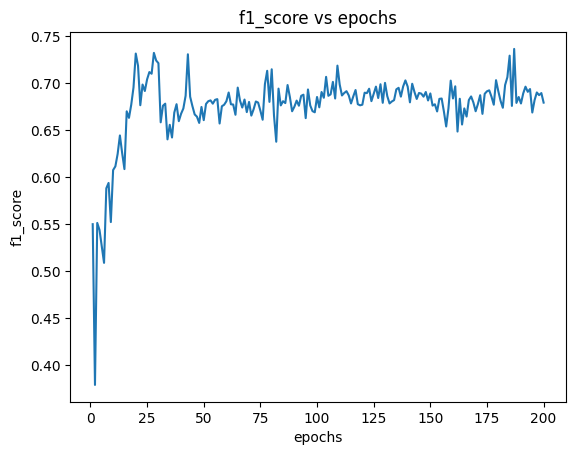

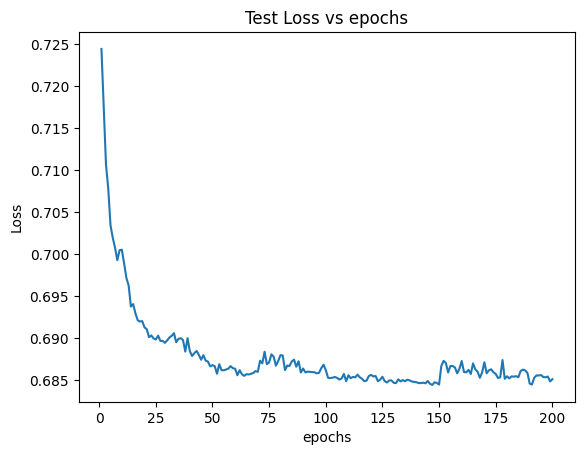

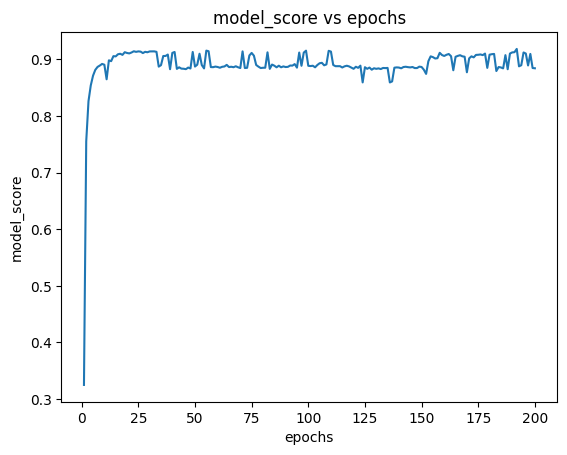

In [8]:
print(max_ms)   
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

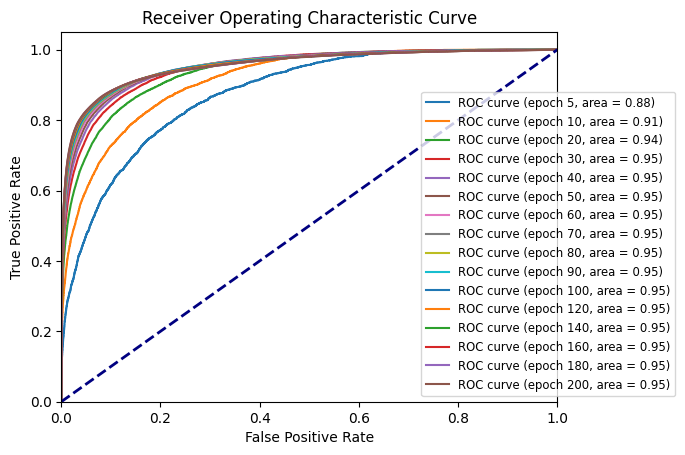

In [9]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [10]:
# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
            
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.6825    0.6667  1       1
      1       0.5159    0.6667  0.6667  0.95
      2       0.6825    0.6667  1       1
      3       0.6825    0.6667  1       1
      4       0.3492    0.3333  1       0.95
      5       0.6825    0.6667  1       1
      6       0.5159    0.6667  0.6667  1
      7       0.3492    0.3333  1       0.9
      8       0.3492    0.3333  1       1
      9       0.5159    0.6667  0.6667  1
     10       0.5159    0.6667  0.6667  0.95
     11       0.6825    0.6667  1       1
     12       0.6825    0.6667  1       1
     13       0.6984    0.5     0.6667  0.8684
     14       0.6825    0.6667  1       1
     15       0.6825    0.6667  1       1
     16       0.6825    0.6667  1       1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.6825    0.6667  1       1
     20       0.6825    0.6667  1       1


In [11]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 